In [1]:
name = "Ricardo Hideki Hangai Kojo"  # write YOUR NAME

honorPledge = "I affirm that I have not given or received any unauthorized " \
              "help on this assignment, and that this work is my own.\n"


print("\nName: ", name)
print("\nHonor pledge: ", honorPledge)



Name:  Ricardo Hideki Hangai Kojo

Honor pledge:  I affirm that I have not given or received any unauthorized help on this assignment, and that this work is my own.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

%matplotlib inline

In [3]:
(X_train_ori, y_train_ori), (X_test_ori, y_test_ori) = mnist.load_data()

print(X_train_ori.shape, y_train_ori.shape)
print(X_test_ori.shape, y_test_ori.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


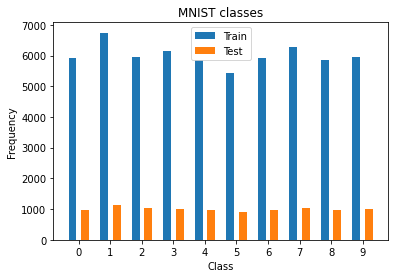

In [4]:
labels = ["%s"%i for i in range(10)]

unique, counts = np.unique(y_train_ori, return_counts=True)
uniquet, countst = np.unique(y_test_ori, return_counts=True)

fig, ax = plt.subplots()
rects1 = ax.bar(unique - 0.2, counts, 0.25, label='Train')
rects2 = ax.bar(unique + 0.2, countst, 0.25, label='Test')
ax.legend()
ax.set_xticks(unique)
ax.set_xticklabels(labels)

plt.title('MNIST classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

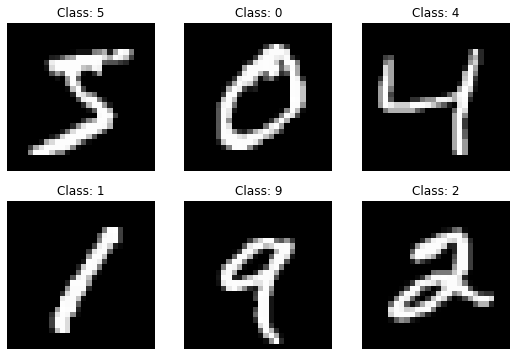

In [5]:
fig, ax = plt.subplots(2, 3, figsize = (9, 6))

for i in range(6):
    ax[i//3, i%3].imshow(X_train_ori[i], cmap='gray')
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title("Class: %d"%y_train_ori[i])
    
plt.show()

In [6]:
# Reduce the image size to its half 
X_train = np.array([image[::2, 1::2] for image in X_train_ori])
X_test  = np.array([image[::2, 1::2] for image in X_test_ori])

y_train = y_train_ori
y_test = y_test_ori

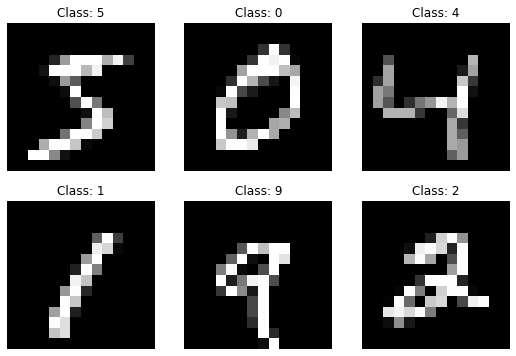

In [7]:
fig, ax = plt.subplots(2, 3, figsize = (9, 6))

for i in range(6):
    ax[i//3, i%3].imshow(X_train[i], cmap='gray')
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title("Class: %d"%y_train_ori[i])
    
plt.show()

In [8]:
X_train = (X_train/255.0).astype('float32').reshape((60000,14*14))
X_test = (X_test/255.0).astype('float32').reshape((10000,14*14))

print(X_train.dtype)
print(X_test.dtype)

print("\nShape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

print("\nMinimum value in X_train:", np.amin(X_train))
print("Maximum value in X_train:", np.amax(X_train))

print("\nMinimum value in X_test:", np.amin(X_test))
print("Maximum value in X_test:", np.amax(X_test))

float32
float32

Shape of X_train:  (60000, 196)
Shape of X_test:  (10000, 196)

Minimum value in X_train: 0.0
Maximum value in X_train: 1.0

Minimum value in X_test: 0.0
Maximum value in X_test: 1.0


---

# Solution

## 0. Lib versions

In [9]:
print('numpy version:', np.__version__)

import matplotlib
print('matplotlib version:', matplotlib.__version__)
del matplotlib

import tensorflow
print('tensorflow version: ', tensorflow.__version__)
del tensorflow

import sklearn
print('scikit-learn version:', sklearn.__version__)
del sklearn

numpy version: 1.19.5
matplotlib version: 3.4.1
tensorflow version:  2.5.0
scikit-learn version: 0.24.2


## 1. Dataset preparation

In [10]:
from sklearn.model_selection import train_test_split

D_X_train, D_X_val, D_y_train, D_y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

print(D_X_train.shape)
print(D_X_val.shape)

print(D_y_train.shape)
print(D_y_val.shape)

(42000, 196)
(18000, 196)
(42000,)
(18000,)


In [11]:
def print_distribution(y_train, y_test, train_label, test_label):
    """
    Plots distribution of train and test answers
    :param y_train: answers for train set
    :type y_train: np.ndarray(shape=(M,))
    :param y_test: answers for test set
    :type y_test: np.ndarray(shape=(N,))
    :param train_label: label shown for train set 
    :type train_label: str
    :param test_label: label shown for test set 
    :type test_label: str
    :return: nothing
    :rtype: None
    """

    labels = ["%s"%i for i in range(10)]

    unique, counts = np.unique(y_train, return_counts=True)
    uniquet, countst = np.unique(y_test, return_counts=True)

    fig, ax = plt.subplots()
    rects1 = ax.bar(unique - 0.2, counts, 0.25, label=train_label)
    rects2 = ax.bar(unique + 0.2, countst, 0.25, label=test_label)
    ax.legend()
    ax.set_xticks(unique)
    ax.set_xticklabels(labels)

    plt.title('MNIST classes')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.show()

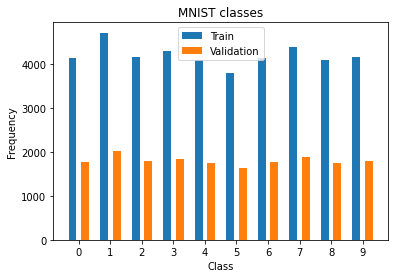

In [12]:
print_distribution(D_y_train, D_y_val, 'Train', 'Validation')

## 2. Training, evaluating and selecting models

### 2.1 Logistic regression

To train and evaluate a model using Logistic Regression, the method [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) was used. It implements the Logistic Regression function along with the Cross Validation Technique. It also applies regularization by default.

The hyperparameter is `C`, which is the inverse of the regularization strength (which we've seen in class as $\lambda$). The values chosen to be tested were `[0.01, 0.1, 1, 10, 100]`.

The Cross Validation technique applied is a Stratified K-fold with 5 folds.

The iterations number was increased due to multiple no conversion warnings with default value (`100` iterations).

After fitting the data, **the chosen `C` value was `10`**, with an **accuracy of approx. 91.73%**.

The decisions for this sections were taken based on the following articles from scikit-learn documentation: [about Logistic Regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), [LogisticRegression method docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), [LogisticRegressionCV method docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html), [the whole section about model selection](https://scikit-learn.org/stable/model_selection.html) and usage examples such as [this one](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html).

In [28]:
from sklearn.linear_model import LogisticRegressionCV

logistic_regression_model = LogisticRegressionCV(
    Cs=[0.01, 0.1, 1, 10, 100],
    cv=5,
    max_iter=1000,
    random_state=42
).fit(D_X_train, D_y_train)

/home/kojo/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

In [30]:
print('Score for Logistic Regression model:', logistic_regression_model.score(D_X_train, D_y_train))
print('Chosen C parameter:', logistic_regression_model.C_)

Score for Logistic Regression model: 0.9172857142857143
Chosen C parameter: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


### 2.2 Neural network

To train and evaluate a model using Neural Networks, the method [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) was used, along with the [HalvingRandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html). The former implements a multi-layer perceptron neural network (with regularization). The latter receives the defined neural network object (it could be other techniques from scikit-learn) and trains it with multiple combinations of the given hyperparameters, in order to find the combination with highest score (in this case, accuracy). This particular model selector randomly chooses the next permutation to test, and tries to eliminate some of the possibilities. Although it makes the training part faster, there might be an eliminated permutation that performs better than the chosen one.

The hyperparameter are:
- `activation (default value: 'relu')`: activation function for the hidden layer;
- `alpha (default value: 0.0001)`: L2 penalty (regularization term) parameter;
- `hidden_later_sizes (default value:(100,))`: the ith element represents the number of neurons in the ith hidden layer.;
- `learning_rate_init (default value: 0.001)`: the initial learning rate used. It controls the step-size in updating the weights.;
- `max_iter (default value: 200)`: Maximum number of iterations. The solver iterates until convergence.

The values were based on examples such as: (1)[https://johdev.com/jupyter/2020/03/02/Sklearn_MLP_for_MNIST.html] and (2)[https://nasirml.wordpress.com/2017/12/16/multi-layer-perceptron-in-tensorflow-part-2-mnist/]

The Cross Validation technique applied is a Stratified K-fold with 5 folds.

After fitting the data, the chosen values were **`{'max_iter': 200, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (196,), 'alpha': 0.001, 'activation': 'relu'}`** with an **accuracy of approx. 96.67%**.

Other material used: documentation about [neural networks](https://scikit-learn.org/stable/modules/neural_networks_supervised.html) and [grid search](https://scikit-learn.org/stable/modules/grid_search.html).

In [43]:
from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV

param_grid = {
    'hidden_layer_sizes': [(10,), (100,), (196,), (196, 98)],
    'activation': ['tanh', 'relu'],
    'alpha': [1e-3, 1e-4, 1e-5],
    'learning_rate_init': [0.1, 0.01, 0.001],
    'max_iter': [10, 50, 100, 200],
}
base_neural_network = MLPClassifier(early_stopping=True, random_state=42, verbose=True)
sh = HalvingRandomSearchCV(base_neural_network, param_grid, random_state=42).fit(D_X_train, D_y_train)

/home/kojo/.local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 288 is smaller than n_iter=420. Running 288 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn

Iteration 1, loss = 2.44115875
Validation score: 0.000000
Iteration 2, loss = 2.19106116
Validation score: 0.250000
Iteration 3, loss = 1.53465699
Validation score: 0.125000
Iteration 4, loss = 1.45041019
Validation score: 0.250000
Iteration 5, loss = 1.22241346
Validation score: 0.250000
Iteration 6, loss = 0.97464290
Validation score: 0.250000
Iteration 7, loss = 0.83175659
Validation score: 0.250000
Iteration 8, loss = 0.71573552
Validation score: 0.125000
Iteration 9, loss = 0.58686129
Validation score: 0.125000
Iteration 10, loss = 0.44315571
Validation score: 0.250000
Iteration 1, loss = 2.38830739
Validation score: 0.375000
Iteration 2, loss = 1.75690218
Validation score: 0.125000
Iteration 3, loss = 1.36633417
Validation score: 0.250000
Iteration 4, loss = 1.03586152
Validation score: 0.250000
Iteration 5, loss = 0.76810007
Validation score: 0.250000
Iteration 6, loss = 0.60122811
Validation score: 0.250000
Iteration 7, loss = 0.45084539
Validation score: 0.250000
Iteration 8, 

Iteration 1, loss = 2.37875369
Validation score: 0.125000
Iteration 2, loss = 1.82444878
Validation score: 0.375000
Iteration 3, loss = 1.44917207
Validation score: 0.625000
Iteration 4, loss = 1.10898604
Validation score: 0.625000
Iteration 5, loss = 0.82546074
Validation score: 0.625000
Iteration 6, loss = 0.59493184
Validation score: 0.500000
Iteration 7, loss = 0.44260038
Validation score: 0.625000
Iteration 8, loss = 0.32764762
Validation score: 0.625000
Iteration 9, loss = 0.24276451
Validation score: 0.750000
Iteration 10, loss = 0.18398323
Validation score: 0.750000
Iteration 11, loss = 0.14028530
Validation score: 0.750000
Iteration 12, loss = 0.10581197
Validation score: 0.750000
Iteration 13, loss = 0.07962790
Validation score: 0.750000
Iteration 14, loss = 0.06183857
Validation score: 0.750000
Iteration 15, loss = 0.04996249
Validation score: 0.750000
Iteration 16, loss = 0.04127320
Validation score: 0.625000
Iteration 17, loss = 0.03415095
Validation score: 0.500000
Iterat

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Iteration 10, loss = 1.40133867
Validation score: 0.500000
Iteration 1, loss = 2.35234772
Validation score: 0.000000
Iteration 2, loss = 2.16392794
Validation score: 0.000000
Iteration 3, loss = 2.00695872
Validation score: 0.000000
Iteration 4, loss = 1.87823033
Validation score: 0.000000
Iteration 5, loss = 1.77169597
Validation score: 0.000000
Iteration 6, loss = 1.67944148
Validation score: 0.125000
Iteration 7, loss = 1.59537280
Validation score: 0.125000
Iteration 8, loss = 1.51609353
Validation score: 0.125000
Iteration 9, loss = 1.43998084
Validation score: 0.125000
Iteration 10, loss = 1.36630229
Validation score: 0.125000
Iteration 1, loss = 2.44115875
Validation score: 0.000000
Iteration 2, loss = 2.25930454
Validation score: 0.000000
Iteration 3, loss = 2.11572602
Validation score: 0.125000
Iteration 4, loss = 1.98994605
Validation score: 0.125000
Iteration 5, loss = 1.87337812
Validation score: 0.125000
Iteration 6, loss = 1.76366225
Validation score: 0.125000
Iteration 7,

Iteration 18, loss = 0.92900400
Validation score: 0.500000
Iteration 19, loss = 0.88180926
Validation score: 0.500000
Iteration 20, loss = 0.83573466
Validation score: 0.500000
Iteration 21, loss = 0.79090259
Validation score: 0.500000
Iteration 22, loss = 0.74763714
Validation score: 0.500000
Iteration 23, loss = 0.70626383
Validation score: 0.500000
Iteration 24, loss = 0.66697441
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.35234772
Validation score: 0.000000
Iteration 2, loss = 2.16392794
Validation score: 0.000000
Iteration 3, loss = 2.00695872
Validation score: 0.000000
Iteration 4, loss = 1.87823033
Validation score: 0.000000
Iteration 5, loss = 1.77169597
Validation score: 0.000000
Iteration 6, loss = 1.67944148
Validation score: 0.125000
Iteration 7, loss = 1.59537280
Validation score: 0.125000
Iteration 8, loss = 1.51609353
Validation score: 0.125000
Iteration 9, loss = 1.43998084

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Iteration 3, loss = 2.35464523
Validation score: 0.000000
Iteration 4, loss = 2.33816863
Validation score: 0.000000
Iteration 5, loss = 2.32191775
Validation score: 0.000000
Iteration 6, loss = 2.30588435
Validation score: 0.000000
Iteration 7, loss = 2.29006078
Validation score: 0.000000
Iteration 8, loss = 2.27443858
Validation score: 0.000000
Iteration 9, loss = 2.25901032
Validation score: 0.000000
Iteration 10, loss = 2.24376773
Validation score: 0.000000
Iteration 11, loss = 2.22870383
Validation score: 0.000000
Iteration 12, loss = 2.21380993
Validation score: 0.000000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.37875369
Validation score: 0.000000
Iteration 2, loss = 2.36000470
Validation score: 0.000000
Iteration 3, loss = 2.34151763
Validation score: 0.000000
Iteration 4, loss = 2.32329591
Validation score: 0.000000
Iteration 5, loss = 2.30534250
Validation score: 0.000000
Iteration 6, loss = 2.28765594
Val

Iteration 2, loss = 1.51953350
Validation score: 0.375000
Iteration 3, loss = 4.23457676
Validation score: 0.375000
Iteration 4, loss = 1.80810792
Validation score: 0.375000
Iteration 5, loss = 0.71091914
Validation score: 0.250000
Iteration 6, loss = 1.05032052
Validation score: 0.250000
Iteration 7, loss = 0.49536246
Validation score: 0.375000
Iteration 8, loss = 0.20855860
Validation score: 0.500000
Iteration 9, loss = 0.13152078
Validation score: 0.375000
Iteration 10, loss = 0.13969653
Validation score: 0.500000
Iteration 1, loss = 2.41962633
Validation score: 0.250000
Iteration 2, loss = 1.79313597
Validation score: 0.500000
Iteration 3, loss = 3.41107501
Validation score: 0.250000
Iteration 4, loss = 2.27858635
Validation score: 0.250000
Iteration 5, loss = 0.91443271
Validation score: 0.125000
Iteration 6, loss = 1.42819691
Validation score: 0.125000
Iteration 7, loss = 0.41249749
Validation score: 0.500000
Iteration 8, loss = 0.18714036
Validation score: 0.500000
Iteration 9, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.04116251
Validation score: 0.500000
Iteration 1, loss = 2.43190245
Validation score: 0.125000
Iteration 2, loss = 1.60744454
Validation score: 0.125000
Iteration 3, loss = 2.32579588
Validation score: 0.250000
Iteration 4, loss = 1.62039619
Validation score: 0.250000
Iteration 5, loss = 0.73955555
Validation score: 0.250000
Iteration 6, loss = 0.35460762
Validation score: 0.125000
Iteration 7, loss = 0.25115041
Validation score: 0.375000
Iteration 8, loss = 0.07466538
Validation score: 0.500000
Iteration 9, loss = 0.03766817
Validation score: 0.625000
Iteration 10, loss = 0.06671259
Validation score: 0.625000
Iteration 1, loss = 2.36207569
Validation score: 0.125000
Iteration 2, loss = 2.22415268
Validation score: 0.375000
Iteration 3, loss = 2.20338677
Validation score: 0.250000
Iteration 4, loss = 3.77493811
Validation score: 0.500000
Iteration 5, loss = 1.99230833
Validation score: 0.375000
Iteration 6, loss = 0.55215693
Validation score: 0.250000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.87530350
Validation score: 0.375000
Iteration 8, loss = 0.83348046
Validation score: 0.375000
Iteration 9, loss = 0.21209395
Validation score: 0.500000
Iteration 10, loss = 0.07022720
Validation score: 0.750000
Iteration 1, loss = 2.41364404
Validation score: 0.250000
Iteration 2, loss = 1.51953350
Validation score: 0.375000
Iteration 3, loss = 4.23457676
Validation score: 0.375000
Iteration 4, loss = 1.80810792
Validation score: 0.375000
Iteration 5, loss = 0.71091914
Validation score: 0.250000
Iteration 6, loss = 1.05032052
Validation score: 0.250000
Iteration 7, loss = 0.49536246
Validation score: 0.375000
Iteration 8, loss = 0.20855860
Validation score: 0.500000
Iteration 9, loss = 0.13152078
Validation score: 0.375000
Iteration 10, loss = 0.13969653
Validation score: 0.500000
Iteration 11, loss = 0.15263060
Validation score: 0.500000
Iteration 12, loss = 0.08436329
Validation score: 0.500000
Iteration 13, loss = 0.04141982
Validation score: 0.500000
Iteration

Iteration 9, loss = 0.21209395
Validation score: 0.500000
Iteration 10, loss = 0.07022720
Validation score: 0.750000
Iteration 11, loss = 0.13182886
Validation score: 0.750000
Iteration 12, loss = 0.12421144
Validation score: 0.500000
Iteration 13, loss = 0.05555361
Validation score: 0.500000
Iteration 14, loss = 0.04650333
Validation score: 0.500000
Iteration 15, loss = 0.04140948
Validation score: 0.375000
Iteration 16, loss = 0.03483803
Validation score: 0.375000
Iteration 17, loss = 0.03290600
Validation score: 0.375000
Iteration 18, loss = 0.03371707
Validation score: 0.500000
Iteration 19, loss = 0.03424801
Validation score: 0.500000
Iteration 20, loss = 0.03273773
Validation score: 0.500000
Iteration 21, loss = 0.03080300
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.41364404
Validation score: 0.250000
Iteration 2, loss = 1.51953350
Validation score: 0.375000
Iteration 3, loss = 4.234

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Iteration 9, loss = 0.21451856
Validation score: 0.500000
Iteration 10, loss = 0.15716995
Validation score: 0.375000
Iteration 1, loss = 2.43190245
Validation score: 0.125000
Iteration 2, loss = 1.77906782
Validation score: 0.125000
Iteration 3, loss = 1.34481059
Validation score: 0.250000
Iteration 4, loss = 1.00167469
Validation score: 0.375000
Iteration 5, loss = 0.73209846
Validation score: 0.375000
Iteration 6, loss = 0.53256747
Validation score: 0.375000
Iteration 7, loss = 0.38798732
Validation score: 0.375000
Iteration 8, loss = 0.28090520
Validation score: 0.500000
Iteration 9, loss = 0.20171765
Validation score: 0.500000
Iteration 10, loss = 0.14437818
Validation score: 0.500000
Iteration 1, loss = 2.36207569
Validation score: 0.000000
Iteration 2, loss = 1.71654791
Validation score: 0.250000
Iteration 3, loss = 1.30870543
Validation score: 0.375000
Iteration 4, loss = 1.00787599
Validation score: 0.375000
Iteration 5, loss = 0.76218387
Validation score: 0.375000
Iteration 6,

Iteration 19, loss = 0.01100662
Validation score: 0.375000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.36207569
Validation score: 0.000000
Iteration 2, loss = 1.71654791
Validation score: 0.250000
Iteration 3, loss = 1.30870543
Validation score: 0.375000
Iteration 4, loss = 1.00787599
Validation score: 0.375000
Iteration 5, loss = 0.76218387
Validation score: 0.375000
Iteration 6, loss = 0.56299096
Validation score: 0.375000
Iteration 7, loss = 0.41742707
Validation score: 0.375000
Iteration 8, loss = 0.31502833
Validation score: 0.375000
Iteration 9, loss = 0.23885803
Validation score: 0.375000
Iteration 10, loss = 0.17908667
Validation score: 0.375000
Iteration 11, loss = 0.13220522
Validation score: 0.375000
Iteration 12, loss = 0.09656749
Validation score: 0.375000
Iteration 13, loss = 0.07037321
Validation score: 0.375000
Iteration 14, loss = 0.05156695
Validation score: 0.375000
Validation score did not improv

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Iteration 8, loss = 1.92552067
Validation score: 0.250000
Iteration 9, loss = 1.86431082
Validation score: 0.250000
Iteration 10, loss = 1.80537497
Validation score: 0.375000
Iteration 1, loss = 2.36207569
Validation score: 0.250000
Iteration 2, loss = 2.27636006
Validation score: 0.125000
Iteration 3, loss = 2.19512214
Validation score: 0.125000
Iteration 4, loss = 2.11818857
Validation score: 0.125000
Iteration 5, loss = 2.04531165
Validation score: 0.000000
Iteration 6, loss = 1.97618943
Validation score: 0.000000
Iteration 7, loss = 1.91050593
Validation score: 0.000000
Iteration 8, loss = 1.84795027
Validation score: 0.000000
Iteration 9, loss = 1.78822723
Validation score: 0.000000
Iteration 10, loss = 1.73106682
Validation score: 0.125000
Iteration 1, loss = 2.41364404
Validation score: 0.125000
Iteration 2, loss = 2.32722957
Validation score: 0.125000
Iteration 3, loss = 2.24680858
Validation score: 0.250000
Iteration 4, loss = 2.17156826
Validation score: 0.250000
Iteration 5,

Iteration 10, loss = 1.81747538
Validation score: 0.000000
Iteration 11, loss = 1.76107803
Validation score: 0.000000
Iteration 12, loss = 1.70629156
Validation score: 0.000000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.43190245
Validation score: 0.125000
Iteration 2, loss = 2.34991056
Validation score: 0.000000
Iteration 3, loss = 2.27144593
Validation score: 0.000000
Iteration 4, loss = 2.19634090
Validation score: 0.125000
Iteration 5, loss = 2.12439037
Validation score: 0.125000
Iteration 6, loss = 2.05539282
Validation score: 0.125000
Iteration 7, loss = 1.98916049
Validation score: 0.125000
Iteration 8, loss = 1.92552067
Validation score: 0.250000
Iteration 9, loss = 1.86431082
Validation score: 0.250000
Iteration 10, loss = 1.80537497
Validation score: 0.375000
Iteration 11, loss = 1.74855734
Validation score: 0.375000
Iteration 12, loss = 1.69370514
Validation score: 0.375000
Iteration 13, loss = 1.64066896

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net


Validation score: 0.625000
Iteration 1, loss = 2.33736400
Validation score: 0.625000
Iteration 2, loss = 1.97355151
Validation score: 0.250000
Iteration 3, loss = 4.67319831
Validation score: 0.375000
Iteration 4, loss = 2.68563360
Validation score: 0.375000
Iteration 5, loss = 2.15610821
Validation score: 0.500000
Iteration 6, loss = 0.54482355
Validation score: 0.250000
Iteration 7, loss = 0.91845470
Validation score: 0.375000
Iteration 8, loss = 0.61991157
Validation score: 0.375000
Iteration 9, loss = 0.10594628
Validation score: 0.750000
Iteration 10, loss = 0.03842689
Validation score: 0.750000
Iteration 1, loss = 2.32617443
Validation score: 0.250000
Iteration 2, loss = 2.21951305
Validation score: 0.125000
Iteration 3, loss = 5.63054736
Validation score: 0.000000
Iteration 4, loss = 5.02965632
Validation score: 0.625000
Iteration 5, loss = 2.68970863
Validation score: 0.875000
Iteration 6, loss = 1.96629731
Validation score: 0.875000
Iteration 7, loss = 0.80936572
Validation s

Iteration 5, loss = 2.51408277
Validation score: 0.375000
Iteration 6, loss = 1.88996254
Validation score: 0.250000
Iteration 7, loss = 1.88230252
Validation score: 0.500000
Iteration 8, loss = 1.00589744
Validation score: 0.500000
Iteration 9, loss = 0.73584046
Validation score: 0.625000
Iteration 10, loss = 0.45801601
Validation score: 0.625000
Iteration 11, loss = 0.16215610
Validation score: 0.625000
Iteration 12, loss = 0.05106668
Validation score: 0.750000
Iteration 13, loss = 0.11375767
Validation score: 0.375000
Iteration 14, loss = 0.15650105
Validation score: 0.375000
Iteration 15, loss = 0.06557142
Validation score: 0.500000
Iteration 16, loss = 0.04462526
Validation score: 0.375000
Iteration 17, loss = 0.04706347
Validation score: 0.250000
Iteration 18, loss = 0.05101137
Validation score: 0.250000
Iteration 19, loss = 0.05135136
Validation score: 0.250000
Iteration 20, loss = 0.05124225
Validation score: 0.375000
Iteration 21, loss = 0.05267072
Validation score: 0.375000
It

Iteration 8, loss = 0.83872671
Validation score: 0.375000
Iteration 9, loss = 0.89394594
Validation score: 0.500000
Iteration 10, loss = 0.21215119
Validation score: 0.625000
Iteration 11, loss = 0.08111726
Validation score: 0.750000
Iteration 12, loss = 0.08992572
Validation score: 0.625000
Iteration 13, loss = 0.06355086
Validation score: 0.750000
Iteration 14, loss = 0.05129149
Validation score: 0.625000
Iteration 15, loss = 0.05984706
Validation score: 0.625000
Iteration 16, loss = 0.06251056
Validation score: 0.625000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.34905796
Validation score: 0.250000
Iteration 2, loss = 3.39637396
Validation score: 0.625000
Iteration 3, loss = 5.69371721
Validation score: 0.125000
Iteration 4, loss = 5.96167248
Validation score: 0.125000
Iteration 5, loss = 4.45749912
Validation score: 0.875000
Iteration 6, loss = 1.78459969
Validation score: 0.875000
Iteration 7, loss = 1.69985133

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.35535941
Validation score: 0.250000
Iteration 2, loss = 1.58880049
Validation score: 0.250000
Iteration 3, loss = 1.04125763
Validation score: 0.500000
Iteration 4, loss = 0.67754447
Validation score: 0.625000
Iteration 5, loss = 0.45944437
Validation score: 0.625000
Iteration 6, loss = 0.31696512
Validation score: 0.625000
Iteration 7, loss = 0.21137711
Validation score: 0.625000
Iteration 8, loss = 0.13895595
Validation score: 0.625000
Iteration 9, loss = 0.09335348
Validation score: 0.625000
Iteration 10, loss = 0.06451269
Validation score: 0.625000
Iteration 1, loss = 2.33736400
Validation score: 0.500000
Iteration 2, loss = 1.54197175
Validation score: 0.625000
Iteration 3, loss = 0.99671303
Validation score: 0.625000
Iteration 4, loss = 0.63349245
Validation score: 0.750000
Iteration 5, loss = 0.40042292
Validation score: 0.750000
Iteration 6, loss = 0.25903877
Validation score: 0.750000
Iteration 7, loss = 0.16909987
Validation score: 0.750000
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.07960415
Validation score: 0.875000
Iteration 1, loss = 2.41132123
Validation score: 0.125000
Iteration 2, loss = 1.72508555
Validation score: 0.250000
Iteration 3, loss = 1.11036315
Validation score: 0.250000
Iteration 4, loss = 0.78015138
Validation score: 0.500000
Iteration 5, loss = 0.53160069
Validation score: 0.625000
Iteration 6, loss = 0.36888461
Validation score: 0.750000
Iteration 7, loss = 0.26642080
Validation score: 0.750000
Iteration 8, loss = 0.19134745
Validation score: 0.750000
Iteration 9, loss = 0.13316664
Validation score: 0.750000
Iteration 10, loss = 0.09144728
Validation score: 0.625000
Iteration 11, loss = 0.06409698
Validation score: 0.625000
Iteration 12, loss = 0.04701491
Validation score: 0.625000
Iteration 13, loss = 0.03629945
Validation score: 0.625000
Iteration 14, loss = 0.02912456
Validation score: 0.625000
Iteration 15, loss = 0.02378101
Validation score: 0.625000
Iteration 16, loss = 0.01944258
Validation score: 0.625000
Iterat

Iteration 15, loss = 0.01081108
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.32617443
Validation score: 0.125000
Iteration 2, loss = 1.56213945
Validation score: 0.500000
Iteration 3, loss = 1.05192762
Validation score: 0.750000
Iteration 4, loss = 0.68358117
Validation score: 0.625000
Iteration 5, loss = 0.44273030
Validation score: 0.750000
Iteration 6, loss = 0.28998101
Validation score: 0.750000
Iteration 7, loss = 0.19514761
Validation score: 0.750000
Iteration 8, loss = 0.13220548
Validation score: 0.750000
Iteration 9, loss = 0.08640111
Validation score: 0.750000
Iteration 10, loss = 0.05438841
Validation score: 0.750000
Iteration 11, loss = 0.03412445
Validation score: 0.750000
Iteration 12, loss = 0.02228577
Validation score: 0.750000
Iteration 13, loss = 0.01562402
Validation score: 0.875000
Iteration 14, loss = 0.01183686
Validation score: 0.875000
Iteration 15, loss = 0.00956576

Iteration 9, loss = 1.61480375
Validation score: 0.125000
Iteration 10, loss = 1.54103618
Validation score: 0.125000
Iteration 1, loss = 2.35535941
Validation score: 0.125000
Iteration 2, loss = 2.25058982
Validation score: 0.125000
Iteration 3, loss = 2.15127704
Validation score: 0.125000
Iteration 4, loss = 2.05695770
Validation score: 0.250000
Iteration 5, loss = 1.96715382
Validation score: 0.250000
Iteration 6, loss = 1.88140152
Validation score: 0.250000
Iteration 7, loss = 1.79928419
Validation score: 0.250000
Iteration 8, loss = 1.72045311
Validation score: 0.250000
Iteration 9, loss = 1.64463247
Validation score: 0.250000
Iteration 10, loss = 1.57162454
Validation score: 0.375000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.33736400
Validation score: 0.000000
Iteration 2, loss = 2.22888538
Validation score: 0.000000
Iteration 3, loss = 2.12657077
Validation score: 0.000000
Iteration 4, loss = 2.02977497
Validation score: 0.000000
Iteration 5, loss = 1.93788119
Validation score: 0.000000
Iteration 6, loss = 1.85033146
Validation score: 0.000000
Iteration 7, loss = 1.76664526
Validation score: 0.250000
Iteration 8, loss = 1.68643383
Validation score: 0.375000
Iteration 9, loss = 1.60939866
Validation score: 0.625000
Iteration 10, loss = 1.53532424
Validation score: 0.625000
Iteration 1, loss = 2.32617443
Validation score: 0.000000
Iteration 2, loss = 2.21458896
Validation score: 0.000000
Iteration 3, loss = 2.11045143
Validation score: 0.000000
Iteration 4, loss = 2.01306951
Validation score: 0.000000
Iteration 5, loss = 1.92167616
Validation score: 0.000000
Iteration 6, loss = 1.83547201
Validation score: 0.125000
Iteration 7, loss = 1.75371068
Validation score: 0.125000
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.000000
Iteration 2, loss = 2.22878686
Validation score: 0.000000
Iteration 3, loss = 2.11864192
Validation score: 0.000000
Iteration 4, loss = 2.01762255
Validation score: 0.000000
Iteration 5, loss = 1.92442423
Validation score: 0.125000
Iteration 6, loss = 1.83760863
Validation score: 0.375000
Iteration 7, loss = 1.75588642
Validation score: 0.500000
Iteration 8, loss = 1.67827192
Validation score: 0.625000
Iteration 9, loss = 1.60411115
Validation score: 0.625000
Iteration 10, loss = 1.53301627
Validation score: 0.750000
Iteration 1, loss = 2.41132123
Validation score: 0.000000
Iteration 2, loss = 2.28208724
Validation score: 0.000000
Iteration 3, loss = 2.16212899
Validation score: 0.000000
Iteration 4, loss = 2.05165131
Validation score: 0.125000
Iteration 5, loss = 1.95043772
Validation score: 0.125000
Iteration 6, loss = 1.85763291
Validation score: 0.125000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 1.77183289
Validation score: 0.125000
Iteration 8, loss = 1.69138907
Validation score: 0.125000
Iteration 9, loss = 1.61480375
Validation score: 0.125000
Iteration 10, loss = 1.54103618
Validation score: 0.125000
Iteration 11, loss = 1.46960568
Validation score: 0.125000
Iteration 12, loss = 1.40049628
Validation score: 0.125000
Iteration 13, loss = 1.33394841
Validation score: 0.125000
Iteration 14, loss = 1.27024127
Validation score: 0.125000
Iteration 15, loss = 1.20954030
Validation score: 0.250000
Iteration 16, loss = 1.15183848
Validation score: 0.250000
Iteration 17, loss = 1.09698661
Validation score: 0.375000
Iteration 18, loss = 1.04476938
Validation score: 0.375000
Iteration 19, loss = 0.99498311
Validation score: 0.375000
Iteration 20, loss = 0.94748134
Validation score: 0.500000
Iteration 21, loss = 0.90218120
Validation score: 0.500000
Iteration 22, loss = 0.85904485
Validation score: 0.500000
Iteration 23, loss = 0.81804864
Validation score: 0.500000


Iteration 15, loss = 1.21796298
Validation score: 0.750000
Iteration 16, loss = 1.16236926
Validation score: 0.750000
Iteration 17, loss = 1.10906895
Validation score: 0.750000
Iteration 18, loss = 1.05800580
Validation score: 0.750000
Iteration 19, loss = 1.00913613
Validation score: 0.750000
Iteration 20, loss = 0.96242264
Validation score: 0.750000
Iteration 21, loss = 0.91782908
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.41132123
Validation score: 0.000000
Iteration 2, loss = 2.28208724
Validation score: 0.000000
Iteration 3, loss = 2.16212899
Validation score: 0.000000
Iteration 4, loss = 2.05165131
Validation score: 0.125000
Iteration 5, loss = 1.95043772
Validation score: 0.125000
Iteration 6, loss = 1.85763291
Validation score: 0.125000
Iteration 7, loss = 1.77183289
Validation score: 0.125000
Iteration 8, loss = 1.69138907
Validation score: 0.125000
Iteration 9, loss = 1.61480375

Iteration 5, loss = 1.92442423
Validation score: 0.125000
Iteration 6, loss = 1.83760863
Validation score: 0.375000
Iteration 7, loss = 1.75588642
Validation score: 0.500000
Iteration 8, loss = 1.67827192
Validation score: 0.625000
Iteration 9, loss = 1.60411115
Validation score: 0.625000
Iteration 10, loss = 1.53301627
Validation score: 0.750000
Iteration 11, loss = 1.46476891
Validation score: 0.750000
Iteration 12, loss = 1.39923492
Validation score: 0.750000
Iteration 13, loss = 1.33631438
Validation score: 0.750000
Iteration 14, loss = 1.27591858
Validation score: 0.750000
Iteration 15, loss = 1.21796298
Validation score: 0.750000
Iteration 16, loss = 1.16236926
Validation score: 0.750000
Iteration 17, loss = 1.10906895
Validation score: 0.750000
Iteration 18, loss = 1.05800580
Validation score: 0.750000
Iteration 19, loss = 1.00913613
Validation score: 0.750000
Iteration 20, loss = 0.96242264
Validation score: 0.750000
Iteration 21, loss = 0.91782908
Validation score: 0.750000
Va

Validation score: 0.000000
Iteration 5, loss = 1.92442423
Validation score: 0.125000
Iteration 6, loss = 1.83760863
Validation score: 0.375000
Iteration 7, loss = 1.75588642
Validation score: 0.500000
Iteration 8, loss = 1.67827192
Validation score: 0.625000
Iteration 9, loss = 1.60411115
Validation score: 0.625000
Iteration 10, loss = 1.53301627
Validation score: 0.750000
Iteration 11, loss = 1.46476891
Validation score: 0.750000
Iteration 12, loss = 1.39923492
Validation score: 0.750000
Iteration 13, loss = 1.33631438
Validation score: 0.750000
Iteration 14, loss = 1.27591858
Validation score: 0.750000
Iteration 15, loss = 1.21796298
Validation score: 0.750000
Iteration 16, loss = 1.16236926
Validation score: 0.750000
Iteration 17, loss = 1.10906895
Validation score: 0.750000
Iteration 18, loss = 1.05800580
Validation score: 0.750000
Iteration 19, loss = 1.00913613
Validation score: 0.750000
Iteration 20, loss = 0.96242264
Validation score: 0.750000
Iteration 21, loss = 0.91782908
Va

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.39562069
Validation score: 0.500000
Iteration 2, loss = 1.40299171
Validation score: 0.250000
Iteration 3, loss = 4.12311886
Validation score: 0.125000
Iteration 4, loss = 5.30632375
Validation score: 0.125000
Iteration 5, loss = 5.82956950
Validation score: 0.125000
Iteration 6, loss = 7.28046046
Validation score: 0.250000
Iteration 7, loss = 7.34884574
Validation score: 0.000000
Iteration 8, loss = 7.56463612
Validation score: 0.000000
Iteration 9, loss = 6.86807387
Validation score: 0.125000
Iteration 10, loss = 7.30830094
Validation score: 0.125000
Iteration 1, loss = 2.42282203
Validation score: 0.000000
Iteration 2, loss = 2.47000459
Validation score: 0.000000
Iteration 3, loss = 4.72922551
Validation score: 0.250000
Iteration 4, loss = 4.93319986
Validation score: 0.000000
Iteration 5, loss = 5.91331440
Validation score: 0.000000
Iteration 6, loss = 7.39226628
Validation score: 0.125000
Iteration 7, loss = 6.84526342
Validation score: 0.250000
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 3.66454568
Validation score: 0.250000
Iteration 10, loss = 3.64366460
Validation score: 0.000000
Iteration 1, loss = 2.40552852
Validation score: 0.500000
Iteration 2, loss = 2.55044823
Validation score: 0.000000
Iteration 3, loss = 6.34333586
Validation score: 0.000000
Iteration 4, loss = 6.28358794
Validation score: 0.125000
Iteration 5, loss = 5.95112386
Validation score: 0.125000
Iteration 6, loss = 5.83477055
Validation score: 0.000000
Iteration 7, loss = 6.76028351
Validation score: 0.625000
Iteration 8, loss = 7.70743691
Validation score: 0.625000
Iteration 9, loss = 7.23771968
Validation score: 0.500000
Iteration 10, loss = 5.40320417
Validation score: 0.125000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.36191615
Validation score: 0.000000
Iteration 2, loss = 5.34482124
Validation score: 0.125000
Iteration 3, loss = 5.80106123
Validation score: 0.250000
Iteration 4, loss = 4.21814131
Validation score: 0.000000
Iteration 5, loss = 5.17434685
Validation score: 0.125000
Iteration 6, loss = 6.24692596
Validation score: 0.250000
Iteration 7, loss = 6.26575280
Validation score: 0.000000
Iteration 8, loss = 4.82648409
Validation score: 0.000000
Iteration 9, loss = 5.81558814
Validation score: 0.000000
Iteration 10, loss = 5.68120167
Validation score: 0.125000
Iteration 11, loss = 4.81424448
Validation score: 0.250000
Iteration 12, loss = 3.38508789
Validation score: 0.250000
Iteration 13, loss = 3.41366700
Validation score: 0.500000
Iteration 14, loss = 4.15345258
Validation score: 0.375000
Iteration 15, loss = 4.47872907
Validation score: 0.500000
Iteration 16, loss = 3.42397423
Validation score: 0.500000
Iteration 17, loss = 1.97842377
Validation score: 0.125000
Iterat

Iteration 4, loss = 5.30632375
Validation score: 0.125000
Iteration 5, loss = 5.82956950
Validation score: 0.125000
Iteration 6, loss = 7.28046046
Validation score: 0.250000
Iteration 7, loss = 7.34884574
Validation score: 0.000000
Iteration 8, loss = 7.56463612
Validation score: 0.000000
Iteration 9, loss = 6.86807387
Validation score: 0.125000
Iteration 10, loss = 7.30830094
Validation score: 0.125000
Iteration 11, loss = 6.43753805
Validation score: 0.125000
Iteration 12, loss = 5.20052348
Validation score: 0.125000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.42282203
Validation score: 0.000000
Iteration 2, loss = 2.47000459
Validation score: 0.000000
Iteration 3, loss = 4.72922551
Validation score: 0.250000
Iteration 4, loss = 4.93319986
Validation score: 0.000000
Iteration 5, loss = 5.91331440
Validation score: 0.000000
Iteration 6, loss = 7.39226628
Validation score: 0.125000
Iteration 7, loss = 6.84526342
Val

Iteration 10, loss = 0.07585444
Validation score: 0.500000
Iteration 1, loss = 2.34246035
Validation score: 0.375000
Iteration 2, loss = 1.46022444
Validation score: 0.250000
Iteration 3, loss = 0.89900161
Validation score: 0.500000
Iteration 4, loss = 0.55697882
Validation score: 0.625000
Iteration 5, loss = 0.31930210
Validation score: 0.625000
Iteration 6, loss = 0.19553726
Validation score: 0.500000
Iteration 7, loss = 0.12791930
Validation score: 0.375000
Iteration 8, loss = 0.08573917
Validation score: 0.500000
Iteration 9, loss = 0.06005658
Validation score: 0.500000
Iteration 10, loss = 0.04285281
Validation score: 0.500000
Iteration 1, loss = 2.39562069
Validation score: 0.250000
Iteration 2, loss = 1.40147839


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.625000
Iteration 3, loss = 0.87397751
Validation score: 0.750000
Iteration 4, loss = 0.49993654
Validation score: 0.750000
Iteration 5, loss = 0.24066421
Validation score: 0.625000
Iteration 6, loss = 0.16197357
Validation score: 0.625000
Iteration 7, loss = 0.10748873
Validation score: 0.625000
Iteration 8, loss = 0.05911667
Validation score: 0.625000
Iteration 9, loss = 0.03623154
Validation score: 0.625000
Iteration 10, loss = 0.02539901
Validation score: 0.750000
Iteration 1, loss = 2.42282203
Validation score: 0.125000
Iteration 2, loss = 1.52689940
Validation score: 0.750000
Iteration 3, loss = 0.90608391
Validation score: 0.375000
Iteration 4, loss = 0.53384062
Validation score: 0.500000
Iteration 5, loss = 0.30687374
Validation score: 0.750000
Iteration 6, loss = 0.17975652
Validation score: 0.750000
Iteration 7, loss = 0.10780466
Validation score: 0.625000
Iteration 8, loss = 0.06372153
Validation score: 0.625000
Iteration 9, loss = 0.03799282
Validation sc

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.40552852
Validation score: 0.625000
Iteration 2, loss = 1.50463849
Validation score: 0.375000
Iteration 3, loss = 0.97005848
Validation score: 0.500000
Iteration 4, loss = 0.54207892
Validation score: 0.750000
Iteration 5, loss = 0.31863639
Validation score: 0.750000
Iteration 6, loss = 0.20760618
Validation score: 0.750000
Iteration 7, loss = 0.12771985
Validation score: 0.625000
Iteration 8, loss = 0.07322550
Validation score: 0.625000
Iteration 9, loss = 0.04339945
Validation score: 0.625000
Iteration 10, loss = 0.02786089
Validation score: 0.625000
Iteration 1, loss = 2.36191615
Validation score: 0.000000
Iteration 2, loss = 2.14592414
Validation score: 0.500000
Iteration 3, loss = 1.02628050
Validation score: 0.500000
Iteration 4, loss = 0.79302787
Validation score: 0.625000
Iteration 5, loss = 0.55383224
Validation score: 0.500000
Iteration 6, loss = 0.33777746
Validation score: 0.500000
Iteration 7, loss = 0.22939811
Validation score: 0.625000
Iteration 8, 

Iteration 12, loss = 0.01355591
Validation score: 0.625000
Iteration 13, loss = 0.01070506
Validation score: 0.625000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.40552852
Validation score: 0.625000
Iteration 2, loss = 1.50463849
Validation score: 0.375000
Iteration 3, loss = 0.97005848
Validation score: 0.500000
Iteration 4, loss = 0.54207892
Validation score: 0.750000
Iteration 5, loss = 0.31863639
Validation score: 0.750000
Iteration 6, loss = 0.20760618
Validation score: 0.750000
Iteration 7, loss = 0.12771985
Validation score: 0.625000
Iteration 8, loss = 0.07322550
Validation score: 0.625000
Iteration 9, loss = 0.04339945
Validation score: 0.625000
Iteration 10, loss = 0.02786089
Validation score: 0.625000
Iteration 11, loss = 0.01952378
Validation score: 0.750000
Iteration 12, loss = 0.01465966
Validation score: 0.750000
Iteration 13, loss = 0.01158539
Validation score: 0.750000
Iteration 14, loss = 0.00953942

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 1.30843329
Validation score: 0.375000
Iteration 10, loss = 1.21155825
Validation score: 0.375000
Iteration 1, loss = 2.39562069
Validation score: 0.125000
Iteration 2, loss = 2.21647356
Validation score: 0.250000
Iteration 3, loss = 2.05431275
Validation score: 0.500000
Iteration 4, loss = 1.90735579
Validation score: 0.625000
Iteration 5, loss = 1.77304508
Validation score: 0.625000
Iteration 6, loss = 1.64869116
Validation score: 0.625000
Iteration 7, loss = 1.53217549
Validation score: 0.625000
Iteration 8, loss = 1.42229866
Validation score: 0.625000
Iteration 9, loss = 1.31860630
Validation score: 0.625000
Iteration 10, loss = 1.22098141
Validation score: 0.625000
Iteration 1, loss = 2.42282203
Validation score: 0.375000
Iteration 2, loss = 2.22960845
Validation score: 0.375000
Iteration 3, loss = 2.06044589
Validation score: 0.250000
Iteration 4, loss = 1.91170752
Validation score: 0.250000
Iteration 5, loss = 1.77868999
Validation score: 0.250000
Iteration 6,

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 1.54299538
Validation score: 0.750000
Iteration 8, loss = 1.43518973
Validation score: 0.750000
Iteration 9, loss = 1.33280258
Validation score: 0.750000
Iteration 10, loss = 1.23579442
Validation score: 0.750000
Iteration 1, loss = 2.40552852
Validation score: 0.375000
Iteration 2, loss = 2.20385820
Validation score: 0.500000
Iteration 3, loss = 2.02865470
Validation score: 0.750000
Iteration 4, loss = 1.87567805
Validation score: 0.875000
Iteration 5, loss = 1.73954281
Validation score: 0.875000
Iteration 6, loss = 1.61548231
Validation score: 0.875000
Iteration 7, loss = 1.50029286
Validation score: 0.875000
Iteration 8, loss = 1.39227052
Validation score: 0.875000
Iteration 9, loss = 1.29070578
Validation score: 0.875000
Iteration 10, loss = 1.19536134
Validation score: 0.875000
Iteration 1, loss = 2.36191615
Validation score: 0.125000

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 2, loss = 2.15126508
Validation score: 0.250000
Iteration 3, loss = 1.97810767
Validation score: 0.250000
Iteration 4, loss = 1.83885997
Validation score: 0.125000
Iteration 5, loss = 1.72180769
Validation score: 0.125000
Iteration 6, loss = 1.61339659
Validation score: 0.125000
Iteration 7, loss = 1.50645599
Validation score: 0.250000
Iteration 8, loss = 1.40075100
Validation score: 0.250000
Iteration 9, loss = 1.29908832
Validation score: 0.375000
Iteration 10, loss = 1.20394828
Validation score: 0.375000
Iteration 11, loss = 1.11612859
Validation score: 0.375000
Iteration 12, loss = 1.03505345
Validation score: 0.375000
Iteration 13, loss = 0.95971851
Validation score: 0.375000
Iteration 14, loss = 0.88935223
Validation score: 0.375000
Iteration 15, loss = 0.82356865
Validation score: 0.375000
Iteration 16, loss = 0.76222406
Validation score: 0.375000
Iteration 17, loss = 0.70522301
Validation score: 0.375000
Iteration 18, loss = 0.65239364
Validation score: 0.375000
Iter

Validation score: 0.500000
Iteration 14, loss = 0.88285723
Validation score: 0.625000
Iteration 15, loss = 0.81408619
Validation score: 0.625000
Iteration 16, loss = 0.75012046
Validation score: 0.625000
Iteration 17, loss = 0.69070023
Validation score: 0.625000
Iteration 18, loss = 0.63557079
Validation score: 0.625000
Iteration 19, loss = 0.58448150
Validation score: 0.625000
Iteration 20, loss = 0.53718924
Validation score: 0.625000
Iteration 21, loss = 0.49346325
Validation score: 0.625000
Iteration 22, loss = 0.45308939
Validation score: 0.625000
Iteration 23, loss = 0.41586868
Validation score: 0.625000
Iteration 24, loss = 0.38161368
Validation score: 0.625000
Iteration 25, loss = 0.35014386
Validation score: 0.625000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.39562069
Validation score: 0.125000
Iteration 2, loss = 2.21647356
Validation score: 0.250000
Iteration 3, loss = 2.05431275
Validation score: 0.50000

Iteration 4, loss = 1.91170752
Validation score: 0.250000
Iteration 5, loss = 1.77868999
Validation score: 0.250000
Iteration 6, loss = 1.65688755
Validation score: 0.750000
Iteration 7, loss = 1.54299538
Validation score: 0.750000
Iteration 8, loss = 1.43518973
Validation score: 0.750000
Iteration 9, loss = 1.33280258
Validation score: 0.750000
Iteration 10, loss = 1.23579442
Validation score: 0.750000
Iteration 11, loss = 1.14431633
Validation score: 0.750000
Iteration 12, loss = 1.05845553
Validation score: 0.750000
Iteration 13, loss = 0.97814258
Validation score: 0.750000
Iteration 14, loss = 0.90316502
Validation score: 0.750000
Iteration 15, loss = 0.83322816
Validation score: 0.875000
Iteration 16, loss = 0.76802010
Validation score: 0.875000
Iteration 17, loss = 0.70725398
Validation score: 0.875000
Iteration 18, loss = 0.65067977
Validation score: 0.875000
Iteration 19, loss = 0.59807654
Validation score: 0.875000
Iteration 20, loss = 0.54923795
Validation score: 0.750000
Ite

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Iteration 7, loss = 0.44960433
Validation score: 0.250000
Iteration 8, loss = 0.31416758
Validation score: 0.250000
Iteration 9, loss = 0.22112893
Validation score: 0.250000
Iteration 10, loss = 0.15697237
Validation score: 0.250000
Iteration 1, loss = 2.37856789
Validation score: 0.125000
Iteration 2, loss = 1.82421755
Validation score: 0.375000
Iteration 3, loss = 1.44878053
Validation score: 0.625000
Iteration 4, loss = 1.10841572
Validation score: 0.625000
Iteration 5, loss = 0.82467826
Validation score: 0.625000
Iteration 6, loss = 0.59390746
Validation score: 0.500000
Iteration 7, loss = 0.44134825
Validation score: 0.625000
Iteration 8, loss = 0.32614711
Validation score: 0.625000
Iteration 9, loss = 0.24100643
Validation score: 0.750000
Iteration 10, loss = 0.18197868
Validation score: 0.750000
Iteration 1, loss = 2.35396733
Validation score: 0.125000
Iteration 2, loss = 1.90723389
Validation score: 0.125000
Iteration 3, loss = 1.65197799
Validation score: 0.375000
Iteration 4,

Validation score: 0.750000
Iteration 14, loss = 0.05884604
Validation score: 0.750000
Iteration 15, loss = 0.04673640
Validation score: 0.750000
Iteration 16, loss = 0.03782904
Validation score: 0.625000
Iteration 17, loss = 0.03049948
Validation score: 0.500000
Iteration 18, loss = 0.02438523
Validation score: 0.500000
Iteration 19, loss = 0.01963464
Validation score: 0.500000
Iteration 20, loss = 0.01593808
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.35396733
Validation score: 0.125000
Iteration 2, loss = 1.90723389
Validation score: 0.125000
Iteration 3, loss = 1.65197799
Validation score: 0.375000
Iteration 4, loss = 1.23804661
Validation score: 0.375000
Iteration 5, loss = 1.04933506
Validation score: 0.375000
Iteration 6, loss = 0.85570555
Validation score: 0.500000
Iteration 7, loss = 0.67506207
Validation score: 0.375000
Iteration 8, loss = 0.54792476
Validation score: 0.375000
Ite

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Iteration 4, loss = 1.96914789
Validation score: 0.125000
Iteration 5, loss = 1.85484690
Validation score: 0.125000
Iteration 6, loss = 1.74854252
Validation score: 0.125000
Iteration 7, loss = 1.64973491
Validation score: 0.125000
Iteration 8, loss = 1.55825304
Validation score: 0.125000
Iteration 9, loss = 1.47364581
Validation score: 0.125000
Iteration 10, loss = 1.39511213
Validation score: 0.125000
Iteration 11, loss = 1.32171950
Validation score: 0.125000
Iteration 12, loss = 1.25265645
Validation score: 0.250000
Iteration 13, loss = 1.18733180
Validation score: 0.250000
Iteration 14, loss = 1.12532962
Validation score: 0.250000
Iteration 15, loss = 1.06632503
Validation score: 0.250000
Iteration 16, loss = 1.01003923
Validation score: 0.250000
Iteration 17, loss = 0.95623984
Validation score: 0.250000
Iteration 18, loss = 0.90476218
Validation score: 0.250000
Iteration 19, loss = 0.85552608
Validation score: 0.250000
Iteration 20, loss = 0.80852221
Validation score: 0.250000
Ite

Iteration 23, loss = 0.65926651
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.35396733
Validation score: 0.000000
Iteration 2, loss = 2.17129999
Validation score: 0.125000
Iteration 3, loss = 2.02276457
Validation score: 0.125000
Iteration 4, loss = 1.90150416
Validation score: 0.125000
Iteration 5, loss = 1.79950533
Validation score: 0.125000
Iteration 6, loss = 1.70963122
Validation score: 0.375000
Iteration 7, loss = 1.62677309
Validation score: 0.500000
Iteration 8, loss = 1.54834118
Validation score: 0.500000
Iteration 9, loss = 1.47329534
Validation score: 0.500000
Iteration 10, loss = 1.40113162
Validation score: 0.500000
Iteration 11, loss = 1.33152502
Validation score: 0.500000
Iteration 12, loss = 1.26438619
Validation score: 0.500000
Iteration 13, loss = 1.20000051
Validation score: 0.625000
Iteration 14, loss = 1.13892819
Validation score: 0.625000
Iteration 15, loss = 1.08160972

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Iteration 1, loss = 2.37856789
Validation score: 0.000000
Iteration 2, loss = 2.35981948
Validation score: 0.000000
Iteration 3, loss = 2.34133279
Validation score: 0.000000
Iteration 4, loss = 2.32311208
Validation score: 0.000000
Iteration 5, loss = 2.30515902
Validation score: 0.000000
Iteration 6, loss = 2.28747321
Validation score: 0.000000
Iteration 7, loss = 2.27005316
Validation score: 0.000000
Iteration 8, loss = 2.25289759
Validation score: 0.000000
Iteration 9, loss = 2.23600503
Validation score: 0.000000
Iteration 10, loss = 2.21937229
Validation score: 0.000000
Iteration 11, loss = 2.20299514
Validation score: 0.000000
Iteration 12, loss = 2.18686912
Validation score: 0.000000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.35396733
Validation score: 0.000000
Iteration 2, loss = 2.33410418
Validation score: 0.000000
Iteration 3, loss = 2.31455658
Validation score: 0.000000
Iteration 4, loss = 2.29532836
Val

Validation score: 0.000000
Iteration 7, loss = 2.27005316
Validation score: 0.000000
Iteration 8, loss = 2.25289759
Validation score: 0.000000
Iteration 9, loss = 2.23600503
Validation score: 0.000000
Iteration 10, loss = 2.21937229
Validation score: 0.000000
Iteration 11, loss = 2.20299514
Validation score: 0.000000
Iteration 12, loss = 2.18686912
Validation score: 0.000000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.35396733
Validation score: 0.000000
Iteration 2, loss = 2.33410418
Validation score: 0.000000
Iteration 3, loss = 2.31455658
Validation score: 0.000000
Iteration 4, loss = 2.29532836
Validation score: 0.000000
Iteration 5, loss = 2.27642164
Validation score: 0.000000
Iteration 6, loss = 2.25783556
Validation score: 0.000000
Iteration 7, loss = 2.23957012
Validation score: 0.000000
Iteration 8, loss = 2.22162724
Validation score: 0.000000
Iteration 9, loss = 2.20400692
Validation score: 0.000000
Iterati

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Iteration 7, loss = 0.24324261
Validation score: 0.375000
Iteration 8, loss = 0.06486782
Validation score: 0.500000
Iteration 9, loss = 0.02634890
Validation score: 0.625000
Iteration 10, loss = 0.05387221
Validation score: 0.625000
Iteration 1, loss = 2.36113776
Validation score: 0.125000
Iteration 2, loss = 2.21993729
Validation score: 0.375000
Iteration 3, loss = 2.20996492
Validation score: 0.250000
Iteration 4, loss = 3.76037248
Validation score: 0.500000
Iteration 5, loss = 1.98108069
Validation score: 0.375000
Iteration 6, loss = 0.54262323
Validation score: 0.250000
Iteration 7, loss = 0.85757635
Validation score: 0.375000
Iteration 8, loss = 0.82444379
Validation score: 0.375000
Iteration 9, loss = 0.20094962
Validation score: 0.500000
Iteration 10, loss = 0.05664584
Validation score: 0.750000
Iteration 1, loss = 2.41270611
Validation score: 0.250000
Iteration 2, loss = 1.51706153
Validation score: 0.375000
Iteration 3, loss = 4.22932784
Validation score: 0.375000
Iteration 4,

Iteration 4, loss = 1.46933273
Validation score: 0.250000
Iteration 5, loss = 0.72161425
Validation score: 0.000000
Iteration 6, loss = 0.33176589
Validation score: 0.125000
Iteration 7, loss = 0.15629139
Validation score: 0.125000
Iteration 8, loss = 0.16575282
Validation score: 0.125000
Iteration 9, loss = 0.08750733
Validation score: 0.250000
Iteration 10, loss = 0.02827284
Validation score: 0.500000
Iteration 11, loss = 0.01863923
Validation score: 0.500000
Iteration 12, loss = 0.01471861
Validation score: 0.500000
Iteration 13, loss = 0.01216766
Validation score: 0.500000
Iteration 14, loss = 0.01104381
Validation score: 0.500000
Iteration 15, loss = 0.01164892
Validation score: 0.500000
Iteration 16, loss = 0.01141384
Validation score: 0.500000
Iteration 17, loss = 0.00959272
Validation score: 0.500000
Iteration 18, loss = 0.00743772
Validation score: 0.500000
Iteration 19, loss = 0.00579510
Validation score: 0.500000
Iteration 20, loss = 0.00475618
Validation score: 0.500000
Ite

Iteration 4, loss = 3.76037248
Validation score: 0.500000
Iteration 5, loss = 1.98108069
Validation score: 0.375000
Iteration 6, loss = 0.54262323
Validation score: 0.250000
Iteration 7, loss = 0.85757635
Validation score: 0.375000
Iteration 8, loss = 0.82444379
Validation score: 0.375000
Iteration 9, loss = 0.20094962
Validation score: 0.500000
Iteration 10, loss = 0.05664584
Validation score: 0.750000
Iteration 11, loss = 0.11820809
Validation score: 0.750000
Iteration 12, loss = 0.10896589
Validation score: 0.500000
Iteration 13, loss = 0.03967200
Validation score: 0.500000
Iteration 14, loss = 0.02891692
Validation score: 0.500000
Iteration 15, loss = 0.02350764
Validation score: 0.500000
Iteration 16, loss = 0.01570968
Validation score: 0.375000
Iteration 17, loss = 0.01237729
Validation score: 0.375000
Iteration 18, loss = 0.01215239
Validation score: 0.500000
Iteration 19, loss = 0.01186976
Validation score: 0.500000
Iteration 20, loss = 0.00963046
Validation score: 0.500000
Ite

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.43096452
Validation score: 0.125000
Iteration 2, loss = 1.77817231
Validation score: 0.125000
Iteration 3, loss = 1.34393938
Validation score: 0.250000
Iteration 4, loss = 1.00081164
Validation score: 0.375000
Iteration 5, loss = 0.73122547
Validation score: 0.375000
Iteration 6, loss = 0.53167132
Validation score: 0.375000
Iteration 7, loss = 0.38705973
Validation score: 0.375000
Iteration 8, loss = 0.27993947
Validation score: 0.500000
Iteration 9, loss = 0.20070719
Validation score: 0.500000
Iteration 10, loss = 0.14331752
Validation score: 0.500000
Iteration 1, loss = 2.36113776
Validation score: 0.000000
Iteration 2, loss = 1.71568434
Validation score: 0.250000
Iteration 3, loss = 1.30785311
Validation score: 0.375000
Iteration 4, loss = 1.00704694
Validation score: 0.375000
Iteration 5, loss = 0.76136011
Validation score: 0.375000
Iteration 6, loss = 0.56213917
Validation score: 0.375000
Iteration 7, loss = 0.41653548
Validation score: 0.375000
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 1.37433131
Validation score: 0.125000
Iteration 4, loss = 1.04935064
Validation score: 0.250000
Iteration 5, loss = 0.78516537
Validation score: 0.375000
Iteration 6, loss = 0.57774836
Validation score: 0.375000
Iteration 7, loss = 0.42724378
Validation score: 0.625000
Iteration 8, loss = 0.32088937
Validation score: 0.500000
Iteration 9, loss = 0.24308875
Validation score: 0.500000
Iteration 10, loss = 0.18376948
Validation score: 0.500000
Iteration 11, loss = 0.13794484
Validation score: 0.500000
Iteration 12, loss = 0.10300133
Validation score: 0.500000
Iteration 13, loss = 0.07698877
Validation score: 0.500000
Iteration 14, loss = 0.05801673
Validation score: 0.500000
Iteration 15, loss = 0.04428524
Validation score: 0.500000
Iteration 16, loss = 0.03430109
Validation score: 0.500000
Iteration 17, loss = 0.02696453
Validation score: 0.500000
Iteration 18, loss = 0.02150971
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 

Iteration 1, loss = 2.43096452
Validation score: 0.125000
Iteration 2, loss = 1.77817231
Validation score: 0.125000
Iteration 3, loss = 1.34393938
Validation score: 0.250000
Iteration 4, loss = 1.00081164
Validation score: 0.375000
Iteration 5, loss = 0.73122547
Validation score: 0.375000
Iteration 6, loss = 0.53167132
Validation score: 0.375000
Iteration 7, loss = 0.38705973
Validation score: 0.375000
Iteration 8, loss = 0.27993947
Validation score: 0.500000
Iteration 9, loss = 0.20070719
Validation score: 0.500000
Iteration 10, loss = 0.14331752
Validation score: 0.500000
Iteration 11, loss = 0.10215594
Validation score: 0.500000
Iteration 12, loss = 0.07277706
Validation score: 0.375000
Iteration 13, loss = 0.05193863
Validation score: 0.375000
Iteration 14, loss = 0.03730324
Validation score: 0.375000
Iteration 15, loss = 0.02713759
Validation score: 0.375000
Iteration 16, loss = 0.02012059
Validation score: 0.375000
Iteration 17, loss = 0.01526413
Validation score: 0.375000
Iterat

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 3, loss = 2.27620897
Validation score: 0.000000
Iteration 4, loss = 2.20106298
Validation score: 0.000000
Iteration 5, loss = 2.12986690
Validation score: 0.000000
Iteration 6, loss = 2.06207332
Validation score: 0.000000
Iteration 7, loss = 1.99720350
Validation score: 0.000000
Iteration 8, loss = 1.93486304
Validation score: 0.000000
Iteration 9, loss = 1.87473681
Validation score: 0.000000
Iteration 10, loss = 1.81657559
Validation score: 0.000000
Iteration 1, loss = 2.43096452
Validation score: 0.125000
Iteration 2, loss = 2.34897798
Validation score: 0.000000
Iteration 3, loss = 2.27051874
Validation score: 0.000000
Iteration 4, loss = 2.19541854
Validation score: 0.125000
Iteration 5, loss = 2.12347289
Validation score: 0.125000
Iteration 6, loss = 2.05448003
Validation score: 0.125000
Iteration 7, loss = 1.98825219
Validation score: 0.125000
Iteration 8, loss = 1.92461645
Validation score: 0.250000
Iteration 9, loss = 1.86341110
Validation score: 0.250000
Iteration 10

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.000000
Iteration 8, loss = 1.84704916
Validation score: 0.000000
Iteration 9, loss = 1.78733025
Validation score: 0.000000
Iteration 10, loss = 1.73017356
Validation score: 0.125000
Iteration 1, loss = 2.41270611
Validation score: 0.125000
Iteration 2, loss = 2.32629643
Validation score: 0.125000
Iteration 3, loss = 2.24588046
Validation score: 0.250000
Iteration 4, loss = 2.17064483
Validation score: 0.250000
Iteration 5, loss = 2.09984931
Validation score: 0.250000
Iteration 6, loss = 2.03282524
Validation score: 0.250000
Iteration 7, loss = 1.96900235
Validation score: 0.250000
Iteration 8, loss = 1.90791334
Validation score: 0.250000
Iteration 9, loss = 1.84918690
Validation score: 0.250000
Iteration 10, loss = 1.79253609
Validation score: 0.250000
Iteration 11, loss = 1.73774379
Validation score: 0.250000
Iteration 12, loss = 1.68464968
Validation score: 0.375000
Iteration 13, loss = 1.63313624
Validation score: 0.375000
Iteration 14, loss = 1.58311563
Validati

Iteration 9, loss = 1.86341110
Validation score: 0.250000
Iteration 10, loss = 1.80447869
Validation score: 0.375000
Iteration 11, loss = 1.74766472
Validation score: 0.375000
Iteration 12, loss = 1.69281575
Validation score: 0.375000
Iteration 13, loss = 1.63978291
Validation score: 0.250000
Iteration 14, loss = 1.58842399
Validation score: 0.250000
Iteration 15, loss = 1.53861046
Validation score: 0.250000
Iteration 16, loss = 1.49023031
Validation score: 0.250000
Iteration 17, loss = 1.44319179
Validation score: 0.250000
Iteration 18, loss = 1.39742463
Validation score: 0.250000
Iteration 19, loss = 1.35287766
Validation score: 0.250000
Iteration 20, loss = 1.30951591
Validation score: 0.250000
Iteration 21, loss = 1.26731532
Validation score: 0.250000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.36113776
Validation score: 0.250000
Iteration 2, loss = 2.27542850
Validation score: 0.125000
Iteration 3, loss = 2.194

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.125000
Iteration 3, loss = 4.32932965
Validation score: 0.250000
Iteration 4, loss = 2.56988998
Validation score: 0.375000
Iteration 5, loss = 2.52233150
Validation score: 0.375000
Iteration 6, loss = 1.88793453
Validation score: 0.250000
Iteration 7, loss = 1.90816594
Validation score: 0.500000
Iteration 8, loss = 1.01261456
Validation score: 0.500000
Iteration 9, loss = 0.70659263
Validation score: 0.625000
Iteration 10, loss = 0.43699006
Validation score: 0.625000
Iteration 1, loss = 2.33602350
Validation score: 0.625000
Iteration 2, loss = 1.97135928
Validation score: 0.250000
Iteration 3, loss = 4.66796976
Validation score: 0.375000
Iteration 4, loss = 2.67991008
Validation score: 0.375000
Iteration 5, loss = 2.14463837
Validation score: 0.500000
Iteration 6, loss = 0.53416205
Validation score: 0.250000
Iteration 7, loss = 0.89912450
Validation score: 0.375000
Iteration 8, loss = 0.59997645
Validation score: 0.375000
Iteration 9, loss = 0.08501798
Validation sc

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.78165863
Validation score: 0.625000
Iteration 8, loss = 0.82190772
Validation score: 0.375000
Iteration 9, loss = 0.87103882
Validation score: 0.375000
Iteration 10, loss = 0.15277830
Validation score: 0.625000
Iteration 1, loss = 2.34771746
Validation score: 0.250000
Iteration 2, loss = 3.39390500
Validation score: 0.625000
Iteration 3, loss = 5.68834546
Validation score: 0.125000
Iteration 4, loss = 5.95073045
Validation score: 0.125000
Iteration 5, loss = 4.44792424
Validation score: 0.875000
Iteration 6, loss = 1.77313838
Validation score: 0.875000
Iteration 7, loss = 1.68700276
Validation score: 0.875000
Iteration 8, loss = 0.73596363
Validation score: 0.625000
Iteration 9, loss = 0.13944548
Validation score: 0.375000
Iteration 10, loss = 0.26860514
Validation score: 0.625000
Iteration 1, loss = 2.40998073
Validation score: 0.125000
Iteration 2, loss = 5.05947362
Validation score: 0.250000
Iteration 3, loss = 4.20751032
Validation score: 0.125000
Iteration 4,

Validation score: 0.500000
Iteration 6, loss = 0.53416205
Validation score: 0.250000
Iteration 7, loss = 0.89912450
Validation score: 0.375000
Iteration 8, loss = 0.59997645
Validation score: 0.375000
Iteration 9, loss = 0.08501798
Validation score: 0.750000
Iteration 10, loss = 0.01534857
Validation score: 0.750000
Iteration 11, loss = 0.02009811
Validation score: 0.750000
Iteration 12, loss = 0.01759194
Validation score: 0.750000
Iteration 13, loss = 0.00909251
Validation score: 0.750000
Iteration 14, loss = 0.00969248
Validation score: 0.750000
Iteration 15, loss = 0.03704990
Validation score: 0.750000
Iteration 16, loss = 0.02117065
Validation score: 0.750000
Iteration 17, loss = 0.00925636
Validation score: 0.750000
Iteration 18, loss = 0.00783728
Validation score: 0.750000
Iteration 19, loss = 0.00697112
Validation score: 0.750000
Iteration 20, loss = 0.00640244
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.

Iteration 14, loss = 0.00910278
Validation score: 0.875000
Iteration 15, loss = 0.00858161
Validation score: 0.875000
Iteration 16, loss = 0.01068234
Validation score: 0.875000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.40998073
Validation score: 0.125000
Iteration 2, loss = 1.72367949
Validation score: 0.250000
Iteration 3, loss = 1.10906800
Validation score: 0.250000
Iteration 4, loss = 0.77879987
Validation score: 0.500000
Iteration 5, loss = 0.53026693
Validation score: 0.625000
Iteration 6, loss = 0.36756571
Validation score: 0.750000
Iteration 7, loss = 0.26507776
Validation score: 0.750000
Iteration 8, loss = 0.18995796
Validation score: 0.750000
Iteration 9, loss = 0.13172476
Validation score: 0.750000
Iteration 10, loss = 0.08994801
Validation score: 0.625000
Iteration 1, loss = 2.35401891
Validation score: 0.250000
Iteration 2, loss = 1.58751982
Validation score: 0.250000
Iteration 3, loss = 1.04001668
Va

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.33602350
Validation score: 0.500000
Iteration 2, loss = 1.54067422
Validation score: 0.625000
Iteration 3, loss = 0.99544826
Validation score: 0.625000
Iteration 4, loss = 0.63223095
Validation score: 0.750000
Iteration 5, loss = 0.39914780
Validation score: 0.750000
Iteration 6, loss = 0.25772378
Validation score: 0.750000
Iteration 7, loss = 0.16772584
Validation score: 0.750000
Iteration 8, loss = 0.10863926
Validation score: 0.750000
Iteration 9, loss = 0.06990680
Validation score: 0.750000
Iteration 10, loss = 0.04546095
Validation score: 0.750000
Iteration 1, loss = 2.32483394
Validation score: 0.125000
Iteration 2, loss = 1.56086920
Validation score: 0.500000
Iteration 3, loss = 1.05073528
Validation score: 0.750000
Iteration 4, loss = 0.68240420
Validation score: 0.625000
Iteration 5, loss = 0.44153836
Validation score: 0.750000
Iteration 6, loss = 0.28875287
Validation score: 0.750000
Iteration 7, loss = 0.19386170
Validation score: 0.750000
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.24400578
Validation score: 0.875000
Iteration 8, loss = 0.17004087
Validation score: 0.875000
Iteration 9, loss = 0.11605891
Validation score: 0.875000
Iteration 10, loss = 0.07816069
Validation score: 0.875000
Iteration 1, loss = 2.40998073
Validation score: 0.125000
Iteration 2, loss = 1.72367949
Validation score: 0.250000
Iteration 3, loss = 1.10906800
Validation score: 0.250000
Iteration 4, loss = 0.77879987
Validation score: 0.500000
Iteration 5, loss = 0.53026693
Validation score: 0.625000
Iteration 6, loss = 0.36756571
Validation score: 0.750000
Iteration 7, loss = 0.26507776
Validation score: 0.750000
Iteration 8, loss = 0.18995796
Validation score: 0.750000
Iteration 9, loss = 0.13172476
Validation score: 0.750000
Iteration 10, loss = 0.08994801
Validation score: 0.625000
Iteration 11, loss = 0.06253228
Validation score: 0.625000
Iteration 12, loss = 0.04537812
Validation score: 0.625000
Iteration 13, loss = 0.03458753
Validation score: 0.625000
Iteration

Iteration 1, loss = 2.32483394
Validation score: 0.125000
Iteration 2, loss = 1.56086920
Validation score: 0.500000
Iteration 3, loss = 1.05073528
Validation score: 0.750000
Iteration 4, loss = 0.68240420
Validation score: 0.625000
Iteration 5, loss = 0.44153836
Validation score: 0.750000
Iteration 6, loss = 0.28875287
Validation score: 0.750000
Iteration 7, loss = 0.19386170
Validation score: 0.750000
Iteration 8, loss = 0.13085831
Validation score: 0.750000
Iteration 9, loss = 0.08498444
Validation score: 0.750000
Iteration 10, loss = 0.05289047
Validation score: 0.750000
Iteration 11, loss = 0.03253892
Validation score: 0.750000
Iteration 12, loss = 0.02061199
Validation score: 0.750000
Iteration 13, loss = 0.01386439
Validation score: 0.875000
Iteration 14, loss = 0.00999510
Validation score: 0.875000
Iteration 15, loss = 0.00764608
Validation score: 0.875000
Iteration 16, loss = 0.00609445
Validation score: 0.875000
Iteration 17, loss = 0.00497590
Validation score: 0.875000
Iterat

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 2.24925769
Validation score: 0.125000
Iteration 3, loss = 2.14995315
Validation score: 0.125000
Iteration 4, loss = 2.05564203
Validation score: 0.250000
Iteration 5, loss = 1.96584561
Validation score: 0.250000
Iteration 6, loss = 1.88010042
Validation score: 0.250000
Iteration 7, loss = 1.79799001
Validation score: 0.250000
Iteration 8, loss = 1.71916471
Validation score: 0.250000
Iteration 9, loss = 1.64335007
Validation score: 0.250000
Iteration 10, loss = 1.57034753
Validation score: 0.375000
Iteration 1, loss = 2.33602350
Validation score: 0.000000
Iteration 2, loss = 2.22755292
Validation score: 0.000000
Iteration 3, loss = 2.12524705
Validation score: 0.000000
Iteration 4, loss = 2.02845893
Validation score: 0.000000
Iteration 5, loss = 1.93657313
Validation score: 0.000000
Iteration 6, loss = 1.84903016
Validation score: 0.000000
Iteration 7, loss = 1.76535085
Validation score: 0.250000
Iteration 8, loss = 1.68514560
Validation score: 0.375000
Iteration 9, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 2.16080577
Validation score: 0.000000
Iteration 4, loss = 2.05033581
Validation score: 0.125000
Iteration 5, loss = 1.94912943
Validation score: 0.125000
Iteration 6, loss = 1.85633192
Validation score: 0.125000
Iteration 7, loss = 1.77053841
Validation score: 0.125000
Iteration 8, loss = 1.69010087
Validation score: 0.125000
Iteration 9, loss = 1.61352179
Validation score: 0.125000
Iteration 10, loss = 1.53975979
Validation score: 0.125000
Iteration 11, loss = 1.46833462
Validation score: 0.125000
Iteration 12, loss = 1.39922986
Validation score: 0.125000
Iteration 13, loss = 1.33268606
Validation score: 0.125000
Iteration 14, loss = 1.26898263
Validation score: 0.125000
Iteration 15, loss = 1.20828479
Validation score: 0.250000
Iteration 16, loss = 1.15058607
Validation score: 0.250000
Iteration 17, loss = 1.09573683
Validation score: 0.375000
Iteration 18, loss = 1.04352189
Validation score: 0.375000
Iteration 19, loss = 0.99373787
Validation score: 0.375000
Iter

Validation score: 0.750000
Iteration 13, loss = 1.33506237
Validation score: 0.750000
Iteration 14, loss = 1.27467123
Validation score: 0.750000
Iteration 15, loss = 1.21671992
Validation score: 0.750000
Iteration 16, loss = 1.16113014
Validation score: 0.750000
Iteration 17, loss = 1.10783301
Validation score: 0.750000
Iteration 18, loss = 1.05677301
Validation score: 0.750000
Iteration 19, loss = 1.00790585
Validation score: 0.750000
Iteration 20, loss = 0.96119465
Validation score: 0.750000
Iteration 21, loss = 0.91660306
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.40998073
Validation score: 0.000000
Iteration 2, loss = 2.28075566
Validation score: 0.000000
Iteration 3, loss = 2.16080577
Validation score: 0.000000
Iteration 4, loss = 2.05033581
Validation score: 0.125000
Iteration 5, loss = 1.94912943
Validation score: 0.125000
Iteration 6, loss = 1.85633192
Validation score: 0.125000
I

Validation score: 0.750000
Iteration 14, loss = 1.27467123
Validation score: 0.750000
Iteration 15, loss = 1.21671992
Validation score: 0.750000
Iteration 16, loss = 1.16113014
Validation score: 0.750000
Iteration 17, loss = 1.10783301
Validation score: 0.750000
Iteration 18, loss = 1.05677301
Validation score: 0.750000
Iteration 19, loss = 1.00790585
Validation score: 0.750000
Iteration 20, loss = 0.96119465
Validation score: 0.750000
Iteration 21, loss = 0.91660306
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.40998073
Validation score: 0.000000
Iteration 2, loss = 2.28075566
Validation score: 0.000000
Iteration 3, loss = 2.16080577
Validation score: 0.000000
Iteration 4, loss = 2.05033581
Validation score: 0.125000
Iteration 5, loss = 1.94912943
Validation score: 0.125000
Iteration 6, loss = 1.85633192
Validation score: 0.125000
Iteration 7, loss = 1.77053841
Validation score: 0.125000
It

Validation score: 0.750000
Iteration 26, loss = 0.70522616
Validation score: 0.750000
Iteration 27, loss = 0.67128566
Validation score: 0.750000
Iteration 28, loss = 0.63898857
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.34771746
Validation score: 0.000000
Iteration 2, loss = 2.22745584
Validation score: 0.000000
Iteration 3, loss = 2.11732050
Validation score: 0.000000
Iteration 4, loss = 2.01630991
Validation score: 0.000000
Iteration 5, loss = 1.92311987
Validation score: 0.125000
Iteration 6, loss = 1.83631245
Validation score: 0.375000
Iteration 7, loss = 1.75459788
Validation score: 0.500000
Iteration 8, loss = 1.67699048
Validation score: 0.625000
Iteration 9, loss = 1.60283645
Validation score: 0.625000
Iteration 10, loss = 1.53174797
Validation score: 0.750000
Iteration 11, loss = 1.46350644
Validation score: 0.750000
Iteration 12, loss = 1.39797802
Validation score: 0.750000
Iter

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 5.32014255
Validation score: 0.125000
Iteration 5, loss = 5.89245905
Validation score: 0.125000
Iteration 6, loss = 7.25623683
Validation score: 0.250000
Iteration 7, loss = 7.32770173
Validation score: 0.000000
Iteration 8, loss = 7.42778895
Validation score: 0.000000
Iteration 9, loss = 6.72726357
Validation score: 0.125000
Iteration 10, loss = 7.24965364
Validation score: 0.125000
Iteration 1, loss = 2.42066889
Validation score: 0.000000
Iteration 2, loss = 2.46844147
Validation score: 0.000000
Iteration 3, loss = 4.72114067
Validation score: 0.375000
Iteration 4, loss = 4.93830055
Validation score: 0.000000
Iteration 5, loss = 5.94140822
Validation score: 0.000000
Iteration 6, loss = 7.41872078
Validation score: 0.125000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 6.82570027
Validation score: 0.250000
Iteration 8, loss = 2.93080978
Validation score: 0.000000
Iteration 9, loss = 3.64790146
Validation score: 0.250000
Iteration 10, loss = 4.04835838
Validation score: 0.125000
Iteration 1, loss = 2.40337538
Validation score: 0.500000
Iteration 2, loss = 2.54431415
Validation score: 0.000000
Iteration 3, loss = 6.33548536
Validation score: 0.000000
Iteration 4, loss = 6.27443113
Validation score: 0.125000
Iteration 5, loss = 5.96680392
Validation score: 0.125000
Iteration 6, loss = 5.79768922
Validation score: 0.000000
Iteration 7, loss = 6.66546110
Validation score: 0.625000
Iteration 8, loss = 7.62571505
Validation score: 0.375000
Iteration 9, loss = 7.28499137
Validation score: 0.250000
Iteration 10, loss = 5.46620225
Validation score: 0.125000
Iteration 1, loss = 2.35976301
Validation score: 0.000000
Iteration 2, loss = 5.34235112
Validation score: 0.125000
Iteration 3, loss = 5.79888812
Validation score: 0.250000
Iteration 4,

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



Validation score: 0.000000
Iteration 5, loss = 5.14412629
Validation score: 0.125000
Iteration 6, loss = 6.20156238
Validation score: 0.250000
Iteration 7, loss = 6.38674044
Validation score: 0.000000
Iteration 8, loss = 5.02668712
Validation score: 0.000000
Iteration 9, loss = 5.60176690
Validation score: 0.000000
Iteration 10, loss = 5.67487112
Validation score: 0.125000
Iteration 11, loss = 4.82044760
Validation score: 0.250000
Iteration 12, loss = 3.38444117
Validation score: 0.125000
Iteration 13, loss = 3.52787564
Validation score: 0.250000
Iteration 14, loss = 3.98573332
Validation score: 0.375000
Iteration 15, loss = 4.01016043
Validation score: 0.250000
Iteration 16, loss = 3.21139232
Validation score: 0.250000
Iteration 17, loss = 2.04396317
Validation score: 0.125000
Iteration 18, loss = 2.49726048
Validation score: 0.125000
Iteration 19, loss = 2.78591385
Validation score: 0.250000
Iteration 20, loss = 2.58817997
Validation score: 0.125000
Iteration 21, loss = 2.15476258
V

Validation score: 0.250000
Iteration 9, loss = 2.21793603
Validation score: 0.375000
Iteration 10, loss = 1.99803690
Validation score: 0.375000
Iteration 11, loss = 1.50636308
Validation score: 0.125000
Iteration 12, loss = 1.80735380
Validation score: 0.250000
Iteration 13, loss = 1.38425587
Validation score: 0.250000
Iteration 14, loss = 1.18138481
Validation score: 0.250000
Iteration 15, loss = 1.10609782
Validation score: 0.250000
Iteration 16, loss = 0.89146162
Validation score: 0.375000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.39346756
Validation score: 0.500000
Iteration 2, loss = 1.39901206
Validation score: 0.250000
Iteration 3, loss = 4.12072033
Validation score: 0.125000
Iteration 4, loss = 5.32014255
Validation score: 0.125000
Iteration 5, loss = 5.89245905
Validation score: 0.125000
Iteration 6, loss = 7.25623683
Validation score: 0.250000
Iteration 7, loss = 7.32770173
Validation score: 0.000000
Ite

Iteration 1, loss = 2.40337538
Validation score: 0.500000
Iteration 2, loss = 2.54431415
Validation score: 0.000000
Iteration 3, loss = 6.33548536
Validation score: 0.000000
Iteration 4, loss = 6.27443113
Validation score: 0.125000
Iteration 5, loss = 5.96680392
Validation score: 0.125000
Iteration 6, loss = 5.79768922
Validation score: 0.000000
Iteration 7, loss = 6.66546110
Validation score: 0.625000
Iteration 8, loss = 7.62571505
Validation score: 0.375000
Iteration 9, loss = 7.28499137
Validation score: 0.250000
Iteration 10, loss = 5.46620225
Validation score: 0.125000
Iteration 11, loss = 5.36555038
Validation score: 0.125000
Iteration 12, loss = 4.96864738
Validation score: 0.125000
Iteration 13, loss = 3.47115443
Validation score: 0.125000
Iteration 14, loss = 3.00619222
Validation score: 0.000000
Iteration 15, loss = 2.45913064
Validation score: 0.125000
Iteration 16, loss = 2.69231688
Validation score: 0.125000
Iteration 17, loss = 2.50142497
Validation score: 0.000000
Iterat

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.500000
Iteration 1, loss = 2.39346756
Validation score: 0.250000
Iteration 2, loss = 1.39940760
Validation score: 0.625000
Iteration 3, loss = 0.87201332
Validation score: 0.750000
Iteration 4, loss = 0.49803051
Validation score: 0.750000
Iteration 5, loss = 0.23859563
Validation score: 0.625000
Iteration 6, loss = 0.15983264
Validation score: 0.625000
Iteration 7, loss = 0.10533288
Validation score: 0.625000
Iteration 8, loss = 0.05687740
Validation score: 0.625000
Iteration 9, loss = 0.03388439
Validation score: 0.625000
Iteration 10, loss = 0.02295791
Validation score: 0.750000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.42066889
Validation score: 0.125000
Iteration 2, loss = 1.52489004
Validation score: 0.750000
Iteration 3, loss = 0.90412750
Validation score: 0.375000
Iteration 4, loss = 0.53184996
Validation score: 0.500000
Iteration 5, loss = 0.30484903
Validation score: 0.750000
Iteration 6, loss = 0.17767104
Validation score: 0.750000
Iteration 7, loss = 0.10565614
Validation score: 0.625000
Iteration 8, loss = 0.06150139
Validation score: 0.625000
Iteration 9, loss = 0.03569119
Validation score: 0.625000
Iteration 10, loss = 0.02228031
Validation score: 0.625000
Iteration 1, loss = 2.40337538
Validation score: 0.625000
Iteration 2, loss = 1.50265088
Validation score: 0.375000
Iteration 3, loss = 0.96822637
Validation score: 0.500000
Iteration 4, loss = 0.54014324
Validation score: 0.750000
Iteration 5, loss = 0.31659761
Validation score: 0.750000
Iteration 6, loss = 0.20550372
Validation score: 0.750000
Iteration 7, loss = 0.12557633
Validation score: 0.625000
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 13, loss = 0.03674457
Validation score: 0.500000
Iteration 14, loss = 0.02688309
Validation score: 0.500000
Iteration 15, loss = 0.01864448
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.34030721
Validation score: 0.375000
Iteration 2, loss = 1.45814469
Validation score: 0.250000
Iteration 3, loss = 0.89689365
Validation score: 0.500000
Iteration 4, loss = 0.55506152
Validation score: 0.625000
Iteration 5, loss = 0.31729338
Validation score: 0.625000
Iteration 6, loss = 0.19339899
Validation score: 0.500000
Iteration 7, loss = 0.12574827
Validation score: 0.375000
Iteration 8, loss = 0.08352564
Validation score: 0.500000
Iteration 9, loss = 0.05774813
Validation score: 0.500000
Iteration 10, loss = 0.04044185
Validation score: 0.500000
Iteration 11, loss = 0.02713375
Validation score: 0.500000
Iteration 12, loss = 0.01801984
Validation score: 0.500000
Iteration 13, loss = 0.01250111

Iteration 5, loss = 0.55178501
Validation score: 0.500000
Iteration 6, loss = 0.33569873
Validation score: 0.500000
Iteration 7, loss = 0.22727152
Validation score: 0.625000
Iteration 8, loss = 0.16344335
Validation score: 0.625000
Iteration 9, loss = 0.10982387
Validation score: 0.500000
Iteration 10, loss = 0.07356610
Validation score: 0.500000
Iteration 11, loss = 0.05476589
Validation score: 0.500000
Iteration 12, loss = 0.04563372
Validation score: 0.500000
Iteration 13, loss = 0.03674457
Validation score: 0.500000
Iteration 14, loss = 0.02688309
Validation score: 0.500000
Iteration 15, loss = 0.01864448
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.34030721
Validation score: 0.375000
Iteration 2, loss = 1.45814469
Validation score: 0.250000
Iteration 3, loss = 0.89689365
Validation score: 0.500000
Iteration 4, loss = 0.55506152
Validation score: 0.625000
Iteration 5, loss = 0.31729338


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.39346756
Validation score: 0.125000
Iteration 2, loss = 2.21432758
Validation score: 0.250000
Iteration 3, loss = 2.05217360
Validation score: 0.500000
Iteration 4, loss = 1.90522270
Validation score: 0.625000
Iteration 5, loss = 1.77091756
Validation score: 0.625000
Iteration 6, loss = 1.64656882
Validation score: 0.625000
Iteration 7, loss = 1.53005784
Validation score: 0.625000
Iteration 8, loss = 1.42018532
Validation score: 0.625000
Iteration 9, loss = 1.31649636
Validation score: 0.625000
Iteration 10, loss = 1.21887429
Validation score: 0.625000
Iteration 1, loss = 2.42066889
Validation score: 0.375000
Iteration 2, loss = 2.22746432
Validation score: 0.375000
Iteration 3, loss = 2.05831014
Validation score: 0.250000
Iteration 4, loss = 1.90958008
Validation score: 0.250000
Iteration 5, loss = 1.77656926
Validation score: 0.250000
Iteration 6, loss = 1.65477272
Validation score: 0.750000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 1.54088525
Validation score: 0.750000
Iteration 8, loss = 1.43308375
Validation score: 0.750000
Iteration 9, loss = 1.33070021
Validation score: 0.750000
Iteration 10, loss = 1.23369501
Validation score: 0.750000
Iteration 1, loss = 2.40337538
Validation score: 0.375000
Iteration 2, loss = 2.20171595
Validation score: 0.500000
Iteration 3, loss = 2.02652268
Validation score: 0.750000
Iteration 4, loss = 1.87355512
Validation score: 0.875000
Iteration 5, loss = 1.73742821
Validation score: 0.875000
Iteration 6, loss = 1.61337484
Validation score: 0.875000
Iteration 7, loss = 1.49819153
Validation score: 0.875000
Iteration 8, loss = 1.39017438
Validation score: 0.875000
Iteration 9, loss = 1.28861395
Validation score: 0.875000
Iteration 10, loss = 1.19327332
Validation score: 0.875000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.35976301
Validation score: 0.125000
Iteration 2, loss = 2.14911978
Validation score: 0.250000
Iteration 3, loss = 1.97596909
Validation score: 0.250000
Iteration 4, loss = 1.83672768
Validation score: 0.125000
Iteration 5, loss = 1.71968157
Validation score: 0.125000
Iteration 6, loss = 1.61127652
Validation score: 0.125000
Iteration 7, loss = 1.50434152
Validation score: 0.250000
Iteration 8, loss = 1.39864124
Validation score: 0.250000
Iteration 9, loss = 1.29698266
Validation score: 0.375000
Iteration 10, loss = 1.20184609
Validation score: 0.375000
Iteration 11, loss = 1.11402932
Validation score: 0.375000
Iteration 12, loss = 1.03295676
Validation score: 0.375000
Iteration 13, loss = 0.95762367
Validation score: 0.375000
Iteration 14, loss = 0.88725883
Validation score: 0.375000
Iteration 15, loss = 0.82147622
Validation score: 0.375000
Iteration 16, loss = 0.76013236
Validation score: 0.375000
Iteration 17, loss = 0.70313172
Validation score: 0.375000
Iterat

Iteration 17, loss = 0.68860020
Validation score: 0.625000
Iteration 18, loss = 0.63347054
Validation score: 0.625000
Iteration 19, loss = 0.58238083
Validation score: 0.625000
Iteration 20, loss = 0.53508787
Validation score: 0.625000
Iteration 21, loss = 0.49136099
Validation score: 0.625000
Iteration 22, loss = 0.45098602
Validation score: 0.625000
Iteration 23, loss = 0.41376396
Validation score: 0.625000
Iteration 24, loss = 0.37950732
Validation score: 0.625000
Iteration 25, loss = 0.34803572
Validation score: 0.625000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.39346756
Validation score: 0.125000
Iteration 2, loss = 2.21432758
Validation score: 0.250000
Iteration 3, loss = 2.05217360
Validation score: 0.500000
Iteration 4, loss = 1.90522270
Validation score: 0.625000
Iteration 5, loss = 1.77091756
Validation score: 0.625000
Iteration 6, loss = 1.64656882
Validation score: 0.625000
Iteration 7, loss = 1.530057

Iteration 19, loss = 0.59598336
Validation score: 0.875000
Iteration 20, loss = 0.54714380
Validation score: 0.750000
Iteration 21, loss = 0.50186884
Validation score: 0.750000
Iteration 22, loss = 0.45996201
Validation score: 0.750000
Iteration 23, loss = 0.42123140
Validation score: 0.750000
Iteration 24, loss = 0.38549204
Validation score: 0.750000
Iteration 25, loss = 0.35256587
Validation score: 0.750000
Iteration 26, loss = 0.32228175
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.40337538
Validation score: 0.375000
Iteration 2, loss = 2.20171595
Validation score: 0.500000
Iteration 3, loss = 2.02652268
Validation score: 0.750000
Iteration 4, loss = 1.87355512
Validation score: 0.875000
Iteration 5, loss = 1.73742821
Validation score: 0.875000
Iteration 6, loss = 1.61337484
Validation score: 0.875000
Iteration 7, loss = 1.49819153
Validation score: 0.875000
Iteration 8, loss = 1.3901743

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Iteration 1, loss = 2.38810301
Validation score: 0.375000
Iteration 2, loss = 1.75665127
Validation score: 0.125000
Iteration 3, loss = 1.36590081
Validation score: 0.250000
Iteration 4, loss = 1.03520634
Validation score: 0.250000
Iteration 5, loss = 0.76722661
Validation score: 0.250000
Iteration 6, loss = 0.60010937
Validation score: 0.250000
Iteration 7, loss = 0.44947934
Validation score: 0.250000
Iteration 8, loss = 0.31401834
Validation score: 0.250000
Iteration 9, loss = 0.22095360
Validation score: 0.250000
Iteration 10, loss = 0.15677211
Validation score: 0.250000
Iteration 11, loss = 0.11305656
Validation score: 0.250000
Iteration 12, loss = 0.08120513
Validation score: 0.250000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.37854931
Validation score: 0.125000
Iteration 2, loss = 1.82419251
Validation score: 0.375000
Iteration 3, loss = 1.44874193
Validation score: 0.625000
Iteration 4, loss = 1.10836035
Val

Validation score: 0.500000
Iteration 18, loss = 0.02399137
Validation score: 0.500000
Iteration 19, loss = 0.01922176
Validation score: 0.500000
Iteration 20, loss = 0.01550630
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.35394875
Validation score: 0.125000
Iteration 2, loss = 1.90720858
Validation score: 0.125000
Iteration 3, loss = 1.65193362
Validation score: 0.375000
Iteration 4, loss = 1.23799065
Validation score: 0.375000
Iteration 5, loss = 1.04926239
Validation score: 0.375000
Iteration 6, loss = 0.85561789
Validation score: 0.500000
Iteration 7, loss = 0.67495725
Validation score: 0.375000
Iteration 8, loss = 0.54780685
Validation score: 0.375000
Iteration 9, loss = 0.43076370
Validation score: 0.625000
Iteration 10, loss = 0.31030444
Validation score: 0.625000
Iteration 11, loss = 0.21707733
Validation score: 0.625000
Iteration 12, loss = 0.15216304
Validation score: 0.625000
Iter

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Validation score: 0.125000
Iteration 4, loss = 1.98975245
Validation score: 0.125000
Iteration 5, loss = 1.87318382
Validation score: 0.125000
Iteration 6, loss = 1.76346512
Validation score: 0.125000
Iteration 7, loss = 1.66133599
Validation score: 0.125000
Iteration 8, loss = 1.56765737
Validation score: 0.125000
Iteration 9, loss = 1.48126304
Validation score: 0.000000
Iteration 10, loss = 1.39981946
Validation score: 0.000000
Iteration 11, loss = 1.32206967
Validation score: 0.000000
Iteration 12, loss = 1.24853832
Validation score: 0.000000
Iteration 13, loss = 1.18034617
Validation score: 0.125000
Iteration 14, loss = 1.11786379
Validation score: 0.125000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.38810301
Validation score: 0.000000
Iteration 2, loss = 2.23026143
Validation score: 0.125000
Iteration 3, loss = 2.09307985
Validation score: 0.125000
Iteration 4, loss = 1.96912935
Validation score: 0.125000
Itera

Iteration 12, loss = 1.22592296
Validation score: 0.125000
Iteration 13, loss = 1.16039124
Validation score: 0.125000
Iteration 14, loss = 1.09848318
Validation score: 0.125000
Iteration 15, loss = 1.04020077
Validation score: 0.125000
Iteration 16, loss = 0.98513406
Validation score: 0.125000
Iteration 17, loss = 0.93270861
Validation score: 0.125000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.44095437
Validation score: 0.000000
Iteration 2, loss = 2.25910563
Validation score: 0.000000
Iteration 3, loss = 2.11553062
Validation score: 0.125000
Iteration 4, loss = 1.98975245
Validation score: 0.125000
Iteration 5, loss = 1.87318382
Validation score: 0.125000
Iteration 6, loss = 1.76346512
Validation score: 0.125000
Iteration 7, loss = 1.66133599
Validation score: 0.125000
Iteration 8, loss = 1.56765737
Validation score: 0.125000
Iteration 9, loss = 1.48126304
Validation score: 0.000000
Iteration 10, loss = 1.39981946

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Validation score: 0.000000
Iteration 8, loss = 2.27423853
Validation score: 0.000000
Iteration 9, loss = 2.25881062
Validation score: 0.000000
Iteration 10, loss = 2.24356836
Validation score: 0.000000
Iteration 1, loss = 2.37854931
Validation score: 0.000000
Iteration 2, loss = 2.35980092
Validation score: 0.000000
Iteration 3, loss = 2.34131447
Validation score: 0.000000
Iteration 4, loss = 2.32309336
Validation score: 0.000000
Iteration 5, loss = 2.30514055
Validation score: 0.000000
Iteration 6, loss = 2.28745455
Validation score: 0.000000
Iteration 7, loss = 2.27003452
Validation score: 0.000000
Iteration 8, loss = 2.25287941
Validation score: 0.000000
Iteration 9, loss = 2.23598687
Validation score: 0.000000
Iteration 10, loss = 2.21935394
Validation score: 0.000000
Iteration 1, loss = 2.35394875
Validation score: 0.000000
Iteration 2, loss = 2.33408562
Validation score: 0.000000
Iteration 3, loss = 2.31453784
Validation score: 0.000000
Iteration 4, loss = 2.29531007
Validation s

Iteration 1, loss = 2.35394875
Validation score: 0.000000
Iteration 2, loss = 2.33408562
Validation score: 0.000000
Iteration 3, loss = 2.31453784
Validation score: 0.000000
Iteration 4, loss = 2.29531007
Validation score: 0.000000
Iteration 5, loss = 2.27640316
Validation score: 0.000000
Iteration 6, loss = 2.25781690
Validation score: 0.000000
Iteration 7, loss = 2.23955170
Validation score: 0.000000
Iteration 8, loss = 2.22160885
Validation score: 0.000000
Iteration 9, loss = 2.20398855
Validation score: 0.000000
Iteration 10, loss = 2.18669039
Validation score: 0.000000
Iteration 11, loss = 2.16971308
Validation score: 0.000000
Iteration 12, loss = 2.15305387
Validation score: 0.000000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.35214334
Validation score: 0.000000
Iteration 2, loss = 2.33189493
Validation score: 0.000000
Iteration 3, loss = 2.31192901
Validation score: 0.000000
Iteration 4, loss = 2.29225323
Val

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Iteration 1, loss = 2.44066772
Validation score: 0.000000
Iteration 2, loss = 1.55168860
Validation score: 0.250000
Iteration 3, loss = 3.63491130
Validation score: 0.375000
Iteration 4, loss = 1.46875585
Validation score: 0.250000
Iteration 5, loss = 0.72085226
Validation score: 0.000000
Iteration 6, loss = 0.33110729
Validation score: 0.125000
Iteration 7, loss = 0.15545885
Validation score: 0.125000
Iteration 8, loss = 0.16462062
Validation score: 0.125000
Iteration 9, loss = 0.08637534
Validation score: 0.250000
Iteration 10, loss = 0.02697675
Validation score: 0.500000
Iteration 1, loss = 2.43087073
Validation score: 0.125000
Iteration 2, loss = 1.60575787
Validation score: 0.125000
Iteration 3, loss = 2.32263171
Validation score: 0.250000
Iteration 4, loss = 1.61595187
Validation score: 0.250000
Iteration 5, loss = 0.73355775
Validation score: 0.250000
Iteration 6, loss = 0.34659610
Validation score: 0.125000
Iteration 7, loss = 0.24244578
Validation score: 0.375000
Iteration 8, 

Validation score: 0.375000
Iteration 17, loss = 0.00195962
Validation score: 0.375000
Iteration 18, loss = 0.00174923
Validation score: 0.375000
Iteration 19, loss = 0.00156218
Validation score: 0.375000
Iteration 20, loss = 0.00138005
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.36104397
Validation score: 0.125000
Iteration 2, loss = 2.21974109
Validation score: 0.375000
Iteration 3, loss = 2.20983920
Validation score: 0.250000
Iteration 4, loss = 3.75980345
Validation score: 0.500000
Iteration 5, loss = 1.98044936
Validation score: 0.375000
Iteration 6, loss = 0.54189706
Validation score: 0.250000
Iteration 7, loss = 0.85659656
Validation score: 0.375000
Iteration 8, loss = 0.82350305
Validation score: 0.375000
Iteration 9, loss = 0.19985319
Validation score: 0.500000
Iteration 10, loss = 0.05537891
Validation score: 0.750000
Iteration 11, loss = 0.11679162
Validation score: 0.750000
Iter

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.38695803
Validation score: 0.375000
Iteration 8, loss = 0.27983418
Validation score: 0.500000
Iteration 9, loss = 0.20059794
Validation score: 0.500000
Iteration 10, loss = 0.14320404
Validation score: 0.500000
Iteration 1, loss = 2.36104397
Validation score: 0.000000
Iteration 2, loss = 1.71559236
Validation score: 0.250000
Iteration 3, loss = 1.30776153
Validation score: 0.375000
Iteration 4, loss = 1.00695489
Validation score: 0.375000
Iteration 5, loss = 0.76126694
Validation score: 0.375000
Iteration 6, loss = 0.56204361
Validation score: 0.375000
Iteration 7, loss = 0.41643696
Validation score: 0.375000
Iteration 8, loss = 0.31400358
Validation score: 0.375000
Iteration 9, loss = 0.23780178
Validation score: 0.375000
Iteration 10, loss = 0.17799097
Validation score: 0.375000
Iteration 1, loss = 2.41261232
Validation score: 0.250000
Iteration 2, loss = 1.79109517
Validation score: 0.125000
Iteration 3, loss = 1.37423475
Validation score: 0.125000
Iteration 4,

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.500000
Iteration 17, loss = 0.02681916
Validation score: 0.500000
Iteration 18, loss = 0.02135966
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.41859461
Validation score: 0.125000
Iteration 2, loss = 1.82240577
Validation score: 0.250000
Iteration 3, loss = 1.39574095
Validation score: 0.250000
Iteration 4, loss = 1.04658898
Validation score: 0.250000
Iteration 5, loss = 0.77941035
Validation score: 0.375000
Iteration 6, loss = 0.59003674
Validation score: 0.500000
Iteration 7, loss = 0.45270654
Validation score: 0.500000
Iteration 8, loss = 0.34730012
Validation score: 0.500000
Iteration 9, loss = 0.26378570
Validation score: 0.500000
Iteration 10, loss = 0.19772894
Validation score: 0.625000
Iteration 11, loss = 0.14644561
Validation score: 0.500000
Iteration 12, loss = 0.10761203
Validation score: 0.500000
Iteration 13, loss = 0.07901728
Validation score: 0.500000
Iter

Iteration 18, loss = 0.01171338
Validation score: 0.375000
Iteration 19, loss = 0.00928767
Validation score: 0.375000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.36104397
Validation score: 0.000000
Iteration 2, loss = 1.71559236
Validation score: 0.250000
Iteration 3, loss = 1.30776153
Validation score: 0.375000
Iteration 4, loss = 1.00695489
Validation score: 0.375000
Iteration 5, loss = 0.76126694
Validation score: 0.375000
Iteration 6, loss = 0.56204361
Validation score: 0.375000
Iteration 7, loss = 0.41643696
Validation score: 0.375000
Iteration 8, loss = 0.31400358
Validation score: 0.375000
Iteration 9, loss = 0.23780178
Validation score: 0.375000
Iteration 10, loss = 0.17799097
Validation score: 0.375000
Iteration 11, loss = 0.13105870
Validation score: 0.375000
Iteration 12, loss = 0.09536144
Validation score: 0.375000
Iteration 13, loss = 0.06910271
Validation score: 0.375000
Iteration 14, loss = 0.05023055

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 2.19532545
Validation score: 0.125000
Iteration 5, loss = 2.12338005
Validation score: 0.125000
Iteration 6, loss = 2.05438722
Validation score: 0.125000
Iteration 7, loss = 1.98815984
Validation score: 0.125000
Iteration 8, loss = 1.92452434
Validation score: 0.250000
Iteration 9, loss = 1.86331880
Validation score: 0.250000
Iteration 10, loss = 1.80438682
Validation score: 0.375000
Iteration 1, loss = 2.36104397
Validation score: 0.250000
Iteration 2, loss = 2.27533492
Validation score: 0.125000
Iteration 3, loss = 2.19410327
Validation score: 0.125000
Iteration 4, loss = 2.11717566
Validation score: 0.125000
Iteration 5, loss = 2.04430434
Validation score: 0.000000
Iteration 6, loss = 1.97518712
Validation score: 0.000000
Iteration 7, loss = 1.90950841
Validation score: 0.000000
Iteration 8, loss = 1.84695713
Validation score: 0.000000
Iteration 9, loss = 1.78723847
Validation score: 0.000000
Iteration 10, loss = 1.73008181
Validation score: 0.125000
Iteration 1,

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 2.03273246
Validation score: 0.250000
Iteration 7, loss = 1.96890961
Validation score: 0.250000
Iteration 8, loss = 1.90782105
Validation score: 0.250000
Iteration 9, loss = 1.84909485
Validation score: 0.250000
Iteration 10, loss = 1.79244406
Validation score: 0.250000
Iteration 11, loss = 1.73765187
Validation score: 0.250000
Iteration 12, loss = 1.68455797
Validation score: 0.375000
Iteration 13, loss = 1.63304462
Validation score: 0.375000
Iteration 14, loss = 1.58302431
Validation score: 0.375000
Iteration 15, loss = 1.53442783
Validation score: 0.375000
Iteration 16, loss = 1.48719755
Validation score: 0.250000
Iteration 17, loss = 1.44128164
Validation score: 0.250000
Iteration 18, loss = 1.39663169
Validation score: 0.250000
Iteration 19, loss = 1.35320286
Validation score: 0.250000
Iteration 20, loss = 1.31095362
Validation score: 0.250000
Iteration 21, loss = 1.26984720
Validation score: 0.250000
Iteration 22, loss = 1.22985330
Validation score: 0.250000
I

Iteration 14, loss = 1.58833279
Validation score: 0.250000
Iteration 15, loss = 1.53851942
Validation score: 0.250000
Iteration 16, loss = 1.49013943
Validation score: 0.250000
Iteration 17, loss = 1.44310094
Validation score: 0.250000
Iteration 18, loss = 1.39733381
Validation score: 0.250000
Iteration 19, loss = 1.35278696
Validation score: 0.250000
Iteration 20, loss = 1.30942521
Validation score: 0.250000
Iteration 21, loss = 1.26722471
Validation score: 0.250000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.36104397
Validation score: 0.250000
Iteration 2, loss = 2.27533492
Validation score: 0.125000
Iteration 3, loss = 2.19410327
Validation score: 0.125000
Iteration 4, loss = 2.11717566
Validation score: 0.125000
Iteration 5, loss = 2.04430434
Validation score: 0.000000
Iteration 6, loss = 1.97518712
Validation score: 0.000000
Iteration 7, loss = 1.90950841
Validation score: 0.000000
Iteration 8, loss = 1.8469571

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



Validation score: 0.750000
Iteration 10, loss = 0.01296336
Validation score: 0.750000
Iteration 1, loss = 2.32469989
Validation score: 0.250000
Iteration 2, loss = 2.21652359
Validation score: 0.125000
Iteration 3, loss = 5.62666490
Validation score: 0.000000
Iteration 4, loss = 4.97409227
Validation score: 0.625000
Iteration 5, loss = 2.65542765
Validation score: 0.875000
Iteration 6, loss = 1.98357152
Validation score: 0.875000
Iteration 7, loss = 0.78053836
Validation score: 0.625000
Iteration 8, loss = 0.82044204
Validation score: 0.375000
Iteration 9, loss = 0.86867472
Validation score: 0.500000
Iteration 10, loss = 0.15006798
Validation score: 0.625000
Iteration 1, loss = 2.34758341
Validation score: 0.250000
Iteration 2, loss = 3.39366395
Validation score: 0.625000
Iteration 3, loss = 5.68785325
Validation score: 0.125000
Iteration 4, loss = 5.94951062
Validation score: 0.125000
Iteration 5, loss = 4.44705066
Validation score: 0.875000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 1.77215335
Validation score: 0.875000
Iteration 7, loss = 1.68574245
Validation score: 0.875000
Iteration 8, loss = 0.73442195
Validation score: 0.625000
Iteration 9, loss = 0.13720951
Validation score: 0.375000
Iteration 10, loss = 0.26653348
Validation score: 0.625000
Iteration 1, loss = 2.40984668
Validation score: 0.125000
Iteration 2, loss = 5.05872669
Validation score: 0.250000
Iteration 3, loss = 4.20712566
Validation score: 0.125000
Iteration 4, loss = 4.51522258
Validation score: 0.375000
Iteration 5, loss = 4.87961637
Validation score: 0.500000
Iteration 6, loss = 3.44428638
Validation score: 0.500000
Iteration 7, loss = 1.47297571
Validation score: 0.250000
Iteration 8, loss = 4.19729775
Validation score: 0.375000
Iteration 9, loss = 1.24503189
Validation score: 0.500000
Iteration 10, loss = 0.51184389
Validation score: 0.375000
Iteration 11, loss = 0.17774594
Validation score: 0.250000
Iteration 12, loss = 0.44263927
Validation score: 0.375000
Iteration 

Iteration 13, loss = 0.00592871
Validation score: 0.750000
Iteration 14, loss = 0.00627188
Validation score: 0.750000
Iteration 15, loss = 0.03328058
Validation score: 0.750000
Iteration 16, loss = 0.01740464
Validation score: 0.750000
Iteration 17, loss = 0.00523270
Validation score: 0.750000
Iteration 18, loss = 0.00363452
Validation score: 0.750000
Iteration 19, loss = 0.00260209
Validation score: 0.750000
Iteration 20, loss = 0.00187540
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.32469989
Validation score: 0.250000
Iteration 2, loss = 2.21652359
Validation score: 0.125000
Iteration 3, loss = 5.62666490
Validation score: 0.000000
Iteration 4, loss = 4.97409227
Validation score: 0.625000
Iteration 5, loss = 2.65542765
Validation score: 0.875000
Iteration 6, loss = 1.98357152
Validation score: 0.875000
Iteration 7, loss = 0.78053836
Validation score: 0.625000
Iteration 8, loss = 0.8204420

Iteration 1, loss = 2.40984668
Validation score: 0.125000
Iteration 2, loss = 1.72352937
Validation score: 0.250000
Iteration 3, loss = 1.10892700
Validation score: 0.250000
Iteration 4, loss = 0.77864839
Validation score: 0.500000
Iteration 5, loss = 0.53011654
Validation score: 0.625000
Iteration 6, loss = 0.36741734
Validation score: 0.750000
Iteration 7, loss = 0.26492737
Validation score: 0.750000
Iteration 8, loss = 0.18980364
Validation score: 0.750000
Iteration 9, loss = 0.13156653
Validation score: 0.750000
Iteration 10, loss = 0.08978592
Validation score: 0.625000
Iteration 1, loss = 2.35388486
Validation score: 0.250000
Iteration 2, loss = 1.58738854
Validation score: 0.250000
Iteration 3, loss = 1.03988319
Validation score: 0.500000
Iteration 4, loss = 0.67616475
Validation score: 0.625000
Iteration 5, loss = 0.45803653
Validation score: 0.625000
Iteration 6, loss = 0.31553088
Validation score: 0.625000
Iteration 7, loss = 0.20988884
Validation score: 0.625000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.13738868
Validation score: 0.625000
Iteration 9, loss = 0.09169773
Validation score: 0.625000
Iteration 10, loss = 0.06276579
Validation score: 0.625000
Iteration 1, loss = 2.33588945
Validation score: 0.500000
Iteration 2, loss = 1.54054109
Validation score: 0.625000
Iteration 3, loss = 0.99531440
Validation score: 0.625000
Iteration 4, loss = 0.63209450
Validation score: 0.750000
Iteration 5, loss = 0.39900749
Validation score: 0.750000
Iteration 6, loss = 0.25757835
Validation score: 0.750000
Iteration 7, loss = 0.16757463
Validation score: 0.750000
Iteration 8, loss = 0.10848187
Validation score: 0.750000
Iteration 9, loss = 0.06974287
Validation score: 0.750000
Iteration 10, loss = 0.04529018
Validation score: 0.750000
Iteration 1, loss = 2.32469989
Validation score: 0.125000
Iteration 2, loss = 1.56073704


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.500000
Iteration 3, loss = 1.05060670
Validation score: 0.750000
Iteration 4, loss = 0.68227248
Validation score: 0.625000
Iteration 5, loss = 0.44140355
Validation score: 0.750000
Iteration 6, loss = 0.28861443
Validation score: 0.750000
Iteration 7, loss = 0.19371848
Validation score: 0.750000
Iteration 8, loss = 0.13070960
Validation score: 0.750000
Iteration 9, loss = 0.08482955
Validation score: 0.750000
Iteration 10, loss = 0.05272889
Validation score: 0.750000
Iteration 1, loss = 2.34758341
Validation score: 0.250000
Iteration 2, loss = 1.63526574
Validation score: 0.750000
Iteration 3, loss = 1.12225236
Validation score: 0.750000
Iteration 4, loss = 0.76309223
Validation score: 0.875000
Iteration 5, loss = 0.50718750
Validation score: 0.875000
Iteration 6, loss = 0.34658133
Validation score: 0.875000
Iteration 7, loss = 0.24386399
Validation score: 0.875000
Iteration 8, loss = 0.16989482
Validation score: 0.875000
Iteration 9, loss = 0.11590813
Validation sc

Validation score: 0.500000
Iteration 3, loss = 1.05060670
Validation score: 0.750000
Iteration 4, loss = 0.68227248
Validation score: 0.625000
Iteration 5, loss = 0.44140355
Validation score: 0.750000
Iteration 6, loss = 0.28861443
Validation score: 0.750000
Iteration 7, loss = 0.19371848
Validation score: 0.750000
Iteration 8, loss = 0.13070960
Validation score: 0.750000
Iteration 9, loss = 0.08482955
Validation score: 0.750000
Iteration 10, loss = 0.05272889
Validation score: 0.750000
Iteration 11, loss = 0.03237044
Validation score: 0.750000
Iteration 12, loss = 0.02043673
Validation score: 0.750000
Iteration 13, loss = 0.01368254
Validation score: 0.875000
Iteration 14, loss = 0.00980689
Validation score: 0.875000
Iteration 15, loss = 0.00745172
Validation score: 0.875000
Iteration 16, loss = 0.00589414
Validation score: 0.875000
Iteration 17, loss = 0.00476984
Validation score: 0.875000
Iteration 18, loss = 0.00390190
Validation score: 0.875000
Iteration 19, loss = 0.00320690
Vali

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.35388486
Validation score: 0.125000
Iteration 2, loss = 2.24912395
Validation score: 0.125000
Iteration 3, loss = 2.14981974
Validation score: 0.125000
Iteration 4, loss = 2.05550877
Validation score: 0.250000
Iteration 5, loss = 1.96571271
Validation score: 0.250000
Iteration 6, loss = 1.87996765
Validation score: 0.250000
Iteration 7, loss = 1.79785736
Validation score: 0.250000
Iteration 8, loss = 1.71903248
Validation score: 0.250000
Iteration 9, loss = 1.64321804
Validation score: 0.250000
Iteration 10, loss = 1.57021556
Validation score: 0.375000
Iteration 1, loss = 2.33588945
Validation score: 0.000000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 2.22741938
Validation score: 0.000000
Iteration 3, loss = 2.12511365
Validation score: 0.000000
Iteration 4, loss = 2.02832588
Validation score: 0.000000
Iteration 5, loss = 1.93643999
Validation score: 0.000000
Iteration 6, loss = 1.84889779
Validation score: 0.000000
Iteration 7, loss = 1.76521849
Validation score: 0.250000
Iteration 8, loss = 1.68501354
Validation score: 0.375000
Iteration 9, loss = 1.60798454
Validation score: 0.625000
Iteration 10, loss = 1.53391564
Validation score: 0.625000
Iteration 1, loss = 2.32469989
Validation score: 0.000000
Iteration 2, loss = 2.21312316
Validation score: 0.000000
Iteration 3, loss = 2.10899379
Validation score: 0.000000
Iteration 4, loss = 2.01162047
Validation score: 0.000000
Iteration 5, loss = 1.92023474
Validation score: 0.000000
Iteration 6, loss = 1.83403784
Validation score: 0.125000
Iteration 7, loss = 1.75228306
Validation score: 0.125000
Iteration 8, loss = 1.67433789
Validation score: 0.125000
Iteration 9, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 20, loss = 0.94610698
Validation score: 0.500000
Iteration 21, loss = 0.90080845
Validation score: 0.500000
Iteration 22, loss = 0.85767327
Validation score: 0.500000
Iteration 23, loss = 0.81667819
Validation score: 0.500000
Iteration 24, loss = 0.77778691
Validation score: 0.500000
Iteration 25, loss = 0.74093497
Validation score: 0.500000
Iteration 26, loss = 0.70602677
Validation score: 0.500000
Iteration 27, loss = 0.67294269
Validation score: 0.500000
Iteration 28, loss = 0.64155355
Validation score: 0.625000
Iteration 29, loss = 0.61173400
Validation score: 0.625000
Iteration 30, loss = 0.58337289
Validation score: 0.625000
Iteration 31, loss = 0.55637775
Validation score: 0.625000
Iteration 32, loss = 0.53067554
Validation score: 0.625000
Iteration 33, loss = 0.50620801
Validation score: 0.625000
Iteration 34, loss = 0.48292654
Validation score: 0.625000
Iteration 35, loss = 0.46078714
Validation score: 0.625000
Iteration 36, loss = 0.43974577
Validation score: 0.6250

Iteration 11, loss = 1.46820315
Validation score: 0.125000
Iteration 12, loss = 1.39909866
Validation score: 0.125000
Iteration 13, loss = 1.33255489
Validation score: 0.125000
Iteration 14, loss = 1.26885159
Validation score: 0.125000
Iteration 15, loss = 1.20815395
Validation score: 0.250000
Iteration 16, loss = 1.15045531
Validation score: 0.250000
Iteration 17, loss = 1.09560593
Validation score: 0.375000
Iteration 18, loss = 1.04339102
Validation score: 0.375000
Iteration 19, loss = 0.99360713
Validation score: 0.375000
Iteration 20, loss = 0.94610698
Validation score: 0.500000
Iteration 21, loss = 0.90080845
Validation score: 0.500000
Iteration 22, loss = 0.85767327
Validation score: 0.500000
Iteration 23, loss = 0.81667819
Validation score: 0.500000
Iteration 24, loss = 0.77778691
Validation score: 0.500000
Iteration 25, loss = 0.74093497
Validation score: 0.500000
Iteration 26, loss = 0.70602677
Validation score: 0.500000
Iteration 27, loss = 0.67294269
Validation score: 0.5000

Validation score: 0.125000
Iteration 14, loss = 1.26885159
Validation score: 0.125000
Iteration 15, loss = 1.20815395
Validation score: 0.250000
Iteration 16, loss = 1.15045531
Validation score: 0.250000
Iteration 17, loss = 1.09560593
Validation score: 0.375000
Iteration 18, loss = 1.04339102
Validation score: 0.375000
Iteration 19, loss = 0.99360713
Validation score: 0.375000
Iteration 20, loss = 0.94610698
Validation score: 0.500000
Iteration 21, loss = 0.90080845
Validation score: 0.500000
Iteration 22, loss = 0.85767327
Validation score: 0.500000
Iteration 23, loss = 0.81667819
Validation score: 0.500000
Iteration 24, loss = 0.77778691
Validation score: 0.500000
Iteration 25, loss = 0.74093497
Validation score: 0.500000
Iteration 26, loss = 0.70602677
Validation score: 0.500000
Iteration 27, loss = 0.67294269
Validation score: 0.500000
Iteration 28, loss = 0.64155355
Validation score: 0.625000
Iteration 29, loss = 0.61173400
Validation score: 0.625000
Iteration 30, loss = 0.583372

Iteration 21, loss = 0.91647376
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.35954770
Validation score: 0.000000
Iteration 2, loss = 5.34233136
Validation score: 0.125000
Iteration 3, loss = 5.80048256
Validation score: 0.250000
Iteration 4, loss = 4.20459942
Validation score: 0.000000
Iteration 5, loss = 5.12760392
Validation score: 0.125000
Iteration 6, loss = 6.18438278
Validation score: 0.250000
Iteration 7, loss = 6.44571685
Validation score: 0.000000
Iteration 8, loss = 5.10874200
Validation score: 0.000000
Iteration 9, loss = 5.55613737
Validation score: 0.000000
Iteration 10, loss = 5.74030494
Validation score: 0.125000
Iteration 1, loss = 2.34009189
Validation score: 0.250000
Iteration 2, loss = 2.07095321
Validation score: 0.250000
Iteration 3, loss = 6.96033633
Validation score: 0.125000
Iteration 4, loss = 3.90921799
Validation score: 0.125000
Iteration 5, loss = 3.47259048
Vali

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 7.32650137
Validation score: 0.000000
Iteration 8, loss = 7.41366125
Validation score: 0.000000
Iteration 9, loss = 6.65472895
Validation score: 0.125000
Iteration 10, loss = 7.11699837
Validation score: 0.125000
Iteration 1, loss = 2.42045358
Validation score: 0.000000
Iteration 2, loss = 2.46817513
Validation score: 0.000000
Iteration 3, loss = 4.72029502
Validation score: 0.375000
Iteration 4, loss = 4.93857689
Validation score: 0.000000
Iteration 5, loss = 5.94436250
Validation score: 0.000000
Iteration 6, loss = 7.37310010
Validation score: 0.125000
Iteration 7, loss = 6.81477807
Validation score: 0.250000
Iteration 8, loss = 2.91309913
Validation score: 0.000000
Iteration 9, loss = 3.61498301
Validation score: 0.250000
Iteration 10, loss = 3.97478161
Validation score: 0.125000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.40316007
Validation score: 0.500000
Iteration 2, loss = 2.54314136
Validation score: 0.000000
Iteration 3, loss = 6.33328293
Validation score: 0.000000
Iteration 4, loss = 6.27295573
Validation score: 0.125000
Iteration 5, loss = 5.96800458
Validation score: 0.125000
Iteration 6, loss = 5.81713957
Validation score: 0.000000
Iteration 7, loss = 6.66945590
Validation score: 0.625000
Iteration 8, loss = 7.60401899
Validation score: 0.500000
Iteration 9, loss = 7.18826401
Validation score: 0.250000
Iteration 10, loss = 5.52427882
Validation score: 0.125000
Iteration 1, loss = 2.35954770
Validation score: 0.000000
Iteration 2, loss = 5.34233136
Validation score: 0.125000
Iteration 3, loss = 5.80048256
Validation score: 0.250000
Iteration 4, loss = 4.20459942
Validation score: 0.000000
Iteration 5, loss = 5.12760392
Validation score: 0.125000
Iteration 6, loss = 6.18438278
Validation score: 0.250000
Iteration 7, loss = 6.44571685
Validation score: 0.000000
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 19, loss = 2.88657115
Validation score: 0.125000
Iteration 20, loss = 2.66465548
Validation score: 0.250000
Iteration 21, loss = 2.41441726
Validation score: 0.125000
Iteration 22, loss = 1.84091852
Validation score: 0.375000
Iteration 23, loss = 1.64317031
Validation score: 0.250000
Iteration 24, loss = 1.36565037
Validation score: 0.500000
Iteration 25, loss = 1.37119572
Validation score: 0.500000
Iteration 26, loss = 1.45156760
Validation score: 0.375000
Iteration 27, loss = 1.33320268
Validation score: 0.375000
Iteration 28, loss = 1.32784755
Validation score: 0.250000
Iteration 29, loss = 1.28583647
Validation score: 0.250000
Iteration 30, loss = 1.10224252
Validation score: 0.375000
Iteration 31, loss = 0.99053521
Validation score: 0.375000
Iteration 32, loss = 0.95801953
Validation score: 0.500000
Iteration 33, loss = 0.95382213
Validation score: 0.375000
Iteration 34, loss = 0.96035369
Validation score: 0.500000
Iteration 35, loss = 0.82124054
Validation score: 0.3750

Iteration 11, loss = 3.33413562
Validation score: 0.000000
Iteration 12, loss = 3.59826445
Validation score: 0.125000
Iteration 13, loss = 3.10248632
Validation score: 0.000000
Iteration 14, loss = 3.17432305
Validation score: 0.125000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.40316007
Validation score: 0.500000
Iteration 2, loss = 2.54314136
Validation score: 0.000000
Iteration 3, loss = 6.33328293
Validation score: 0.000000
Iteration 4, loss = 6.27295573
Validation score: 0.125000
Iteration 5, loss = 5.96800458
Validation score: 0.125000
Iteration 6, loss = 5.81713957
Validation score: 0.000000
Iteration 7, loss = 6.66945590
Validation score: 0.625000
Iteration 8, loss = 7.60401899
Validation score: 0.500000
Iteration 9, loss = 7.18826401
Validation score: 0.250000
Iteration 10, loss = 5.52427882
Validation score: 0.125000
Iteration 11, loss = 5.26013635
Validation score: 0.125000
Iteration 12, loss = 4.88165913

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.250000
Iteration 3, loss = 0.89665924
Validation score: 0.500000
Iteration 4, loss = 0.55483636
Validation score: 0.625000
Iteration 5, loss = 0.31706678
Validation score: 0.625000
Iteration 6, loss = 0.19316490
Validation score: 0.500000
Iteration 7, loss = 0.12550925
Validation score: 0.375000
Iteration 8, loss = 0.08328381
Validation score: 0.500000
Iteration 9, loss = 0.05750157
Validation score: 0.500000
Iteration 10, loss = 0.04018865
Validation score: 0.500000
Iteration 1, loss = 2.39325224
Validation score: 0.250000
Iteration 2, loss = 1.39920022
Validation score: 0.625000
Iteration 3, loss = 0.87181606
Validation score: 0.750000
Iteration 4, loss = 0.49784068
Validation score: 0.750000
Iteration 5, loss = 0.23837840
Validation score: 0.625000
Iteration 6, loss = 0.15960485
Validation score: 0.625000
Iteration 7, loss = 0.10510585
Validation score: 0.625000
Iteration 8, loss = 0.05664197
Validation score: 0.625000
Iteration 9, loss = 0.03363773
Validation sc

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



Validation score: 0.625000
Iteration 1, loss = 2.35954770
Validation score: 0.000000
Iteration 2, loss = 2.14350234
Validation score: 0.500000
Iteration 3, loss = 1.02401474
Validation score: 0.500000
Iteration 4, loss = 0.79078530
Validation score: 0.625000
Iteration 5, loss = 0.55154454
Validation score: 0.500000
Iteration 6, loss = 0.33545976
Validation score: 0.500000
Iteration 7, loss = 0.22703291
Validation score: 0.625000
Iteration 8, loss = 0.16320425
Validation score: 0.625000
Iteration 9, loss = 0.10958174
Validation score: 0.500000
Iteration 10, loss = 0.07331933
Validation score: 0.500000
Iteration 11, loss = 0.05451451
Validation score: 0.500000
Iteration 12, loss = 0.04537910
Validation score: 0.500000
Iteration 13, loss = 0.03648748
Validation score: 0.500000
Iteration 14, loss = 0.02662188
Validation score: 0.500000
Iteration 15, loss = 0.01837830
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Ite

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.375000
Iteration 8, loss = 0.08328381
Validation score: 0.500000
Iteration 9, loss = 0.05750157
Validation score: 0.500000
Iteration 10, loss = 0.04018865
Validation score: 0.500000
Iteration 11, loss = 0.02687432
Validation score: 0.500000
Iteration 12, loss = 0.01775470
Validation score: 0.500000
Iteration 13, loss = 0.01223024
Validation score: 0.625000
Iteration 14, loss = 0.00888871
Validation score: 0.625000
Iteration 15, loss = 0.00667122
Validation score: 0.625000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.39325224
Validation score: 0.250000
Iteration 2, loss = 1.39920022
Validation score: 0.625000
Iteration 3, loss = 0.87181606
Validation score: 0.750000
Iteration 4, loss = 0.49784068
Validation score: 0.750000
Iteration 5, loss = 0.23837840
Validation score: 0.625000
Iteration 6, loss = 0.15960485
Validation score: 0.625000
Iteration 7, loss = 0.10510585
Validation score: 0.625000
Iter

Iteration 12, loss = 0.04537910
Validation score: 0.500000
Iteration 13, loss = 0.03648748
Validation score: 0.500000
Iteration 14, loss = 0.02662188
Validation score: 0.500000
Iteration 15, loss = 0.01837830
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.34009189
Validation score: 0.375000
Iteration 2, loss = 1.45792684
Validation score: 0.250000
Iteration 3, loss = 0.89665924
Validation score: 0.500000
Iteration 4, loss = 0.55483636
Validation score: 0.625000
Iteration 5, loss = 0.31706678
Validation score: 0.625000
Iteration 6, loss = 0.19316490
Validation score: 0.500000
Iteration 7, loss = 0.12550925
Validation score: 0.375000
Iteration 8, loss = 0.08328381
Validation score: 0.500000
Iteration 9, loss = 0.05750157
Validation score: 0.500000
Iteration 10, loss = 0.04018865
Validation score: 0.500000
Iteration 11, loss = 0.02687432
Validation score: 0.500000
Iteration 12, loss = 0.01775470

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.34009189
Validation score: 0.000000
Iteration 2, loss = 2.17252622
Validation score: 0.125000
Iteration 3, loss = 2.02153923
Validation score: 0.375000
Iteration 4, loss = 1.88328020
Validation score: 0.375000
Iteration 5, loss = 1.75456799
Validation score: 0.375000
Iteration 6, loss = 1.63323054
Validation score: 0.375000
Iteration 7, loss = 1.51818046
Validation score: 0.375000
Iteration 8, loss = 1.40911893
Validation score: 0.375000
Iteration 9, loss = 1.30610879
Validation score: 0.375000
Iteration 10, loss = 1.20923639
Validation score: 0.375000
Iteration 1, loss = 2.39325224
Validation score: 0.125000
Iteration 2, loss = 2.21411236
Validation score: 0.250000
Iteration 3, loss = 2.05195848
Validation score: 0.500000
Iteration 4, loss = 1.90500745
Validation score: 0.625000
Iteration 5, loss = 1.77070267
Validation score: 0.625000
Iteration 6, loss = 1.64635405
Validation score: 0.625000
Iteration 7, loss = 1.52984316
Validation score: 0.625000
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 1.23348110
Validation score: 0.750000
Iteration 1, loss = 2.40316007
Validation score: 0.375000
Iteration 2, loss = 2.20150118
Validation score: 0.500000
Iteration 3, loss = 2.02630803
Validation score: 0.750000
Iteration 4, loss = 1.87334079
Validation score: 0.875000
Iteration 5, loss = 1.73721418
Validation score: 0.875000
Iteration 6, loss = 1.61316109
Validation score: 0.875000
Iteration 7, loss = 1.49797781
Validation score: 0.875000
Iteration 8, loss = 1.38996065
Validation score: 0.875000
Iteration 9, loss = 1.28840052
Validation score: 0.875000
Iteration 10, loss = 1.19305982
Validation score: 0.875000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.35954770
Validation score: 0.125000
Iteration 2, loss = 2.14890435
Validation score: 0.250000
Iteration 3, loss = 1.97575355
Validation score: 0.250000
Iteration 4, loss = 1.83651159
Validation score: 0.125000
Iteration 5, loss = 1.71946546
Validation score: 0.125000
Iteration 6, loss = 1.61106057
Validation score: 0.125000
Iteration 7, loss = 1.50412573
Validation score: 0.250000
Iteration 8, loss = 1.39842557
Validation score: 0.250000
Iteration 9, loss = 1.29676699
Validation score: 0.375000
Iteration 10, loss = 1.20163038
Validation score: 0.375000
Iteration 11, loss = 1.11381354
Validation score: 0.375000
Iteration 12, loss = 1.03274088
Validation score: 0.375000
Iteration 13, loss = 0.95740764
Validation score: 0.375000
Iteration 14, loss = 0.88704268
Validation score: 0.375000
Iteration 15, loss = 0.82125997
Validation score: 0.375000
Iteration 16, loss = 0.75991593
Validation score: 0.375000
Iteration 17, loss = 0.70291509
Validation score: 0.375000
Iterat

Iteration 1, loss = 2.39325224
Validation score: 0.125000
Iteration 2, loss = 2.21411236
Validation score: 0.250000
Iteration 3, loss = 2.05195848
Validation score: 0.500000
Iteration 4, loss = 1.90500745
Validation score: 0.625000
Iteration 5, loss = 1.77070267
Validation score: 0.625000
Iteration 6, loss = 1.64635405
Validation score: 0.625000
Iteration 7, loss = 1.52984316
Validation score: 0.625000
Iteration 8, loss = 1.41997069
Validation score: 0.625000
Iteration 9, loss = 1.31628174
Validation score: 0.625000
Iteration 10, loss = 1.21865955
Validation score: 0.625000
Iteration 11, loss = 1.12700502
Validation score: 0.625000
Iteration 12, loss = 1.04110869
Validation score: 0.625000
Iteration 13, loss = 0.96067118
Validation score: 0.625000
Iteration 14, loss = 0.88537500
Validation score: 0.625000
Iteration 15, loss = 0.81494626
Validation score: 0.625000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.42045358


Iteration 24, loss = 0.38527506
Validation score: 0.750000
Iteration 25, loss = 0.35234862
Validation score: 0.750000
Iteration 26, loss = 0.32206426
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.40316007
Validation score: 0.375000
Iteration 2, loss = 2.20150118
Validation score: 0.500000
Iteration 3, loss = 2.02630803
Validation score: 0.750000
Iteration 4, loss = 1.87334079
Validation score: 0.875000
Iteration 5, loss = 1.73721418
Validation score: 0.875000
Iteration 6, loss = 1.61316109
Validation score: 0.875000
Iteration 7, loss = 1.49797781
Validation score: 0.875000
Iteration 8, loss = 1.38996065
Validation score: 0.875000
Iteration 9, loss = 1.28840052
Validation score: 0.875000
Iteration 10, loss = 1.19305982
Validation score: 0.875000
Iteration 11, loss = 1.10382031
Validation score: 0.875000
Iteration 12, loss = 1.02052920
Validation score: 0.875000
Iteration 13, loss = 0.94296924

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Validation score: 0.375000
Iteration 5, loss = 1.19298733
Validation score: 0.375000
Iteration 6, loss = 0.94139653
Validation score: 0.250000
Iteration 7, loss = 0.83021710
Validation score: 0.250000
Iteration 8, loss = 0.72004449
Validation score: 0.250000
Iteration 9, loss = 0.60317374
Validation score: 0.250000
Iteration 10, loss = 0.50002320
Validation score: 0.125000
Iteration 11, loss = 0.39982358
Validation score: 0.125000
Iteration 12, loss = 0.30356244
Validation score: 0.250000
Iteration 13, loss = 0.26067360
Validation score: 0.250000
Iteration 14, loss = 0.21356316
Validation score: 0.250000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.37021343
Validation score: 0.375000
Iteration 2, loss = 2.18406883
Validation score: 0.250000
Iteration 3, loss = 1.74253053
Validation score: 0.250000
Iteration 4, loss = 1.46182993
Validation score: 0.250000
Iteration 5, loss = 1.18344438
Validation score: 0.125000
Itera

Validation score: 0.250000
Iteration 16, loss = 0.01741031
Validation score: 0.250000
Iteration 17, loss = 0.01364212
Validation score: 0.250000
Iteration 18, loss = 0.01064221
Validation score: 0.250000
Iteration 19, loss = 0.00880483
Validation score: 0.250000
Iteration 20, loss = 0.00785899
Validation score: 0.250000
Iteration 21, loss = 0.00713384
Validation score: 0.250000
Iteration 22, loss = 0.00652774
Validation score: 0.250000
Iteration 23, loss = 0.00605396
Validation score: 0.250000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.42983736
Validation score: 0.000000
Iteration 2, loss = 2.23852123
Validation score: 0.250000
Iteration 3, loss = 1.56863756
Validation score: 0.375000
Iteration 4, loss = 1.40915483
Validation score: 0.375000
Iteration 5, loss = 1.19298733
Validation score: 0.375000
Iteration 6, loss = 0.94139653
Validation score: 0.250000
Iteration 7, loss = 0.83021710
Validation score: 0.250000
It

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Iteration 1, loss = 2.37021343
Validation score: 0.250000
Iteration 2, loss = 2.26524204
Validation score: 0.250000
Iteration 3, loss = 2.17365455
Validation score: 0.125000
Iteration 4, loss = 2.08136675
Validation score: 0.000000
Iteration 5, loss = 1.98410003
Validation score: 0.000000
Iteration 6, loss = 1.89056374
Validation score: 0.125000
Iteration 7, loss = 1.80209624
Validation score: 0.125000
Iteration 8, loss = 1.71635983
Validation score: 0.125000
Iteration 9, loss = 1.63376228
Validation score: 0.250000
Iteration 10, loss = 1.55237364
Validation score: 0.250000
Iteration 1, loss = 2.36686159
Validation score: 0.125000
Iteration 2, loss = 2.24967460
Validation score: 0.250000
Iteration 3, loss = 2.14588962
Validation score: 0.250000
Iteration 4, loss = 2.03982181
Validation score: 0.250000
Iteration 5, loss = 1.93954494
Validation score: 0.000000
Iteration 6, loss = 1.84194183
Validation score: 0.000000
Iteration 7, loss = 1.74409696
Validation score: 0.000000
Iteration 8, 

Iteration 1, loss = 2.36650788
Validation score: 0.000000
Iteration 2, loss = 2.23753373
Validation score: 0.000000
Iteration 3, loss = 2.11734536
Validation score: 0.125000
Iteration 4, loss = 2.00417744
Validation score: 0.125000
Iteration 5, loss = 1.89443030
Validation score: 0.250000
Iteration 6, loss = 1.78470211
Validation score: 0.250000
Iteration 7, loss = 1.67864772
Validation score: 0.250000
Iteration 8, loss = 1.58159471
Validation score: 0.250000
Iteration 9, loss = 1.49056419
Validation score: 0.125000
Iteration 10, loss = 1.40643479
Validation score: 0.125000
Iteration 11, loss = 1.32797022
Validation score: 0.125000
Iteration 12, loss = 1.25306094
Validation score: 0.125000
Iteration 13, loss = 1.18176162
Validation score: 0.125000
Iteration 14, loss = 1.11343563
Validation score: 0.125000
Iteration 15, loss = 1.04829922
Validation score: 0.250000
Iteration 16, loss = 0.98617818
Validation score: 0.250000
Validation score did not improve more than tol=0.000100 for 10 co

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Iteration 1, loss = 2.37021343
Validation score: 0.125000
Iteration 2, loss = 2.35798207
Validation score: 0.125000
Iteration 3, loss = 2.34595881
Validation score: 0.125000
Iteration 4, loss = 2.33445689
Validation score: 0.125000
Iteration 5, loss = 2.32323241
Validation score: 0.125000
Iteration 6, loss = 2.31212748
Validation score: 0.125000
Iteration 7, loss = 2.30144643
Validation score: 0.125000
Iteration 8, loss = 2.29119034
Validation score: 0.125000
Iteration 9, loss = 2.28103917
Validation score: 0.125000
Iteration 10, loss = 2.27078694
Validation score: 0.125000
Iteration 11, loss = 2.26037558
Validation score: 0.125000
Iteration 12, loss = 2.25010517
Validation score: 0.125000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.36686159
Validation score: 0.250000
Iteration 2, loss = 2.35439233
Validation score: 0.250000
Iteration 3, loss = 2.34173148
Validation score: 0.125000
Iteration 4, loss = 2.32895873
Val

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Iteration 2, loss = 2.23732611
Validation score: 0.250000
Iteration 3, loss = 3.93589988
Validation score: 0.250000
Iteration 4, loss = 2.09985538
Validation score: 0.250000
Iteration 5, loss = 1.10743830
Validation score: 0.125000
Iteration 6, loss = 0.64312676
Validation score: 0.125000
Iteration 7, loss = 0.41281460
Validation score: 0.125000
Iteration 8, loss = 0.28375531
Validation score: 0.250000
Iteration 9, loss = 0.20248780
Validation score: 0.375000
Iteration 10, loss = 0.11144973
Validation score: 0.500000
Iteration 1, loss = 2.43160533
Validation score: 0.000000
Iteration 2, loss = 2.61075018
Validation score: 0.250000
Iteration 3, loss = 3.51240367
Validation score: 0.125000
Iteration 4, loss = 3.18713723
Validation score: 0.000000
Iteration 5, loss = 1.34246268
Validation score: 0.125000
Iteration 6, loss = 0.57125519
Validation score: 0.000000
Iteration 7, loss = 0.49037031
Validation score: 0.250000
Iteration 8, loss = 0.44598241
Validation score: 0.250000
Iteration 9, 

Iteration 1, loss = 2.45709153
Validation score: 0.250000
Iteration 2, loss = 3.96793458
Validation score: 0.000000
Iteration 3, loss = 2.97822692
Validation score: 0.125000
Iteration 4, loss = 2.33943736
Validation score: 0.500000
Iteration 5, loss = 1.30099763
Validation score: 0.500000
Iteration 6, loss = 0.80899656
Validation score: 0.750000
Iteration 7, loss = 0.49664857
Validation score: 0.500000
Iteration 8, loss = 0.42674032
Validation score: 0.375000
Iteration 9, loss = 0.29198083
Validation score: 0.625000
Iteration 10, loss = 0.14716475
Validation score: 0.500000
Iteration 11, loss = 0.09326129
Validation score: 0.625000
Iteration 12, loss = 0.08320866
Validation score: 0.625000
Iteration 13, loss = 0.06370789
Validation score: 0.750000
Iteration 14, loss = 0.04205657
Validation score: 0.750000
Iteration 15, loss = 0.02840679
Validation score: 0.750000
Iteration 16, loss = 0.02606268
Validation score: 0.750000
Iteration 17, loss = 0.02794933
Validation score: 0.750000
Valida

Iteration 7, loss = 0.49037031
Validation score: 0.250000
Iteration 8, loss = 0.44598241
Validation score: 0.250000
Iteration 9, loss = 0.28289419
Validation score: 0.250000
Iteration 10, loss = 0.12548022
Validation score: 0.375000
Iteration 11, loss = 0.07294023
Validation score: 0.250000
Iteration 12, loss = 0.06002165
Validation score: 0.250000
Iteration 13, loss = 0.05911258
Validation score: 0.375000
Iteration 14, loss = 0.04736719
Validation score: 0.375000
Iteration 15, loss = 0.03492456
Validation score: 0.375000
Iteration 16, loss = 0.02811346
Validation score: 0.500000
Iteration 17, loss = 0.02453593
Validation score: 0.500000
Iteration 18, loss = 0.02345558
Validation score: 0.500000
Iteration 19, loss = 0.02356499
Validation score: 0.500000
Iteration 20, loss = 0.02413017
Validation score: 0.500000
Iteration 21, loss = 0.02472544
Validation score: 0.500000
Iteration 22, loss = 0.02521364
Validation score: 0.500000
Iteration 23, loss = 0.02566982
Validation score: 0.500000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 6, loss = 0.89500956
Validation score: 0.250000
Iteration 7, loss = 0.69446956
Validation score: 0.250000
Iteration 8, loss = 0.52882012
Validation score: 0.250000
Iteration 9, loss = 0.39215561
Validation score: 0.250000
Iteration 10, loss = 0.28137652
Validation score: 0.375000
Iteration 1, loss = 2.36594252
Validation score: 0.125000
Iteration 2, loss = 1.89726894
Validation score: 0.125000
Iteration 3, loss = 1.58831291
Validation score: 0.125000
Iteration 4, loss = 1.31999054
Validation score: 0.375000
Iteration 5, loss = 1.07391087
Validation score: 0.375000
Iteration 6, loss = 0.86198276
Validation score: 0.375000
Iteration 7, loss = 0.67844665
Validation score: 0.375000
Iteration 8, loss = 0.52388837
Validation score: 0.375000
Iteration 9, loss = 0.39844440
Validation score: 0.375000
Iteration 10, loss = 0.29747348
Validation score: 0.375000
Iteration 1, loss = 2.45709153
Validation score: 0.250000
Iteration 2, loss = 1.98034031
Validation score: 0.250000
Iteration 3

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.625000
Iteration 14, loss = 0.09862798
Validation score: 0.625000
Iteration 15, loss = 0.07188157
Validation score: 0.625000
Iteration 16, loss = 0.05278687
Validation score: 0.625000
Iteration 17, loss = 0.03957201
Validation score: 0.625000
Iteration 18, loss = 0.03029770
Validation score: 0.625000
Iteration 19, loss = 0.02356064
Validation score: 0.625000
Iteration 20, loss = 0.01859115
Validation score: 0.625000
Iteration 21, loss = 0.01489258
Validation score: 0.625000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.43943181
Validation score: 0.125000
Iteration 2, loss = 1.99920422
Validation score: 0.125000
Iteration 3, loss = 1.68333762
Validation score: 0.250000
Iteration 4, loss = 1.40101178
Validation score: 0.250000
Iteration 5, loss = 1.13191570
Validation score: 0.250000
Iteration 6, loss = 0.88903371
Validation score: 0.250000
Iteration 7, loss = 0.68736850
Validation score: 0.250000
It

Iteration 4, loss = 1.36544648
Validation score: 0.000000
Iteration 5, loss = 1.09594162
Validation score: 0.000000
Iteration 6, loss = 0.84975671
Validation score: 0.125000
Iteration 7, loss = 0.64577149
Validation score: 0.250000
Iteration 8, loss = 0.48292120
Validation score: 0.375000
Iteration 9, loss = 0.35611892
Validation score: 0.375000
Iteration 10, loss = 0.26111410
Validation score: 0.375000
Iteration 11, loss = 0.18934196
Validation score: 0.375000
Iteration 12, loss = 0.13438869
Validation score: 0.375000
Iteration 13, loss = 0.09355109
Validation score: 0.375000
Iteration 14, loss = 0.06492924
Validation score: 0.375000
Iteration 15, loss = 0.04555506
Validation score: 0.375000
Iteration 16, loss = 0.03247604
Validation score: 0.375000
Iteration 17, loss = 0.02367124
Validation score: 0.375000
Iteration 18, loss = 0.01780760
Validation score: 0.375000
Iteration 19, loss = 0.01381467
Validation score: 0.375000
Validation score did not improve more than tol=0.000100 for 10

Validation score: 0.500000
Iteration 15, loss = 0.06025083
Validation score: 0.500000
Iteration 16, loss = 0.04276367
Validation score: 0.500000
Iteration 17, loss = 0.03074897
Validation score: 0.500000
Iteration 18, loss = 0.02256049
Validation score: 0.500000
Iteration 19, loss = 0.01693344
Validation score: 0.375000
Iteration 20, loss = 0.01304112
Validation score: 0.375000
Iteration 21, loss = 0.01029412
Validation score: 0.500000
Iteration 22, loss = 0.00832485
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.45709153
Validation score: 0.250000
Iteration 2, loss = 2.39468347
Validation score: 0.125000
Iteration 3, loss = 2.33648775
Validation score: 0.000000
Iteration 4, loss = 2.28128559
Validation score: 0.000000
Iteration 5, loss = 2.22816959
Validation score: 0.000000
Iteration 6, loss = 2.17701474
Validation score: 0.000000
Iteration 7, loss = 2.12791430
Validation score: 0.125000
It

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.43160533
Validation score: 0.250000
Iteration 2, loss = 2.37238414
Validation score: 0.250000
Iteration 3, loss = 2.31642057
Validation score: 0.125000
Iteration 4, loss = 2.26332148
Validation score: 0.125000
Iteration 5, loss = 2.21227164
Validation score: 0.125000
Iteration 6, loss = 2.16304901
Validation score: 0.125000
Iteration 7, loss = 2.11538216
Validation score: 0.125000
Iteration 8, loss = 2.06937174
Validation score: 0.125000
Iteration 9, loss = 2.02464096
Validation score: 0.125000
Iteration 10, loss = 1.98081409
Validation score: 0.125000
Iteration 1, loss = 2.43146333
Validation score: 0.250000
Iteration 2, loss = 2.37249403
Validation score: 0.250000
Iteration 3, loss = 2.31704959
Validation score: 0.250000
Iteration 4, loss = 2.26426196
Validation score: 0.250000
Iteration 5, loss = 2.21340346
Validation score: 0.125000
Iteration 6, loss = 2.16465742
Validation score: 0.125000
Iteration 7, loss = 2.11747413
Validation score: 0.125000
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.45709153
Validation score: 0.250000
Iteration 2, loss = 2.39468347
Validation score: 0.125000
Iteration 3, loss = 2.33648775
Validation score: 0.000000
Iteration 4, loss = 2.28128559
Validation score: 0.000000
Iteration 5, loss = 2.22816959
Validation score: 0.000000
Iteration 6, loss = 2.17701474
Validation score: 0.000000
Iteration 7, loss = 2.12791430
Validation score: 0.125000
Iteration 8, loss = 2.08129574
Validation score: 0.125000
Iteration 9, loss = 2.03668372
Validation score: 0.250000
Iteration 10, loss = 1.99367136
Validation score: 0.250000
Iteration 11, loss = 1.95217431
Validation score: 0.250000
Iteration 12, loss = 1.91171933
Validation score: 0.250000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.43943181
Validation score: 0.125000
Iteration 2, loss = 2.38434452
Validation score: 0.125000
Iteration 3, loss = 2.33249708
Validation score: 0.000000
Iteration 4, loss = 2.28301056
Val

Iteration 10, loss = 2.01612301
Validation score: 0.125000
Iteration 11, loss = 1.97611895
Validation score: 0.125000
Iteration 12, loss = 1.93715356
Validation score: 0.125000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.43160533
Validation score: 0.250000
Iteration 2, loss = 2.37238414
Validation score: 0.250000
Iteration 3, loss = 2.31642057
Validation score: 0.125000
Iteration 4, loss = 2.26332148
Validation score: 0.125000
Iteration 5, loss = 2.21227164
Validation score: 0.125000
Iteration 6, loss = 2.16304901
Validation score: 0.125000
Iteration 7, loss = 2.11538216
Validation score: 0.125000
Iteration 8, loss = 2.06937174
Validation score: 0.125000
Iteration 9, loss = 2.02464096
Validation score: 0.125000
Iteration 10, loss = 1.98081409
Validation score: 0.125000
Iteration 11, loss = 1.93776776
Validation score: 0.125000
Iteration 12, loss = 1.89590085
Validation score: 0.125000
Validation score did not improv

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.31530467
Validation score: 0.125000
Iteration 2, loss = 4.71118904
Validation score: 0.625000
Iteration 3, loss = 3.78381826
Validation score: 0.125000
Iteration 4, loss = 5.11115296
Validation score: 0.250000
Iteration 5, loss = 3.15038711
Validation score: 0.625000
Iteration 6, loss = 1.59086276
Validation score: 0.750000
Iteration 7, loss = 0.54543022
Validation score: 0.250000
Iteration 8, loss = 0.44883174
Validation score: 0.125000
Iteration 9, loss = 0.38219423
Validation score: 0.250000
Iteration 10, loss = 0.19275747
Validation score: 0.375000
Iteration 1, loss = 2.26394379
Validation score: 0.125000
Iteration 2, loss = 3.99651043
Validation score: 0.500000
Iteration 3, loss = 4.89654004
Validation score: 0.250000
Iteration 4, loss = 5.59931107
Validation score: 0.500000
Iteration 5, loss = 3.42948833
Validation score: 0.125000
Iteration 6, loss = 1.86397344
Validation score: 0.375000
Iteration 7, loss = 0.61165933
Validation score: 0.500000
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



Validation score: 0.875000
Iteration 1, loss = 2.36725915
Validation score: 0.125000
Iteration 2, loss = 7.07684412
Validation score: 0.125000
Iteration 3, loss = 6.48419916
Validation score: 0.125000
Iteration 4, loss = 4.57434856
Validation score: 0.250000
Iteration 5, loss = 2.71974444
Validation score: 0.125000
Iteration 6, loss = 0.77803528
Validation score: 0.375000
Iteration 7, loss = 0.48731855
Validation score: 0.125000
Iteration 8, loss = 0.66373019
Validation score: 0.500000
Iteration 9, loss = 0.18208582
Validation score: 0.375000
Iteration 10, loss = 0.13517723
Validation score: 0.375000
Iteration 11, loss = 0.18340687
Validation score: 0.375000
Iteration 12, loss = 0.14547298
Validation score: 0.375000
Iteration 13, loss = 0.09810710
Validation score: 0.250000
Iteration 14, loss = 0.05812721
Validation score: 0.250000
Iteration 15, loss = 0.04041083
Validation score: 0.375000
Iteration 16, loss = 0.03876996
Validation score: 0.375000
Iteration 17, loss = 0.03967689
Valid

Iteration 3, loss = 3.78381826
Validation score: 0.125000
Iteration 4, loss = 5.11115296
Validation score: 0.250000
Iteration 5, loss = 3.15038711
Validation score: 0.625000
Iteration 6, loss = 1.59086276
Validation score: 0.750000
Iteration 7, loss = 0.54543022
Validation score: 0.250000
Iteration 8, loss = 0.44883174
Validation score: 0.125000
Iteration 9, loss = 0.38219423
Validation score: 0.250000
Iteration 10, loss = 0.19275747
Validation score: 0.375000
Iteration 11, loss = 0.12448466
Validation score: 0.500000
Iteration 12, loss = 0.08716600
Validation score: 0.500000
Iteration 13, loss = 0.06191562
Validation score: 0.500000
Iteration 14, loss = 0.05426241
Validation score: 0.500000
Iteration 15, loss = 0.04838971
Validation score: 0.500000
Iteration 16, loss = 0.04599201
Validation score: 0.500000
Iteration 17, loss = 0.04500609
Validation score: 0.625000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.2639437

Iteration 20, loss = 0.04433597
Validation score: 0.625000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.26171495
Validation score: 0.500000
Iteration 2, loss = 4.20199698
Validation score: 0.750000
Iteration 3, loss = 6.51340527
Validation score: 0.125000
Iteration 4, loss = 5.90407597
Validation score: 0.500000
Iteration 5, loss = 1.71829069
Validation score: 0.750000
Iteration 6, loss = 0.65316634
Validation score: 0.750000
Iteration 7, loss = 0.85845491
Validation score: 0.875000
Iteration 8, loss = 0.55933289
Validation score: 0.875000
Iteration 9, loss = 0.35578707
Validation score: 0.875000
Iteration 10, loss = 0.26278745
Validation score: 0.875000
Iteration 11, loss = 0.21270956
Validation score: 0.875000
Iteration 12, loss = 0.18389807
Validation score: 0.875000
Iteration 13, loss = 0.15570819
Validation score: 0.875000
Iteration 14, loss = 0.12493971
Validation score: 0.750000
Iteration 15, loss = 0.10748897

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.34333506
Validation score: 0.125000
Iteration 2, loss = 1.76513380
Validation score: 0.250000
Iteration 3, loss = 1.32144068
Validation score: 0.500000
Iteration 4, loss = 0.94817773
Validation score: 0.625000
Iteration 5, loss = 0.65727514
Validation score: 0.625000
Iteration 6, loss = 0.45103320
Validation score: 0.625000
Iteration 7, loss = 0.30678067
Validation score: 0.625000
Iteration 8, loss = 0.20430063
Validation score: 0.625000
Iteration 9, loss = 0.13325110
Validation score: 0.625000
Iteration 10, loss = 0.08507883
Validation score: 0.625000
Iteration 1, loss = 2.31530467
Validation score: 0.250000
Iteration 2, loss = 1.72669994
Validation score: 0.625000
Iteration 3, loss = 1.27830949
Validation score: 0.625000
Iteration 4, loss = 0.89689906
Validation score: 0.750000
Iteration 5, loss = 0.59813137
Validation score: 0.750000
Iteration 6, loss = 0.39255723
Validation score: 0.750000
Iteration 7, loss = 0.25604163
Validation score: 0.750000
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 15, loss = 0.01018607
Validation score: 0.625000
Iteration 16, loss = 0.00773374
Validation score: 0.625000
Iteration 17, loss = 0.00617734
Validation score: 0.625000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.34333506
Validation score: 0.125000
Iteration 2, loss = 1.76513380
Validation score: 0.250000
Iteration 3, loss = 1.32144068
Validation score: 0.500000
Iteration 4, loss = 0.94817773
Validation score: 0.625000
Iteration 5, loss = 0.65727514
Validation score: 0.625000
Iteration 6, loss = 0.45103320
Validation score: 0.625000
Iteration 7, loss = 0.30678067
Validation score: 0.625000
Iteration 8, loss = 0.20430063
Validation score: 0.625000
Iteration 9, loss = 0.13325110
Validation score: 0.625000
Iteration 10, loss = 0.08507883
Validation score: 0.625000
Iteration 11, loss = 0.05322671
Validation score: 0.625000
Iteration 12, loss = 0.03349135
Validation score: 0.625000
Iteration 13, loss = 0.02198359

Validation score: 0.750000
Iteration 4, loss = 0.91681507
Validation score: 0.750000
Iteration 5, loss = 0.64068044
Validation score: 0.875000
Iteration 6, loss = 0.43467241
Validation score: 0.875000
Iteration 7, loss = 0.29171985
Validation score: 0.875000
Iteration 8, loss = 0.19153324
Validation score: 0.875000
Iteration 9, loss = 0.12413834
Validation score: 0.875000
Iteration 10, loss = 0.07939756
Validation score: 0.875000
Iteration 11, loss = 0.04989919
Validation score: 0.875000
Iteration 12, loss = 0.03133495
Validation score: 0.875000
Iteration 13, loss = 0.02027306
Validation score: 0.875000
Iteration 14, loss = 0.01381119
Validation score: 0.875000
Iteration 15, loss = 0.00989662
Validation score: 0.875000
Iteration 16, loss = 0.00744260
Validation score: 0.875000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.36725915
Validation score: 0.125000
Iteration 2, loss = 1.73948348
Validation score: 0.125000
Ite

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 2.10662319
Validation score: 0.250000
Iteration 5, loss = 2.04193325
Validation score: 0.250000
Iteration 6, loss = 1.97867252
Validation score: 0.250000
Iteration 7, loss = 1.91663925
Validation score: 0.375000
Iteration 8, loss = 1.85592417
Validation score: 0.375000
Iteration 9, loss = 1.79664174
Validation score: 0.250000
Iteration 10, loss = 1.73860464
Validation score: 0.375000
Iteration 1, loss = 2.26394379
Validation score: 0.250000
Iteration 2, loss = 2.18968679
Validation score: 0.250000
Iteration 3, loss = 2.11884415
Validation score: 0.375000
Iteration 4, loss = 2.05110878
Validation score: 0.375000
Iteration 5, loss = 1.98628580
Validation score: 0.375000
Iteration 6, loss = 1.92327730
Validation score: 0.375000
Iteration 7, loss = 1.86219988
Validation score: 0.375000
Iteration 8, loss = 1.80283146
Validation score: 0.500000
Iteration 9, loss = 1.74486623
Validation score: 0.500000
Iteration 10, loss = 1.68807052
Validation score: 0.500000
Iteration 1,

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 1.90364947
Validation score: 0.250000
Iteration 7, loss = 1.84160307
Validation score: 0.375000
Iteration 8, loss = 1.78199570
Validation score: 0.375000
Iteration 9, loss = 1.72414031
Validation score: 0.500000
Iteration 10, loss = 1.66770324
Validation score: 0.750000
Iteration 1, loss = 2.36725915
Validation score: 0.125000
Iteration 2, loss = 2.28593881
Validation score: 0.125000
Iteration 3, loss = 2.20766370
Validation score: 0.125000
Iteration 4, loss = 2.13282474
Validation score: 0.125000
Iteration 5, loss = 2.06108659
Validation score: 0.250000
Iteration 6, loss = 1.99159126
Validation score: 0.125000
Iteration 7, loss = 1.92424868
Validation score: 0.125000
Iteration 8, loss = 1.85908686
Validation score: 0.125000
Iteration 9, loss = 1.79571391
Validation score: 0.125000
Iteration 10, loss = 1.73410528
Validation score: 0.125000
Iteration 11, loss = 1.67392102
Validation score: 0.125000
Iteration 12, loss = 1.61490132
Validation score: 0.125000
Iteration 

Validation score: 0.250000
Iteration 6, loss = 2.00812859
Validation score: 0.375000
Iteration 7, loss = 1.94689845
Validation score: 0.375000
Iteration 8, loss = 1.88742729
Validation score: 0.250000
Iteration 9, loss = 1.82909185
Validation score: 0.250000
Iteration 10, loss = 1.77179114
Validation score: 0.250000
Iteration 11, loss = 1.71554732
Validation score: 0.250000
Iteration 12, loss = 1.66031198
Validation score: 0.250000
Iteration 13, loss = 1.60578281
Validation score: 0.500000
Iteration 14, loss = 1.55214799
Validation score: 0.500000
Iteration 15, loss = 1.49925714
Validation score: 0.500000
Iteration 16, loss = 1.44722291
Validation score: 0.500000
Iteration 17, loss = 1.39593765
Validation score: 0.500000
Iteration 18, loss = 1.34545053
Validation score: 0.500000
Iteration 19, loss = 1.29589805
Validation score: 0.500000
Iteration 20, loss = 1.24747620
Validation score: 0.500000
Iteration 21, loss = 1.20029414
Validation score: 0.500000
Iteration 22, loss = 1.15413675
V

Iteration 23, loss = 1.10908169
Validation score: 0.500000
Iteration 24, loss = 1.06517345
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.31530467
Validation score: 0.125000
Iteration 2, loss = 2.24297898
Validation score: 0.125000
Iteration 3, loss = 2.17350858
Validation score: 0.125000
Iteration 4, loss = 2.10662319
Validation score: 0.250000
Iteration 5, loss = 2.04193325
Validation score: 0.250000
Iteration 6, loss = 1.97867252
Validation score: 0.250000
Iteration 7, loss = 1.91663925
Validation score: 0.375000
Iteration 8, loss = 1.85592417
Validation score: 0.375000
Iteration 9, loss = 1.79664174
Validation score: 0.250000
Iteration 10, loss = 1.73860464
Validation score: 0.375000
Iteration 11, loss = 1.68151191
Validation score: 0.375000
Iteration 12, loss = 1.62532689
Validation score: 0.375000
Iteration 13, loss = 1.56992264
Validation score: 0.500000
Iteration 14, loss = 1.51548174

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 8.43528859
Validation score: 0.375000
Iteration 5, loss = 5.68467634
Validation score: 0.000000
Iteration 6, loss = 2.35854832
Validation score: 0.000000
Iteration 7, loss = 1.68192155
Validation score: 0.125000
Iteration 8, loss = 1.41903051
Validation score: 0.125000
Iteration 9, loss = 1.15101804
Validation score: 0.250000
Iteration 10, loss = 0.94517769
Validation score: 0.250000
Iteration 1, loss = 2.37948537
Validation score: 0.250000
Iteration 2, loss = 13.35631762
Validation score: 0.500000
Iteration 3, loss = 7.79849315
Validation score: 0.000000
Iteration 4, loss = 7.35563463
Validation score: 0.000000
Iteration 5, loss = 6.11486846
Validation score: 0.250000
Iteration 6, loss = 2.63437045
Validation score: 0.250000
Iteration 7, loss = 1.52009475
Validation score: 0.500000
Iteration 8, loss = 1.24444224
Validation score: 0.625000
Iteration 9, loss = 1.03922487
Validation score: 0.625000
Iteration 10, loss = 0.90554116
Validation score: 0.500000
Iteration 1

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 1.71665221
Validation score: 0.500000
Iteration 8, loss = 1.56707416
Validation score: 0.500000
Iteration 9, loss = 1.47241361
Validation score: 0.375000
Iteration 10, loss = 1.42222414
Validation score: 0.500000
Iteration 11, loss = 1.36664956
Validation score: 0.375000
Iteration 12, loss = 1.30766177
Validation score: 0.375000
Iteration 13, loss = 1.28601756
Validation score: 0.375000
Iteration 14, loss = 1.24321150
Validation score: 0.250000
Iteration 15, loss = 1.17821803
Validation score: 0.250000
Iteration 16, loss = 1.11383275
Validation score: 0.250000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.31478768
Validation score: 0.000000
Iteration 2, loss = 12.82298982
Validation score: 0.250000
Iteration 3, loss = 7.05170114
Validation score: 0.000000
Iteration 4, loss = 8.23866510
Validation score: 0.125000
Iteration 5, loss = 4.08482368
Validation score: 0.375000
Iteration 6, loss = 2.0762791

Iteration 4, loss = 7.34176356
Validation score: 0.000000
Iteration 5, loss = 3.06568661
Validation score: 0.125000
Iteration 6, loss = 1.93530281
Validation score: 0.125000
Iteration 7, loss = 1.70019664
Validation score: 0.375000
Iteration 8, loss = 1.52886095
Validation score: 0.500000
Iteration 9, loss = 1.24390788
Validation score: 0.375000
Iteration 10, loss = 1.09385866
Validation score: 0.250000
Iteration 11, loss = 0.92383102
Validation score: 0.375000
Iteration 12, loss = 0.79938943
Validation score: 0.625000
Iteration 13, loss = 0.64580432
Validation score: 0.500000
Iteration 14, loss = 0.59063551
Validation score: 0.500000
Iteration 15, loss = 0.47699011
Validation score: 0.500000
Iteration 16, loss = 0.36103054
Validation score: 0.625000
Iteration 17, loss = 0.28884815
Validation score: 0.750000
Iteration 18, loss = 0.24967822
Validation score: 0.750000
Iteration 19, loss = 0.22328748
Validation score: 0.750000
Iteration 20, loss = 0.20625306
Validation score: 0.750000
Ite

Iteration 15, loss = 0.29518945
Validation score: 0.250000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.37948537
Validation score: 0.250000
Iteration 2, loss = 13.35631762
Validation score: 0.500000
Iteration 3, loss = 7.79849315
Validation score: 0.000000
Iteration 4, loss = 7.35563463
Validation score: 0.000000
Iteration 5, loss = 6.11486846
Validation score: 0.250000
Iteration 6, loss = 2.63437045
Validation score: 0.250000
Iteration 7, loss = 1.52009475
Validation score: 0.500000
Iteration 8, loss = 1.24444224
Validation score: 0.625000
Iteration 9, loss = 1.03922487
Validation score: 0.625000
Iteration 10, loss = 0.90554116
Validation score: 0.500000
Iteration 11, loss = 0.82683256
Validation score: 0.500000
Iteration 12, loss = 0.79178844
Validation score: 0.625000
Iteration 13, loss = 0.70071477
Validation score: 0.750000
Iteration 14, loss = 0.57468032
Validation score: 0.875000
Iteration 15, loss = 0.4961343

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.12093084
Validation score: 0.625000
Iteration 8, loss = 0.05178191
Validation score: 0.625000
Iteration 9, loss = 0.02273429
Validation score: 0.625000
Iteration 10, loss = 0.01131096
Validation score: 0.625000
Iteration 1, loss = 2.32246264
Validation score: 0.375000
Iteration 2, loss = 1.79096523
Validation score: 0.500000
Iteration 3, loss = 1.28630655
Validation score: 0.500000
Iteration 4, loss = 0.82576892
Validation score: 0.500000
Iteration 5, loss = 0.46067620
Validation score: 0.625000
Iteration 6, loss = 0.23875347
Validation score: 0.625000
Iteration 7, loss = 0.10962147
Validation score: 0.750000
Iteration 8, loss = 0.04888204
Validation score: 0.625000
Iteration 9, loss = 0.02621567
Validation score: 0.625000
Iteration 10, loss = 0.01275186
Validation score: 0.625000
Iteration 1, loss = 2.35759749
Validation score: 0.125000
Iteration 2, loss = 1.82755903
Validation score: 0.125000
Iteration 3, loss = 1.34755207
Validation score: 0.375000
Iteration 4,

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 8, loss = 0.05631747
Validation score: 0.750000
Iteration 9, loss = 0.02181560
Validation score: 0.625000
Iteration 10, loss = 0.01077028
Validation score: 0.625000
Iteration 1, loss = 2.37948537
Validation score: 0.250000
Iteration 2, loss = 1.83679711
Validation score: 0.875000
Iteration 3, loss = 1.40396466
Validation score: 0.875000
Iteration 4, loss = 0.94089668
Validation score: 0.625000
Iteration 5, loss = 0.59520617
Validation score: 0.750000
Iteration 6, loss = 0.33338665
Validation score: 0.750000
Iteration 7, loss = 0.16508741
Validation score: 0.750000
Iteration 8, loss = 0.08100237
Validation score: 0.750000
Iteration 9, loss = 0.03438374
Validation score: 0.750000
Iteration 10, loss = 0.01542568
Validation score: 0.750000
Iteration 1, loss = 2.34490493
Validation score: 0.125000
Iteration 2, loss = 1.85364481
Validation score: 0.250000
Iteration 3, loss = 1.38966442
Validation score: 0.500000
Iteration 4, loss = 0.93375576
Validation score: 0.625000
Iteration 5

Iteration 11, loss = 0.00628469
Validation score: 0.625000
Iteration 12, loss = 0.00427385
Validation score: 0.625000
Iteration 13, loss = 0.00364558
Validation score: 0.625000
Iteration 14, loss = 0.00349686
Validation score: 0.625000
Iteration 15, loss = 0.00346558
Validation score: 0.625000
Iteration 16, loss = 0.00347265
Validation score: 0.750000
Iteration 17, loss = 0.00350332
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.37948537
Validation score: 0.250000
Iteration 2, loss = 1.83679711
Validation score: 0.875000
Iteration 3, loss = 1.40396466
Validation score: 0.875000
Iteration 4, loss = 0.94089668
Validation score: 0.625000
Iteration 5, loss = 0.59520617
Validation score: 0.750000
Iteration 6, loss = 0.33338665
Validation score: 0.750000
Iteration 7, loss = 0.16508741
Validation score: 0.750000
Iteration 8, loss = 0.08100237
Validation score: 0.750000
Iteration 9, loss = 0.03438374

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 1.68193517
Validation score: 0.250000
Iteration 1, loss = 2.32246264
Validation score: 0.000000
Iteration 2, loss = 2.23647435
Validation score: 0.000000
Iteration 3, loss = 2.15679415
Validation score: 0.125000
Iteration 4, loss = 2.08155852
Validation score: 0.125000
Iteration 5, loss = 2.01024478
Validation score: 0.125000
Iteration 6, loss = 1.94089838
Validation score: 0.250000
Iteration 7, loss = 1.87308615
Validation score: 0.375000
Iteration 8, loss = 1.80595614
Validation score: 0.375000
Iteration 9, loss = 1.73910951
Validation score: 0.375000
Iteration 10, loss = 1.67114031
Validation score: 0.375000
Iteration 1, loss = 2.35759749
Validation score: 0.000000
Iteration 2, loss = 2.26185362
Validation score: 0.250000
Iteration 3, loss = 2.17420856
Validation score: 0.250000
Iteration 4, loss = 2.09300818
Validation score: 0.250000
Iteration 5, loss = 2.01688295
Validation score: 0.250000
Iteration 6, loss = 1.94633485
Validation score: 0.250000
Iteration 7,

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 2.02506824
Validation score: 0.625000
Iteration 6, loss = 1.95471885
Validation score: 0.750000
Iteration 7, loss = 1.88660697
Validation score: 0.750000
Iteration 8, loss = 1.82002009
Validation score: 0.750000
Iteration 9, loss = 1.75399938
Validation score: 0.750000
Iteration 10, loss = 1.68731888
Validation score: 0.750000
Iteration 1, loss = 2.34490493
Validation score: 0.250000
Iteration 2, loss = 2.24820347
Validation score: 0.125000
Iteration 3, loss = 2.16084480
Validation score: 0.125000
Iteration 4, loss = 2.08016865
Validation score: 0.125000
Iteration 5, loss = 2.00548028
Validation score: 0.125000
Iteration 6, loss = 1.93586097
Validation score: 0.125000
Iteration 7, loss = 1.86940783
Validation score: 0.125000
Iteration 8, loss = 1.80354572
Validation score: 0.125000
Iteration 9, loss = 1.73782809
Validation score: 0.125000
Iteration 10, loss = 1.67140331
Validation score: 0.125000
Iteration 11, loss = 1.60394453


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.125000
Iteration 12, loss = 1.53445951
Validation score: 0.375000
Iteration 13, loss = 1.46316599
Validation score: 0.375000
Iteration 14, loss = 1.39175600
Validation score: 0.375000
Iteration 15, loss = 1.32020816
Validation score: 0.500000
Iteration 16, loss = 1.24937980
Validation score: 0.500000
Iteration 17, loss = 1.17989943
Validation score: 0.500000
Iteration 18, loss = 1.11176721
Validation score: 0.500000
Iteration 19, loss = 1.04491937
Validation score: 0.500000
Iteration 20, loss = 0.97916004
Validation score: 0.500000
Iteration 21, loss = 0.91466289
Validation score: 0.500000
Iteration 22, loss = 0.85171724
Validation score: 0.500000
Iteration 23, loss = 0.79068233
Validation score: 0.500000
Iteration 24, loss = 0.73203923
Validation score: 0.500000
Iteration 25, loss = 0.67595229
Validation score: 0.500000
Iteration 26, loss = 0.62259495
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopp

Iteration 14, loss = 1.39175600
Validation score: 0.375000
Iteration 15, loss = 1.32020816
Validation score: 0.500000
Iteration 16, loss = 1.24937980
Validation score: 0.500000
Iteration 17, loss = 1.17989943
Validation score: 0.500000
Iteration 18, loss = 1.11176721
Validation score: 0.500000
Iteration 19, loss = 1.04491937
Validation score: 0.500000
Iteration 20, loss = 0.97916004
Validation score: 0.500000
Iteration 21, loss = 0.91466289
Validation score: 0.500000
Iteration 22, loss = 0.85171724
Validation score: 0.500000
Iteration 23, loss = 0.79068233
Validation score: 0.500000
Iteration 24, loss = 0.73203923
Validation score: 0.500000
Iteration 25, loss = 0.67595229
Validation score: 0.500000
Iteration 26, loss = 0.62259495
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.31478768
Validation score: 0.125000
Iteration 2, loss = 2.22953338
Validation score: 0.125000
Iteration 3, loss = 2.15

Validation score: 0.500000
Iteration 23, loss = 0.79068233
Validation score: 0.500000
Iteration 24, loss = 0.73203923
Validation score: 0.500000
Iteration 25, loss = 0.67595229
Validation score: 0.500000
Iteration 26, loss = 0.62259495
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.31478768
Validation score: 0.125000
Iteration 2, loss = 2.22953338
Validation score: 0.125000
Iteration 3, loss = 2.15123509
Validation score: 0.125000
Iteration 4, loss = 2.07859084
Validation score: 0.125000
Iteration 5, loss = 2.00965599
Validation score: 0.125000
Iteration 6, loss = 1.94359299
Validation score: 0.250000
Iteration 7, loss = 1.87791045
Validation score: 0.250000
Iteration 8, loss = 1.81240426
Validation score: 0.250000
Iteration 9, loss = 1.74733763
Validation score: 0.250000
Iteration 10, loss = 1.68193517
Validation score: 0.250000
Iteration 11, loss = 1.61535727
Validation score: 0.250000
Iter

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Validation score: 0.375000
Iteration 9, loss = 0.52613819
Validation score: 0.250000
Iteration 10, loss = 0.43464439
Validation score: 0.250000
Iteration 1, loss = 2.36667578
Validation score: 0.125000
Iteration 2, loss = 1.89674382
Validation score: 0.125000
Iteration 3, loss = 1.67706627
Validation score: 0.125000
Iteration 4, loss = 1.19036022
Validation score: 0.250000
Iteration 5, loss = 1.03319618
Validation score: 0.125000
Iteration 6, loss = 0.81759019
Validation score: 0.375000
Iteration 7, loss = 0.67398637
Validation score: 0.375000
Iteration 8, loss = 0.52067009
Validation score: 0.625000
Iteration 9, loss = 0.40650719
Validation score: 0.625000
Iteration 10, loss = 0.34200913
Validation score: 0.625000
Iteration 1, loss = 2.36308319
Validation score: 0.125000
Iteration 2, loss = 1.84476107
Validation score: 0.125000
Iteration 3, loss = 1.65491296
Validation score: 0.250000
Iteration 4, loss = 1.13856506
Validation score: 0.375000
Iteration 5, loss = 0.93252244
Validation s

Validation score: 0.375000
Iteration 7, loss = 0.67398637
Validation score: 0.375000
Iteration 8, loss = 0.52067009
Validation score: 0.625000
Iteration 9, loss = 0.40650719
Validation score: 0.625000
Iteration 10, loss = 0.34200913
Validation score: 0.625000
Iteration 11, loss = 0.24498792
Validation score: 0.625000
Iteration 12, loss = 0.17562114
Validation score: 0.750000
Iteration 13, loss = 0.13307509
Validation score: 0.625000
Iteration 14, loss = 0.08961260
Validation score: 0.750000
Iteration 15, loss = 0.06118231
Validation score: 0.875000
Iteration 16, loss = 0.04363813
Validation score: 0.875000
Iteration 17, loss = 0.03149147
Validation score: 0.875000
Iteration 18, loss = 0.02218872
Validation score: 0.875000
Iteration 19, loss = 0.01541272
Validation score: 0.875000
Iteration 20, loss = 0.01075634
Validation score: 0.875000
Iteration 21, loss = 0.00767019
Validation score: 0.875000
Iteration 22, loss = 0.00569060
Validation score: 0.875000
Iteration 23, loss = 0.00458934


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Iteration 1, loss = 2.36308319
Validation score: 0.000000
Iteration 2, loss = 2.24033792
Validation score: 0.000000
Iteration 3, loss = 2.12273538
Validation score: 0.000000
Iteration 4, loss = 2.00945457
Validation score: 0.125000
Iteration 5, loss = 1.89707665
Validation score: 0.125000
Iteration 6, loss = 1.78657017
Validation score: 0.250000
Iteration 7, loss = 1.68376015
Validation score: 0.250000
Iteration 8, loss = 1.59369738
Validation score: 0.250000
Iteration 9, loss = 1.51295722
Validation score: 0.375000
Iteration 10, loss = 1.43714299
Validation score: 0.375000
Iteration 1, loss = 2.36632208
Validation score: 0.000000
Iteration 2, loss = 2.23728015
Validation score: 0.000000
Iteration 3, loss = 2.11713226
Validation score: 0.125000
Iteration 4, loss = 2.00391494
Validation score: 0.125000
Iteration 5, loss = 1.89441326
Validation score: 0.250000
Iteration 6, loss = 1.78473727
Validation score: 0.250000
Iteration 7, loss = 1.67862813
Validation score: 0.250000
Iteration 8, 

Validation score: 0.250000
Iteration 8, loss = 1.58150823
Validation score: 0.250000
Iteration 9, loss = 1.49061051
Validation score: 0.125000
Iteration 10, loss = 1.40665724
Validation score: 0.125000
Iteration 11, loss = 1.32821811
Validation score: 0.125000
Iteration 12, loss = 1.25329358
Validation score: 0.125000
Iteration 13, loss = 1.18172968
Validation score: 0.125000
Iteration 14, loss = 1.11313561
Validation score: 0.125000
Iteration 15, loss = 1.04790194
Validation score: 0.125000
Iteration 16, loss = 0.98572158
Validation score: 0.250000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.42965156
Validation score: 0.125000
Iteration 2, loss = 2.41452859
Validation score: 0.125000
Iteration 3, loss = 2.39941495
Validation score: 0.125000
Iteration 4, loss = 2.38462640
Validation score: 0.125000
Iteration 5, loss = 2.36999488
Validation score: 0.125000
Iteration 6, loss = 2.35565519
Validation score: 0.125000
Ite

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Iteration 9, loss = 2.25804641
Validation score: 0.000000
Iteration 10, loss = 2.24445799
Validation score: 0.000000
Iteration 11, loss = 2.23095477
Validation score: 0.000000
Iteration 12, loss = 2.21748800
Validation score: 0.000000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.42965156
Validation score: 0.125000
Iteration 2, loss = 2.41452859
Validation score: 0.125000
Iteration 3, loss = 2.39941495
Validation score: 0.125000
Iteration 4, loss = 2.38462640
Validation score: 0.125000
Iteration 5, loss = 2.36999488
Validation score: 0.125000
Iteration 6, loss = 2.35565519
Validation score: 0.125000
Iteration 7, loss = 2.34189109
Validation score: 0.125000
Iteration 8, loss = 2.32884098
Validation score: 0.125000
Iteration 9, loss = 2.31623083
Validation score: 0.125000
Iteration 10, loss = 2.30385592
Validation score: 0.125000
Iteration 11, loss = 2.29144520
Validation score: 0.125000
Iteration 12, loss = 2.27867419


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



Validation score: 0.125000
Iteration 2, loss = 2.79795006
Validation score: 0.125000
Iteration 3, loss = 3.25840770
Validation score: 0.125000
Iteration 4, loss = 1.16410663
Validation score: 0.250000
Iteration 5, loss = 0.46769853
Validation score: 0.250000
Iteration 6, loss = 0.51756912
Validation score: 0.250000
Iteration 7, loss = 0.18716788
Validation score: 0.375000
Iteration 8, loss = 0.10045783
Validation score: 0.500000
Iteration 9, loss = 0.04915962
Validation score: 0.500000
Iteration 10, loss = 0.02906524
Validation score: 0.500000
Iteration 1, loss = 2.36500459
Validation score: 0.000000
Iteration 2, loss = 3.87689385
Validation score: 0.250000
Iteration 3, loss = 5.96569436
Validation score: 0.250000
Iteration 4, loss = 2.79229165
Validation score: 0.250000
Iteration 5, loss = 1.32478407
Validation score: 0.250000
Iteration 6, loss = 0.83599428
Validation score: 0.250000
Iteration 7, loss = 0.71860186
Validation score: 0.375000
Iteration 8, loss = 0.48071875
Validation s

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.38221960
Validation score: 0.500000
Iteration 9, loss = 0.25685523
Validation score: 0.500000
Iteration 10, loss = 0.14926374
Validation score: 0.625000
Iteration 11, loss = 0.08075057
Validation score: 0.625000
Iteration 12, loss = 0.04833372
Validation score: 0.875000
Iteration 13, loss = 0.02646215
Validation score: 0.875000
Iteration 14, loss = 0.01519890
Validation score: 0.875000
Iteration 15, loss = 0.01067926
Validation score: 0.875000
Iteration 16, loss = 0.00902230
Validation score: 0.875000
Iteration 17, loss = 0.00764276
Validation score: 0.875000
Iteration 18, loss = 0.00590541
Validation score: 0.875000
Iteration 19, loss = 0.00458614
Validation score: 0.875000
Iteration 20, loss = 0.00384370
Validation score: 0.750000
Iteration 21, loss = 0.00348510
Validation score: 0.750000
Iteration 22, loss = 0.00331248
Validation score: 0.750000
Iteration 23, loss = 0.00321706
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 fo

Validation score: 0.625000
Iteration 15, loss = 0.00594273
Validation score: 0.625000
Iteration 16, loss = 0.00502846
Validation score: 0.625000
Iteration 17, loss = 0.00432860
Validation score: 0.625000
Iteration 18, loss = 0.00374741
Validation score: 0.625000
Iteration 19, loss = 0.00340189
Validation score: 0.625000
Iteration 20, loss = 0.00323667
Validation score: 0.625000
Iteration 21, loss = 0.00316939
Validation score: 0.625000
Iteration 22, loss = 0.00314589
Validation score: 0.625000
Iteration 23, loss = 0.00312220
Validation score: 0.625000
Iteration 24, loss = 0.00309533
Validation score: 0.625000
Iteration 25, loss = 0.00307804
Validation score: 0.625000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.43066740
Validation score: 0.000000
Iteration 2, loss = 2.60902771
Validation score: 0.250000
Iteration 3, loss = 3.51256840
Validation score: 0.125000
Iteration 4, loss = 2.96911268
Validation score: 0.000000

Iteration 9, loss = 0.21825131
Validation score: 0.375000
Iteration 10, loss = 0.09447530
Validation score: 0.250000
Iteration 11, loss = 0.05584629
Validation score: 0.250000
Iteration 12, loss = 0.05116827
Validation score: 0.250000
Iteration 13, loss = 0.04876983
Validation score: 0.375000
Iteration 14, loss = 0.03004640
Validation score: 0.375000
Iteration 15, loss = 0.01680463
Validation score: 0.500000
Iteration 16, loss = 0.00793141
Validation score: 0.500000
Iteration 17, loss = 0.00483683
Validation score: 0.500000
Iteration 18, loss = 0.00371325
Validation score: 0.500000
Iteration 19, loss = 0.00334165
Validation score: 0.500000
Iteration 20, loss = 0.00328054
Validation score: 0.375000
Iteration 21, loss = 0.00333536
Validation score: 0.375000
Iteration 22, loss = 0.00343896
Validation score: 0.375000
Iteration 23, loss = 0.00355169
Validation score: 0.375000
Iteration 24, loss = 0.00362248
Validation score: 0.375000
Iteration 25, loss = 0.00360022
Validation score: 0.37500

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.125000
Iteration 7, loss = 0.64536331
Validation score: 0.250000
Iteration 8, loss = 0.48243663
Validation score: 0.375000
Iteration 9, loss = 0.35544399
Validation score: 0.375000
Iteration 10, loss = 0.26036942
Validation score: 0.375000
Iteration 1, loss = 2.43052541
Validation score: 0.250000
Iteration 2, loss = 1.96984142
Validation score: 0.250000
Iteration 3, loss = 1.65328994
Validation score: 0.125000
Iteration 4, loss = 1.37765196
Validation score: 0.250000
Iteration 5, loss = 1.12408639
Validation score: 0.250000
Iteration 6, loss = 0.89455500
Validation score: 0.250000
Iteration 7, loss = 0.69400195
Validation score: 0.250000
Iteration 8, loss = 0.52799122
Validation score: 0.250000
Iteration 9, loss = 0.39122073
Validation score: 0.250000
Iteration 10, loss = 0.28066949
Validation score: 0.375000
Iteration 1, loss = 2.36500459
Validation score: 0.125000
Iteration 2, loss = 1.89645898
Validation score: 0.125000
Iteration 3, loss = 1.58765980
Validation s

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.250000
Iteration 2, loss = 1.97953224
Validation score: 0.250000
Iteration 3, loss = 1.66713227
Validation score: 0.250000
Iteration 4, loss = 1.39218538
Validation score: 0.125000
Iteration 5, loss = 1.14214513
Validation score: 0.125000
Iteration 6, loss = 0.91926590
Validation score: 0.250000
Iteration 7, loss = 0.71853622
Validation score: 0.375000
Iteration 8, loss = 0.54838661
Validation score: 0.375000
Iteration 9, loss = 0.41925909
Validation score: 0.500000
Iteration 10, loss = 0.32218106
Validation score: 0.625000
Iteration 11, loss = 0.24493805
Validation score: 0.625000
Iteration 12, loss = 0.18234149
Validation score: 0.625000
Iteration 13, loss = 0.13403673
Validation score: 0.625000
Iteration 14, loss = 0.09782669
Validation score: 0.625000
Iteration 15, loss = 0.07089978
Validation score: 0.625000
Iteration 16, loss = 0.05150880
Validation score: 0.625000
Iteration 17, loss = 0.03809491
Validation score: 0.625000
Iteration 18, loss = 0.02869803
Valid

Iteration 9, loss = 0.35544399
Validation score: 0.375000
Iteration 10, loss = 0.26036942
Validation score: 0.375000
Iteration 11, loss = 0.18826363
Validation score: 0.375000
Iteration 12, loss = 0.13286166
Validation score: 0.375000
Iteration 13, loss = 0.09187691
Validation score: 0.375000
Iteration 14, loss = 0.06325530
Validation score: 0.375000
Iteration 15, loss = 0.04383586
Validation score: 0.375000
Iteration 16, loss = 0.03073470
Validation score: 0.375000
Iteration 17, loss = 0.02198174
Validation score: 0.375000
Iteration 18, loss = 0.01615524
Validation score: 0.375000
Iteration 19, loss = 0.01216112
Validation score: 0.375000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.43052541
Validation score: 0.250000
Iteration 2, loss = 1.96984142
Validation score: 0.250000
Iteration 3, loss = 1.65328994
Validation score: 0.125000
Iteration 4, loss = 1.37765196
Validation score: 0.250000
Iteration 5, loss = 1.12408

Iteration 16, loss = 0.04199435
Validation score: 0.500000
Iteration 17, loss = 0.02978773
Validation score: 0.500000
Iteration 18, loss = 0.02143170
Validation score: 0.375000
Iteration 19, loss = 0.01569603
Validation score: 0.375000
Iteration 20, loss = 0.01171219
Validation score: 0.375000
Iteration 21, loss = 0.00889839
Validation score: 0.375000
Iteration 22, loss = 0.00687148
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.45615360
Validation score: 0.250000
Iteration 2, loss = 2.39375740
Validation score: 0.125000
Iteration 3, loss = 2.33557088
Validation score: 0.000000
Iteration 4, loss = 2.28035875
Validation score: 0.000000
Iteration 5, loss = 2.22722371
Validation score: 0.000000
Iteration 6, loss = 2.17605494
Validation score: 0.000000
Iteration 7, loss = 2.12694314
Validation score: 0.125000
Iteration 8, loss = 2.08033315
Validation score: 0.125000
Iteration 9, loss = 2.03569960

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 10, loss = 1.97993260
Validation score: 0.125000
Iteration 1, loss = 2.43052541
Validation score: 0.250000
Iteration 2, loss = 2.37156433
Validation score: 0.250000
Iteration 3, loss = 2.31612546
Validation score: 0.250000
Iteration 4, loss = 2.26333736
Validation score: 0.250000
Iteration 5, loss = 2.21246656
Validation score: 0.125000
Iteration 6, loss = 2.16372055
Validation score: 0.125000
Iteration 7, loss = 2.11657015
Validation score: 0.125000
Iteration 8, loss = 2.07079685
Validation score: 0.125000
Iteration 9, loss = 2.02625698
Validation score: 0.125000
Iteration 10, loss = 1.98312898
Validation score: 0.125000
Iteration 1, loss = 2.36500459
Validation score: 0.250000
Iteration 2, loss = 2.30420147
Validation score: 0.250000
Iteration 3, loss = 2.24700976
Validation score: 0.125000
Iteration 4, loss = 2.19263498
Validation score: 0.250000
Iteration 5, loss = 2.14050895
Validation score: 0.125000
Iteration 6, loss = 2.09058230
Validation score: 0.125000
Iteration 7

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.250000
Iteration 2, loss = 2.39375740
Validation score: 0.125000
Iteration 3, loss = 2.33557088
Validation score: 0.000000
Iteration 4, loss = 2.28035875
Validation score: 0.000000
Iteration 5, loss = 2.22722371
Validation score: 0.000000
Iteration 6, loss = 2.17605494
Validation score: 0.000000
Iteration 7, loss = 2.12694314
Validation score: 0.125000
Iteration 8, loss = 2.08033315
Validation score: 0.125000
Iteration 9, loss = 2.03569960
Validation score: 0.250000
Iteration 10, loss = 1.99269769
Validation score: 0.250000
Iteration 11, loss = 1.95118565
Validation score: 0.250000
Iteration 12, loss = 1.91076525
Validation score: 0.250000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.43849389
Validation score: 0.125000
Iteration 2, loss = 2.38341893
Validation score: 0.125000
Iteration 3, loss = 2.33157392
Validation score: 0.000000
Iteration 4, loss = 2.28209591
Validation score: 0.125000
Iterati

Iteration 5, loss = 2.23416370
Validation score: 0.125000
Iteration 6, loss = 2.18744752
Validation score: 0.125000
Iteration 7, loss = 2.14235556
Validation score: 0.125000
Iteration 8, loss = 2.09867441
Validation score: 0.000000
Iteration 9, loss = 2.05634006
Validation score: 0.125000
Iteration 10, loss = 2.01518426
Validation score: 0.125000
Iteration 11, loss = 1.97515846
Validation score: 0.125000
Iteration 12, loss = 1.93619231
Validation score: 0.125000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.43066740
Validation score: 0.250000
Iteration 2, loss = 2.37145794
Validation score: 0.250000
Iteration 3, loss = 2.31549348
Validation score: 0.125000
Iteration 4, loss = 2.26241037
Validation score: 0.125000
Iteration 5, loss = 2.21135624
Validation score: 0.125000
Iteration 6, loss = 2.16212978
Validation score: 0.125000
Iteration 7, loss = 2.11446311
Validation score: 0.125000
Iteration 8, loss = 2.06845859
Val

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.31396417
Validation score: 0.125000
Iteration 2, loss = 4.70084242
Validation score: 0.625000
Iteration 3, loss = 3.81090082
Validation score: 0.125000
Iteration 4, loss = 5.08994801
Validation score: 0.250000
Iteration 5, loss = 3.06923369
Validation score: 0.625000
Iteration 6, loss = 1.54067499
Validation score: 0.750000
Iteration 7, loss = 0.56914855
Validation score: 0.250000
Iteration 8, loss = 0.45905310
Validation score: 0.125000
Iteration 9, loss = 0.35529664
Validation score: 0.250000
Iteration 10, loss = 0.17361795
Validation score: 0.375000
Iteration 1, loss = 2.26260330
Validation score: 0.125000
Iteration 2, loss = 3.95060758
Validation score: 0.375000
Iteration 3, loss = 4.88235049
Validation score: 0.250000
Iteration 4, loss = 5.61248228
Validation score: 0.375000
Iteration 5, loss = 3.38485736
Validation score: 0.125000
Iteration 6, loss = 1.80852144
Validation score: 0.375000
Iteration 7, loss = 0.64388588
Validation score: 0.500000
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.750000
Iteration 14, loss = 0.09791156
Validation score: 0.625000
Iteration 15, loss = 0.05602679
Validation score: 0.625000
Iteration 16, loss = 0.02875131
Validation score: 0.625000
Iteration 17, loss = 0.01837188
Validation score: 0.625000
Iteration 18, loss = 0.01110888
Validation score: 0.625000
Iteration 19, loss = 0.00861099
Validation score: 0.750000
Iteration 20, loss = 0.00811122
Validation score: 0.750000
Iteration 21, loss = 0.00793593
Validation score: 0.750000
Iteration 22, loss = 0.00748512
Validation score: 0.875000
Iteration 23, loss = 0.00679030
Validation score: 0.750000
Iteration 24, loss = 0.00617362
Validation score: 0.750000
Iteration 25, loss = 0.00579767
Validation score: 0.750000
Iteration 26, loss = 0.00561702
Validation score: 0.750000
Iteration 27, loss = 0.00555401
Validation score: 0.750000
Iteration 28, loss = 0.00554791
Validation score: 0.750000
Iteration 29, loss = 0.00556866
Validation score: 0.750000
Iteration 30, loss = 0.005606

Iteration 7, loss = 0.56914855
Validation score: 0.250000
Iteration 8, loss = 0.45905310
Validation score: 0.125000
Iteration 9, loss = 0.35529664
Validation score: 0.250000
Iteration 10, loss = 0.17361795
Validation score: 0.375000
Iteration 11, loss = 0.09608795
Validation score: 0.500000
Iteration 12, loss = 0.05961136
Validation score: 0.500000
Iteration 13, loss = 0.03458248
Validation score: 0.500000
Iteration 14, loss = 0.02707488
Validation score: 0.500000
Iteration 15, loss = 0.01886975
Validation score: 0.625000
Iteration 16, loss = 0.01326854
Validation score: 0.625000
Iteration 17, loss = 0.01050617
Validation score: 0.625000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.26260330
Validation score: 0.125000
Iteration 2, loss = 3.95060758
Validation score: 0.375000
Iteration 3, loss = 4.88235049
Validation score: 0.250000
Iteration 4, loss = 5.61248228
Validation score: 0.375000
Iteration 5, loss = 3.3848573

Iteration 14, loss = 0.07530683
Validation score: 0.750000
Iteration 15, loss = 0.06132987
Validation score: 0.750000
Iteration 16, loss = 0.04920096
Validation score: 0.750000
Iteration 17, loss = 0.03298198
Validation score: 0.750000
Iteration 18, loss = 0.02285795
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.36591865
Validation score: 0.125000
Iteration 2, loss = 1.73817350
Validation score: 0.125000
Iteration 3, loss = 1.28662924
Validation score: 0.250000
Iteration 4, loss = 0.90578192
Validation score: 0.375000
Iteration 5, loss = 0.61942068
Validation score: 0.625000
Iteration 6, loss = 0.41022499
Validation score: 0.750000
Iteration 7, loss = 0.26909672
Validation score: 0.750000
Iteration 8, loss = 0.17695793
Validation score: 0.750000
Iteration 9, loss = 0.11294437
Validation score: 0.750000
Iteration 10, loss = 0.06996994
Validation score: 0.750000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.34199456
Validation score: 0.125000
Iteration 2, loss = 1.76382307
Validation score: 0.250000
Iteration 3, loss = 1.31985153
Validation score: 0.500000
Iteration 4, loss = 0.94664883
Validation score: 0.625000
Iteration 5, loss = 0.65578413
Validation score: 0.625000
Iteration 6, loss = 0.44976051
Validation score: 0.625000
Iteration 7, loss = 0.30534920
Validation score: 0.625000
Iteration 8, loss = 0.20267624
Validation score: 0.625000
Iteration 9, loss = 0.13144687
Validation score: 0.625000
Iteration 10, loss = 0.08326103
Validation score: 0.625000
Iteration 1, loss = 2.31396417
Validation score: 0.250000
Iteration 2, loss = 1.72526556
Validation score: 0.625000
Iteration 3, loss = 1.27713429
Validation score: 0.625000
Iteration 4, loss = 0.89635538
Validation score: 0.750000
Iteration 5, loss = 0.59714064
Validation score: 0.750000
Iteration 6, loss = 0.39134890
Validation score: 0.750000
Iteration 7, loss = 0.25455765
Validation score: 0.750000
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.90578192
Validation score: 0.375000
Iteration 5, loss = 0.61942068
Validation score: 0.625000
Iteration 6, loss = 0.41022499
Validation score: 0.750000
Iteration 7, loss = 0.26909672
Validation score: 0.750000
Iteration 8, loss = 0.17695793
Validation score: 0.750000
Iteration 9, loss = 0.11294437
Validation score: 0.750000
Iteration 10, loss = 0.06996994
Validation score: 0.750000
Iteration 11, loss = 0.04359314
Validation score: 0.750000
Iteration 12, loss = 0.02790170
Validation score: 0.625000
Iteration 13, loss = 0.01827271
Validation score: 0.625000
Iteration 14, loss = 0.01216761
Validation score: 0.625000
Iteration 15, loss = 0.00824015
Validation score: 0.625000
Iteration 16, loss = 0.00570431
Validation score: 0.625000
Iteration 17, loss = 0.00406500
Validation score: 0.625000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.34199456
Validation score: 0.125000
Iteration 2, loss = 1.7638230

Validation score: 0.875000
Iteration 7, loss = 0.29006681
Validation score: 0.875000
Iteration 8, loss = 0.18996149
Validation score: 0.875000
Iteration 9, loss = 0.12245487
Validation score: 0.875000
Iteration 10, loss = 0.07774783
Validation score: 0.875000
Iteration 11, loss = 0.04818252
Validation score: 0.875000
Iteration 12, loss = 0.02957657
Validation score: 0.875000
Iteration 13, loss = 0.01852299
Validation score: 0.875000
Iteration 14, loss = 0.01202785
Validation score: 0.875000
Iteration 15, loss = 0.00803143
Validation score: 0.875000
Iteration 16, loss = 0.00547830
Validation score: 0.875000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.36591865
Validation score: 0.125000
Iteration 2, loss = 1.73817350
Validation score: 0.125000
Iteration 3, loss = 1.28662924
Validation score: 0.250000
Iteration 4, loss = 0.90578192
Validation score: 0.375000
Iteration 5, loss = 0.61942068
Validation score: 0.625000
Ite

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 2.20024576
Validation score: 0.250000
Iteration 4, loss = 2.13358750
Validation score: 0.250000
Iteration 5, loss = 2.06940519
Validation score: 0.250000
Iteration 6, loss = 2.00686193
Validation score: 0.375000
Iteration 7, loss = 1.94565128
Validation score: 0.375000
Iteration 8, loss = 1.88619074
Validation score: 0.250000
Iteration 9, loss = 1.82788226
Validation score: 0.250000
Iteration 10, loss = 1.77060217
Validation score: 0.250000
Iteration 1, loss = 2.31396417
Validation score: 0.125000
Iteration 2, loss = 2.24164542
Validation score: 0.125000
Iteration 3, loss = 2.17220013
Validation score: 0.125000
Iteration 4, loss = 2.10531936
Validation score: 0.250000
Iteration 5, loss = 2.04067273
Validation score: 0.250000
Iteration 6, loss = 1.97742524
Validation score: 0.250000
Iteration 7, loss = 1.91542093
Validation score: 0.375000
Iteration 8, loss = 1.85467697
Validation score: 0.375000
Iteration 9, loss = 1.79539426
Validation score: 0.250000
Iteration 10,

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 2.28461223
Validation score: 0.125000
Iteration 3, loss = 2.20637024
Validation score: 0.125000
Iteration 4, loss = 2.13155170
Validation score: 0.125000
Iteration 5, loss = 2.05980442
Validation score: 0.250000
Iteration 6, loss = 1.99033281
Validation score: 0.125000
Iteration 7, loss = 1.92301440
Validation score: 0.125000
Iteration 8, loss = 1.85789624
Validation score: 0.125000
Iteration 9, loss = 1.79451993
Validation score: 0.125000
Iteration 10, loss = 1.73293188
Validation score: 0.125000
Iteration 11, loss = 1.67272817
Validation score: 0.125000
Iteration 12, loss = 1.61370861
Validation score: 0.125000
Iteration 13, loss = 1.55563025
Validation score: 0.125000
Iteration 14, loss = 1.49851311
Validation score: 0.125000
Iteration 15, loss = 1.44243148
Validation score: 0.125000
Iteration 16, loss = 1.38746640
Validation score: 0.125000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.34199456

Iteration 16, loss = 1.38746640
Validation score: 0.125000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.34199456
Validation score: 0.250000
Iteration 2, loss = 2.26960353
Validation score: 0.250000
Iteration 3, loss = 2.20024576
Validation score: 0.250000
Iteration 4, loss = 2.13358750
Validation score: 0.250000
Iteration 5, loss = 2.06940519
Validation score: 0.250000
Iteration 6, loss = 2.00686193
Validation score: 0.375000
Iteration 7, loss = 1.94565128
Validation score: 0.375000
Iteration 8, loss = 1.88619074
Validation score: 0.250000
Iteration 9, loss = 1.82788226
Validation score: 0.250000
Iteration 10, loss = 1.77060217
Validation score: 0.250000
Iteration 11, loss = 1.71431222
Validation score: 0.250000
Iteration 12, loss = 1.65902228
Validation score: 0.250000
Iteration 13, loss = 1.60446679
Validation score: 0.500000
Iteration 14, loss = 1.55086977
Validation score: 0.500000
Iteration 15, loss = 1.49798601

Validation score: 0.250000
Iteration 9, loss = 1.82788226
Validation score: 0.250000
Iteration 10, loss = 1.77060217
Validation score: 0.250000
Iteration 11, loss = 1.71431222
Validation score: 0.250000
Iteration 12, loss = 1.65902228
Validation score: 0.250000
Iteration 13, loss = 1.60446679
Validation score: 0.500000
Iteration 14, loss = 1.55086977
Validation score: 0.500000
Iteration 15, loss = 1.49798601
Validation score: 0.500000
Iteration 16, loss = 1.44597892
Validation score: 0.500000
Iteration 17, loss = 1.39475005
Validation score: 0.500000
Iteration 18, loss = 1.34432949
Validation score: 0.500000
Iteration 19, loss = 1.29477850
Validation score: 0.500000
Iteration 20, loss = 1.24639908
Validation score: 0.500000
Iteration 21, loss = 1.19928319
Validation score: 0.500000
Iteration 22, loss = 1.15314813
Validation score: 0.500000
Iteration 23, loss = 1.10806256
Validation score: 0.500000
Iteration 24, loss = 1.06415332
Validation score: 0.500000
Validation score did not impro

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.31263455
Validation score: 0.000000
Iteration 2, loss = 12.80763152
Validation score: 0.250000
Iteration 3, loss = 6.96183723
Validation score: 0.000000
Iteration 4, loss = 7.51879883
Validation score: 0.125000
Iteration 5, loss = 4.14743093
Validation score: 0.250000
Iteration 6, loss = 2.19837105
Validation score: 0.250000
Iteration 7, loss = 1.73391419
Validation score: 0.125000
Iteration 8, loss = 1.67003536
Validation score: 0.250000
Iteration 9, loss = 1.52759044
Validation score: 0.250000
Iteration 10, loss = 1.39965677
Validation score: 0.375000
Iteration 1, loss = 2.32030950
Validation score: 0.000000
Iteration 2, loss = 12.59883620
Validation score: 0.375000
Iteration 3, loss = 7.88595844
Validation score: 0.125000
Iteration 4, loss = 7.09400627
Validation score: 0.000000
Iteration 5, loss = 3.01519854
Validation score: 0.125000
Iteration 6, loss = 1.83319925
Validation score: 0.125000
Iteration 7, loss = 1.67429558
Validation score: 0.375000
Iteration 8

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.000000
Iteration 3, loss = 10.06326104
Validation score: 0.500000
Iteration 4, loss = 9.30381572
Validation score: 0.375000
Iteration 5, loss = 4.54338486
Validation score: 0.375000
Iteration 6, loss = 1.93048554
Validation score: 0.250000
Iteration 7, loss = 1.71320979
Validation score: 0.375000
Iteration 8, loss = 1.65152664
Validation score: 0.375000
Iteration 9, loss = 1.58945218
Validation score: 0.375000
Iteration 10, loss = 1.48601897
Validation score: 0.375000
Iteration 11, loss = 1.38806980
Validation score: 0.250000
Iteration 12, loss = 1.26441630
Validation score: 0.250000
Iteration 13, loss = 1.14147962
Validation score: 0.250000
Iteration 14, loss = 1.01216833
Validation score: 0.250000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.31263455
Validation score: 0.000000
Iteration 2, loss = 12.80763152
Validation score: 0.250000
Iteration 3, loss = 6.96183723
Validation score: 0.000000
Ite

Iteration 26, loss = 0.40565273
Validation score: 0.375000
Iteration 27, loss = 0.39869432
Validation score: 0.375000
Iteration 28, loss = 0.32319429
Validation score: 0.500000
Iteration 29, loss = 0.29188847
Validation score: 0.500000
Iteration 30, loss = 0.33745554
Validation score: 0.500000
Iteration 31, loss = 0.27341696
Validation score: 0.500000
Iteration 32, loss = 0.34983610
Validation score: 0.375000
Iteration 33, loss = 0.41185066
Validation score: 0.500000
Iteration 34, loss = 0.29693635
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.32030950
Validation score: 0.000000
Iteration 2, loss = 12.59883620
Validation score: 0.375000
Iteration 3, loss = 7.88595844
Validation score: 0.125000
Iteration 4, loss = 7.09400627
Validation score: 0.000000
Iteration 5, loss = 3.01519854
Validation score: 0.125000
Iteration 6, loss = 1.83319925
Validation score: 0.125000
Iteration 7, loss = 1.67429

Iteration 22, loss = 0.04734725
Validation score: 0.625000
Iteration 23, loss = 0.03772268
Validation score: 0.625000
Iteration 24, loss = 0.03002234
Validation score: 0.625000
Iteration 25, loss = 0.03111155
Validation score: 0.625000
Iteration 26, loss = 0.02128690
Validation score: 0.625000
Iteration 27, loss = 0.01943453
Validation score: 0.625000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.35544435
Validation score: 0.125000
Iteration 2, loss = 12.67346606
Validation score: 0.000000
Iteration 3, loss = 10.26618845
Validation score: 0.250000
Iteration 4, loss = 8.52190702
Validation score: 0.375000
Iteration 5, loss = 5.84138464
Validation score: 0.000000
Iteration 6, loss = 2.74374545
Validation score: 0.000000
Iteration 7, loss = 1.61662634
Validation score: 0.000000
Iteration 8, loss = 1.42156936
Validation score: 0.125000
Iteration 9, loss = 1.16955174
Validation score: 0.375000
Iteration 10, loss = 1.008358

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.35544435
Validation score: 0.125000
Iteration 2, loss = 1.82529861
Validation score: 0.125000
Iteration 3, loss = 1.34635192
Validation score: 0.375000
Iteration 4, loss = 0.90325305
Validation score: 0.375000
Iteration 5, loss = 0.53923343
Validation score: 0.500000
Iteration 6, loss = 0.27901574
Validation score: 0.750000
Iteration 7, loss = 0.13137244
Validation score: 0.750000
Iteration 8, loss = 0.05474266
Validation score: 0.750000
Iteration 9, loss = 0.01972263
Validation score: 0.625000
Iteration 10, loss = 0.00835944
Validation score: 0.625000
Iteration 1, loss = 2.37733223
Validation score: 0.250000
Iteration 2, loss = 1.83485363
Validation score: 0.875000
Iteration 3, loss = 1.40223154
Validation score: 0.875000
Iteration 4, loss = 0.94009499
Validation score: 0.750000
Iteration 5, loss = 0.59386083
Validation score: 0.750000
Iteration 6, loss = 0.33202029
Validation score: 0.750000
Iteration 7, loss = 0.16455967
Validation score: 0.750000
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.250000
Iteration 3, loss = 1.38895411
Validation score: 0.500000
Iteration 4, loss = 0.93272887
Validation score: 0.500000
Iteration 5, loss = 0.55926754
Validation score: 0.500000
Iteration 6, loss = 0.30364597
Validation score: 0.625000
Iteration 7, loss = 0.15502826
Validation score: 0.625000
Iteration 8, loss = 0.07636550
Validation score: 0.625000
Iteration 9, loss = 0.03154858
Validation score: 0.625000
Iteration 10, loss = 0.01495818
Validation score: 0.625000
Iteration 11, loss = 0.00660444
Validation score: 0.625000
Iteration 12, loss = 0.00405604
Validation score: 0.625000
Iteration 13, loss = 0.00235860
Validation score: 0.500000
Iteration 14, loss = 0.00127106
Validation score: 0.500000
Iteration 15, loss = 0.00081544
Validation score: 0.500000
Iteration 16, loss = 0.00063478
Validation score: 0.500000
Iteration 17, loss = 0.00055402
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
It

Iteration 7, loss = 0.13137244
Validation score: 0.750000
Iteration 8, loss = 0.05474266
Validation score: 0.750000
Iteration 9, loss = 0.01972263
Validation score: 0.625000
Iteration 10, loss = 0.00835944
Validation score: 0.625000
Iteration 11, loss = 0.00353409
Validation score: 0.625000
Iteration 12, loss = 0.00159255
Validation score: 0.625000
Iteration 13, loss = 0.00096826
Validation score: 0.625000
Iteration 14, loss = 0.00074639
Validation score: 0.625000
Iteration 15, loss = 0.00061440
Validation score: 0.625000
Iteration 16, loss = 0.00051475
Validation score: 0.625000
Iteration 17, loss = 0.00045159
Validation score: 0.625000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.37733223
Validation score: 0.250000
Iteration 2, loss = 1.83485363
Validation score: 0.875000
Iteration 3, loss = 1.40223154
Validation score: 0.875000
Iteration 4, loss = 0.94009499
Validation score: 0.750000
Iteration 5, loss = 0.5938608

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.35544435
Validation score: 0.125000
Iteration 2, loss = 2.25971623
Validation score: 0.250000
Iteration 3, loss = 2.17209853
Validation score: 0.250000
Iteration 4, loss = 2.09088166
Validation score: 0.250000
Iteration 5, loss = 2.01475743
Validation score: 0.250000
Iteration 6, loss = 1.94418848
Validation score: 0.250000
Iteration 7, loss = 1.87620593
Validation score: 0.250000
Iteration 8, loss = 1.80982705
Validation score: 0.250000
Iteration 9, loss = 1.74344641
Validation score: 0.375000
Iteration 10, loss = 1.67685483
Validation score: 0.250000
Iteration 1, loss = 2.37733223
Validation score: 0.375000
Iteration 2, loss = 2.27473805
Validation score: 0.375000
Iteration 3, loss = 2.18212305
Validation score: 0.625000
Iteration 4, loss = 2.09859848
Validation score: 0.625000
Iteration 5, loss = 2.02290040
Validation score: 0.625000
Iteration 6, loss = 1.95256306
Validation score: 0.750000
Iteration 7, loss = 1.88447769
Validation score: 0.750000
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.750000
Iteration 1, loss = 2.34275179
Validation score: 0.250000
Iteration 2, loss = 2.24605856
Validation score: 0.125000
Iteration 3, loss = 2.15871149
Validation score: 0.125000
Iteration 4, loss = 2.07805603
Validation score: 0.125000
Iteration 5, loss = 2.00337037
Validation score: 0.125000
Iteration 6, loss = 1.93377227
Validation score: 0.125000
Iteration 7, loss = 1.86741478
Validation score: 0.125000
Iteration 8, loss = 1.80153119
Validation score: 0.125000
Iteration 9, loss = 1.73582140
Validation score: 0.125000
Iteration 10, loss = 1.66943644
Validation score: 0.125000
Iteration 11, loss = 1.60208555
Validation score: 0.125000
Iteration 12, loss = 1.53272308
Validation score: 0.375000
Iteration 13, loss = 1.46141664
Validation score: 0.375000
Iteration 14, loss = 1.38999324
Validation score: 0.375000
Iteration 15, loss = 1.31851522
Validation score: 0.500000
Iteration 16, loss = 1.24777929
Validation score: 0.500000
Iteration 17, loss = 1.17835673
Valida

Iteration 14, loss = 1.38999324
Validation score: 0.375000
Iteration 15, loss = 1.31851522
Validation score: 0.500000
Iteration 16, loss = 1.24777929
Validation score: 0.500000
Iteration 17, loss = 1.17835673
Validation score: 0.500000
Iteration 18, loss = 1.11005541
Validation score: 0.500000
Iteration 19, loss = 1.04307582
Validation score: 0.500000
Iteration 20, loss = 0.97727406
Validation score: 0.500000
Iteration 21, loss = 0.91275439
Validation score: 0.500000
Iteration 22, loss = 0.84988356
Validation score: 0.500000
Iteration 23, loss = 0.78897468
Validation score: 0.500000
Iteration 24, loss = 0.73047927
Validation score: 0.500000
Iteration 25, loss = 0.67455669
Validation score: 0.500000
Iteration 26, loss = 0.62121664
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.31263455
Validation score: 0.125000
Iteration 2, loss = 2.22740319
Validation score: 0.125000
Iteration 3, loss = 2.14

Iteration 10, loss = 1.66943644
Validation score: 0.125000
Iteration 11, loss = 1.60208555
Validation score: 0.125000
Iteration 12, loss = 1.53272308
Validation score: 0.375000
Iteration 13, loss = 1.46141664
Validation score: 0.375000
Iteration 14, loss = 1.38999324
Validation score: 0.375000
Iteration 15, loss = 1.31851522
Validation score: 0.500000
Iteration 16, loss = 1.24777929
Validation score: 0.500000
Iteration 17, loss = 1.17835673
Validation score: 0.500000
Iteration 18, loss = 1.11005541
Validation score: 0.500000
Iteration 19, loss = 1.04307582
Validation score: 0.500000
Iteration 20, loss = 0.97727406
Validation score: 0.500000
Iteration 21, loss = 0.91275439
Validation score: 0.500000
Iteration 22, loss = 0.84988356
Validation score: 0.500000
Iteration 23, loss = 0.78897468
Validation score: 0.500000
Iteration 24, loss = 0.73047927
Validation score: 0.500000
Iteration 25, loss = 0.67455669
Validation score: 0.500000
Iteration 26, loss = 0.62121664
Validation score: 0.5000

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Validation score: 0.000000
Iteration 3, loss = 1.42542882
Validation score: 0.000000
Iteration 4, loss = 1.09191235
Validation score: 0.125000
Iteration 5, loss = 0.82297679
Validation score: 0.250000
Iteration 6, loss = 0.62831664
Validation score: 0.250000
Iteration 7, loss = 0.45323146
Validation score: 0.250000
Iteration 8, loss = 0.31545277
Validation score: 0.250000
Iteration 9, loss = 0.20710166
Validation score: 0.250000
Iteration 10, loss = 0.13138866
Validation score: 0.250000
Iteration 1, loss = 2.42963298
Validation score: 0.000000
Iteration 2, loss = 2.24014196
Validation score: 0.250000
Iteration 3, loss = 1.56904277
Validation score: 0.375000
Iteration 4, loss = 1.41068194
Validation score: 0.375000
Iteration 5, loss = 1.19435861
Validation score: 0.375000
Iteration 6, loss = 0.94435138
Validation score: 0.250000
Iteration 7, loss = 0.83019853
Validation score: 0.250000
Iteration 8, loss = 0.72041600
Validation score: 0.250000
Iteration 9, loss = 0.60217054
Validation sc

Iteration 8, loss = 0.31545277
Validation score: 0.250000
Iteration 9, loss = 0.20710166
Validation score: 0.250000
Iteration 10, loss = 0.13138866
Validation score: 0.250000
Iteration 11, loss = 0.07386100
Validation score: 0.375000
Iteration 12, loss = 0.05463852
Validation score: 0.375000
Iteration 13, loss = 0.04424185
Validation score: 0.375000
Iteration 14, loss = 0.02564533
Validation score: 0.375000
Iteration 15, loss = 0.01852270
Validation score: 0.250000
Iteration 16, loss = 0.01413703
Validation score: 0.250000
Iteration 17, loss = 0.01050502
Validation score: 0.250000
Iteration 18, loss = 0.00791155
Validation score: 0.250000
Iteration 19, loss = 0.00632263
Validation score: 0.250000
Iteration 20, loss = 0.00501235
Validation score: 0.250000
Iteration 21, loss = 0.00387986
Validation score: 0.250000
Iteration 22, loss = 0.00298045
Validation score: 0.250000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.42

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Validation score: 0.000000
Iteration 4, loss = 2.00943100
Validation score: 0.125000
Iteration 5, loss = 1.89720540
Validation score: 0.125000
Iteration 6, loss = 1.78656990
Validation score: 0.250000
Iteration 7, loss = 1.68409214
Validation score: 0.250000
Iteration 8, loss = 1.59379303
Validation score: 0.250000
Iteration 9, loss = 1.51316884
Validation score: 0.375000
Iteration 10, loss = 1.43719107
Validation score: 0.375000
Iteration 11, loss = 1.36377446
Validation score: 0.375000
Iteration 12, loss = 1.29324186
Validation score: 0.375000
Iteration 13, loss = 1.22727865
Validation score: 0.375000
Iteration 14, loss = 1.16400681
Validation score: 0.375000
Iteration 15, loss = 1.10385582
Validation score: 0.375000
Iteration 16, loss = 1.04500534
Validation score: 0.375000
Iteration 17, loss = 0.98757244
Validation score: 0.375000
Iteration 18, loss = 0.93161117
Validation score: 0.375000
Iteration 19, loss = 0.87704243
Validation score: 0.375000
Iteration 20, loss = 0.82416128
Val

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Iteration 8, loss = 2.27156230
Validation score: 0.000000
Iteration 9, loss = 2.25801186
Validation score: 0.000000
Iteration 10, loss = 2.24442328
Validation score: 0.000000
Iteration 1, loss = 2.42963298
Validation score: 0.125000
Iteration 2, loss = 2.41451088
Validation score: 0.125000
Iteration 3, loss = 2.39939324
Validation score: 0.125000
Iteration 4, loss = 2.38460472
Validation score: 0.125000
Iteration 5, loss = 2.36997472
Validation score: 0.125000
Iteration 6, loss = 2.35562531
Validation score: 0.125000
Iteration 7, loss = 2.34187248
Validation score: 0.125000
Iteration 8, loss = 2.32882876
Validation score: 0.125000
Iteration 9, loss = 2.31621631
Validation score: 0.125000
Iteration 10, loss = 2.30383444
Validation score: 0.125000
Iteration 11, loss = 2.29140425
Validation score: 0.125000
Iteration 12, loss = 2.27867461
Validation score: 0.125000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.37000905
Va

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_net

Iteration 8, loss = 0.40006301
Validation score: 0.250000
Iteration 9, loss = 0.26070388
Validation score: 0.375000
Iteration 10, loss = 0.11001882
Validation score: 0.250000
Iteration 1, loss = 2.43043161
Validation score: 0.125000
Iteration 2, loss = 2.79648543
Validation score: 0.125000
Iteration 3, loss = 3.23433282
Validation score: 0.125000
Iteration 4, loss = 1.16065089
Validation score: 0.250000
Iteration 5, loss = 0.46206195
Validation score: 0.250000
Iteration 6, loss = 0.50583841
Validation score: 0.250000
Iteration 7, loss = 0.18963939
Validation score: 0.500000
Iteration 8, loss = 0.09988565
Validation score: 0.500000
Iteration 9, loss = 0.04601994
Validation score: 0.500000
Iteration 10, loss = 0.02631390
Validation score: 0.500000
Iteration 1, loss = 2.36491080
Validation score: 0.000000
Iteration 2, loss = 3.87254560
Validation score: 0.250000
Iteration 3, loss = 5.97609546
Validation score: 0.250000
Iteration 4, loss = 2.76645155
Validation score: 0.250000
Iteration 5,

Iteration 3, loss = 3.94542696
Validation score: 0.250000
Iteration 4, loss = 2.03797901
Validation score: 0.250000
Iteration 5, loss = 1.06470083
Validation score: 0.125000
Iteration 6, loss = 0.60873488
Validation score: 0.125000
Iteration 7, loss = 0.39992178
Validation score: 0.125000
Iteration 8, loss = 0.25472114
Validation score: 0.375000
Iteration 9, loss = 0.18370012
Validation score: 0.375000
Iteration 10, loss = 0.10143876
Validation score: 0.500000
Iteration 11, loss = 0.04259767
Validation score: 0.500000
Iteration 12, loss = 0.02231254
Validation score: 0.500000
Iteration 13, loss = 0.01465807
Validation score: 0.500000
Iteration 14, loss = 0.00963830
Validation score: 0.500000
Iteration 15, loss = 0.00524903
Validation score: 0.625000
Iteration 16, loss = 0.00316986
Validation score: 0.625000
Iteration 17, loss = 0.00241762
Validation score: 0.625000
Iteration 18, loss = 0.00208160
Validation score: 0.625000
Iteration 19, loss = 0.00185302
Validation score: 0.625000
Iter

Validation score: 0.250000
Iteration 8, loss = 0.40006301
Validation score: 0.250000
Iteration 9, loss = 0.26070388
Validation score: 0.375000
Iteration 10, loss = 0.11001882
Validation score: 0.250000
Iteration 11, loss = 0.05536439
Validation score: 0.250000
Iteration 12, loss = 0.04589945
Validation score: 0.375000
Iteration 13, loss = 0.05088602
Validation score: 0.375000
Iteration 14, loss = 0.03458839
Validation score: 0.375000
Iteration 15, loss = 0.01416619
Validation score: 0.375000
Iteration 16, loss = 0.00570396
Validation score: 0.500000
Iteration 17, loss = 0.00291397
Validation score: 0.500000
Iteration 18, loss = 0.00192384
Validation score: 0.500000
Iteration 19, loss = 0.00152681
Validation score: 0.500000
Iteration 20, loss = 0.00129053
Validation score: 0.375000
Iteration 21, loss = 0.00118420
Validation score: 0.375000
Iteration 22, loss = 0.00124326
Validation score: 0.375000
Iteration 23, loss = 0.00123538
Validation score: 0.375000
Iteration 24, loss = 0.00107675

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.43057361
Validation score: 0.125000
Iteration 2, loss = 1.96316301
Validation score: 0.125000
Iteration 3, loss = 1.64292313
Validation score: 0.125000
Iteration 4, loss = 1.36379380
Validation score: 0.000000
Iteration 5, loss = 1.09459061
Validation score: 0.000000
Iteration 6, loss = 0.84888517
Validation score: 0.125000
Iteration 7, loss = 0.64536801
Validation score: 0.250000
Iteration 8, loss = 0.48268264
Validation score: 0.375000
Iteration 9, loss = 0.35578882
Validation score: 0.375000
Iteration 10, loss = 0.26041803
Validation score: 0.375000
Iteration 1, loss = 2.43043161
Validation score: 0.250000
Iteration 2, loss = 1.96975057
Validation score: 0.250000
Iteration 3, loss = 1.65323839
Validation score: 0.125000
Iteration 4, loss = 1.37780920
Validation score: 0.250000
Iteration 5, loss = 1.12448531
Validation score: 0.250000
Iteration 6, loss = 0.89486527
Validation score: 0.250000
Iteration 7, loss = 0.69469300
Validation score: 0.250000
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 2, loss = 1.97948822
Validation score: 0.250000
Iteration 3, loss = 1.66685463
Validation score: 0.250000
Iteration 4, loss = 1.39182302
Validation score: 0.125000
Iteration 5, loss = 1.14146993
Validation score: 0.125000
Iteration 6, loss = 0.91855370
Validation score: 0.250000
Iteration 7, loss = 0.71825486
Validation score: 0.375000
Iteration 8, loss = 0.54806601
Validation score: 0.375000
Iteration 9, loss = 0.41879530
Validation score: 0.500000
Iteration 10, loss = 0.32165359
Validation score: 0.625000
Iteration 11, loss = 0.24421615
Validation score: 0.625000
Iteration 12, loss = 0.18162711
Validation score: 0.625000
Iteration 13, loss = 0.13331864
Validation score: 0.625000
Iteration 14, loss = 0.09708412
Validation score: 0.625000
Iteration 15, loss = 0.07019270
Validation score: 0.625000
Iteration 16, loss = 0.05090233
Validation score: 0.625000
Iteration 17, loss = 0.03753590
Validation score: 0.625000
Iteration 18, loss = 0.02820264
Validation score: 0.625000
Iter

Iteration 22, loss = 0.00752946
Validation score: 0.375000
Iteration 23, loss = 0.00603696
Validation score: 0.375000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.43057361
Validation score: 0.125000
Iteration 2, loss = 1.96316301
Validation score: 0.125000
Iteration 3, loss = 1.64292313
Validation score: 0.125000
Iteration 4, loss = 1.36379380
Validation score: 0.000000
Iteration 5, loss = 1.09459061
Validation score: 0.000000
Iteration 6, loss = 0.84888517
Validation score: 0.125000
Iteration 7, loss = 0.64536801
Validation score: 0.250000
Iteration 8, loss = 0.48268264
Validation score: 0.375000
Iteration 9, loss = 0.35578882
Validation score: 0.375000
Iteration 10, loss = 0.26041803
Validation score: 0.375000
Iteration 11, loss = 0.18815928
Validation score: 0.375000
Iteration 12, loss = 0.13277375
Validation score: 0.375000
Iteration 13, loss = 0.09185634
Validation score: 0.375000
Iteration 14, loss = 0.06328132

Validation score: 0.375000
Iteration 9, loss = 0.39795218
Validation score: 0.375000
Iteration 10, loss = 0.29692652
Validation score: 0.375000
Iteration 11, loss = 0.21921791
Validation score: 0.500000
Iteration 12, loss = 0.16157091
Validation score: 0.500000
Iteration 13, loss = 0.11809913
Validation score: 0.500000
Iteration 14, loss = 0.08455668
Validation score: 0.500000
Iteration 15, loss = 0.05962538
Validation score: 0.500000
Iteration 16, loss = 0.04189720
Validation score: 0.500000
Iteration 17, loss = 0.02965391
Validation score: 0.500000
Iteration 18, loss = 0.02127069
Validation score: 0.500000
Iteration 19, loss = 0.01551240
Validation score: 0.375000
Iteration 20, loss = 0.01153166
Validation score: 0.375000
Iteration 21, loss = 0.00872095
Validation score: 0.375000
Iteration 22, loss = 0.00669834
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.45605981
Validation score: 0.2500

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 2.23406794
Validation score: 0.125000
Iteration 6, loss = 2.18736036
Validation score: 0.125000
Iteration 7, loss = 2.14226576
Validation score: 0.125000
Iteration 8, loss = 2.09857031
Validation score: 0.000000
Iteration 9, loss = 2.05622887
Validation score: 0.125000
Iteration 10, loss = 2.01506659
Validation score: 0.125000
Iteration 1, loss = 2.43057361
Validation score: 0.250000
Iteration 2, loss = 2.37136674
Validation score: 0.250000
Iteration 3, loss = 2.31540068
Validation score: 0.125000
Iteration 4, loss = 2.26232277
Validation score: 0.125000
Iteration 5, loss = 2.21127194
Validation score: 0.125000
Iteration 6, loss = 2.16203077
Validation score: 0.125000
Iteration 7, loss = 2.11435658
Validation score: 0.125000
Iteration 8, loss = 2.06835621
Validation score: 0.125000
Iteration 9, loss = 2.02364817
Validation score: 0.125000
Iteration 10, loss = 1.97982218
Validation score: 0.125000
Iteration 1, loss = 2.43043161
Validation score: 0.250000
Iteration 2,

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.125000
Iteration 7, loss = 2.14226576
Validation score: 0.125000
Iteration 8, loss = 2.09857031
Validation score: 0.000000
Iteration 9, loss = 2.05622887
Validation score: 0.125000
Iteration 10, loss = 2.01506659
Validation score: 0.125000
Iteration 11, loss = 1.97503283
Validation score: 0.125000
Iteration 12, loss = 1.93605828
Validation score: 0.125000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.43057361
Validation score: 0.250000
Iteration 2, loss = 2.37136674
Validation score: 0.250000
Iteration 3, loss = 2.31540068
Validation score: 0.125000
Iteration 4, loss = 2.26232277
Validation score: 0.125000
Iteration 5, loss = 2.21127194
Validation score: 0.125000
Iteration 6, loss = 2.16203077
Validation score: 0.125000
Iteration 7, loss = 2.11435658
Validation score: 0.125000
Iteration 8, loss = 2.06835621
Validation score: 0.125000
Iteration 9, loss = 2.02364817
Validation score: 0.125000
Iterati

Iteration 1, loss = 2.43043161
Validation score: 0.250000
Iteration 2, loss = 2.37147165
Validation score: 0.250000
Iteration 3, loss = 2.31603307
Validation score: 0.250000
Iteration 4, loss = 2.26325186
Validation score: 0.250000
Iteration 5, loss = 2.21238520
Validation score: 0.125000
Iteration 6, loss = 2.16362976
Validation score: 0.125000
Iteration 7, loss = 2.11647841
Validation score: 0.125000
Iteration 8, loss = 2.07072175
Validation score: 0.125000
Iteration 9, loss = 2.02617711
Validation score: 0.125000
Iteration 10, loss = 1.98304369
Validation score: 0.125000
Iteration 11, loss = 1.94108351
Validation score: 0.250000
Iteration 12, loss = 1.90031690
Validation score: 0.250000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.36491080
Validation score: 0.250000
Iteration 2, loss = 2.30410812
Validation score: 0.250000
Iteration 3, loss = 2.24691966
Validation score: 0.125000
Iteration 4, loss = 2.19254751
Val

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 4.69211481
Validation score: 0.625000
Iteration 3, loss = 3.84474542
Validation score: 0.125000
Iteration 4, loss = 5.05931598
Validation score: 0.250000
Iteration 5, loss = 2.98457112
Validation score: 0.625000
Iteration 6, loss = 1.49789075
Validation score: 0.750000
Iteration 7, loss = 0.58971483
Validation score: 0.250000
Iteration 8, loss = 0.46410564
Validation score: 0.125000
Iteration 9, loss = 0.35940816
Validation score: 0.250000
Iteration 10, loss = 0.17847540
Validation score: 0.375000
Iteration 1, loss = 2.26246925
Validation score: 0.125000
Iteration 2, loss = 3.93457737
Validation score: 0.375000
Iteration 3, loss = 4.86091542
Validation score: 0.250000
Iteration 4, loss = 5.56491102
Validation score: 0.500000
Iteration 5, loss = 3.34325590
Validation score: 0.125000
Iteration 6, loss = 1.74659989
Validation score: 0.375000
Iteration 7, loss = 0.61247604
Validation score: 0.500000
Iteration 8, loss = 0.63024353
Validation score: 0.750000
Iteration 9, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.18130049
Validation score: 0.875000
Iteration 1, loss = 2.26024040
Validation score: 0.500000
Iteration 2, loss = 4.12134506
Validation score: 0.750000
Iteration 3, loss = 6.46374651
Validation score: 0.125000
Iteration 4, loss = 5.51770550
Validation score: 0.500000
Iteration 5, loss = 1.65332150
Validation score: 0.750000
Iteration 6, loss = 0.63156537
Validation score: 0.750000
Iteration 7, loss = 0.81594031
Validation score: 0.875000
Iteration 8, loss = 0.49944063
Validation score: 0.875000
Iteration 9, loss = 0.30231463
Validation score: 0.875000
Iteration 10, loss = 0.24309744
Validation score: 0.875000
Iteration 1, loss = 2.36578460
Validation score: 0.125000
Iteration 2, loss = 7.03171417
Validation score: 0.125000
Iteration 3, loss = 6.40269926
Validation score: 0.250000
Iteration 4, loss = 4.40796861
Validation score: 0.250000
Iteration 5, loss = 2.53709807
Validation score: 0.250000
Iteration 6, loss = 0.74249783

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



Validation score: 0.500000
Iteration 7, loss = 0.45586305
Validation score: 0.250000
Iteration 8, loss = 0.63813198
Validation score: 0.625000
Iteration 9, loss = 0.18374208
Validation score: 0.500000
Iteration 10, loss = 0.08532444
Validation score: 0.375000
Iteration 11, loss = 0.09989838
Validation score: 0.375000
Iteration 12, loss = 0.10195607
Validation score: 0.375000
Iteration 13, loss = 0.07607391
Validation score: 0.375000
Iteration 14, loss = 0.03522217
Validation score: 0.500000
Iteration 15, loss = 0.00964458
Validation score: 0.500000
Iteration 16, loss = 0.00355452
Validation score: 0.500000
Iteration 17, loss = 0.00216445
Validation score: 0.375000
Iteration 18, loss = 0.00169127
Validation score: 0.375000
Iteration 19, loss = 0.00146081
Validation score: 0.375000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.34186051
Validation score: 0.125000
Iteration 2, loss = 5.16973506
Validation score: 0.000000

Iteration 6, loss = 1.49789075
Validation score: 0.750000
Iteration 7, loss = 0.58971483
Validation score: 0.250000
Iteration 8, loss = 0.46410564
Validation score: 0.125000
Iteration 9, loss = 0.35940816
Validation score: 0.250000
Iteration 10, loss = 0.17847540
Validation score: 0.375000
Iteration 11, loss = 0.09198047
Validation score: 0.500000
Iteration 12, loss = 0.06395538
Validation score: 0.500000
Iteration 13, loss = 0.04926014
Validation score: 0.500000
Iteration 14, loss = 0.04054772
Validation score: 0.500000
Iteration 15, loss = 0.02923590
Validation score: 0.500000
Iteration 16, loss = 0.01838810
Validation score: 0.500000
Iteration 17, loss = 0.01123365
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.26246925
Validation score: 0.125000
Iteration 2, loss = 3.93457737
Validation score: 0.375000
Iteration 3, loss = 4.86091542
Validation score: 0.250000
Iteration 4, loss = 5.5649110

Iteration 3, loss = 6.46374651
Validation score: 0.125000
Iteration 4, loss = 5.51770550
Validation score: 0.500000
Iteration 5, loss = 1.65332150
Validation score: 0.750000
Iteration 6, loss = 0.63156537
Validation score: 0.750000
Iteration 7, loss = 0.81594031
Validation score: 0.875000
Iteration 8, loss = 0.49944063
Validation score: 0.875000
Iteration 9, loss = 0.30231463
Validation score: 0.875000
Iteration 10, loss = 0.24309744
Validation score: 0.875000
Iteration 11, loss = 0.20192417
Validation score: 0.875000
Iteration 12, loss = 0.13061154
Validation score: 0.875000
Iteration 13, loss = 0.09193867
Validation score: 0.750000
Iteration 14, loss = 0.07813881
Validation score: 0.750000
Iteration 15, loss = 0.06517310
Validation score: 0.750000
Iteration 16, loss = 0.04749154
Validation score: 0.750000
Iteration 17, loss = 0.03259268
Validation score: 0.750000
Iteration 18, loss = 0.02387782
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.625000
Iteration 5, loss = 0.65581070
Validation score: 0.625000
Iteration 6, loss = 0.45008283
Validation score: 0.625000
Iteration 7, loss = 0.30577457
Validation score: 0.625000
Iteration 8, loss = 0.20318375
Validation score: 0.625000
Iteration 9, loss = 0.13174180
Validation score: 0.625000
Iteration 10, loss = 0.08332910
Validation score: 0.625000
Iteration 1, loss = 2.31383012
Validation score: 0.250000
Iteration 2, loss = 1.72509952
Validation score: 0.625000
Iteration 3, loss = 1.27703253
Validation score: 0.625000
Iteration 4, loss = 0.89623896
Validation score: 0.750000
Iteration 5, loss = 0.59701145
Validation score: 0.750000
Iteration 6, loss = 0.39128769
Validation score: 0.750000
Iteration 7, loss = 0.25409391
Validation score: 0.750000
Iteration 8, loss = 0.16212027
Validation score: 0.750000
Iteration 9, loss = 0.10061089
Validation score: 0.750000
Iteration 10, loss = 0.06165117
Validation score: 0.750000
Iteration 1, loss = 2.26246925
Validation s

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



Validation score: 0.125000
Iteration 2, loss = 1.73799243
Validation score: 0.125000
Iteration 3, loss = 1.28663766
Validation score: 0.250000
Iteration 4, loss = 0.90570671
Validation score: 0.375000
Iteration 5, loss = 0.61933771
Validation score: 0.625000
Iteration 6, loss = 0.41006196
Validation score: 0.750000
Iteration 7, loss = 0.26919809
Validation score: 0.750000
Iteration 8, loss = 0.17705762
Validation score: 0.750000
Iteration 9, loss = 0.11304620
Validation score: 0.750000
Iteration 10, loss = 0.06992272
Validation score: 0.750000
Iteration 11, loss = 0.04346625
Validation score: 0.625000
Iteration 12, loss = 0.02777249
Validation score: 0.625000
Iteration 13, loss = 0.01814027
Validation score: 0.625000
Iteration 14, loss = 0.01201639
Validation score: 0.625000
Iteration 15, loss = 0.00806929
Validation score: 0.625000
Iteration 16, loss = 0.00551381
Validation score: 0.625000
Iteration 17, loss = 0.00385878
Validation score: 0.625000
Validation score did not improve mor

Iteration 12, loss = 0.02162236
Validation score: 0.750000
Iteration 13, loss = 0.01364243
Validation score: 0.750000
Iteration 14, loss = 0.00886951
Validation score: 0.875000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.26024040
Validation score: 0.375000
Iteration 2, loss = 1.67473134
Validation score: 0.750000
Iteration 3, loss = 1.26046824
Validation score: 0.750000
Iteration 4, loss = 0.91519875
Validation score: 0.750000
Iteration 5, loss = 0.63920048
Validation score: 0.875000
Iteration 6, loss = 0.43325656
Validation score: 0.875000
Iteration 7, loss = 0.29009467
Validation score: 0.875000
Iteration 8, loss = 0.18994796
Validation score: 0.875000
Iteration 9, loss = 0.12232144
Validation score: 0.875000
Iteration 10, loss = 0.07747412
Validation score: 0.875000
Iteration 11, loss = 0.04783144
Validation score: 0.875000
Iteration 12, loss = 0.02923796
Validation score: 0.875000
Iteration 13, loss = 0.01822764

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



Validation score: 0.250000
Iteration 9, loss = 1.82780126
Validation score: 0.250000
Iteration 10, loss = 1.77053482
Validation score: 0.250000
Iteration 1, loss = 2.31383012
Validation score: 0.125000
Iteration 2, loss = 2.24151151
Validation score: 0.125000
Iteration 3, loss = 2.17207003
Validation score: 0.125000
Iteration 4, loss = 2.10519076
Validation score: 0.250000
Iteration 5, loss = 2.04055898
Validation score: 0.250000
Iteration 6, loss = 1.97732465
Validation score: 0.250000
Iteration 7, loss = 1.91531930
Validation score: 0.375000
Iteration 8, loss = 1.85457259
Validation score: 0.375000
Iteration 9, loss = 1.79529792
Validation score: 0.250000
Iteration 10, loss = 1.73725393
Validation score: 0.375000
Iteration 1, loss = 2.26246925
Validation score: 0.250000
Iteration 2, loss = 2.18822866
Validation score: 0.250000
Iteration 3, loss = 2.11739842
Validation score: 0.375000
Iteration 4, loss = 2.04967462
Validation score: 0.375000
Iteration 5, loss = 1.98488008
Validation 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 1.77053482
Validation score: 0.250000
Iteration 11, loss = 1.71420818
Validation score: 0.250000
Iteration 12, loss = 1.65889159
Validation score: 0.250000
Iteration 13, loss = 1.60434748
Validation score: 0.500000
Iteration 14, loss = 1.55072070
Validation score: 0.500000
Iteration 15, loss = 1.49788897
Validation score: 0.500000
Iteration 16, loss = 1.44587878
Validation score: 0.500000
Iteration 17, loss = 1.39467338
Validation score: 0.500000
Iteration 18, loss = 1.34428529
Validation score: 0.500000
Iteration 19, loss = 1.29474989
Validation score: 0.500000
Iteration 20, loss = 1.24637469
Validation score: 0.500000
Iteration 21, loss = 1.19921150
Validation score: 0.500000
Iteration 22, loss = 1.15308019
Validation score: 0.500000
Iteration 23, loss = 1.10799560
Validation score: 0.500000
Iteration 24, loss = 1.06405573
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.

Iteration 21, loss = 1.19921150
Validation score: 0.500000
Iteration 22, loss = 1.15308019
Validation score: 0.500000
Iteration 23, loss = 1.10799560
Validation score: 0.500000
Iteration 24, loss = 1.06405573
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.31383012
Validation score: 0.125000
Iteration 2, loss = 2.24151151
Validation score: 0.125000
Iteration 3, loss = 2.17207003
Validation score: 0.125000
Iteration 4, loss = 2.10519076
Validation score: 0.250000
Iteration 5, loss = 2.04055898
Validation score: 0.250000
Iteration 6, loss = 1.97732465
Validation score: 0.250000
Iteration 7, loss = 1.91531930
Validation score: 0.375000
Iteration 8, loss = 1.85457259
Validation score: 0.375000
Iteration 9, loss = 1.79529792
Validation score: 0.250000
Iteration 10, loss = 1.73725393
Validation score: 0.375000
Iteration 11, loss = 1.68019127
Validation score: 0.375000
Iteration 12, loss = 1.62403608

Iteration 24, loss = 1.06405573
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.31383012
Validation score: 0.125000
Iteration 2, loss = 2.24151151
Validation score: 0.125000
Iteration 3, loss = 2.17207003
Validation score: 0.125000
Iteration 4, loss = 2.10519076
Validation score: 0.250000
Iteration 5, loss = 2.04055898
Validation score: 0.250000
Iteration 6, loss = 1.97732465
Validation score: 0.250000
Iteration 7, loss = 1.91531930
Validation score: 0.375000
Iteration 8, loss = 1.85457259
Validation score: 0.375000
Iteration 9, loss = 1.79529792
Validation score: 0.250000
Iteration 10, loss = 1.73725393
Validation score: 0.375000
Iteration 11, loss = 1.68019127
Validation score: 0.375000
Iteration 12, loss = 1.62403608
Validation score: 0.375000
Iteration 13, loss = 1.56856850
Validation score: 0.500000
Iteration 14, loss = 1.51412749
Validation score: 0.625000
Iteration 15, loss = 1.46047560

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 1.26187472
Validation score: 0.375000
Iteration 10, loss = 1.02406338
Validation score: 0.375000
Iteration 1, loss = 2.35522904
Validation score: 0.125000
Iteration 2, loss = 12.67577443
Validation score: 0.000000
Iteration 3, loss = 8.97087371
Validation score: 0.625000
Iteration 4, loss = 8.21033570
Validation score: 0.000000
Iteration 5, loss = 5.03125020
Validation score: 0.000000
Iteration 6, loss = 2.46613080
Validation score: 0.125000
Iteration 7, loss = 1.48126900
Validation score: 0.250000
Iteration 8, loss = 1.23186459
Validation score: 0.250000
Iteration 9, loss = 1.06307762
Validation score: 0.250000
Iteration 10, loss = 0.93107667
Validation score: 0.375000
Iteration 1, loss = 2.37711692
Validation score: 0.250000
Iteration 2, loss = 13.35459180
Validation score: 0.250000
Iteration 3, loss = 7.67928034
Validation score: 0.125000
Iteration 4, loss = 8.86932752
Validation score: 0.000000
Iteration 5, loss = 5.18341392
Validation score: 0.375000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 2.11872280
Validation score: 0.500000
Iteration 7, loss = 1.71759813
Validation score: 0.750000
Iteration 8, loss = 1.31474103
Validation score: 0.750000
Iteration 9, loss = 1.11676184
Validation score: 0.750000
Iteration 10, loss = 0.91985791
Validation score: 0.750000
Iteration 1, loss = 2.34253648
Validation score: 0.000000
Iteration 2, loss = 11.92570836
Validation score: 0.000000
Iteration 3, loss = 10.05706523
Validation score: 0.500000
Iteration 4, loss = 9.60289279
Validation score: 0.375000
Iteration 5, loss = 4.35163507
Validation score: 0.500000
Iteration 6, loss = 1.83617228
Validation score: 0.250000
Iteration 7, loss = 1.71408830
Validation score: 0.375000
Iteration 8, loss = 1.64011427

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



Validation score: 0.375000
Iteration 9, loss = 1.54618815
Validation score: 0.375000
Iteration 10, loss = 1.41266069
Validation score: 0.375000
Iteration 11, loss = 1.29434057
Validation score: 0.375000
Iteration 12, loss = 1.20016016
Validation score: 0.375000
Iteration 13, loss = 1.09397605
Validation score: 0.375000
Iteration 14, loss = 0.96391273
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.31241923
Validation score: 0.000000
Iteration 2, loss = 12.80013606
Validation score: 0.250000
Iteration 3, loss = 6.88000854
Validation score: 0.000000
Iteration 4, loss = 6.93229070
Validation score: 0.125000
Iteration 5, loss = 3.85413760
Validation score: 0.125000
Iteration 6, loss = 2.20407427
Validation score: 0.125000
Iteration 7, loss = 1.63396056
Validation score: 0.375000
Iteration 8, loss = 1.50619097
Validation score: 0.375000
Iteration 9, loss = 1.40143906
Validation score: 0.250000
Ite

Iteration 18, loss = 0.14040930
Validation score: 0.625000
Iteration 19, loss = 0.10983583
Validation score: 0.500000
Iteration 20, loss = 0.08956729
Validation score: 0.500000
Iteration 21, loss = 0.07489957
Validation score: 0.500000
Iteration 22, loss = 0.06675277
Validation score: 0.500000
Iteration 23, loss = 0.06034032
Validation score: 0.500000
Iteration 24, loss = 0.05580888
Validation score: 0.500000
Iteration 25, loss = 0.05152766
Validation score: 0.500000
Iteration 26, loss = 0.04774780
Validation score: 0.500000
Iteration 27, loss = 0.04605664
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.35522904
Validation score: 0.125000
Iteration 2, loss = 12.67577443
Validation score: 0.000000
Iteration 3, loss = 8.97087371
Validation score: 0.625000
Iteration 4, loss = 8.21033570
Validation score: 0.000000
Iteration 5, loss = 5.03125020
Validation score: 0.000000
Iteration 6, loss = 2.4661

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 1.81294353
Validation score: 0.375000
Iteration 3, loss = 1.32660974
Validation score: 0.375000
Iteration 4, loss = 0.87372789
Validation score: 0.500000
Iteration 5, loss = 0.49146543
Validation score: 0.625000
Iteration 6, loss = 0.24860091
Validation score: 0.625000
Iteration 7, loss = 0.11998377
Validation score: 0.625000
Iteration 8, loss = 0.04974891
Validation score: 0.625000
Iteration 9, loss = 0.02019409
Validation score: 0.625000
Iteration 10, loss = 0.00881145
Validation score: 0.625000
Iteration 1, loss = 2.32009419
Validation score: 0.375000
Iteration 2, loss = 1.78852289
Validation score: 0.500000
Iteration 3, loss = 1.28355187
Validation score: 0.500000
Iteration 4, loss = 0.82411107
Validation score: 0.500000
Iteration 5, loss = 0.45850554
Validation score: 0.625000
Iteration 6, loss = 0.23423774
Validation score: 0.625000
Iteration 7, loss = 0.10504917
Validation score: 0.750000
Iteration 8, loss = 0.04531906
Validation score: 0.625000
Iteration 9, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.34253648
Validation score: 0.125000
Iteration 2, loss = 1.85113438
Validation score: 0.250000
Iteration 3, loss = 1.38782170
Validation score: 0.500000
Iteration 4, loss = 0.93076448
Validation score: 0.500000
Iteration 5, loss = 0.55781569
Validation score: 0.500000
Iteration 6, loss = 0.30230827
Validation score: 0.625000
Iteration 7, loss = 0.15538605
Validation score: 0.625000
Iteration 8, loss = 0.07572921
Validation score: 0.625000
Iteration 9, loss = 0.03146143
Validation score: 0.625000
Iteration 10, loss = 0.01470518
Validation score: 0.625000
Iteration 11, loss = 0.00659764
Validation score: 0.625000
Iteration 12, loss = 0.00397091
Validation score: 0.500000
Iteration 13, loss = 0.00205087
Validation score: 0.500000
Iteration 14, loss = 0.00096208
Validation score: 0.500000
Iteration 15, loss = 0.00052608
Validation score: 0.500000
Iteration 16, loss = 0.00034479
Validation score: 0.500000
Iteration 17, loss = 0.00025331
Validation score: 0.500000
Valida

Iteration 18, loss = 0.00010792
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.35522904
Validation score: 0.125000
Iteration 2, loss = 1.82501833
Validation score: 0.125000
Iteration 3, loss = 1.34655487
Validation score: 0.375000
Iteration 4, loss = 0.90198096
Validation score: 0.375000
Iteration 5, loss = 0.53883353
Validation score: 0.500000
Iteration 6, loss = 0.27716132
Validation score: 0.750000
Iteration 7, loss = 0.12967511
Validation score: 0.750000
Iteration 8, loss = 0.05385163
Validation score: 0.750000
Iteration 9, loss = 0.01897164
Validation score: 0.625000
Iteration 10, loss = 0.00772062
Validation score: 0.625000
Iteration 11, loss = 0.00316649
Validation score: 0.625000
Iteration 12, loss = 0.00131051
Validation score: 0.625000
Iteration 13, loss = 0.00069581
Validation score: 0.625000
Iteration 14, loss = 0.00046769
Validation score: 0.625000
Iteration 15, loss = 0.00032638

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 1.94122208
Validation score: 0.250000
Iteration 7, loss = 1.87561482
Validation score: 0.250000
Iteration 8, loss = 1.81007643
Validation score: 0.250000
Iteration 9, loss = 1.74503375
Validation score: 0.250000
Iteration 10, loss = 1.67963461
Validation score: 0.250000
Iteration 1, loss = 2.32009419
Validation score: 0.000000
Iteration 2, loss = 2.23412913
Validation score: 0.000000
Iteration 3, loss = 2.15448270
Validation score: 0.125000
Iteration 4, loss = 2.07926535
Validation score: 0.125000
Iteration 5, loss = 2.00797884
Validation score: 0.125000
Iteration 6, loss = 1.93869929
Validation score: 0.250000
Iteration 7, loss = 1.87091934
Validation score: 0.375000
Iteration 8, loss = 1.80376331
Validation score: 0.375000
Iteration 9, loss = 1.73695569
Validation score: 0.375000
Iteration 10, loss = 1.66901533
Validation score: 0.375000
Iteration 1, loss = 2.35522904
Validation score: 0.125000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 2.25950366
Validation score: 0.250000
Iteration 3, loss = 2.17188832
Validation score: 0.250000
Iteration 4, loss = 2.09069461
Validation score: 0.250000
Iteration 5, loss = 2.01457509
Validation score: 0.250000
Iteration 6, loss = 1.94407038
Validation score: 0.250000
Iteration 7, loss = 1.87612005
Validation score: 0.250000
Iteration 8, loss = 1.80978227
Validation score: 0.250000
Iteration 9, loss = 1.74338981
Validation score: 0.375000
Iteration 10, loss = 1.67676584
Validation score: 0.250000
Iteration 1, loss = 2.37711692
Validation score: 0.375000
Iteration 2, loss = 2.27452360
Validation score: 0.375000
Iteration 3, loss = 2.18190868
Validation score: 0.625000
Iteration 4, loss = 2.09839203
Validation score: 0.625000
Iteration 5, loss = 2.02269275
Validation score: 0.625000
Iteration 6, loss = 1.95236797
Validation score: 0.750000
Iteration 7, loss = 1.88428411
Validation score: 0.750000
Iteration 8, loss = 1.81776450
Validation score: 0.750000
Iteration 9, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.34253648
Validation score: 0.250000
Iteration 2, loss = 2.24584322
Validation score: 0.125000
Iteration 3, loss = 2.15850043
Validation score: 0.125000
Iteration 4, loss = 2.07784947
Validation score: 0.125000
Iteration 5, loss = 2.00316173
Validation score: 0.125000
Iteration 6, loss = 1.93355327
Validation score: 0.125000
Iteration 7, loss = 1.86715169
Validation score: 0.125000
Iteration 8, loss = 1.80124137
Validation score: 0.125000
Iteration 9, loss = 1.73551194
Validation score: 0.125000
Iteration 10, loss = 1.66914280
Validation score: 0.125000
Iteration 11, loss = 1.60183419
Validation score: 0.125000
Iteration 12, loss = 1.53258740
Validation score: 0.375000
Iteration 13, loss = 1.46133567
Validation score: 0.375000
Iteration 14, loss = 1.38994577
Validation score: 0.375000
Iteration 15, loss = 1.31854136
Validation score: 0.500000
Iteration 16, loss = 1.24785189
Validation score: 0.500000
Iteration 17, loss = 1.17841502
Validation score: 0.500000
Iterat

Validation score: 0.125000
Iteration 7, loss = 1.86715169
Validation score: 0.125000
Iteration 8, loss = 1.80124137
Validation score: 0.125000
Iteration 9, loss = 1.73551194
Validation score: 0.125000
Iteration 10, loss = 1.66914280
Validation score: 0.125000
Iteration 11, loss = 1.60183419
Validation score: 0.125000
Iteration 12, loss = 1.53258740
Validation score: 0.375000
Iteration 13, loss = 1.46133567
Validation score: 0.375000
Iteration 14, loss = 1.38994577
Validation score: 0.375000
Iteration 15, loss = 1.31854136
Validation score: 0.500000
Iteration 16, loss = 1.24785189
Validation score: 0.500000
Iteration 17, loss = 1.17841502
Validation score: 0.500000
Iteration 18, loss = 1.11011292
Validation score: 0.500000
Iteration 19, loss = 1.04314427
Validation score: 0.500000
Iteration 20, loss = 0.97744168
Validation score: 0.500000
Iteration 21, loss = 0.91301692
Validation score: 0.500000
Iteration 22, loss = 0.85022887
Validation score: 0.500000
Iteration 23, loss = 0.78946706


Validation score: 0.125000
Iteration 5, loss = 2.00316173
Validation score: 0.125000
Iteration 6, loss = 1.93355327
Validation score: 0.125000
Iteration 7, loss = 1.86715169
Validation score: 0.125000
Iteration 8, loss = 1.80124137
Validation score: 0.125000
Iteration 9, loss = 1.73551194
Validation score: 0.125000
Iteration 10, loss = 1.66914280
Validation score: 0.125000
Iteration 11, loss = 1.60183419
Validation score: 0.125000
Iteration 12, loss = 1.53258740
Validation score: 0.375000
Iteration 13, loss = 1.46133567
Validation score: 0.375000
Iteration 14, loss = 1.38994577
Validation score: 0.375000
Iteration 15, loss = 1.31854136
Validation score: 0.500000
Iteration 16, loss = 1.24785189
Validation score: 0.500000
Iteration 17, loss = 1.17841502
Validation score: 0.500000
Iteration 18, loss = 1.11011292
Validation score: 0.500000
Iteration 19, loss = 1.04314427
Validation score: 0.500000
Iteration 20, loss = 0.97744168
Validation score: 0.500000
Iteration 21, loss = 0.91301692
Va

Iteration 1, loss = 2.39346985
Validation score: 0.291667
Iteration 2, loss = 2.21482273
Validation score: 0.333333
Iteration 3, loss = 2.08089589
Validation score: 0.500000
Iteration 4, loss = 1.96538050
Validation score: 0.500000
Iteration 5, loss = 1.85848399
Validation score: 0.500000
Iteration 6, loss = 1.75472718
Validation score: 0.541667
Iteration 7, loss = 1.65871430
Validation score: 0.541667
Iteration 8, loss = 1.56987273
Validation score: 0.541667
Iteration 9, loss = 1.48798840
Validation score: 0.541667
Iteration 10, loss = 1.41337142
Validation score: 0.541667
Iteration 11, loss = 1.34414014
Validation score: 0.541667
Iteration 12, loss = 1.27777663
Validation score: 0.541667
Iteration 13, loss = 1.21465045
Validation score: 0.625000
Iteration 14, loss = 1.15628754
Validation score: 0.625000
Iteration 15, loss = 1.10297895
Validation score: 0.583333
Iteration 16, loss = 1.05391051
Validation score: 0.583333
Iteration 17, loss = 1.00845504
Validation score: 0.583333
Iterat

Iteration 3, loss = 2.04219397
Validation score: 0.416667
Iteration 4, loss = 1.93676687
Validation score: 0.500000
Iteration 5, loss = 1.84411940
Validation score: 0.541667
Iteration 6, loss = 1.75859276
Validation score: 0.666667
Iteration 7, loss = 1.67494206
Validation score: 0.666667
Iteration 8, loss = 1.59444213
Validation score: 0.708333
Iteration 9, loss = 1.52094158
Validation score: 0.750000
Iteration 10, loss = 1.45333028
Validation score: 0.791667
Iteration 11, loss = 1.39176280
Validation score: 0.791667
Iteration 12, loss = 1.33370287
Validation score: 0.791667
Iteration 13, loss = 1.28073856
Validation score: 0.791667
Iteration 14, loss = 1.22665744
Validation score: 0.833333
Iteration 15, loss = 1.17415209
Validation score: 0.833333
Iteration 16, loss = 1.12680607
Validation score: 0.833333
Iteration 17, loss = 1.08255354
Validation score: 0.791667
Iteration 18, loss = 1.04168742
Validation score: 0.791667
Iteration 19, loss = 1.00334843
Validation score: 0.833333
Iter

Iteration 17, loss = 1.08480979
Validation score: 0.708333
Iteration 18, loss = 1.04343085
Validation score: 0.708333
Iteration 19, loss = 1.00566647
Validation score: 0.708333
Iteration 20, loss = 0.97088131
Validation score: 0.708333
Iteration 21, loss = 0.93660864
Validation score: 0.708333
Iteration 22, loss = 0.90477212
Validation score: 0.708333
Iteration 23, loss = 0.87295550
Validation score: 0.708333
Iteration 24, loss = 0.84194084
Validation score: 0.708333
Iteration 25, loss = 0.81276775
Validation score: 0.708333
Iteration 26, loss = 0.78728916
Validation score: 0.750000
Iteration 27, loss = 0.76305554
Validation score: 0.750000
Iteration 28, loss = 0.74169579
Validation score: 0.750000
Iteration 29, loss = 0.72277651
Validation score: 0.750000
Iteration 30, loss = 0.70470837
Validation score: 0.750000
Iteration 31, loss = 0.68474068
Validation score: 0.750000
Iteration 32, loss = 0.66421648
Validation score: 0.750000
Iteration 33, loss = 0.64409757
Validation score: 0.7500

Validation score: 0.708333
Iteration 22, loss = 0.82513052
Validation score: 0.750000
Iteration 23, loss = 0.79253903
Validation score: 0.750000
Iteration 24, loss = 0.76182874
Validation score: 0.750000
Iteration 25, loss = 0.73260531
Validation score: 0.750000
Iteration 26, loss = 0.70686403
Validation score: 0.750000
Iteration 27, loss = 0.68357513
Validation score: 0.750000
Iteration 28, loss = 0.66111732
Validation score: 0.750000
Iteration 29, loss = 0.64058146
Validation score: 0.750000
Iteration 30, loss = 0.62088907
Validation score: 0.750000
Iteration 31, loss = 0.59988222
Validation score: 0.750000
Iteration 32, loss = 0.57871678
Validation score: 0.750000
Iteration 33, loss = 0.55852653
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.34784542
Validation score: 0.375000
Iteration 2, loss = 2.18648953
Validation score: 0.458333
Iteration 3, loss = 2.06489921
Validation score: 0.41666

Iteration 1, loss = 2.37209292
Validation score: 0.375000
Iteration 2, loss = 2.20571707
Validation score: 0.416667
Iteration 3, loss = 2.07982242
Validation score: 0.500000
Iteration 4, loss = 1.96477201
Validation score: 0.541667
Iteration 5, loss = 1.86111563
Validation score: 0.583333
Iteration 6, loss = 1.76460793
Validation score: 0.625000
Iteration 7, loss = 1.67524799
Validation score: 0.625000
Iteration 8, loss = 1.58914151
Validation score: 0.625000
Iteration 9, loss = 1.50768683
Validation score: 0.625000
Iteration 10, loss = 1.42988551
Validation score: 0.625000
Iteration 11, loss = 1.35833368
Validation score: 0.625000
Iteration 12, loss = 1.29195465
Validation score: 0.625000
Iteration 13, loss = 1.22997473
Validation score: 0.625000
Iteration 14, loss = 1.17041230
Validation score: 0.625000
Iteration 15, loss = 1.11474274
Validation score: 0.666667
Iteration 16, loss = 1.06374768
Validation score: 0.708333
Iteration 17, loss = 1.01676833
Validation score: 0.708333
Iterat

Validation score: 0.666667
Iteration 23, loss = 0.83960136
Validation score: 0.666667
Iteration 24, loss = 0.81022000
Validation score: 0.708333
Iteration 25, loss = 0.78226784
Validation score: 0.708333
Iteration 26, loss = 0.75827022
Validation score: 0.708333
Iteration 27, loss = 0.73628058
Validation score: 0.708333
Iteration 28, loss = 0.71401187
Validation score: 0.750000
Iteration 29, loss = 0.69208660
Validation score: 0.750000
Iteration 30, loss = 0.67018148
Validation score: 0.750000
Iteration 31, loss = 0.64743672
Validation score: 0.750000
Iteration 32, loss = 0.62535511
Validation score: 0.750000
Iteration 33, loss = 0.60369869
Validation score: 0.791667
Iteration 34, loss = 0.58441458
Validation score: 0.750000
Iteration 35, loss = 0.56716288
Validation score: 0.750000
Iteration 36, loss = 0.55124170
Validation score: 0.750000
Iteration 37, loss = 0.53759407
Validation score: 0.750000
Iteration 38, loss = 0.52467064
Validation score: 0.750000
Iteration 39, loss = 0.512263

Validation score: 0.625000
Iteration 22, loss = 0.81756858
Validation score: 0.625000
Iteration 23, loss = 0.78900537
Validation score: 0.625000
Iteration 24, loss = 0.76249193
Validation score: 0.625000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.38341224
Validation score: 0.333333
Iteration 2, loss = 2.22269433
Validation score: 0.375000
Iteration 3, loss = 2.10089591
Validation score: 0.541667
Iteration 4, loss = 1.98470558
Validation score: 0.541667
Iteration 5, loss = 1.87887967
Validation score: 0.583333
Iteration 6, loss = 1.77849897
Validation score: 0.541667
Iteration 7, loss = 1.68893934
Validation score: 0.541667
Iteration 8, loss = 1.60593981
Validation score: 0.541667
Iteration 9, loss = 1.53076809
Validation score: 0.541667
Iteration 10, loss = 1.45809685
Validation score: 0.541667
Iteration 11, loss = 1.39143137
Validation score: 0.541667
Iteration 12, loss = 1.32731304
Validation score: 0.541667
Iter

Iteration 1, loss = 2.39257926
Validation score: 0.291667
Iteration 2, loss = 2.21393892
Validation score: 0.333333
Iteration 3, loss = 2.08001753
Validation score: 0.500000
Iteration 4, loss = 1.96450653
Validation score: 0.500000
Iteration 5, loss = 1.85761297
Validation score: 0.500000
Iteration 6, loss = 1.75385804
Validation score: 0.541667
Iteration 7, loss = 1.65784634
Validation score: 0.541667
Iteration 8, loss = 1.56900486
Validation score: 0.541667
Iteration 9, loss = 1.48712081
Validation score: 0.541667
Iteration 10, loss = 1.41250313
Validation score: 0.541667
Iteration 11, loss = 1.34327011
Validation score: 0.541667
Iteration 12, loss = 1.27690529
Validation score: 0.541667
Iteration 13, loss = 1.21377731
Validation score: 0.625000
Iteration 14, loss = 1.15541204
Validation score: 0.625000
Iteration 15, loss = 1.10210071
Validation score: 0.583333
Iteration 16, loss = 1.05302908
Validation score: 0.583333
Iteration 17, loss = 1.00757031
Validation score: 0.583333
Iterat

Iteration 36, loss = 0.58961566
Validation score: 0.750000
Iteration 37, loss = 0.57444142
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.32838444
Validation score: 0.333333
Iteration 2, loss = 2.16250340
Validation score: 0.375000
Iteration 3, loss = 2.04131253
Validation score: 0.416667
Iteration 4, loss = 1.93589020
Validation score: 0.500000
Iteration 5, loss = 1.84324636
Validation score: 0.541667
Iteration 6, loss = 1.75772354
Validation score: 0.666667
Iteration 7, loss = 1.67407503
Validation score: 0.666667
Iteration 8, loss = 1.59357636
Validation score: 0.708333
Iteration 9, loss = 1.52007618
Validation score: 0.750000
Iteration 10, loss = 1.45246421
Validation score: 0.791667
Iteration 11, loss = 1.39089546
Validation score: 0.791667
Iteration 12, loss = 1.33283358
Validation score: 0.791667
Iteration 13, loss = 1.27986729
Validation score: 0.791667
Iteration 14, loss = 1.22578344

Iteration 16, loss = 1.12928637
Validation score: 0.625000
Iteration 17, loss = 1.08578445
Validation score: 0.708333
Iteration 18, loss = 1.04440949
Validation score: 0.708333
Iteration 19, loss = 1.00664906
Validation score: 0.708333
Iteration 20, loss = 0.97186814
Validation score: 0.708333
Iteration 21, loss = 0.93759987
Validation score: 0.708333
Iteration 22, loss = 0.90576851
Validation score: 0.708333
Iteration 23, loss = 0.87395634
Validation score: 0.708333
Iteration 24, loss = 0.84294627
Validation score: 0.708333
Iteration 25, loss = 0.81377847
Validation score: 0.708333
Iteration 26, loss = 0.78830535
Validation score: 0.750000
Iteration 27, loss = 0.76407540
Validation score: 0.750000
Iteration 28, loss = 0.74271862
Validation score: 0.750000
Iteration 29, loss = 0.72380331
Validation score: 0.750000
Iteration 30, loss = 0.70573933
Validation score: 0.750000
Iteration 31, loss = 0.68577602
Validation score: 0.750000
Iteration 32, loss = 0.66525619
Validation score: 0.7500

Iteration 24, loss = 0.76192238
Validation score: 0.750000
Iteration 25, loss = 0.73269940
Validation score: 0.750000
Iteration 26, loss = 0.70695869
Validation score: 0.750000
Iteration 27, loss = 0.68367011
Validation score: 0.750000
Iteration 28, loss = 0.66121260
Validation score: 0.750000
Iteration 29, loss = 0.64067692
Validation score: 0.750000
Iteration 30, loss = 0.62098499
Validation score: 0.750000
Iteration 31, loss = 0.59997832
Validation score: 0.750000
Iteration 32, loss = 0.57881317
Validation score: 0.750000
Iteration 33, loss = 0.55862322
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.34793522
Validation score: 0.375000
Iteration 2, loss = 2.18657888
Validation score: 0.458333
Iteration 3, loss = 2.06498819
Validation score: 0.416667
Iteration 4, loss = 1.95862200
Validation score: 0.541667
Iteration 5, loss = 1.86742284
Validation score: 0.583333
Iteration 6, loss = 1.78019

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.35068261
Validation score: 0.625000
Iteration 2, loss = 1.78505815
Validation score: 0.625000
Iteration 3, loss = 1.43382770
Validation score: 0.666667
Iteration 4, loss = 1.15730194
Validation score: 0.666667
Iteration 5, loss = 0.90539219
Validation score: 0.666667
Iteration 6, loss = 0.72826995
Validation score: 0.666667
Iteration 7, loss = 0.58502407
Validation score: 0.791667
Iteration 8, loss = 0.47683102
Validation score: 0.750000
Iteration 9, loss = 0.42258409
Validation score: 0.833333
Iteration 10, loss = 0.35490591
Validation score: 0.791667
Iteration 1, loss = 2.33757204
Validation score: 0.500000
Iteration 2, loss = 1.80088952
Validation score: 0.583333
Iteration 3, loss = 1.44967862
Validation score: 0.625000
Iteration 4, loss = 1.16510545
Validation score: 0.583333
Iteration 5, loss = 0.95935388
Validation score: 0.583333
Iteration 6, loss = 0.81368918
Validation score: 0.625000
Iteration 7, loss = 0.65457823
Validation score: 0.541667
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.666667
Iteration 10, loss = 0.45932685
Validation score: 0.666667
Iteration 1, loss = 2.31475893
Validation score: 0.666667
Iteration 2, loss = 1.77919147
Validation score: 0.666667
Iteration 3, loss = 1.41736902
Validation score: 0.666667
Iteration 4, loss = 1.12589884
Validation score: 0.750000
Iteration 5, loss = 0.91944326
Validation score: 0.708333
Iteration 6, loss = 0.75883234
Validation score: 0.708333
Iteration 7, loss = 0.62439895
Validation score: 0.708333
Iteration 8, loss = 0.51914197
Validation score: 0.708333
Iteration 9, loss = 0.45761421
Validation score: 0.708333
Iteration 10, loss = 0.41130904
Validation score: 0.750000
Iteration 1, loss = 2.37142211
Validation score: 0.208333
Iteration 2, loss = 1.85698041
Validation score: 0.291667
Iteration 3, loss = 1.55553547
Validation score: 0.625000
Iteration 4, loss = 1.24607955
Validation score: 0.625000
Iteration 5, loss = 0.98083228
Validation score: 0.583333
Iteration 6, loss = 0.84084726
Validation s

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.72775419
Validation score: 0.666667
Iteration 7, loss = 0.58488917
Validation score: 0.791667
Iteration 8, loss = 0.47644365
Validation score: 0.750000
Iteration 9, loss = 0.42148855
Validation score: 0.791667
Iteration 10, loss = 0.35328960
Validation score: 0.833333
Iteration 1, loss = 2.33695065
Validation score: 0.500000
Iteration 2, loss = 1.80024838
Validation score: 0.583333
Iteration 3, loss = 1.44903204
Validation score: 0.625000
Iteration 4, loss = 1.16450743
Validation score: 0.583333
Iteration 5, loss = 0.95879960
Validation score: 0.583333
Iteration 6, loss = 0.81345354
Validation score: 0.625000
Iteration 7, loss = 0.65396481
Validation score: 0.541667
Iteration 8, loss = 0.55194901
Validation score: 0.625000
Iteration 9, loss = 0.52281020
Validation score: 0.708333
Iteration 10, loss = 0.45866169
Validation score: 0.666667
Iteration 1, loss = 2.31414703
Validation score: 0.666667
Iteration 2, loss = 1.77848578
Validation score: 0.666667


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 1.41661625
Validation score: 0.666667
Iteration 4, loss = 1.12505509
Validation score: 0.750000
Iteration 5, loss = 0.91937304
Validation score: 0.708333
Iteration 6, loss = 0.75978493
Validation score: 0.708333
Iteration 7, loss = 0.62526355
Validation score: 0.708333
Iteration 8, loss = 0.52107925
Validation score: 0.708333
Iteration 9, loss = 0.45914753
Validation score: 0.708333
Iteration 10, loss = 0.41241413
Validation score: 0.791667
Iteration 1, loss = 2.62843814
Validation score: 0.083333
Iteration 2, loss = 3.88642716
Validation score: 0.458333
Iteration 3, loss = 1.96604952
Validation score: 0.583333
Iteration 4, loss = 1.13588035
Validation score: 0.625000
Iteration 5, loss = 0.75040184
Validation score: 0.583333
Iteration 6, loss = 0.67403308
Validation score: 0.583333
Iteration 7, loss = 0.65942846
Validation score: 0.583333
Iteration 8, loss = 0.34206306
Validation score: 0.708333
Iteration 9, loss = 0.30095136
Validation score: 0.625000
Iteration 10,

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 14, loss = 0.13896166
Validation score: 0.625000
Iteration 15, loss = 0.06929742
Validation score: 0.666667
Iteration 16, loss = 0.06323720
Validation score: 0.625000
Iteration 17, loss = 0.03530634
Validation score: 0.625000
Iteration 18, loss = 0.01841136
Validation score: 0.625000
Iteration 19, loss = 0.02170407
Validation score: 0.625000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.51459686
Validation score: 0.250000
Iteration 2, loss = 3.82287291
Validation score: 0.250000
Iteration 3, loss = 2.51076099
Validation score: 0.500000
Iteration 4, loss = 1.22179804
Validation score: 0.583333
Iteration 5, loss = 0.94061717
Validation score: 0.583333
Iteration 6, loss = 0.82877974
Validation score: 0.750000
Iteration 7, loss = 0.60529762
Validation score: 0.791667
Iteration 8, loss = 0.43673648
Validation score: 0.708333
Iteration 9, loss = 0.34904791
Validation score: 0.666667
Iteration 10, loss = 0.36953960

Iteration 1, loss = 2.48526383
Validation score: 0.333333
Iteration 2, loss = 3.16333720
Validation score: 0.250000
Iteration 3, loss = 2.43912793
Validation score: 0.541667
Iteration 4, loss = 0.95404202
Validation score: 0.458333
Iteration 5, loss = 0.75474271
Validation score: 0.583333
Iteration 6, loss = 0.54506886
Validation score: 0.625000
Iteration 7, loss = 0.38279352
Validation score: 0.708333
Iteration 8, loss = 0.36802863
Validation score: 0.666667
Iteration 9, loss = 0.31663291
Validation score: 0.666667
Iteration 10, loss = 0.22575975
Validation score: 0.666667
Iteration 11, loss = 0.15405594
Validation score: 0.666667
Iteration 12, loss = 0.09480853
Validation score: 0.708333
Iteration 13, loss = 0.07231141
Validation score: 0.833333
Iteration 14, loss = 0.05909068
Validation score: 0.875000
Iteration 15, loss = 0.02895145
Validation score: 0.875000
Iteration 16, loss = 0.01966423
Validation score: 0.875000
Iteration 17, loss = 0.03055137
Validation score: 0.833333
Iterat

Iteration 5, loss = 1.23724692
Validation score: 0.583333
Iteration 6, loss = 0.77519928
Validation score: 0.416667
Iteration 7, loss = 0.70543379
Validation score: 0.500000
Iteration 8, loss = 0.55398960
Validation score: 0.625000
Iteration 9, loss = 0.45859841
Validation score: 0.708333
Iteration 10, loss = 0.37985195
Validation score: 0.625000
Iteration 11, loss = 0.26796202
Validation score: 0.708333
Iteration 12, loss = 0.16171129
Validation score: 0.666667
Iteration 13, loss = 0.12039954
Validation score: 0.666667
Iteration 14, loss = 0.11923802
Validation score: 0.625000
Iteration 15, loss = 0.09758641
Validation score: 0.708333
Iteration 16, loss = 0.08129723
Validation score: 0.666667
Iteration 17, loss = 0.05041173
Validation score: 0.666667
Iteration 18, loss = 0.03343328
Validation score: 0.625000
Iteration 19, loss = 0.04614182
Validation score: 0.625000
Iteration 20, loss = 0.04607481
Validation score: 0.625000
Validation score did not improve more than tol=0.000100 for 1

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.90542929
Validation score: 0.666667
Iteration 6, loss = 0.72762153
Validation score: 0.666667
Iteration 7, loss = 0.58528350
Validation score: 0.791667
Iteration 8, loss = 0.47641127
Validation score: 0.750000
Iteration 9, loss = 0.42038726
Validation score: 0.791667
Iteration 10, loss = 0.35326334
Validation score: 0.833333
Iteration 1, loss = 2.33688897
Validation score: 0.500000
Iteration 2, loss = 1.80019720
Validation score: 0.583333
Iteration 3, loss = 1.44894206
Validation score: 0.625000
Iteration 4, loss = 1.16444746
Validation score: 0.583333
Iteration 5, loss = 0.95833027
Validation score: 0.583333
Iteration 6, loss = 0.81295152
Validation score: 0.625000
Iteration 7, loss = 0.65339252
Validation score: 0.541667
Iteration 8, loss = 0.55166793
Validation score: 0.625000
Iteration 9, loss = 0.52254909
Validation score: 0.666667
Iteration 10, loss = 0.45839970
Validation score: 0.708333
Iteration 1, loss = 2.31408506


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.666667
Iteration 2, loss = 1.77837561
Validation score: 0.666667
Iteration 3, loss = 1.41673327
Validation score: 0.666667
Iteration 4, loss = 1.12490367
Validation score: 0.750000
Iteration 5, loss = 0.91877005
Validation score: 0.708333
Iteration 6, loss = 0.75931752
Validation score: 0.708333
Iteration 7, loss = 0.62422317
Validation score: 0.708333
Iteration 8, loss = 0.52128214
Validation score: 0.708333
Iteration 9, loss = 0.46025820
Validation score: 0.708333
Iteration 10, loss = 0.41323005
Validation score: 0.791667
Iteration 1, loss = 2.36764572
Validation score: 0.291667
Iteration 2, loss = 1.66990428
Validation score: 0.500000
Iteration 3, loss = 1.23018485
Validation score: 0.625000
Iteration 4, loss = 0.90908031
Validation score: 0.583333
Iteration 5, loss = 0.72167736
Validation score: 0.583333
Iteration 6, loss = 0.59744161
Validation score: 0.583333
Iteration 7, loss = 0.52226139
Validation score: 0.708333
Iteration 8, loss = 0.43370566
Validation sc

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.43927007
Validation score: 0.708333
Iteration 10, loss = 0.66040508
Validation score: 0.750000
Iteration 1, loss = 2.38304629
Validation score: 0.500000
Iteration 2, loss = 2.08291036
Validation score: 0.458333
Iteration 3, loss = 3.02291226
Validation score: 0.458333
Iteration 4, loss = 2.42914788
Validation score: 0.458333
Iteration 5, loss = 2.22944598
Validation score: 0.541667
Iteration 6, loss = 1.25266130
Validation score: 0.666667
Iteration 7, loss = 1.11377218
Validation score: 0.666667
Iteration 8, loss = 0.78137105
Validation score: 0.541667
Iteration 9, loss = 0.56514660
Validation score: 0.500000
Iteration 10, loss = 0.51429579
Validation score: 0.791667
Iteration 1, loss = 2.37462728
Validation score: 0.541667
Iteration 2, loss = 2.40007244
Validation score: 0.500000
Iteration 3, loss = 1.69616339
Validation score: 0.416667
Iteration 4, loss = 1.70287646
Validation score: 0.666667
Iteration 5, loss = 1.20151581
Validation score: 0.583333
Iteration 6,

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 4.02256012
Validation score: 0.500000
Iteration 3, loss = 1.88739212
Validation score: 0.333333
Iteration 4, loss = 1.76309072
Validation score: 0.666667
Iteration 5, loss = 0.77540650
Validation score: 0.625000
Iteration 6, loss = 1.15475082
Validation score: 0.666667
Iteration 7, loss = 0.80868619
Validation score: 0.625000
Iteration 8, loss = 0.67295684
Validation score: 0.625000
Iteration 9, loss = 0.57261582
Validation score: 0.583333
Iteration 10, loss = 0.52386429
Validation score: 0.625000
Iteration 1, loss = 2.45881957
Validation score: 0.250000
Iteration 2, loss = 4.04533133
Validation score: 0.416667
Iteration 3, loss = 2.57871928
Validation score: 0.333333
Iteration 4, loss = 1.52279041
Validation score: 0.500000
Iteration 5, loss = 1.32689728
Validation score: 0.541667
Iteration 6, loss = 1.36106723
Validation score: 0.666667
Iteration 7, loss = 0.67102991
Validation score: 0.625000
Iteration 8, loss = 0.50261712
Validation score: 0.666667
Iteration 9, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.31976807
Validation score: 0.583333
Iteration 11, loss = 0.22073522
Validation score: 0.666667
Iteration 12, loss = 0.16161330
Validation score: 0.750000
Iteration 13, loss = 0.14239665
Validation score: 0.750000
Iteration 14, loss = 0.14986221
Validation score: 0.750000
Iteration 15, loss = 0.21007240
Validation score: 0.708333
Iteration 16, loss = 0.19319413
Validation score: 0.750000
Iteration 17, loss = 0.08457242
Validation score: 0.791667
Iteration 18, loss = 0.07815141
Validation score: 0.791667
Iteration 19, loss = 0.11482346
Validation score: 0.750000
Iteration 20, loss = 0.10485488
Validation score: 0.750000
Iteration 21, loss = 0.03840156
Validation score: 0.750000
Iteration 22, loss = 0.06340546
Validation score: 0.666667
Iteration 23, loss = 0.08256330
Validation score: 0.666667
Iteration 24, loss = 0.03436263
Validation score: 0.708333
Iteration 25, loss = 0.02998529
Validation score: 0.708333
Iteration 26, loss = 0.02899951
Validation score: 0.7083

Iteration 1, loss = 2.43594471
Validation score: 0.416667
Iteration 2, loss = 3.46489521
Validation score: 0.458333
Iteration 3, loss = 2.77966197
Validation score: 0.375000
Iteration 4, loss = 2.31838520
Validation score: 0.416667
Iteration 5, loss = 2.11510505
Validation score: 0.541667
Iteration 6, loss = 1.87307038
Validation score: 0.666667
Iteration 7, loss = 1.09577033
Validation score: 0.666667
Iteration 8, loss = 0.51147466
Validation score: 0.625000
Iteration 9, loss = 0.42438124
Validation score: 0.666667
Iteration 10, loss = 0.63772157
Validation score: 0.708333
Iteration 11, loss = 0.43710555
Validation score: 0.750000
Iteration 12, loss = 0.26643876
Validation score: 0.750000
Iteration 13, loss = 0.17603992
Validation score: 0.833333
Iteration 14, loss = 0.09703856
Validation score: 0.791667
Iteration 15, loss = 0.07992300
Validation score: 0.833333
Iteration 16, loss = 0.05801917
Validation score: 0.791667
Iteration 17, loss = 0.04926104
Validation score: 0.791667
Iterat

Validation score: 0.791667
Iteration 18, loss = 0.03793905
Validation score: 0.833333
Iteration 19, loss = 0.03598274
Validation score: 0.833333
Iteration 20, loss = 0.03529598
Validation score: 0.875000
Iteration 21, loss = 0.02330740
Validation score: 0.875000
Iteration 22, loss = 0.01450128
Validation score: 0.875000
Iteration 23, loss = 0.01233081
Validation score: 0.833333
Iteration 24, loss = 0.01255122
Validation score: 0.833333
Iteration 25, loss = 0.00921239
Validation score: 0.875000
Iteration 26, loss = 0.00663327
Validation score: 0.875000
Iteration 27, loss = 0.00750654
Validation score: 0.875000
Iteration 28, loss = 0.00794831
Validation score: 0.875000
Iteration 29, loss = 0.00586281
Validation score: 0.875000
Iteration 30, loss = 0.00417913
Validation score: 0.875000
Iteration 31, loss = 0.00343428
Validation score: 0.875000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.38206548
Validation score: 0.500

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.38216547
Validation score: 0.500000
Iteration 2, loss = 2.07960565
Validation score: 0.458333
Iteration 3, loss = 3.01299999
Validation score: 0.458333
Iteration 4, loss = 2.41919183
Validation score: 0.458333
Iteration 5, loss = 2.22053039
Validation score: 0.541667
Iteration 6, loss = 1.23738550
Validation score: 0.666667
Iteration 7, loss = 1.09379747
Validation score: 0.666667
Iteration 8, loss = 0.75283983
Validation score: 0.541667
Iteration 9, loss = 0.53786286
Validation score: 0.500000
Iteration 10, loss = 0.48583052
Validation score: 0.750000
Iteration 1, loss = 2.37376668
Validation score: 0.541667
Iteration 2, loss = 2.39709504
Validation score: 0.500000
Iteration 3, loss = 1.69259836
Validation score: 0.416667
Iteration 4, loss = 1.69903465
Validation score: 0.666667
Iteration 5, loss = 1.18934131
Validation score: 0.583333
Iteration 6, loss = 1.26697284
Validation score: 0.583333
Iteration 7, loss = 0.54544259
Validation score: 0.541667
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.30552371
Validation score: 0.458333
Iteration 2, loss = 4.01907675
Validation score: 0.500000
Iteration 3, loss = 1.88558768
Validation score: 0.333333
Iteration 4, loss = 1.76192056
Validation score: 0.666667
Iteration 5, loss = 0.76940826
Validation score: 0.625000
Iteration 6, loss = 1.14574973
Validation score: 0.666667
Iteration 7, loss = 0.80119197
Validation score: 0.625000
Iteration 8, loss = 0.66172287
Validation score: 0.625000
Iteration 9, loss = 0.55695772
Validation score: 0.583333
Iteration 10, loss = 0.51086069
Validation score: 0.625000
Iteration 1, loss = 2.45807636
Validation score: 0.250000
Iteration 2, loss = 4.04557473
Validation score: 0.416667
Iteration 3, loss = 2.57548008
Validation score: 0.333333
Iteration 4, loss = 1.51957443


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.500000
Iteration 5, loss = 1.32332657
Validation score: 0.541667
Iteration 6, loss = 1.36123095
Validation score: 0.666667
Iteration 7, loss = 0.66288248
Validation score: 0.625000
Iteration 8, loss = 0.49284861
Validation score: 0.666667
Iteration 9, loss = 0.36591124
Validation score: 0.583333
Iteration 10, loss = 0.31133865
Validation score: 0.583333
Iteration 11, loss = 0.20703128
Validation score: 0.666667
Iteration 12, loss = 0.15466552
Validation score: 0.750000
Iteration 13, loss = 0.12315504
Validation score: 0.750000
Iteration 14, loss = 0.13856258
Validation score: 0.750000
Iteration 15, loss = 0.21783034
Validation score: 0.708333
Iteration 16, loss = 0.20081012
Validation score: 0.750000
Iteration 17, loss = 0.07720729
Validation score: 0.791667
Iteration 18, loss = 0.06112494
Validation score: 0.791667
Iteration 19, loss = 0.09365228
Validation score: 0.791667
Iteration 20, loss = 0.08441668
Validation score: 0.791667
Iteration 21, loss = 0.02037939
Va

Iteration 17, loss = 0.07720729
Validation score: 0.791667
Iteration 18, loss = 0.06112494
Validation score: 0.791667
Iteration 19, loss = 0.09365228
Validation score: 0.791667
Iteration 20, loss = 0.08441668
Validation score: 0.791667
Iteration 21, loss = 0.02037939
Validation score: 0.750000
Iteration 22, loss = 0.04645140
Validation score: 0.666667
Iteration 23, loss = 0.05443750
Validation score: 0.708333
Iteration 24, loss = 0.01263825
Validation score: 0.708333
Iteration 25, loss = 0.01066942
Validation score: 0.750000
Iteration 26, loss = 0.01167242
Validation score: 0.750000
Iteration 27, loss = 0.01390361
Validation score: 0.708333
Iteration 28, loss = 0.01383233
Validation score: 0.708333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.43601347
Validation score: 0.416667
Iteration 2, loss = 3.46566066
Validation score: 0.458333
Iteration 3, loss = 2.78015792
Validation score: 0.375000
Iteration 4, loss = 2.319

Validation score: 0.708333
Iteration 28, loss = 0.01383233
Validation score: 0.708333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.43601347
Validation score: 0.416667
Iteration 2, loss = 3.46566066
Validation score: 0.458333
Iteration 3, loss = 2.78015792
Validation score: 0.375000
Iteration 4, loss = 2.31988336
Validation score: 0.416667
Iteration 5, loss = 2.11355840
Validation score: 0.541667
Iteration 6, loss = 1.87558121
Validation score: 0.666667
Iteration 7, loss = 1.09561278
Validation score: 0.666667
Iteration 8, loss = 0.51439911
Validation score: 0.625000
Iteration 9, loss = 0.42423444
Validation score: 0.666667
Iteration 10, loss = 0.63958626
Validation score: 0.708333
Iteration 11, loss = 0.44087054
Validation score: 0.750000
Iteration 12, loss = 0.26893099
Validation score: 0.750000
Iteration 13, loss = 0.17819760
Validation score: 0.833333
Iteration 14, loss = 0.09952773
Validation score: 0.791667
Iter

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 1.19452085
Validation score: 0.583333
Iteration 4, loss = 0.89509474
Validation score: 0.583333
Iteration 5, loss = 0.71456635
Validation score: 0.625000
Iteration 6, loss = 0.59653293
Validation score: 0.666667
Iteration 7, loss = 0.52424974
Validation score: 0.708333
Iteration 8, loss = 0.45288708
Validation score: 0.833333
Iteration 9, loss = 0.37773318
Validation score: 0.791667
Iteration 10, loss = 0.35095658
Validation score: 0.791667
Iteration 1, loss = 2.35250311
Validation score: 0.500000
Iteration 2, loss = 1.59609888
Validation score: 0.708333
Iteration 3, loss = 1.15673630
Validation score: 0.666667
Iteration 4, loss = 0.85341373
Validation score: 0.666667
Iteration 5, loss = 0.67942481
Validation score: 0.666667
Iteration 6, loss = 0.56326302
Validation score: 0.708333
Iteration 7, loss = 0.45152638
Validation score: 0.791667
Iteration 8, loss = 0.37287461
Validation score: 0.791667
Iteration 9, loss = 0.31649896
Validation score: 0.833333
Iteration 10,

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.72933931
Validation score: 0.708333
Iteration 6, loss = 0.62433683
Validation score: 0.666667
Iteration 7, loss = 0.51654736
Validation score: 0.708333
Iteration 8, loss = 0.44020870
Validation score: 0.708333
Iteration 9, loss = 0.39667661
Validation score: 0.750000
Iteration 10, loss = 0.35681661
Validation score: 0.750000
Iteration 1, loss = 2.45800837
Validation score: 0.250000
Iteration 2, loss = 4.04603943
Validation score: 0.416667
Iteration 3, loss = 2.57555666
Validation score: 0.333333
Iteration 4, loss = 1.51986685
Validation score: 0.500000
Iteration 5, loss = 1.32366374
Validation score: 0.541667
Iteration 6, loss = 1.36346174
Validation score: 0.666667
Iteration 7, loss = 0.66380666
Validation score: 0.625000
Iteration 8, loss = 0.49090748
Validation score: 0.666667
Iteration 9, loss = 0.36520786
Validation score: 0.583333
Iteration 10, loss = 0.31110308
Validation score: 0.583333
Iteration 1, loss = 2.43594471

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



Validation score: 0.416667
Iteration 2, loss = 3.46489521
Validation score: 0.458333
Iteration 3, loss = 2.77966197
Validation score: 0.375000
Iteration 4, loss = 2.31838520
Validation score: 0.416667
Iteration 5, loss = 2.11510505
Validation score: 0.541667
Iteration 6, loss = 1.87307038
Validation score: 0.666667
Iteration 7, loss = 1.09577033
Validation score: 0.666667
Iteration 8, loss = 0.51147466
Validation score: 0.625000
Iteration 9, loss = 0.42438124
Validation score: 0.666667
Iteration 10, loss = 0.63772157
Validation score: 0.708333
Iteration 1, loss = 2.38206548
Validation score: 0.500000
Iteration 2, loss = 2.07923228
Validation score: 0.458333
Iteration 3, loss = 3.01162108
Validation score: 0.458333
Iteration 4, loss = 2.41768484


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.458333
Iteration 5, loss = 2.21913416
Validation score: 0.541667
Iteration 6, loss = 1.23527390
Validation score: 0.666667
Iteration 7, loss = 1.09130959
Validation score: 0.666667
Iteration 8, loss = 0.74912247
Validation score: 0.541667
Iteration 9, loss = 0.53556704
Validation score: 0.500000
Iteration 10, loss = 0.48177393
Validation score: 0.750000
Iteration 1, loss = 2.37367521
Validation score: 0.541667
Iteration 2, loss = 2.39677523
Validation score: 0.500000
Iteration 3, loss = 1.69224754
Validation score: 0.416667
Iteration 4, loss = 1.69859251
Validation score: 0.666667
Iteration 5, loss = 1.18809549
Validation score: 0.583333
Iteration 6, loss = 1.26578769
Validation score: 0.625000
Iteration 7, loss = 0.54412337
Validation score: 0.541667
Iteration 8, loss = 0.67231052
Validation score: 0.625000
Iteration 9, loss = 0.53973076
Validation score: 0.666667
Iteration 10, loss = 0.54872818
Validation score: 0.666667


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.30543299
Validation score: 0.458333
Iteration 2, loss = 4.01872335
Validation score: 0.500000
Iteration 3, loss = 1.88531360
Validation score: 0.333333
Iteration 4, loss = 1.76179225
Validation score: 0.666667
Iteration 5, loss = 0.76875690
Validation score: 0.625000
Iteration 6, loss = 1.14473487
Validation score: 0.666667
Iteration 7, loss = 0.80034382
Validation score: 0.625000
Iteration 8, loss = 0.66047643
Validation score: 0.625000
Iteration 9, loss = 0.55520915
Validation score: 0.583333
Iteration 10, loss = 0.50940337
Validation score: 0.625000
Iteration 1, loss = 2.36764572
Validation score: 0.291667
Iteration 2, loss = 1.66990428
Validation score: 0.500000
Iteration 3, loss = 1.23018485
Validation score: 0.625000
Iteration 4, loss = 0.90908031
Validation score: 0.583333
Iteration 5, loss = 0.72167736
Validation score: 0.583333
Iteration 6, loss = 0.59744161
Validation score: 0.583333
Iteration 7, loss = 0.52226139
Validation score: 0.708333
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.67934568
Validation score: 0.666667
Iteration 6, loss = 0.56317691
Validation score: 0.708333
Iteration 7, loss = 0.45143564
Validation score: 0.791667
Iteration 8, loss = 0.37277862
Validation score: 0.791667
Iteration 9, loss = 0.31639718
Validation score: 0.833333
Iteration 10, loss = 0.27501502
Validation score: 0.833333
Iteration 1, loss = 2.34298389
Validation score: 0.375000
Iteration 2, loss = 1.64512269
Validation score: 0.583333
Iteration 3, loss = 1.20565297
Validation score: 0.625000
Iteration 4, loss = 0.90016528
Validation score: 0.625000
Iteration 5, loss = 0.77302996
Validation score: 0.666667
Iteration 6, loss = 0.68028755
Validation score: 0.625000
Iteration 7, loss = 0.53821664
Validation score: 0.583333
Iteration 8, loss = 0.44825715
Validation score: 0.625000
Iteration 9, loss = 0.41830891
Validation score: 0.625000
Iteration 10, loss = 0.39405615
Validation score: 0.750000
Iteration 1, loss = 2.31445643
Validation score: 0.541667


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 1.61631955
Validation score: 0.666667
Iteration 3, loss = 1.16607864
Validation score: 0.708333
Iteration 4, loss = 0.86468737
Validation score: 0.750000
Iteration 5, loss = 0.72925852
Validation score: 0.708333
Iteration 6, loss = 0.62424949
Validation score: 0.666667
Iteration 7, loss = 0.51645662
Validation score: 0.708333
Iteration 8, loss = 0.44011362
Validation score: 0.708333
Iteration 9, loss = 0.39657599
Validation score: 0.750000
Iteration 10, loss = 0.35671003
Validation score: 0.750000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.45800837
Validation score: 0.250000
Iteration 2, loss = 4.04603943
Validation score: 0.416667
Iteration 3, loss = 2.57555666
Validation score: 0.333333
Iteration 4, loss = 1.51986685
Validation score: 0.500000
Iteration 5, loss = 1.32366374
Validation score: 0.541667
Iteration 6, loss = 1.36346174
Validation score: 0.666667
Iteration 7, loss = 0.66380666
Validation score: 0.625000
Iteration 8, loss = 0.49090748
Validation score: 0.666667
Iteration 9, loss = 0.36520786
Validation score: 0.583333
Iteration 10, loss = 0.31110308
Validation score: 0.583333
Iteration 11, loss = 0.20611640
Validation score: 0.666667
Iteration 12, loss = 0.15571157
Validation score: 0.750000
Iteration 13, loss = 0.12245206
Validation score: 0.750000
Iteration 14, loss = 0.13909259
Validation score: 0.750000
Iteration 15, loss = 0.22027281
Validation score: 0.708333
Iteration 16, loss = 0.20261664
Validation score: 0.750000
Iteration 17, loss = 0.07664395
Validation score: 0.791667
Iterat

Validation score: 0.750000
Iteration 22, loss = 0.06340546
Validation score: 0.666667
Iteration 23, loss = 0.08256330
Validation score: 0.666667
Iteration 24, loss = 0.03436263
Validation score: 0.708333
Iteration 25, loss = 0.02998529
Validation score: 0.708333
Iteration 26, loss = 0.02899951
Validation score: 0.708333
Iteration 27, loss = 0.02998879
Validation score: 0.708333
Iteration 28, loss = 0.02996035
Validation score: 0.708333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.43676449
Validation score: 0.416667
Iteration 2, loss = 3.46921641
Validation score: 0.458333
Iteration 3, loss = 2.78553350
Validation score: 0.375000
Iteration 4, loss = 2.32270335
Validation score: 0.416667
Iteration 5, loss = 2.12601627
Validation score: 0.541667
Iteration 6, loss = 1.88638095
Validation score: 0.666667
Iteration 7, loss = 1.11851194
Validation score: 0.666667
Iteration 8, loss = 0.53681352
Validation score: 0.625000
Ite

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.89577099
Validation score: 0.583333
Iteration 5, loss = 0.71527567
Validation score: 0.625000
Iteration 6, loss = 0.59729801
Validation score: 0.666667
Iteration 7, loss = 0.52508257
Validation score: 0.708333
Iteration 8, loss = 0.45378080
Validation score: 0.833333
Iteration 9, loss = 0.37866336
Validation score: 0.791667
Iteration 10, loss = 0.35194118
Validation score: 0.791667
Iteration 1, loss = 2.35312663
Validation score: 0.500000
Iteration 2, loss = 1.59671960
Validation score: 0.708333
Iteration 3, loss = 1.15742416


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.666667
Iteration 4, loss = 0.85413678
Validation score: 0.666667
Iteration 5, loss = 0.68018790
Validation score: 0.666667
Iteration 6, loss = 0.56408800
Validation score: 0.708333
Iteration 7, loss = 0.45240686
Validation score: 0.791667
Iteration 8, loss = 0.37380710
Validation score: 0.791667
Iteration 9, loss = 0.31749119
Validation score: 0.833333
Iteration 10, loss = 0.27616017
Validation score: 0.833333
Iteration 1, loss = 2.34366190
Validation score: 0.375000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 1.64578379
Validation score: 0.583333
Iteration 3, loss = 1.20636903
Validation score: 0.625000
Iteration 4, loss = 0.90093376
Validation score: 0.625000
Iteration 5, loss = 0.77387605
Validation score: 0.666667
Iteration 6, loss = 0.68119128
Validation score: 0.625000
Iteration 7, loss = 0.53914814
Validation score: 0.583333
Iteration 8, loss = 0.44924422
Validation score: 0.625000
Iteration 9, loss = 0.41936842
Validation score: 0.625000
Iteration 10, loss = 0.39516636
Validation score: 0.750000
Iteration 1, loss = 2.31513680
Validation score: 0.541667
Iteration 2, loss = 1.61701084
Validation score: 0.666667
Iteration 3, loss = 1.16678395
Validation score: 0.708333
Iteration 4, loss = 0.86545968
Validation score: 0.750000
Iteration 5, loss = 0.73013729
Validation score: 0.708333
Iteration 6, loss = 0.62519992
Validation score: 0.666667
Iteration 7, loss = 0.51744754
Validation score: 0.708333
Iteration 8, loss = 0.44115131
Validation score: 0.708333
Iteration 9, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 11, loss = 0.27699898
Validation score: 0.708333
Iteration 12, loss = 0.25136226
Validation score: 0.666667
Iteration 13, loss = 0.23066357
Validation score: 0.708333
Iteration 14, loss = 0.20483989
Validation score: 0.708333
Iteration 15, loss = 0.17022113
Validation score: 0.750000
Iteration 16, loss = 0.14302908
Validation score: 0.791667
Iteration 17, loss = 0.12330605
Validation score: 0.791667
Iteration 18, loss = 0.10293908
Validation score: 0.791667
Iteration 19, loss = 0.08849790
Validation score: 0.791667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.37362718
Validation score: 0.416667
Iteration 2, loss = 1.61675906
Validation score: 0.541667
Iteration 3, loss = 1.19452085
Validation score: 0.583333
Iteration 4, loss = 0.89509474
Validation score: 0.583333
Iteration 5, loss = 0.71456635
Validation score: 0.625000
Iteration 6, loss = 0.59653293
Validation score: 0.666667
Iteration 7, loss = 0.524249

Iteration 1, loss = 2.35250311
Validation score: 0.500000
Iteration 2, loss = 1.59609888
Validation score: 0.708333
Iteration 3, loss = 1.15673630
Validation score: 0.666667
Iteration 4, loss = 0.85341373
Validation score: 0.666667
Iteration 5, loss = 0.67942481
Validation score: 0.666667
Iteration 6, loss = 0.56326302
Validation score: 0.708333
Iteration 7, loss = 0.45152638
Validation score: 0.791667
Iteration 8, loss = 0.37287461
Validation score: 0.791667
Iteration 9, loss = 0.31649896
Validation score: 0.833333
Iteration 10, loss = 0.27512076
Validation score: 0.833333
Iteration 11, loss = 0.23926074
Validation score: 0.750000
Iteration 12, loss = 0.21184283
Validation score: 0.750000
Iteration 13, loss = 0.18821994
Validation score: 0.791667
Iteration 14, loss = 0.16189102
Validation score: 0.791667
Iteration 15, loss = 0.13570551
Validation score: 0.833333
Iteration 16, loss = 0.12006675
Validation score: 0.791667
Iteration 17, loss = 0.11457253
Validation score: 0.833333
Iterat

Iteration 31, loss = 0.02299862
Validation score: 0.791667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.34304635
Validation score: 0.375000
Iteration 2, loss = 1.64518462
Validation score: 0.583333
Iteration 3, loss = 1.20572135
Validation score: 0.625000
Iteration 4, loss = 0.90023905
Validation score: 0.625000
Iteration 5, loss = 0.77311024
Validation score: 0.666667
Iteration 6, loss = 0.68037319
Validation score: 0.625000
Iteration 7, loss = 0.53830427
Validation score: 0.583333
Iteration 8, loss = 0.44834885
Validation score: 0.625000
Iteration 9, loss = 0.41840660
Validation score: 0.625000
Iteration 10, loss = 0.39415843
Validation score: 0.750000
Iteration 11, loss = 0.35183551
Validation score: 0.750000
Iteration 12, loss = 0.30860066
Validation score: 0.708333
Iteration 13, loss = 0.26900795
Validation score: 0.750000
Iteration 14, loss = 0.23861923
Validation score: 0.750000
Iteration 15, loss = 0.22630696

Iteration 1, loss = 2.36829529
Validation score: 0.291667
Iteration 2, loss = 1.67050662
Validation score: 0.500000
Iteration 3, loss = 1.23084697
Validation score: 0.625000
Iteration 4, loss = 0.90975550
Validation score: 0.583333
Iteration 5, loss = 0.72240779
Validation score: 0.583333
Iteration 6, loss = 0.59824936
Validation score: 0.583333
Iteration 7, loss = 0.52314547
Validation score: 0.708333
Iteration 8, loss = 0.43466714
Validation score: 0.833333
Iteration 9, loss = 0.35432886
Validation score: 0.750000
Iteration 10, loss = 0.30928912
Validation score: 0.750000
Iteration 11, loss = 0.27806724
Validation score: 0.708333
Iteration 12, loss = 0.25249442
Validation score: 0.666667
Iteration 13, loss = 0.23185030
Validation score: 0.708333
Iteration 14, loss = 0.20605586
Validation score: 0.708333
Iteration 15, loss = 0.17145352
Validation score: 0.750000
Iteration 16, loss = 0.14432502
Validation score: 0.791667
Iteration 17, loss = 0.12466931
Validation score: 0.791667
Iterat

Iteration 8, loss = 0.45378080
Validation score: 0.833333
Iteration 9, loss = 0.37866336
Validation score: 0.791667
Iteration 10, loss = 0.35194118
Validation score: 0.791667
Iteration 11, loss = 0.32325854
Validation score: 0.750000
Iteration 12, loss = 0.26907255
Validation score: 0.750000
Iteration 13, loss = 0.23368578
Validation score: 0.666667
Iteration 14, loss = 0.22413497
Validation score: 0.750000
Iteration 15, loss = 0.20910538
Validation score: 0.750000
Iteration 16, loss = 0.18201556
Validation score: 0.750000
Iteration 17, loss = 0.14822365
Validation score: 0.791667
Iteration 18, loss = 0.11952044
Validation score: 0.791667
Iteration 19, loss = 0.11127622
Validation score: 0.791667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.35312663
Validation score: 0.500000
Iteration 2, loss = 1.59671960
Validation score: 0.708333
Iteration 3, loss = 1.15742416
Validation score: 0.666667
Iteration 4, loss = 0.85413

Iteration 31, loss = 0.02283046
Validation score: 0.791667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.34298389
Validation score: 0.375000
Iteration 2, loss = 1.64512269
Validation score: 0.583333
Iteration 3, loss = 1.20565297
Validation score: 0.625000
Iteration 4, loss = 0.90016528
Validation score: 0.625000
Iteration 5, loss = 0.77302996
Validation score: 0.666667
Iteration 6, loss = 0.68028755
Validation score: 0.625000
Iteration 7, loss = 0.53821664
Validation score: 0.583333
Iteration 8, loss = 0.44825715
Validation score: 0.625000
Iteration 9, loss = 0.41830891
Validation score: 0.625000
Iteration 10, loss = 0.39405615
Validation score: 0.750000
Iteration 11, loss = 0.35173016
Validation score: 0.750000
Iteration 12, loss = 0.30849195
Validation score: 0.708333
Iteration 13, loss = 0.26889652
Validation score: 0.750000
Iteration 14, loss = 0.23850204
Validation score: 0.750000
Iteration 15, loss = 0.22618054

Iteration 1, loss = 2.45881957
Validation score: 0.250000
Iteration 2, loss = 4.04533133
Validation score: 0.416667
Iteration 3, loss = 2.57871928
Validation score: 0.333333
Iteration 4, loss = 1.52279041
Validation score: 0.500000
Iteration 5, loss = 1.32689728
Validation score: 0.541667
Iteration 6, loss = 1.36106723
Validation score: 0.666667
Iteration 7, loss = 0.67102991
Validation score: 0.625000
Iteration 8, loss = 0.50261712
Validation score: 0.666667
Iteration 9, loss = 0.37723667
Validation score: 0.583333
Iteration 10, loss = 0.31976807
Validation score: 0.583333
Iteration 11, loss = 0.22073522
Validation score: 0.666667
Iteration 12, loss = 0.16161330
Validation score: 0.750000
Iteration 13, loss = 0.14239665
Validation score: 0.750000
Iteration 14, loss = 0.14986221
Validation score: 0.750000
Iteration 15, loss = 0.21007240
Validation score: 0.708333
Iteration 16, loss = 0.19319413
Validation score: 0.750000
Iteration 17, loss = 0.08457242
Validation score: 0.791667
Iterat

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.26731099
Validation score: 0.708333
Iteration 9, loss = 0.21275102
Validation score: 0.708333
Iteration 10, loss = 0.16769281
Validation score: 0.708333
Iteration 1, loss = 2.36232656
Validation score: 0.625000
Iteration 2, loss = 1.04167761
Validation score: 0.708333
Iteration 3, loss = 0.73760234
Validation score: 0.750000
Iteration 4, loss = 0.49000243
Validation score: 0.750000
Iteration 5, loss = 0.38000955
Validation score: 0.750000
Iteration 6, loss = 0.37983980
Validation score: 0.666667


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.32149442
Validation score: 0.791667
Iteration 8, loss = 0.21301552
Validation score: 0.750000
Iteration 9, loss = 0.17778318
Validation score: 0.750000
Iteration 10, loss = 0.16994100
Validation score: 0.750000
Iteration 1, loss = 2.34417689
Validation score: 0.416667
Iteration 2, loss = 1.16362013
Validation score: 0.666667
Iteration 3, loss = 0.84447317
Validation score: 0.791667
Iteration 4, loss = 0.61324303
Validation score: 0.833333
Iteration 5, loss = 0.49794830
Validation score: 0.833333


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.42622890
Validation score: 0.875000
Iteration 7, loss = 0.36146205
Validation score: 0.833333
Iteration 8, loss = 0.37101924
Validation score: 0.833333
Iteration 9, loss = 0.31966591
Validation score: 0.833333
Iteration 10, loss = 0.26830983
Validation score: 0.833333
Iteration 1, loss = 2.33124994
Validation score: 0.541667
Iteration 2, loss = 1.08419638
Validation score: 0.666667
Iteration 3, loss = 0.74000000
Validation score: 0.708333
Iteration 4, loss = 0.56111598
Validation score: 0.708333


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.45673077
Validation score: 0.791667
Iteration 6, loss = 0.34733862
Validation score: 0.750000
Iteration 7, loss = 0.39175438
Validation score: 0.708333
Iteration 8, loss = 0.37904661
Validation score: 0.833333
Iteration 9, loss = 0.28222737
Validation score: 0.750000
Iteration 10, loss = 0.22545413
Validation score: 0.750000
Iteration 1, loss = 2.34930773
Validation score: 0.541667
Iteration 2, loss = 1.21889486
Validation score: 0.541667
Iteration 3, loss = 0.79411751
Validation score: 0.708333


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.58767540
Validation score: 0.791667
Iteration 5, loss = 0.44224747
Validation score: 0.833333
Iteration 6, loss = 0.33297682
Validation score: 0.875000
Iteration 7, loss = 0.27307051
Validation score: 0.791667
Iteration 8, loss = 0.23331341
Validation score: 0.666667
Iteration 9, loss = 0.18187034
Validation score: 0.708333
Iteration 10, loss = 0.13441451
Validation score: 0.750000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.35835041
Validation score: 0.416667
Iteration 2, loss = 1.24525833
Validation score: 0.708333
Iteration 3, loss = 0.79101861
Validation score: 0.583333
Iteration 4, loss = 0.60277200
Validation score: 0.541667
Iteration 5, loss = 0.48735794
Validation score: 0.708333
Iteration 6, loss = 0.40351674
Validation score: 0.750000
Iteration 7, loss = 0.39340869
Validation score: 0.791667
Iteration 8, loss = 0.26936859
Validation score: 0.708333
Iteration 9, loss = 0.21497305
Validation score: 0.708333
Iteration 10, loss = 0.16996084
Validation score: 0.708333
Iteration 1, loss = 2.36389653
Validation score: 0.625000

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 2, loss = 1.04326839
Validation score: 0.708333
Iteration 3, loss = 0.73928755
Validation score: 0.750000
Iteration 4, loss = 0.49175182
Validation score: 0.750000
Iteration 5, loss = 0.38184827
Validation score: 0.750000
Iteration 6, loss = 0.38178232
Validation score: 0.666667
Iteration 7, loss = 0.32344679
Validation score: 0.791667
Iteration 8, loss = 0.21505203
Validation score: 0.750000
Iteration 9, loss = 0.17998836
Validation score: 0.750000
Iteration 10, loss = 0.17228552
Validation score: 0.750000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.34570507
Validation score: 0.416667
Iteration 2, loss = 1.16519293
Validation score: 0.666667
Iteration 3, loss = 0.84601970
Validation score: 0.791667
Iteration 4, loss = 0.61491831
Validation score: 0.833333
Iteration 5, loss = 0.49969414
Validation score: 0.833333
Iteration 6, loss = 0.42803659
Validation score: 0.875000
Iteration 7, loss = 0.36338298
Validation score: 0.833333
Iteration 8, loss = 0.37311319
Validation score: 0.833333
Iteration 9, loss = 0.32191435
Validation score: 0.833333
Iteration 10, loss = 0.27060583
Validation score: 0.833333


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.33279490
Validation score: 0.541667
Iteration 2, loss = 1.08585119
Validation score: 0.666667
Iteration 3, loss = 0.74172355
Validation score: 0.708333
Iteration 4, loss = 0.56288634
Validation score: 0.708333
Iteration 5, loss = 0.45857742
Validation score: 0.791667
Iteration 6, loss = 0.34924719
Validation score: 0.750000
Iteration 7, loss = 0.39377184
Validation score: 0.708333
Iteration 8, loss = 0.38111800
Validation score: 0.833333
Iteration 9, loss = 0.28435662
Validation score: 0.750000
Iteration 10, loss = 0.22766918
Validation score: 0.750000
Iteration 1, loss = 2.34930773
Validation score: 0.541667
Iteration 2, loss = 1.21889486
Validation score: 0.541667
Iteration 3, loss = 0.79411751
Validation score: 0.708333
Iteration 4, loss = 0.58767540
Validation score: 0.791667
Iteration 5, loss = 0.44224747
Validation score: 0.833333
Iteration 6, loss = 0.33297682
Validation score: 0.875000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.27307051
Validation score: 0.791667
Iteration 8, loss = 0.23331341
Validation score: 0.666667
Iteration 9, loss = 0.18187034
Validation score: 0.708333
Iteration 10, loss = 0.13441451
Validation score: 0.750000
Iteration 11, loss = 0.14119752
Validation score: 0.791667
Iteration 12, loss = 0.13050514
Validation score: 0.750000
Iteration 13, loss = 0.05874477
Validation score: 0.625000
Iteration 14, loss = 0.09009081
Validation score: 0.625000
Iteration 15, loss = 0.15703648
Validation score: 0.625000
Iteration 16, loss = 0.12466143
Validation score: 0.750000
Iteration 17, loss = 0.05412758
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.35835041
Validation score: 0.416667
Iteration 2, loss = 1.24525833
Validation score: 0.708333
Iteration 3, loss = 0.79101861
Validation score: 0.583333
Iteration 4, loss = 0.60277200
Validation score: 0.541667
Iteration 5, loss = 0.4873579

Iteration 18, loss = 0.04872736
Validation score: 0.791667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.34417689
Validation score: 0.416667
Iteration 2, loss = 1.16362013
Validation score: 0.666667
Iteration 3, loss = 0.84447317
Validation score: 0.791667
Iteration 4, loss = 0.61324303
Validation score: 0.833333
Iteration 5, loss = 0.49794830
Validation score: 0.833333
Iteration 6, loss = 0.42622890
Validation score: 0.875000
Iteration 7, loss = 0.36146205
Validation score: 0.833333
Iteration 8, loss = 0.37101924
Validation score: 0.833333
Iteration 9, loss = 0.31966591
Validation score: 0.833333
Iteration 10, loss = 0.26830983
Validation score: 0.833333
Iteration 11, loss = 0.22596153
Validation score: 0.875000
Iteration 12, loss = 0.27412363
Validation score: 0.833333
Iteration 13, loss = 0.18984084
Validation score: 0.833333
Iteration 14, loss = 0.17569105
Validation score: 0.833333
Iteration 15, loss = 0.19985094

Iteration 9, loss = 0.17960306
Validation score: 0.708333
Iteration 10, loss = 0.13211911
Validation score: 0.750000
Iteration 11, loss = 0.13882617
Validation score: 0.833333
Iteration 12, loss = 0.12803021
Validation score: 0.791667
Iteration 13, loss = 0.05630653
Validation score: 0.625000
Iteration 14, loss = 0.08715926
Validation score: 0.625000
Iteration 15, loss = 0.15414110
Validation score: 0.625000
Iteration 16, loss = 0.12219584
Validation score: 0.750000
Iteration 17, loss = 0.05160919
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.35677901
Validation score: 0.416667
Iteration 2, loss = 1.24369073
Validation score: 0.708333
Iteration 3, loss = 0.78933881
Validation score: 0.583333
Iteration 4, loss = 0.60099330
Validation score: 0.541667
Iteration 5, loss = 0.48549927
Validation score: 0.708333
Iteration 6, loss = 0.40151759
Validation score: 0.750000
Iteration 7, loss = 0.3914210

Iteration 1, loss = 2.34431344
Validation score: 0.416667
Iteration 2, loss = 1.16376533
Validation score: 0.666667
Iteration 3, loss = 0.84460947
Validation score: 0.791667
Iteration 4, loss = 0.61339474
Validation score: 0.833333
Iteration 5, loss = 0.49810494
Validation score: 0.833333
Iteration 6, loss = 0.42638979
Validation score: 0.875000
Iteration 7, loss = 0.36163578
Validation score: 0.833333
Iteration 8, loss = 0.37121347
Validation score: 0.833333
Iteration 9, loss = 0.31987384
Validation score: 0.833333
Iteration 10, loss = 0.26852276
Validation score: 0.833333
Iteration 11, loss = 0.22615988
Validation score: 0.875000
Iteration 12, loss = 0.27436613
Validation score: 0.833333
Iteration 13, loss = 0.19007238
Validation score: 0.833333
Iteration 14, loss = 0.17592651
Validation score: 0.833333
Iteration 15, loss = 0.20012427
Validation score: 0.833333
Iteration 16, loss = 0.14260788
Validation score: 0.833333
Iteration 17, loss = 0.13204213
Validation score: 0.833333
Valida

Validation score: 0.625000
Iteration 15, loss = 0.15441271
Validation score: 0.625000
Iteration 16, loss = 0.12242554
Validation score: 0.750000
Iteration 17, loss = 0.05184453
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.35692300
Validation score: 0.416667
Iteration 2, loss = 1.24383058
Validation score: 0.708333
Iteration 3, loss = 0.78949847
Validation score: 0.583333
Iteration 4, loss = 0.60116842
Validation score: 0.541667
Iteration 5, loss = 0.48567290
Validation score: 0.708333
Iteration 6, loss = 0.40170400
Validation score: 0.750000
Iteration 7, loss = 0.39160771
Validation score: 0.791667
Iteration 8, loss = 0.26750210
Validation score: 0.708333
Iteration 9, loss = 0.21295174
Validation score: 0.708333
Iteration 10, loss = 0.16789835
Validation score: 0.708333
Iteration 11, loss = 0.10158628
Validation score: 0.666667
Iteration 12, loss = 0.07970408
Validation score: 0.708333
Iter

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.35692300
Validation score: 0.416667
Iteration 2, loss = 1.24383058
Validation score: 0.708333
Iteration 3, loss = 0.78949847
Validation score: 0.583333
Iteration 4, loss = 0.60116842
Validation score: 0.541667
Iteration 5, loss = 0.48567290
Validation score: 0.708333
Iteration 6, loss = 0.40170400
Validation score: 0.750000
Iteration 7, loss = 0.39160771
Validation score: 0.791667
Iteration 8, loss = 0.26750210
Validation score: 0.708333
Iteration 9, loss = 0.21295174
Validation score: 0.708333
Iteration 10, loss = 0.16789835
Validation score: 0.708333
Iteration 1, loss = 2.36247029
Validation score: 0.625000
Iteration 2, loss = 1.04182712
Validation score: 0.708333
Iteration 3, loss = 0.73776131
Validation score: 0.750000
Iteration 4, loss = 0.49016625
Validation score: 0.750000
Iteration 5, loss = 0.38017646
Validation score: 0.750000
Iteration 6, loss = 0.38002039
Validation score: 0.666667
Iteration 7, loss = 0.32167640
Validation score: 0.791667


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.21320143
Validation score: 0.750000
Iteration 9, loss = 0.17798272
Validation score: 0.750000
Iteration 10, loss = 0.17015296
Validation score: 0.750000
Iteration 1, loss = 2.34431344
Validation score: 0.416667
Iteration 2, loss = 1.16376533
Validation score: 0.666667
Iteration 3, loss = 0.84460947
Validation score: 0.791667
Iteration 4, loss = 0.61339474
Validation score: 0.833333
Iteration 5, loss = 0.49810494
Validation score: 0.833333
Iteration 6, loss = 0.42638979
Validation score: 0.875000
Iteration 7, loss = 0.36163578
Validation score: 0.833333


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.37121347
Validation score: 0.833333
Iteration 9, loss = 0.31987384
Validation score: 0.833333
Iteration 10, loss = 0.26852276
Validation score: 0.833333
Iteration 1, loss = 2.33138827
Validation score: 0.541667
Iteration 2, loss = 1.08435195
Validation score: 0.666667
Iteration 3, loss = 0.74015679
Validation score: 0.708333
Iteration 4, loss = 0.56127534
Validation score: 0.708333
Iteration 5, loss = 0.45690157
Validation score: 0.791667


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.34751348
Validation score: 0.750000
Iteration 7, loss = 0.39194018
Validation score: 0.708333
Iteration 8, loss = 0.37923510
Validation score: 0.833333
Iteration 9, loss = 0.28242210
Validation score: 0.750000
Iteration 10, loss = 0.22565874
Validation score: 0.750000
Iteration 1, loss = 2.34930773
Validation score: 0.541667
Iteration 2, loss = 1.21889486
Validation score: 0.541667
Iteration 3, loss = 0.79411751
Validation score: 0.708333


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.58767540
Validation score: 0.791667
Iteration 5, loss = 0.44224747
Validation score: 0.833333
Iteration 6, loss = 0.33297682
Validation score: 0.875000
Iteration 7, loss = 0.27307051
Validation score: 0.791667
Iteration 8, loss = 0.23331341
Validation score: 0.666667
Iteration 9, loss = 0.18187034
Validation score: 0.708333
Iteration 10, loss = 0.13441451
Validation score: 0.750000
Iteration 11, loss = 0.14119752
Validation score: 0.791667
Iteration 12, loss = 0.13050514
Validation score: 0.750000
Iteration 13, loss = 0.05874477
Validation score: 0.625000
Iteration 14, loss = 0.09009081
Validation score: 0.625000
Iteration 15, loss = 0.15703648
Validation score: 0.625000
Iteration 16, loss = 0.12466143
Validation score: 0.750000
Iteration 17, loss = 0.05412758
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.35835041
Validation score: 0.416667
Iteration 2, loss = 1.2452583

Validation score: 0.708333
Iteration 12, loss = 0.11699246
Validation score: 0.708333
Iteration 13, loss = 0.11705160
Validation score: 0.750000
Iteration 14, loss = 0.14649331
Validation score: 0.750000
Iteration 15, loss = 0.12653735
Validation score: 0.791667
Iteration 16, loss = 0.09196430
Validation score: 0.791667
Iteration 17, loss = 0.08881304
Validation score: 0.750000
Iteration 18, loss = 0.04872736
Validation score: 0.791667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.34417689
Validation score: 0.416667
Iteration 2, loss = 1.16362013
Validation score: 0.666667
Iteration 3, loss = 0.84447317
Validation score: 0.791667
Iteration 4, loss = 0.61324303
Validation score: 0.833333
Iteration 5, loss = 0.49794830
Validation score: 0.833333
Iteration 6, loss = 0.42622890
Validation score: 0.875000
Iteration 7, loss = 0.36146205
Validation score: 0.833333
Iteration 8, loss = 0.37101924
Validation score: 0.833333
Ite

Iteration 14, loss = 0.25281079
Validation score: 0.750000
Iteration 15, loss = 0.28447148
Validation score: 0.708333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.32892647
Validation score: 0.541667
Iteration 2, loss = 1.73447577
Validation score: 0.708333
Iteration 3, loss = 1.16504243
Validation score: 0.791667
Iteration 4, loss = 0.79148468
Validation score: 0.750000
Iteration 5, loss = 0.60432873
Validation score: 0.708333
Iteration 6, loss = 0.60311343
Validation score: 0.708333
Iteration 7, loss = 0.48092568
Validation score: 0.791667
Iteration 8, loss = 0.36240972
Validation score: 0.708333
Iteration 9, loss = 0.43580234
Validation score: 0.708333
Iteration 10, loss = 0.22713060
Validation score: 0.541667
Iteration 11, loss = 0.39639469
Validation score: 0.708333
Iteration 12, loss = 0.25246963
Validation score: 0.750000
Iteration 13, loss = 0.28612430
Validation score: 0.708333
Iteration 14, loss = 0.29485381

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.33270400
Validation score: 0.291667
Iteration 2, loss = 1.71765705
Validation score: 0.375000
Iteration 3, loss = 1.32043278
Validation score: 0.541667
Iteration 4, loss = 0.85658593
Validation score: 0.666667
Iteration 5, loss = 0.54928968
Validation score: 0.708333
Iteration 6, loss = 0.57310904
Validation score: 0.791667
Iteration 7, loss = 0.39665088
Validation score: 0.625000
Iteration 8, loss = 0.32625928
Validation score: 0.416667
Iteration 9, loss = 0.29770896
Validation score: 0.750000
Iteration 10, loss = 0.13600453
Validation score: 0.791667
Iteration 1, loss = 2.32700632
Validation score: 0.625000
Iteration 2, loss = 1.66792523


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.541667
Iteration 3, loss = 1.14503350
Validation score: 0.625000
Iteration 4, loss = 0.70220436
Validation score: 0.750000
Iteration 5, loss = 0.51369149
Validation score: 0.625000
Iteration 6, loss = 0.49701700
Validation score: 0.750000
Iteration 7, loss = 0.27425779
Validation score: 0.708333
Iteration 8, loss = 0.25072862
Validation score: 0.708333
Iteration 9, loss = 0.20761731
Validation score: 0.750000
Iteration 10, loss = 0.10298920
Validation score: 0.791667


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.33229649
Validation score: 0.416667
Iteration 2, loss = 1.70066626
Validation score: 0.416667
Iteration 3, loss = 1.12773535
Validation score: 0.750000
Iteration 4, loss = 0.77756853
Validation score: 0.791667
Iteration 5, loss = 0.53047608
Validation score: 0.583333
Iteration 6, loss = 0.48879720
Validation score: 0.708333
Iteration 7, loss = 0.47238234
Validation score: 0.791667
Iteration 8, loss = 0.33601723
Validation score: 0.750000
Iteration 9, loss = 0.34172361
Validation score: 0.750000
Iteration 10, loss = 0.19314781
Validation score: 0.625000
Iteration 1, loss = 2.32892647
Validation score: 0.541667
Iteration 2, loss = 1.73447577
Validation score: 0.708333
Iteration 3, loss = 1.16504243
Validation score: 0.791667
Iteration 4, loss = 0.79148468
Validation score: 0.750000
Iteration 5, loss = 0.60432873
Validation score: 0.708333
Iteration 6, loss = 0.60311343
Validation score: 0.708333
Iteration 7, loss = 0.48092568
Validation score: 0.791667
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.77654169
Validation score: 0.583333
Iteration 5, loss = 0.60738811
Validation score: 0.833333
Iteration 6, loss = 0.40881187
Validation score: 0.875000
Iteration 7, loss = 0.64777043
Validation score: 0.916667
Iteration 8, loss = 0.28554842
Validation score: 0.708333
Iteration 9, loss = 0.21051784
Validation score: 0.750000
Iteration 10, loss = 0.20778505
Validation score: 0.875000
Iteration 11, loss = 0.13766583
Validation score: 0.875000
Iteration 12, loss = 0.10931094
Validation score: 0.791667
Iteration 13, loss = 0.10926689
Validation score: 0.708333
Iteration 14, loss = 0.16034380
Validation score: 0.708333
Iteration 15, loss = 0.12489899
Validation score: 0.791667
Iteration 16, loss = 0.04783189
Validation score: 0.875000
Iteration 17, loss = 0.02522101
Validation score: 0.875000
Iteration 18, loss = 0.02704307
Validation score: 0.833333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.332704

Iteration 6, loss = 0.72775419
Validation score: 0.666667
Iteration 7, loss = 0.58488917
Validation score: 0.791667
Iteration 8, loss = 0.47644365
Validation score: 0.750000
Iteration 9, loss = 0.42148855
Validation score: 0.791667
Iteration 10, loss = 0.35328960
Validation score: 0.833333
Iteration 11, loss = 0.27682517
Validation score: 0.750000
Iteration 12, loss = 0.23503997
Validation score: 0.750000
Iteration 13, loss = 0.20460447
Validation score: 0.791667
Iteration 14, loss = 0.17160517
Validation score: 0.833333
Iteration 15, loss = 0.14591038
Validation score: 0.833333
Iteration 16, loss = 0.13277201
Validation score: 0.833333
Iteration 17, loss = 0.11625056
Validation score: 0.833333
Iteration 18, loss = 0.09054456
Validation score: 0.833333
Iteration 19, loss = 0.07412152
Validation score: 0.833333
Iteration 20, loss = 0.07582003
Validation score: 0.833333
Iteration 21, loss = 0.07764995
Validation score: 0.791667
Validation score did not improve more than tol=0.000100 for 

Iteration 6, loss = 0.81345354
Validation score: 0.625000
Iteration 7, loss = 0.65396481
Validation score: 0.541667
Iteration 8, loss = 0.55194901
Validation score: 0.625000
Iteration 9, loss = 0.52281020
Validation score: 0.708333
Iteration 10, loss = 0.45866169
Validation score: 0.666667
Iteration 11, loss = 0.37301029
Validation score: 0.750000
Iteration 12, loss = 0.30906702
Validation score: 0.750000
Iteration 13, loss = 0.28354863
Validation score: 0.750000
Iteration 14, loss = 0.27861151
Validation score: 0.750000
Iteration 15, loss = 0.27190570
Validation score: 0.750000
Iteration 16, loss = 0.24688551
Validation score: 0.791667
Iteration 17, loss = 0.20856214
Validation score: 0.791667
Iteration 18, loss = 0.17154430
Validation score: 0.750000
Iteration 19, loss = 0.14667723
Validation score: 0.708333
Iteration 20, loss = 0.14439724
Validation score: 0.666667
Iteration 21, loss = 0.14838259
Validation score: 0.708333
Iteration 22, loss = 0.13846892
Validation score: 0.750000
I

Iteration 30, loss = 0.04819892
Validation score: 0.708333
Iteration 31, loss = 0.04351080
Validation score: 0.750000
Iteration 32, loss = 0.03785942
Validation score: 0.750000
Iteration 33, loss = 0.03261060
Validation score: 0.750000
Iteration 34, loss = 0.03093809
Validation score: 0.708333
Iteration 35, loss = 0.03333834
Validation score: 0.666667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.31414703
Validation score: 0.666667
Iteration 2, loss = 1.77848578
Validation score: 0.666667
Iteration 3, loss = 1.41661625
Validation score: 0.666667
Iteration 4, loss = 1.12505509
Validation score: 0.750000
Iteration 5, loss = 0.91937304
Validation score: 0.708333
Iteration 6, loss = 0.75978493
Validation score: 0.708333
Iteration 7, loss = 0.62526355
Validation score: 0.708333
Iteration 8, loss = 0.52107925
Validation score: 0.708333
Iteration 9, loss = 0.45914753
Validation score: 0.708333
Iteration 10, loss = 0.41241413

Iteration 1, loss = 2.37136312
Validation score: 0.208333
Iteration 2, loss = 1.85692253
Validation score: 0.291667
Iteration 3, loss = 1.55549588
Validation score: 0.625000
Iteration 4, loss = 1.24609197
Validation score: 0.625000
Iteration 5, loss = 0.98068811
Validation score: 0.583333
Iteration 6, loss = 0.84109527
Validation score: 0.583333
Iteration 7, loss = 0.73150338
Validation score: 0.666667
Iteration 8, loss = 0.52828806
Validation score: 0.833333
Iteration 9, loss = 0.42816144
Validation score: 0.791667
Iteration 10, loss = 0.38376328
Validation score: 0.791667
Iteration 11, loss = 0.31513603
Validation score: 0.750000
Iteration 12, loss = 0.26969120
Validation score: 0.666667
Iteration 13, loss = 0.24502756
Validation score: 0.708333
Iteration 14, loss = 0.21801007
Validation score: 0.750000
Iteration 15, loss = 0.18026310
Validation score: 0.708333
Iteration 16, loss = 0.14849925
Validation score: 0.750000
Iteration 17, loss = 0.13166932
Validation score: 0.750000
Iterat

Iteration 19, loss = 0.09525205
Validation score: 0.791667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.37679786
Validation score: 0.375000
Iteration 2, loss = 1.83657208
Validation score: 0.500000
Iteration 3, loss = 1.50847128
Validation score: 0.541667
Iteration 4, loss = 1.20305767
Validation score: 0.583333
Iteration 5, loss = 0.96210158
Validation score: 0.625000
Iteration 6, loss = 0.82407489
Validation score: 0.583333
Iteration 7, loss = 0.70164081
Validation score: 0.708333
Iteration 8, loss = 0.55646862
Validation score: 0.833333
Iteration 9, loss = 0.47341656
Validation score: 0.750000
Iteration 10, loss = 0.44947933
Validation score: 0.625000
Iteration 11, loss = 0.37601416
Validation score: 0.625000
Iteration 12, loss = 0.30631982
Validation score: 0.625000
Iteration 13, loss = 0.28155238
Validation score: 0.666667
Iteration 14, loss = 0.25673339
Validation score: 0.750000
Iteration 15, loss = 0.20269864

Validation score: 0.833333
Iteration 10, loss = 0.35490591
Validation score: 0.791667
Iteration 11, loss = 0.27823221
Validation score: 0.750000
Iteration 12, loss = 0.23663339
Validation score: 0.750000
Iteration 13, loss = 0.20574483
Validation score: 0.791667
Iteration 14, loss = 0.17228731
Validation score: 0.833333
Iteration 15, loss = 0.14704493
Validation score: 0.833333
Iteration 16, loss = 0.13379040
Validation score: 0.833333
Iteration 17, loss = 0.11623474
Validation score: 0.833333
Iteration 18, loss = 0.09022602
Validation score: 0.833333
Iteration 19, loss = 0.07393010
Validation score: 0.833333
Iteration 20, loss = 0.07548251
Validation score: 0.791667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.33757204
Validation score: 0.500000
Iteration 2, loss = 1.80088952
Validation score: 0.583333
Iteration 3, loss = 1.44967862
Validation score: 0.625000
Iteration 4, loss = 1.16510545
Validation score: 0.583333

Iteration 30, loss = 0.04973868
Validation score: 0.708333
Iteration 31, loss = 0.04543723
Validation score: 0.750000
Iteration 32, loss = 0.04023841
Validation score: 0.750000
Iteration 33, loss = 0.03502329
Validation score: 0.750000
Iteration 34, loss = 0.03320829
Validation score: 0.750000
Iteration 35, loss = 0.03563084
Validation score: 0.708333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.31475893
Validation score: 0.666667
Iteration 2, loss = 1.77919147
Validation score: 0.666667
Iteration 3, loss = 1.41736902
Validation score: 0.666667
Iteration 4, loss = 1.12589884
Validation score: 0.750000
Iteration 5, loss = 0.91944326
Validation score: 0.708333
Iteration 6, loss = 0.75883234
Validation score: 0.708333
Iteration 7, loss = 0.62439895
Validation score: 0.708333
Iteration 8, loss = 0.51914197
Validation score: 0.708333
Iteration 9, loss = 0.45761421
Validation score: 0.708333
Iteration 10, loss = 0.41130904

Iteration 9, loss = 0.21364843
Validation score: 0.666667
Iteration 10, loss = 0.21734077
Validation score: 0.875000
Iteration 11, loss = 0.12891183
Validation score: 0.875000
Iteration 12, loss = 0.10934237
Validation score: 0.833333
Iteration 13, loss = 0.10902732
Validation score: 0.750000
Iteration 14, loss = 0.14827002
Validation score: 0.791667
Iteration 15, loss = 0.11505200
Validation score: 0.791667
Iteration 16, loss = 0.04720056
Validation score: 0.916667
Iteration 17, loss = 0.01956418
Validation score: 0.875000
Iteration 18, loss = 0.01918562
Validation score: 0.833333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.33112745
Validation score: 0.291667
Iteration 2, loss = 1.71748407
Validation score: 0.375000
Iteration 3, loss = 1.32872509
Validation score: 0.541667
Iteration 4, loss = 0.85443481
Validation score: 0.666667
Iteration 5, loss = 0.54686312
Validation score: 0.708333
Iteration 6, loss = 0.562871

Validation score: 0.750000
Iteration 24, loss = 0.03979837
Validation score: 0.833333
Iteration 25, loss = 0.01133394
Validation score: 0.875000
Iteration 26, loss = 0.00959881
Validation score: 0.833333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.32544850
Validation score: 0.625000
Iteration 2, loss = 1.66658571
Validation score: 0.583333
Iteration 3, loss = 1.13809264
Validation score: 0.625000
Iteration 4, loss = 0.70009586
Validation score: 0.750000
Iteration 5, loss = 0.51522323
Validation score: 0.625000
Iteration 6, loss = 0.50501863
Validation score: 0.750000
Iteration 7, loss = 0.28241620
Validation score: 0.750000
Iteration 8, loss = 0.23748835
Validation score: 0.625000
Iteration 9, loss = 0.21540634
Validation score: 0.750000
Iteration 10, loss = 0.10529228
Validation score: 0.791667
Iteration 11, loss = 0.10212767
Validation score: 0.708333
Iteration 12, loss = 0.12042444
Validation score: 0.833333
Iter

Iteration 11, loss = 0.45869021
Validation score: 0.750000
Iteration 12, loss = 0.29751391
Validation score: 0.791667
Iteration 13, loss = 0.20842812
Validation score: 0.750000
Iteration 14, loss = 0.29616869
Validation score: 0.750000
Iteration 15, loss = 0.27890348
Validation score: 0.791667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.32736193
Validation score: 0.541667
Iteration 2, loss = 1.73317999
Validation score: 0.666667
Iteration 3, loss = 1.16446774
Validation score: 0.791667
Iteration 4, loss = 0.79935005
Validation score: 0.708333
Iteration 5, loss = 0.60659931
Validation score: 0.666667
Iteration 6, loss = 0.59004655
Validation score: 0.666667
Iteration 7, loss = 0.47914550
Validation score: 0.833333
Iteration 8, loss = 0.38318955
Validation score: 0.625000
Iteration 9, loss = 0.44103351
Validation score: 0.708333
Iteration 10, loss = 0.20916110
Validation score: 0.458333
Iteration 11, loss = 0.47296566

Validation score: 0.291667
Iteration 2, loss = 1.71725735
Validation score: 0.375000
Iteration 3, loss = 1.32167534
Validation score: 0.541667
Iteration 4, loss = 0.86289071
Validation score: 0.666667
Iteration 5, loss = 0.55515103
Validation score: 0.708333
Iteration 6, loss = 0.56884462
Validation score: 0.833333
Iteration 7, loss = 0.40682897
Validation score: 0.666667
Iteration 8, loss = 0.32755083
Validation score: 0.416667
Iteration 9, loss = 0.31428698
Validation score: 0.708333
Iteration 10, loss = 0.14009601
Validation score: 0.791667
Iteration 11, loss = 0.09814529
Validation score: 0.708333
Iteration 12, loss = 0.07900054
Validation score: 0.791667
Iteration 13, loss = 0.05658655
Validation score: 0.875000
Iteration 14, loss = 0.08029941
Validation score: 0.791667
Iteration 15, loss = 0.08140423
Validation score: 0.875000
Iteration 16, loss = 0.05197654
Validation score: 0.875000
Iteration 17, loss = 0.04806077
Validation score: 0.875000
Iteration 18, loss = 0.02054804
Valid

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.40207601
Validation score: 0.708333
Iteration 8, loss = 0.32776456
Validation score: 0.458333
Iteration 9, loss = 0.31058279
Validation score: 0.666667
Iteration 10, loss = 0.13692374
Validation score: 0.791667
Iteration 1, loss = 2.32544850
Validation score: 0.625000
Iteration 2, loss = 1.66658571
Validation score: 0.583333
Iteration 3, loss = 1.13809264
Validation score: 0.625000
Iteration 4, loss = 0.70009586
Validation score: 0.750000
Iteration 5, loss = 0.51522323
Validation score: 0.625000
Iteration 6, loss = 0.50501863
Validation score: 0.750000
Iteration 7, loss = 0.28241620
Validation score: 0.750000
Iteration 8, loss = 0.23748835
Validation score: 0.625000
Iteration 9, loss = 0.21540634
Validation score: 0.750000
Iteration 10, loss = 0.10529228
Validation score: 0.791667
Iteration 1, loss = 2.33074347
Validation score: 0.416667
Iteration 2, loss = 1.69974547
Validation score: 0.416667
Iteration 3, loss = 1.12771765
Validation score: 0.750000
Iteration 4,

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 1.73317999
Validation score: 0.666667
Iteration 3, loss = 1.16446774
Validation score: 0.791667
Iteration 4, loss = 0.79935005
Validation score: 0.708333
Iteration 5, loss = 0.60659931
Validation score: 0.666667
Iteration 6, loss = 0.59004655
Validation score: 0.666667
Iteration 7, loss = 0.47914550
Validation score: 0.833333
Iteration 8, loss = 0.38318955
Validation score: 0.625000
Iteration 9, loss = 0.44103351
Validation score: 0.708333
Iteration 10, loss = 0.20916110
Validation score: 0.458333
Iteration 1, loss = 2.32598405
Validation score: 0.583333
Iteration 2, loss = 1.65557740
Validation score: 0.541667
Iteration 3, loss = 1.20109680
Validation score: 0.666667
Iteration 4, loss = 0.77127103
Validation score: 0.583333
Iteration 5, loss = 0.61650313
Validation score: 0.875000
Iteration 6, loss = 0.39720945
Validation score: 0.875000
Iteration 7, loss = 0.66613236
Validation score: 0.916667
Iteration 8, loss = 0.29838206
Validation score: 0.708333
Iteration 9, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 14, loss = 0.14351395
Validation score: 0.791667
Iteration 15, loss = 0.11187375
Validation score: 0.791667
Iteration 16, loss = 0.04535956
Validation score: 0.875000
Iteration 17, loss = 0.02000353
Validation score: 0.833333
Iteration 18, loss = 0.02044899
Validation score: 0.833333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.33127165
Validation score: 0.291667
Iteration 2, loss = 1.71725735
Validation score: 0.375000
Iteration 3, loss = 1.32167534
Validation score: 0.541667
Iteration 4, loss = 0.86289071
Validation score: 0.666667
Iteration 5, loss = 0.55515103
Validation score: 0.708333
Iteration 6, loss = 0.56884462
Validation score: 0.833333
Iteration 7, loss = 0.40682897
Validation score: 0.666667
Iteration 8, loss = 0.32755083
Validation score: 0.416667
Iteration 9, loss = 0.31428698
Validation score: 0.708333
Iteration 10, loss = 0.14009601
Validation score: 0.791667
Iteration 11, loss = 0.09814529

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.666667
Iteration 4, loss = 0.69703354
Validation score: 0.750000
Iteration 5, loss = 0.51511393
Validation score: 0.583333
Iteration 6, loss = 0.49857266
Validation score: 0.750000
Iteration 7, loss = 0.28866844
Validation score: 0.750000
Iteration 8, loss = 0.23466013
Validation score: 0.625000
Iteration 9, loss = 0.21390076
Validation score: 0.750000
Iteration 10, loss = 0.10308063
Validation score: 0.833333
Iteration 1, loss = 2.33088659
Validation score: 0.416667
Iteration 2, loss = 1.69980065
Validation score: 0.416667
Iteration 3, loss = 1.12761604
Validation score: 0.750000
Iteration 4, loss = 0.76845949
Validation score: 0.791667
Iteration 5, loss = 0.52706583
Validation score: 0.625000
Iteration 6, loss = 0.48490148
Validation score: 0.666667
Iteration 7, loss = 0.47243283
Validation score: 0.791667
Iteration 8, loss = 0.32724408


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.791667
Iteration 9, loss = 0.32050686
Validation score: 0.750000
Iteration 10, loss = 0.18476748
Validation score: 0.625000
Iteration 1, loss = 2.32750634
Validation score: 0.541667
Iteration 2, loss = 1.73321690
Validation score: 0.666667
Iteration 3, loss = 1.16576153
Validation score: 0.791667
Iteration 4, loss = 0.79561415
Validation score: 0.708333
Iteration 5, loss = 0.61603843
Validation score: 0.708333
Iteration 6, loss = 0.59762999
Validation score: 0.666667
Iteration 7, loss = 0.49422855
Validation score: 0.791667
Iteration 8, loss = 0.37309909
Validation score: 0.666667
Iteration 9, loss = 0.44122611
Validation score: 0.750000
Iteration 10, loss = 0.22485561
Validation score: 0.500000
Iteration 1, loss = 2.37972880
Validation score: 0.541667
Iteration 2, loss = 1.32958586
Validation score: 0.500000
Iteration 3, loss = 0.90214403
Validation score: 0.625000
Iteration 4, loss = 0.66937413
Validation score: 0.666667
Iteration 5, loss = 0.52671067
Validation s

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.21793684
Validation score: 0.708333
Iteration 10, loss = 0.18099526
Validation score: 0.708333
Iteration 11, loss = 0.15616914
Validation score: 0.708333
Iteration 12, loss = 0.12906561
Validation score: 0.708333
Iteration 13, loss = 0.10310292
Validation score: 0.708333
Iteration 14, loss = 0.08768562
Validation score: 0.666667
Iteration 15, loss = 0.08299503
Validation score: 0.625000
Iteration 16, loss = 0.06970060
Validation score: 0.666667
Iteration 17, loss = 0.05764118
Validation score: 0.666667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.38738142
Validation score: 0.416667
Iteration 2, loss = 1.37976951
Validation score: 0.583333
Iteration 3, loss = 0.98269433
Validation score: 0.625000
Iteration 4, loss = 0.73109808
Validation score: 0.666667
Iteration 5, loss = 0.54660033
Validation score: 0.625000
Iteration 6, loss = 0.44358765
Validation score: 0.708333
Iteration 7, loss = 0.3830524

Iteration 16, loss = 0.09734068
Validation score: 0.708333
Iteration 17, loss = 0.09245630
Validation score: 0.750000
Iteration 18, loss = 0.07864361
Validation score: 0.791667
Iteration 19, loss = 0.06264700
Validation score: 0.750000
Iteration 20, loss = 0.04921727
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.37107951
Validation score: 0.666667
Iteration 2, loss = 1.29797865
Validation score: 0.666667
Iteration 3, loss = 0.90964691
Validation score: 0.708333
Iteration 4, loss = 0.66626995
Validation score: 0.708333
Iteration 5, loss = 0.48542558
Validation score: 0.708333
Iteration 6, loss = 0.37832336
Validation score: 0.750000
Iteration 7, loss = 0.33719218
Validation score: 0.750000
Iteration 8, loss = 0.27977925
Validation score: 0.750000
Iteration 9, loss = 0.22681558
Validation score: 0.791667
Iteration 10, loss = 0.19918595
Validation score: 0.791667
Iteration 11, loss = 0.18801516

Iteration 1, loss = 2.33773998
Validation score: 0.541667
Iteration 2, loss = 1.38641881
Validation score: 0.500000
Iteration 3, loss = 0.98216745
Validation score: 0.625000
Iteration 4, loss = 0.76203759
Validation score: 0.791667
Iteration 5, loss = 0.60623328
Validation score: 0.750000
Iteration 6, loss = 0.48487831
Validation score: 0.791667
Iteration 7, loss = 0.45637699
Validation score: 0.791667
Iteration 8, loss = 0.37504159
Validation score: 0.791667
Iteration 9, loss = 0.28980207
Validation score: 0.791667
Iteration 10, loss = 0.26553471
Validation score: 0.791667
Iteration 11, loss = 0.24578615
Validation score: 0.791667
Iteration 12, loss = 0.21580827
Validation score: 0.791667
Iteration 13, loss = 0.18400322
Validation score: 0.833333
Iteration 14, loss = 0.15453865
Validation score: 0.791667
Iteration 15, loss = 0.14117752
Validation score: 0.791667
Iteration 16, loss = 0.12699583
Validation score: 0.833333
Iteration 17, loss = 0.11269596
Validation score: 0.833333
Iterat

Iteration 24, loss = 0.05656852
Validation score: 0.833333
Iteration 25, loss = 0.04143011
Validation score: 0.833333
Iteration 26, loss = 0.03874339
Validation score: 0.750000
Iteration 27, loss = 0.04095867
Validation score: 0.791667
Iteration 28, loss = 0.03835236
Validation score: 0.791667
Iteration 29, loss = 0.03149592
Validation score: 0.791667
Iteration 30, loss = 0.02572808
Validation score: 0.791667
Iteration 31, loss = 0.02212965
Validation score: 0.833333
Iteration 32, loss = 0.01978965
Validation score: 0.833333
Iteration 33, loss = 0.01883913
Validation score: 0.833333
Iteration 34, loss = 0.01628329
Validation score: 0.833333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.31550053
Validation score: 0.583333
Iteration 2, loss = 1.38604861
Validation score: 0.791667
Iteration 3, loss = 1.01235305
Validation score: 0.750000
Iteration 4, loss = 0.72889101
Validation score: 0.875000
Iteration 5, loss = 0.5535

Iteration 14, loss = 0.16331874
Validation score: 0.833333
Iteration 15, loss = 0.13608379
Validation score: 0.833333
Iteration 16, loss = 0.12371569
Validation score: 0.750000
Iteration 17, loss = 0.12732424
Validation score: 0.750000
Iteration 18, loss = 0.10725237
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.38068810
Validation score: 0.541667
Iteration 2, loss = 1.33057320
Validation score: 0.500000
Iteration 3, loss = 0.90318453
Validation score: 0.625000
Iteration 4, loss = 0.67052890
Validation score: 0.666667
Iteration 5, loss = 0.52788025
Validation score: 0.625000
Iteration 6, loss = 0.42727830
Validation score: 0.708333
Iteration 7, loss = 0.31193144
Validation score: 0.666667
Iteration 8, loss = 0.25620970
Validation score: 0.666667
Iteration 9, loss = 0.21946133
Validation score: 0.708333
Iteration 10, loss = 0.18258590
Validation score: 0.708333
Iteration 11, loss = 0.15785167

Validation score: 0.625000
Iteration 6, loss = 0.44481185
Validation score: 0.708333
Iteration 7, loss = 0.38438345
Validation score: 0.708333
Iteration 8, loss = 0.32598236
Validation score: 0.750000
Iteration 9, loss = 0.27495280
Validation score: 0.791667
Iteration 10, loss = 0.23318920
Validation score: 0.708333
Iteration 11, loss = 0.20876201
Validation score: 0.708333
Iteration 12, loss = 0.17852342
Validation score: 0.708333
Iteration 13, loss = 0.16026186
Validation score: 0.666667
Iteration 14, loss = 0.14249608
Validation score: 0.708333
Iteration 15, loss = 0.11789566
Validation score: 0.708333
Iteration 16, loss = 0.09933458
Validation score: 0.708333
Iteration 17, loss = 0.09453164
Validation score: 0.791667
Iteration 18, loss = 0.08073448
Validation score: 0.791667
Iteration 19, loss = 0.06469615
Validation score: 0.750000
Iteration 20, loss = 0.05123153
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.

Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.33683420
Validation score: 0.541667
Iteration 2, loss = 1.38554966
Validation score: 0.500000
Iteration 3, loss = 0.98124103
Validation score: 0.625000
Iteration 4, loss = 0.76104021
Validation score: 0.791667
Iteration 5, loss = 0.60519896
Validation score: 0.750000
Iteration 6, loss = 0.48378577
Validation score: 0.750000
Iteration 7, loss = 0.45518174
Validation score: 0.791667
Iteration 8, loss = 0.37377085
Validation score: 0.791667
Iteration 9, loss = 0.28843532
Validation score: 0.791667
Iteration 10, loss = 0.26404560
Validation score: 0.791667
Iteration 11, loss = 0.24422229
Validation score: 0.791667
Iteration 12, loss = 0.21421869
Validation score: 0.791667
Iteration 13, loss = 0.18233691
Validation score: 0.833333
Iteration 14, loss = 0.15283393
Validation score: 0.791667
Iteration 15, loss = 0.13941601
Validation score: 0.791667
Iter

Iteration 27, loss = 0.04119632
Validation score: 0.791667
Iteration 28, loss = 0.03858299
Validation score: 0.791667
Iteration 29, loss = 0.03171796
Validation score: 0.791667
Iteration 30, loss = 0.02596135
Validation score: 0.791667
Iteration 31, loss = 0.02235560
Validation score: 0.833333
Iteration 32, loss = 0.01999431
Validation score: 0.833333
Iteration 33, loss = 0.01904666
Validation score: 0.833333
Iteration 34, loss = 0.01650724
Validation score: 0.833333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.31559618
Validation score: 0.583333
Iteration 2, loss = 1.38614636
Validation score: 0.791667
Iteration 3, loss = 1.01245492
Validation score: 0.750000
Iteration 4, loss = 0.72899895
Validation score: 0.875000
Iteration 5, loss = 0.55366687
Validation score: 0.875000
Iteration 6, loss = 0.47711681
Validation score: 0.875000
Iteration 7, loss = 0.44199314
Validation score: 0.916667
Iteration 8, loss = 0.3562714

Iteration 5, loss = 0.59090209
Validation score: 0.583333
Iteration 6, loss = 0.45408757
Validation score: 0.750000
Iteration 7, loss = 0.34922148
Validation score: 0.708333
Iteration 8, loss = 0.29523935
Validation score: 0.666667
Iteration 9, loss = 0.22915124
Validation score: 0.625000
Iteration 10, loss = 0.21786191
Validation score: 0.791667
Iteration 11, loss = 0.18418380
Validation score: 0.708333
Iteration 12, loss = 0.12868189
Validation score: 0.666667
Iteration 13, loss = 0.12048317
Validation score: 0.666667
Iteration 14, loss = 0.11782639
Validation score: 0.666667
Iteration 15, loss = 0.08179417
Validation score: 0.666667
Iteration 16, loss = 0.07205849
Validation score: 0.666667
Iteration 17, loss = 0.07760045
Validation score: 0.666667
Iteration 18, loss = 0.05428666
Validation score: 0.666667
Iteration 19, loss = 0.03684591
Validation score: 0.750000
Iteration 20, loss = 0.03413781
Validation score: 0.708333
Iteration 21, loss = 0.03358846
Validation score: 0.666667
Va

Iteration 9, loss = 0.31828721
Validation score: 0.750000
Iteration 10, loss = 0.24501626
Validation score: 0.708333
Iteration 11, loss = 0.19224013
Validation score: 0.791667
Iteration 12, loss = 0.15506102
Validation score: 0.750000
Iteration 13, loss = 0.14414242
Validation score: 0.708333
Iteration 14, loss = 0.11732979
Validation score: 0.708333
Iteration 15, loss = 0.11115777
Validation score: 0.708333
Iteration 16, loss = 0.12116690
Validation score: 0.750000
Iteration 17, loss = 0.11356609
Validation score: 0.750000
Iteration 18, loss = 0.08303403
Validation score: 0.708333
Iteration 19, loss = 0.05427112
Validation score: 0.708333
Iteration 20, loss = 0.04339408
Validation score: 0.666667
Iteration 21, loss = 0.04657086
Validation score: 0.666667
Iteration 22, loss = 0.04998936
Validation score: 0.666667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.31687095
Validation score: 0.583333
Iteration 2, loss = 1.50

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



Validation score: 0.708333
Iteration 8, loss = 0.32456646
Validation score: 0.750000
Iteration 9, loss = 0.27347267
Validation score: 0.791667
Iteration 10, loss = 0.23166247
Validation score: 0.708333
Iteration 1, loss = 2.37107951
Validation score: 0.666667
Iteration 2, loss = 1.29797865
Validation score: 0.666667
Iteration 3, loss = 0.90964691
Validation score: 0.708333
Iteration 4, loss = 0.66626995
Validation score: 0.708333
Iteration 5, loss = 0.48542558
Validation score: 0.708333
Iteration 6, loss = 0.37832336
Validation score: 0.750000
Iteration 7, loss = 0.33719218
Validation score: 0.750000
Iteration 8, loss = 0.27977925
Validation score: 0.750000
Iteration 9, loss = 0.22681558
Validation score: 0.791667
Iteration 10, loss = 0.19918595
Validation score: 0.791667
Iteration 1, loss = 2.33673930
Validation score: 0.541667
Iteration 2, loss = 1.38546181
Validation score: 0.500000
Iteration 3, loss = 0.98114359
Validation score: 0.625000
Iteration 4, loss = 0.76093755
Validation 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.26389891
Validation score: 0.791667
Iteration 1, loss = 2.31550053
Validation score: 0.583333
Iteration 2, loss = 1.38604861
Validation score: 0.791667
Iteration 3, loss = 1.01235305
Validation score: 0.750000
Iteration 4, loss = 0.72889101
Validation score: 0.875000
Iteration 5, loss = 0.55355266
Validation score: 0.875000
Iteration 6, loss = 0.47699594
Validation score: 0.875000
Iteration 7, loss = 0.44186726
Validation score: 0.916667
Iteration 8, loss = 0.35613778
Validation score: 0.916667
Iteration 9, loss = 0.29351971
Validation score: 0.875000
Iteration 10, loss = 0.27722228
Validation score: 0.833333
Iteration 1, loss = 2.33217937
Validation score: 0.541667
Iteration 2, loss = 1.54097977
Validation score: 0.541667
Iteration 3, loss = 1.08840786
Validation score: 0.583333
Iteration 4, loss = 0.77261233
Validation score: 0.583333
Iteration 5, loss = 0.59019488
Validation score: 0.583333
Iteration 6, loss = 0.45358228
Validation score: 0.750000
Iteration 7,

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 20, loss = 0.03120792
Validation score: 0.708333
Iteration 21, loss = 0.03014603
Validation score: 0.666667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.32499266
Validation score: 0.541667
Iteration 2, loss = 1.56758188
Validation score: 0.583333
Iteration 3, loss = 1.14881153
Validation score: 0.625000
Iteration 4, loss = 0.83520064
Validation score: 0.541667
Iteration 5, loss = 0.59849838
Validation score: 0.750000
Iteration 6, loss = 0.47461322
Validation score: 0.750000
Iteration 7, loss = 0.39986298
Validation score: 0.750000
Iteration 8, loss = 0.33497294
Validation score: 0.708333
Iteration 9, loss = 0.31758533
Validation score: 0.750000
Iteration 10, loss = 0.24333361
Validation score: 0.708333
Iteration 11, loss = 0.18996996
Validation score: 0.791667
Iteration 12, loss = 0.15349012
Validation score: 0.750000
Iteration 13, loss = 0.14272191
Validation score: 0.708333
Iteration 14, loss = 0.11551922

Validation score: 0.666667
Iteration 21, loss = 0.04566704
Validation score: 0.666667
Iteration 22, loss = 0.04912010
Validation score: 0.666667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.31588534
Validation score: 0.583333
Iteration 2, loss = 1.50177413
Validation score: 0.666667
Iteration 3, loss = 1.07841042
Validation score: 0.625000
Iteration 4, loss = 0.80391106
Validation score: 0.708333
Iteration 5, loss = 0.52990529
Validation score: 0.791667
Iteration 6, loss = 0.42795034
Validation score: 0.791667
Iteration 7, loss = 0.35411177
Validation score: 0.708333
Iteration 8, loss = 0.33419003
Validation score: 0.708333
Iteration 9, loss = 0.34666860
Validation score: 0.750000
Iteration 10, loss = 0.22191459
Validation score: 0.750000
Iteration 11, loss = 0.20379997
Validation score: 0.708333
Iteration 12, loss = 0.18747545
Validation score: 0.750000
Iteration 13, loss = 0.14274703
Validation score: 0.791667
Iter

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.83520064
Validation score: 0.541667
Iteration 5, loss = 0.59849838
Validation score: 0.750000
Iteration 6, loss = 0.47461322
Validation score: 0.750000
Iteration 7, loss = 0.39986298
Validation score: 0.750000
Iteration 8, loss = 0.33497294
Validation score: 0.708333
Iteration 9, loss = 0.31758533
Validation score: 0.750000
Iteration 10, loss = 0.24333361
Validation score: 0.708333
Iteration 1, loss = 2.31588534
Validation score: 0.583333
Iteration 2, loss = 1.50177413
Validation score: 0.666667
Iteration 3, loss = 1.07841042
Validation score: 0.625000
Iteration 4, loss = 0.80391106
Validation score: 0.708333
Iteration 5, loss = 0.52990529
Validation score: 0.791667
Iteration 6, loss = 0.42795034
Validation score: 0.791667
Iteration 7, loss = 0.35411177
Validation score: 0.708333
Iteration 8, loss = 0.33419003
Validation score: 0.708333
Iteration 9, loss = 0.34666860
Validation score: 0.750000
Iteration 10, loss = 0.22191459
Validation score: 0.750000
Iteration 1,

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.38965524
Validation score: 0.791667
Iteration 9, loss = 0.33845305
Validation score: 0.791667
Iteration 10, loss = 0.29329541
Validation score: 0.791667
Iteration 1, loss = 2.25882586
Validation score: 0.666667
Iteration 2, loss = 1.52495099
Validation score: 0.666667
Iteration 3, loss = 1.15072681
Validation score: 0.750000
Iteration 4, loss = 0.87006187
Validation score: 0.833333
Iteration 5, loss = 0.63245607
Validation score: 0.875000
Iteration 6, loss = 0.51365990
Validation score: 0.875000
Iteration 7, loss = 0.45430370
Validation score: 0.916667
Iteration 8, loss = 0.37888927
Validation score: 0.833333
Iteration 9, loss = 0.30036273
Validation score: 0.833333
Iteration 10, loss = 0.28336647
Validation score: 0.833333
Iteration 1, loss = 2.37981680
Validation score: 0.541667
Iteration 2, loss = 1.32967675
Validation score: 0.500000
Iteration 3, loss = 0.90224348
Validation score: 0.625000
Iteration 4, loss = 0.66947908
Validation score: 0.666667
Iteration 5,

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.21807525
Validation score: 0.708333
Iteration 10, loss = 0.18113989
Validation score: 0.708333
Iteration 1, loss = 2.38747046
Validation score: 0.416667
Iteration 2, loss = 1.37985888
Validation score: 0.583333
Iteration 3, loss = 0.98278967
Validation score: 0.625000
Iteration 4, loss = 0.73119886
Validation score: 0.666667
Iteration 5, loss = 0.54670614
Validation score: 0.625000
Iteration 6, loss = 0.44369999
Validation score: 0.708333
Iteration 7, loss = 0.38317439
Validation score: 0.708333
Iteration 8, loss = 0.32469502
Validation score: 0.750000
Iteration 9, loss = 0.27360661
Validation score: 0.791667
Iteration 10, loss = 0.23180157
Validation score: 0.708333
Iteration 1, loss = 2.37116918
Validation score: 0.666667
Iteration 2, loss = 1.29806799
Validation score: 0.666667
Iteration 3, loss = 0.90974336
Validation score: 0.708333
Iteration 4, loss = 0.66637320
Validation score: 0.708333
Iteration 5, loss = 0.48553605
Validation score: 0.708333
Iteration 6,

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.19932745
Validation score: 0.791667
Iteration 1, loss = 2.33683420
Validation score: 0.541667
Iteration 2, loss = 1.38554966
Validation score: 0.500000
Iteration 3, loss = 0.98124103
Validation score: 0.625000
Iteration 4, loss = 0.76104021
Validation score: 0.791667
Iteration 5, loss = 0.60519896
Validation score: 0.750000
Iteration 6, loss = 0.48378577
Validation score: 0.750000
Iteration 7, loss = 0.45518174
Validation score: 0.791667
Iteration 8, loss = 0.37377085
Validation score: 0.791667
Iteration 9, loss = 0.28843532
Validation score: 0.791667
Iteration 10, loss = 0.26404560
Validation score: 0.791667
Iteration 1, loss = 2.31559618
Validation score: 0.583333
Iteration 2, loss = 1.38614636
Validation score: 0.791667


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 1.01245492
Validation score: 0.750000
Iteration 4, loss = 0.72899895
Validation score: 0.875000
Iteration 5, loss = 0.55366687
Validation score: 0.875000
Iteration 6, loss = 0.47711681
Validation score: 0.875000
Iteration 7, loss = 0.44199314
Validation score: 0.916667
Iteration 8, loss = 0.35627143
Validation score: 0.916667
Iteration 9, loss = 0.29366254
Validation score: 0.875000
Iteration 10, loss = 0.27737834
Validation score: 0.833333


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.38068810
Validation score: 0.541667
Iteration 2, loss = 1.33057320
Validation score: 0.500000
Iteration 3, loss = 0.90318453
Validation score: 0.625000
Iteration 4, loss = 0.67052890
Validation score: 0.666667
Iteration 5, loss = 0.52788025
Validation score: 0.625000
Iteration 6, loss = 0.42727830
Validation score: 0.708333
Iteration 7, loss = 0.31193144
Validation score: 0.666667
Iteration 8, loss = 0.25620970
Validation score: 0.666667
Iteration 9, loss = 0.21946133
Validation score: 0.708333
Iteration 10, loss = 0.18258590
Validation score: 0.708333
Iteration 1, loss = 2.38834767
Validation score: 0.416667
Iteration 2, loss = 1.38073606
Validation score: 0.583333
Iteration 3, loss = 0.98371531
Validation score: 0.625000
Iteration 4, loss = 0.73219965
Validation score: 0.666667
Iteration 5, loss = 0.54775528
Validation score: 0.625000
Iteration 6, loss = 0.44481185
Validation score: 0.708333
Iteration 7, loss = 0.38438345
Validation score: 0.708333
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.666667
Iteration 2, loss = 1.29896213
Validation score: 0.666667
Iteration 3, loss = 0.91068368
Validation score: 0.708333
Iteration 4, loss = 0.66738149
Validation score: 0.708333
Iteration 5, loss = 0.48660545
Validation score: 0.708333
Iteration 6, loss = 0.37958040
Validation score: 0.750000
Iteration 7, loss = 0.33853539
Validation score: 0.750000
Iteration 8, loss = 0.28120111
Validation score: 0.750000
Iteration 9, loss = 0.22830436
Validation score: 0.791667
Iteration 10, loss = 0.20071741
Validation score: 0.791667
Iteration 1, loss = 2.33773998
Validation score: 0.541667
Iteration 2, loss = 1.38641881
Validation score: 0.500000
Iteration 3, loss = 0.98216745
Validation score: 0.625000
Iteration 4, loss = 0.76203759
Validation score: 0.791667
Iteration 5, loss = 0.60623328
Validation score: 0.750000
Iteration 6, loss = 0.48487831
Validation score: 0.791667
Iteration 7, loss = 0.45637699
Validation score: 0.791667
Iteration 8, loss = 0.37504159
Validation sc

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.35758903
Validation score: 0.916667
Iteration 9, loss = 0.29508109
Validation score: 0.875000
Iteration 10, loss = 0.27893555
Validation score: 0.833333
Iteration 1, loss = 2.33226559
Validation score: 0.541667
Iteration 2, loss = 1.54112624
Validation score: 0.541667
Iteration 3, loss = 1.08812046
Validation score: 0.583333
Iteration 4, loss = 0.77257821
Validation score: 0.583333
Iteration 5, loss = 0.58981269
Validation score: 0.583333
Iteration 6, loss = 0.45313205
Validation score: 0.750000
Iteration 7, loss = 0.34812641
Validation score: 0.708333
Iteration 8, loss = 0.29425070
Validation score: 0.666667
Iteration 9, loss = 0.22831473
Validation score: 0.625000
Iteration 10, loss = 0.21734022
Validation score: 0.791667


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.32508262
Validation score: 0.541667
Iteration 2, loss = 1.56770698
Validation score: 0.583333
Iteration 3, loss = 1.14881111
Validation score: 0.625000
Iteration 4, loss = 0.83566701
Validation score: 0.541667
Iteration 5, loss = 0.59876470
Validation score: 0.750000
Iteration 6, loss = 0.47513895
Validation score: 0.750000
Iteration 7, loss = 0.39929372
Validation score: 0.750000
Iteration 8, loss = 0.33374460
Validation score: 0.666667
Iteration 9, loss = 0.31830725
Validation score: 0.750000
Iteration 10, loss = 0.24430027
Validation score: 0.708333
Iteration 1, loss = 2.31597830
Validation score: 0.583333
Iteration 2, loss = 1.50186360
Validation score: 0.666667
Iteration 3, loss = 1.07821512
Validation score: 0.625000
Iteration 4, loss = 0.80356957
Validation score: 0.708333
Iteration 5, loss = 0.53002337
Validation score: 0.791667
Iteration 6, loss = 0.42859569
Validation score: 0.791667
Iteration 7, loss = 0.35513184
Validation score: 0.708333
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.25891836
Validation score: 0.666667
Iteration 2, loss = 1.52500065
Validation score: 0.666667
Iteration 3, loss = 1.15103376
Validation score: 0.750000
Iteration 4, loss = 0.87074467
Validation score: 0.833333
Iteration 5, loss = 0.63264854
Validation score: 0.875000
Iteration 6, loss = 0.51416285
Validation score: 0.875000
Iteration 7, loss = 0.45511419
Validation score: 0.916667
Iteration 8, loss = 0.37947833
Validation score: 0.833333
Iteration 9, loss = 0.30122376
Validation score: 0.833333
Iteration 10, loss = 0.28342524
Validation score: 0.833333
Iteration 1, loss = 2.33226559
Validation score: 0.541667
Iteration 2, loss = 1.54112624
Validation score: 0.541667
Iteration 3, loss = 1.08812046
Validation score: 0.583333
Iteration 4, loss = 0.77257821
Validation score: 0.583333
Iteration 5, loss = 0.58981269
Validation score: 0.583333
Iteration 6, loss = 0.45313205
Validation score: 0.750000
Iteration 7, loss = 0.34812641
Validation score: 0.708333
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.22831473
Validation score: 0.625000
Iteration 10, loss = 0.21734022
Validation score: 0.791667
Iteration 11, loss = 0.18306573
Validation score: 0.750000
Iteration 12, loss = 0.12711284
Validation score: 0.666667
Iteration 13, loss = 0.11831341
Validation score: 0.666667
Iteration 14, loss = 0.11599268
Validation score: 0.708333
Iteration 15, loss = 0.08034865
Validation score: 0.666667
Iteration 16, loss = 0.06947151
Validation score: 0.666667
Iteration 17, loss = 0.07472181
Validation score: 0.666667
Iteration 18, loss = 0.05269531
Validation score: 0.666667
Iteration 19, loss = 0.03538986
Validation score: 0.750000
Iteration 20, loss = 0.03162097
Validation score: 0.708333
Iteration 21, loss = 0.03064283
Validation score: 0.666667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.32508262
Validation score: 0.541667
Iteration 2, loss = 1.56770698
Validation score: 0.583333
Iteration 3, loss = 1.148

Iteration 16, loss = 0.12053241
Validation score: 0.750000
Iteration 17, loss = 0.11284854
Validation score: 0.750000
Iteration 18, loss = 0.08186122
Validation score: 0.708333
Iteration 19, loss = 0.05279956
Validation score: 0.708333
Iteration 20, loss = 0.04213043
Validation score: 0.666667
Iteration 21, loss = 0.04586420
Validation score: 0.666667
Iteration 22, loss = 0.04932525
Validation score: 0.666667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.31597830
Validation score: 0.583333
Iteration 2, loss = 1.50186360
Validation score: 0.666667
Iteration 3, loss = 1.07821512
Validation score: 0.625000
Iteration 4, loss = 0.80356957
Validation score: 0.708333
Iteration 5, loss = 0.53002337
Validation score: 0.791667
Iteration 6, loss = 0.42859569
Validation score: 0.791667
Iteration 7, loss = 0.35513184
Validation score: 0.708333
Iteration 8, loss = 0.33483508
Validation score: 0.708333
Iteration 9, loss = 0.34845693

Iteration 23, loss = 0.04280862
Validation score: 0.750000
Iteration 24, loss = 0.03323877
Validation score: 0.750000
Iteration 25, loss = 0.02502772
Validation score: 0.791667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.28029785
Validation score: 0.625000
Iteration 2, loss = 1.53589157
Validation score: 0.625000
Iteration 3, loss = 1.13018372
Validation score: 0.666667
Iteration 4, loss = 0.90612411
Validation score: 0.750000
Iteration 5, loss = 0.64326309
Validation score: 0.750000
Iteration 6, loss = 0.51707534
Validation score: 0.750000
Iteration 7, loss = 0.49935364
Validation score: 0.833333
Iteration 8, loss = 0.39125878
Validation score: 0.791667
Iteration 9, loss = 0.34039567
Validation score: 0.791667
Iteration 10, loss = 0.29321733
Validation score: 0.791667
Iteration 11, loss = 0.24976771
Validation score: 0.791667
Iteration 12, loss = 0.23024853
Validation score: 0.875000
Iteration 13, loss = 0.20380316

Validation score: 0.666667
Iteration 3, loss = 1.15072681
Validation score: 0.750000
Iteration 4, loss = 0.87006187
Validation score: 0.833333
Iteration 5, loss = 0.63245607
Validation score: 0.875000
Iteration 6, loss = 0.51365990
Validation score: 0.875000
Iteration 7, loss = 0.45430370
Validation score: 0.916667
Iteration 8, loss = 0.37888927
Validation score: 0.833333
Iteration 9, loss = 0.30036273
Validation score: 0.833333
Iteration 10, loss = 0.28336647
Validation score: 0.833333
Iteration 11, loss = 0.24213161
Validation score: 0.833333
Iteration 12, loss = 0.19477332
Validation score: 0.875000
Iteration 13, loss = 0.17147540
Validation score: 0.875000
Iteration 14, loss = 0.15088391
Validation score: 0.833333
Iteration 15, loss = 0.13310955
Validation score: 0.791667
Iteration 16, loss = 0.13170789
Validation score: 0.791667
Iteration 17, loss = 0.12428360
Validation score: 0.791667
Iteration 18, loss = 0.08064112
Validation score: 0.791667
Validation score did not improve mor

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.40181691
Validation score: 0.750000
Iteration 8, loss = 0.33575628
Validation score: 0.666667
Iteration 9, loss = 0.31828721
Validation score: 0.750000
Iteration 10, loss = 0.24501626
Validation score: 0.708333
Iteration 1, loss = 2.31687095
Validation score: 0.583333
Iteration 2, loss = 1.50275633
Validation score: 0.666667
Iteration 3, loss = 1.07883809
Validation score: 0.625000
Iteration 4, loss = 0.80354928
Validation score: 0.708333
Iteration 5, loss = 0.53055446
Validation score: 0.791667
Iteration 6, loss = 0.43057135
Validation score: 0.791667
Iteration 7, loss = 0.35626943
Validation score: 0.708333
Iteration 8, loss = 0.33908730
Validation score: 0.708333
Iteration 9, loss = 0.35180534
Validation score: 0.750000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.22366299
Validation score: 0.750000
Iteration 1, loss = 2.28118029
Validation score: 0.625000
Iteration 2, loss = 1.53668825
Validation score: 0.625000
Iteration 3, loss = 1.13060826
Validation score: 0.666667
Iteration 4, loss = 0.90631023
Validation score: 0.750000
Iteration 5, loss = 0.64323217
Validation score: 0.750000
Iteration 6, loss = 0.51906532
Validation score: 0.750000
Iteration 7, loss = 0.50110724
Validation score: 0.833333
Iteration 8, loss = 0.39029530
Validation score: 0.791667
Iteration 9, loss = 0.34116784
Validation score: 0.791667
Iteration 10, loss = 0.29554999
Validation score: 0.791667
Iteration 1, loss = 2.25980941
Validation score: 0.666667
Iteration 2, loss = 1.52597574
Validation score: 0.666667
Iteration 3, loss = 1.15223927
Validation score: 0.750000
Iteration 4, loss = 0.87167921
Validation score: 0.833333
Iteration 5, loss = 0.63315140
Validation score: 0.875000
Iteration 6, loss = 0.51536508
Validation score: 0.875000
Iteration 7,

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.91321862
Validation score: 0.652778
Iteration 2, loss = 0.94990006
Validation score: 0.791667
Iteration 3, loss = 0.59420875
Validation score: 0.847222
Iteration 4, loss = 0.43924347
Validation score: 0.847222
Iteration 5, loss = 0.34544406
Validation score: 0.847222
Iteration 6, loss = 0.30232312
Validation score: 0.861111
Iteration 7, loss = 0.25224593
Validation score: 0.861111
Iteration 8, loss = 0.21944118
Validation score: 0.875000
Iteration 9, loss = 0.19311479
Validation score: 0.888889
Iteration 10, loss = 0.16230741
Validation score: 0.847222
Iteration 11, loss = 0.14448306
Validation score: 0.861111
Iteration 12, loss = 0.12099740
Validation score: 0.847222
Iteration 13, loss = 0.10457674
Validation score: 0.875000
Iteration 14, loss = 0.09242334
Validation score: 0.888889
Iteration 15, loss = 0.07927841
Validation score: 0.861111
Iteration 16, loss = 0.07081278
Validation score: 0.875000
Iteration 17, loss = 0.06031106
Validation score: 0.902778
Iterat

Iteration 25, loss = 0.02341318
Validation score: 0.888889
Iteration 26, loss = 0.02207985
Validation score: 0.888889
Iteration 27, loss = 0.02053329
Validation score: 0.847222
Iteration 28, loss = 0.01852402
Validation score: 0.861111
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.93105556
Validation score: 0.638889
Iteration 2, loss = 0.93884840
Validation score: 0.833333
Iteration 3, loss = 0.58199795
Validation score: 0.819444
Iteration 4, loss = 0.43905226
Validation score: 0.833333
Iteration 5, loss = 0.35483064
Validation score: 0.861111
Iteration 6, loss = 0.30666024
Validation score: 0.847222
Iteration 7, loss = 0.25512202
Validation score: 0.833333
Iteration 8, loss = 0.22369620
Validation score: 0.861111
Iteration 9, loss = 0.19211302
Validation score: 0.861111
Iteration 10, loss = 0.16260033
Validation score: 0.819444
Iteration 11, loss = 0.14546164
Validation score: 0.875000
Iteration 12, loss = 0.12385099

Iteration 9, loss = 0.18076363
Validation score: 0.916667
Iteration 10, loss = 0.15707488
Validation score: 0.902778
Iteration 11, loss = 0.12570209
Validation score: 0.902778
Iteration 12, loss = 0.10950072
Validation score: 0.875000
Iteration 13, loss = 0.09221913
Validation score: 0.888889
Iteration 14, loss = 0.07766277
Validation score: 0.916667
Iteration 15, loss = 0.06610438
Validation score: 0.861111
Iteration 16, loss = 0.06245746
Validation score: 0.888889
Iteration 17, loss = 0.05295422
Validation score: 0.875000
Iteration 18, loss = 0.04704755
Validation score: 0.916667
Iteration 19, loss = 0.03965844
Validation score: 0.888889
Iteration 20, loss = 0.03632369
Validation score: 0.833333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.05219820
Validation score: 0.652778
Iteration 2, loss = 1.18654789
Validation score: 0.861111
Iteration 3, loss = 0.73791943
Validation score: 0.805556
Iteration 4, loss = 0.5281

Iteration 14, loss = 0.11404721
Validation score: 0.916667
Iteration 15, loss = 0.09789531
Validation score: 0.944444
Iteration 16, loss = 0.08990045
Validation score: 0.944444
Iteration 17, loss = 0.08682350
Validation score: 0.944444
Iteration 18, loss = 0.07535248
Validation score: 0.944444
Iteration 19, loss = 0.06208484
Validation score: 0.930556
Iteration 20, loss = 0.05982440
Validation score: 0.944444
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.06388611
Validation score: 0.611111
Iteration 2, loss = 1.20147293
Validation score: 0.805556
Iteration 3, loss = 0.73743920
Validation score: 0.819444
Iteration 4, loss = 0.53046155
Validation score: 0.847222
Iteration 5, loss = 0.41541644
Validation score: 0.833333
Iteration 6, loss = 0.31739350
Validation score: 0.847222
Iteration 7, loss = 0.29227145
Validation score: 0.833333
Iteration 8, loss = 0.23169755
Validation score: 0.847222
Iteration 9, loss = 0.21324796

Iteration 14, loss = 0.09938342
Validation score: 0.875000
Iteration 15, loss = 0.08728582
Validation score: 0.861111
Iteration 16, loss = 0.07774697
Validation score: 0.875000
Iteration 17, loss = 0.07153138
Validation score: 0.875000
Iteration 18, loss = 0.05985982
Validation score: 0.875000
Iteration 19, loss = 0.05361254
Validation score: 0.902778
Iteration 20, loss = 0.04623147
Validation score: 0.888889
Iteration 21, loss = 0.04046035
Validation score: 0.888889
Iteration 22, loss = 0.03634307
Validation score: 0.888889
Iteration 23, loss = 0.03234428
Validation score: 0.902778
Iteration 24, loss = 0.02928142
Validation score: 0.888889
Iteration 25, loss = 0.02647740
Validation score: 0.888889
Iteration 26, loss = 0.02429808
Validation score: 0.902778
Iteration 27, loss = 0.02261930
Validation score: 0.902778
Iteration 28, loss = 0.02056791
Validation score: 0.916667
Iteration 29, loss = 0.01879621
Validation score: 0.916667
Iteration 30, loss = 0.01761952
Validation score: 0.9027

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.29976674
Validation score: 0.916667
Iteration 6, loss = 0.24177594
Validation score: 0.916667
Iteration 7, loss = 0.20088909
Validation score: 0.930556
Iteration 8, loss = 0.16445206
Validation score: 0.930556
Iteration 9, loss = 0.14282563
Validation score: 0.930556
Iteration 10, loss = 0.11585007
Validation score: 0.888889
Iteration 1, loss = 1.87258770
Validation score: 0.791667
Iteration 2, loss = 0.77412165
Validation score: 0.888889
Iteration 3, loss = 0.49283249


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.888889
Iteration 4, loss = 0.38484643
Validation score: 0.958333
Iteration 5, loss = 0.29946820
Validation score: 0.944444
Iteration 6, loss = 0.24391084
Validation score: 0.902778
Iteration 7, loss = 0.19584024
Validation score: 0.888889
Iteration 8, loss = 0.16435584
Validation score: 0.902778
Iteration 9, loss = 0.13906885
Validation score: 0.902778
Iteration 10, loss = 0.11214448
Validation score: 0.888889
Iteration 1, loss = 1.79280175
Validation score: 0.763889
Iteration 2, loss = 0.72338798
Validation score: 0.847222
Iteration 3, loss = 0.48442366
Validation score: 0.888889
Iteration 4, loss = 0.36347897
Validation score: 0.875000
Iteration 5, loss = 0.31453250
Validation score: 0.875000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.24981945
Validation score: 0.875000
Iteration 7, loss = 0.20524745
Validation score: 0.847222
Iteration 8, loss = 0.17098512
Validation score: 0.833333
Iteration 9, loss = 0.14480923
Validation score: 0.847222
Iteration 10, loss = 0.11447197
Validation score: 0.861111
Iteration 1, loss = 1.80967102
Validation score: 0.708333
Iteration 2, loss = 0.73700708
Validation score: 0.819444
Iteration 3, loss = 0.47043715
Validation score: 0.847222
Iteration 4, loss = 0.36825835
Validation score: 0.819444
Iteration 5, loss = 0.31357747
Validation score: 0.819444


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.24618351
Validation score: 0.847222
Iteration 7, loss = 0.20698996
Validation score: 0.833333
Iteration 8, loss = 0.17006964
Validation score: 0.833333
Iteration 9, loss = 0.14282180
Validation score: 0.847222
Iteration 10, loss = 0.11705002
Validation score: 0.833333
Iteration 1, loss = 1.80990726
Validation score: 0.750000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.76347295
Validation score: 0.791667
Iteration 3, loss = 0.50561811
Validation score: 0.847222
Iteration 4, loss = 0.35520407
Validation score: 0.888889
Iteration 5, loss = 0.29416302
Validation score: 0.888889
Iteration 6, loss = 0.24159926
Validation score: 0.861111
Iteration 7, loss = 0.20062494
Validation score: 0.888889
Iteration 8, loss = 0.16895783
Validation score: 0.902778
Iteration 9, loss = 0.14136421
Validation score: 0.875000
Iteration 10, loss = 0.12170039
Validation score: 0.875000
Iteration 1, loss = 1.80893190
Validation score: 0.861111
Iteration 2, loss = 0.74543547
Validation score: 0.875000
Iteration 3, loss = 0.49437288
Validation score: 0.930556


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.36336421
Validation score: 0.916667
Iteration 5, loss = 0.30070276
Validation score: 0.916667
Iteration 6, loss = 0.24279973
Validation score: 0.916667
Iteration 7, loss = 0.20199392
Validation score: 0.930556
Iteration 8, loss = 0.16564747
Validation score: 0.930556
Iteration 9, loss = 0.14409063
Validation score: 0.930556
Iteration 10, loss = 0.11719405
Validation score: 0.888889


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.87317012
Validation score: 0.791667
Iteration 2, loss = 0.77473939
Validation score: 0.888889
Iteration 3, loss = 0.49354313
Validation score: 0.888889
Iteration 4, loss = 0.38565960
Validation score: 0.958333
Iteration 5, loss = 0.30038880
Validation score: 0.944444
Iteration 6, loss = 0.24493033
Validation score: 0.902778
Iteration 7, loss = 0.19695868
Validation score: 0.888889
Iteration 8, loss = 0.16554646
Validation score: 0.902778
Iteration 9, loss = 0.14034866
Validation score: 0.902778
Iteration 10, loss = 0.11347590
Validation score: 0.888889
Iteration 1, loss = 1.79343272
Validation score: 0.763889
Iteration 2, loss = 0.72402700
Validation score: 0.847222


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.48514227
Validation score: 0.888889
Iteration 4, loss = 0.36428505
Validation score: 0.875000
Iteration 5, loss = 0.31545556
Validation score: 0.875000
Iteration 6, loss = 0.25081457
Validation score: 0.875000
Iteration 7, loss = 0.20633158
Validation score: 0.847222
Iteration 8, loss = 0.17215847
Validation score: 0.833333
Iteration 9, loss = 0.14605126
Validation score: 0.847222
Iteration 10, loss = 0.11578318
Validation score: 0.861111
Iteration 1, loss = 1.81029697
Validation score: 0.708333


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.73762322
Validation score: 0.819444
Iteration 3, loss = 0.47116580
Validation score: 0.847222
Iteration 4, loss = 0.36906706
Validation score: 0.819444
Iteration 5, loss = 0.31449887
Validation score: 0.819444
Iteration 6, loss = 0.24718521
Validation score: 0.847222
Iteration 7, loss = 0.20808361
Validation score: 0.833333
Iteration 8, loss = 0.17124108
Validation score: 0.833333
Iteration 9, loss = 0.14407263
Validation score: 0.847222
Iteration 10, loss = 0.11836063
Validation score: 0.833333
Iteration 1, loss = 1.80924838
Validation score: 0.750000
Iteration 2, loss = 0.76275275
Validation score: 0.791667


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.50480404
Validation score: 0.847222
Iteration 4, loss = 0.35428416
Validation score: 0.888889
Iteration 5, loss = 0.29313931
Validation score: 0.888889
Iteration 6, loss = 0.24046175
Validation score: 0.861111
Iteration 7, loss = 0.19940967
Validation score: 0.888889
Iteration 8, loss = 0.16765300
Validation score: 0.902778
Iteration 9, loss = 0.13999249
Validation score: 0.875000
Iteration 10, loss = 0.12025852
Validation score: 0.875000
Iteration 1, loss = 1.80824532
Validation score: 0.861111
Iteration 2, loss = 0.74470799
Validation score: 0.875000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.49355447
Validation score: 0.930556
Iteration 4, loss = 0.36243481
Validation score: 0.916667
Iteration 5, loss = 0.29966806
Validation score: 0.916667
Iteration 6, loss = 0.24166946
Validation score: 0.916667
Iteration 7, loss = 0.20077548
Validation score: 0.930556
Iteration 8, loss = 0.16432832
Validation score: 0.930556
Iteration 9, loss = 0.14269349
Validation score: 0.930556
Iteration 10, loss = 0.11570936
Validation score: 0.888889
Iteration 1, loss = 1.87252753
Validation score: 0.791667
Iteration 2, loss = 0.77405372
Validation score: 0.888889
Iteration 3, loss = 0.49275331
Validation score: 0.888889
Iteration 4, loss = 0.38475782
Validation score: 0.958333


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.29937104
Validation score: 0.944444
Iteration 6, loss = 0.24380409
Validation score: 0.902778
Iteration 7, loss = 0.19572487
Validation score: 0.888889
Iteration 8, loss = 0.16423302
Validation score: 0.902778
Iteration 9, loss = 0.13893625
Validation score: 0.902778
Iteration 10, loss = 0.11200643
Validation score: 0.888889


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.79272864
Validation score: 0.763889
Iteration 2, loss = 0.72331425
Validation score: 0.847222
Iteration 3, loss = 0.48434278
Validation score: 0.888889
Iteration 4, loss = 0.36339195
Validation score: 0.875000
Iteration 5, loss = 0.31443571
Validation score: 0.875000
Iteration 6, loss = 0.24971734
Validation score: 0.875000
Iteration 7, loss = 0.20513705
Validation score: 0.847222
Iteration 8, loss = 0.17086521
Validation score: 0.833333
Iteration 9, loss = 0.14468255
Validation score: 0.847222
Iteration 10, loss = 0.11433795
Validation score: 0.861111


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.80960421
Validation score: 0.708333
Iteration 2, loss = 0.73694299
Validation score: 0.819444
Iteration 3, loss = 0.47035673
Validation score: 0.847222
Iteration 4, loss = 0.36817249
Validation score: 0.819444
Iteration 5, loss = 0.31348263
Validation score: 0.819444
Iteration 6, loss = 0.24608077
Validation score: 0.847222
Iteration 7, loss = 0.20687875
Validation score: 0.833333
Iteration 8, loss = 0.16995097
Validation score: 0.833333
Iteration 9, loss = 0.14269413
Validation score: 0.847222
Iteration 10, loss = 0.11691531
Validation score: 0.833333


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.91360348
Validation score: 0.652778
Iteration 2, loss = 0.95028869
Validation score: 0.791667
Iteration 3, loss = 0.59468184
Validation score: 0.847222
Iteration 4, loss = 0.43979293
Validation score: 0.847222
Iteration 5, loss = 0.34607400
Validation score: 0.847222
Iteration 6, loss = 0.30303043
Validation score: 0.861111
Iteration 7, loss = 0.25302595
Validation score: 0.861111
Iteration 8, loss = 0.22028766
Validation score: 0.875000
Iteration 9, loss = 0.19402509
Validation score: 0.888889
Iteration 10, loss = 0.16326546
Validation score: 0.847222
Iteration 1, loss = 1.93143093
Validation score: 0.638889
Iteration 2, loss = 0.93926731
Validation score: 0.833333
Iteration 3, loss = 0.58247424
Validation score: 0.819444
Iteration 4, loss = 0.43961163
Validation score: 0.833333
Iteration 5, loss = 0.35547348
Validation score: 0.861111


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.30737531
Validation score: 0.847222
Iteration 7, loss = 0.25590825
Validation score: 0.833333
Iteration 8, loss = 0.22454849
Validation score: 0.861111
Iteration 9, loss = 0.19302151
Validation score: 0.861111
Iteration 10, loss = 0.16356561
Validation score: 0.819444
Iteration 1, loss = 1.88288845
Validation score: 0.666667


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.87488041
Validation score: 0.847222
Iteration 3, loss = 0.55719730
Validation score: 0.847222
Iteration 4, loss = 0.41502274
Validation score: 0.861111
Iteration 5, loss = 0.33590355
Validation score: 0.861111
Iteration 6, loss = 0.28366647
Validation score: 0.875000
Iteration 7, loss = 0.23294032
Validation score: 0.847222
Iteration 8, loss = 0.20685172
Validation score: 0.902778
Iteration 9, loss = 0.17605164
Validation score: 0.888889
Iteration 10, loss = 0.15664058
Validation score: 0.888889


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.89429131
Validation score: 0.708333
Iteration 2, loss = 0.91379755
Validation score: 0.875000
Iteration 3, loss = 0.60094303
Validation score: 0.888889
Iteration 4, loss = 0.45859555
Validation score: 0.902778
Iteration 5, loss = 0.37623782
Validation score: 0.888889
Iteration 6, loss = 0.32346469
Validation score: 0.916667
Iteration 7, loss = 0.28574818
Validation score: 0.902778
Iteration 8, loss = 0.24182043
Validation score: 0.944444
Iteration 9, loss = 0.22822094
Validation score: 0.930556
Iteration 10, loss = 0.19648976
Validation score: 0.916667
Iteration 1, loss = 1.93498103
Validation score: 0.625000
Iteration 2, loss = 0.94727073
Validation score: 0.777778
Iteration 3, loss = 0.62117336
Validation score: 0.819444
Iteration 4, loss = 0.47849235
Validation score: 0.833333
Iteration 5, loss = 0.38158907
Validation score: 0.861111


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.32909786
Validation score: 0.875000
Iteration 7, loss = 0.28388895
Validation score: 0.833333
Iteration 8, loss = 0.24985600
Validation score: 0.888889
Iteration 9, loss = 0.22100382
Validation score: 0.875000
Iteration 10, loss = 0.19645440
Validation score: 0.833333
Iteration 1, loss = 1.91321862
Validation score: 0.652778
Iteration 2, loss = 0.94990006
Validation score: 0.791667
Iteration 3, loss = 0.59420875
Validation score: 0.847222
Iteration 4, loss = 0.43924347
Validation score: 0.847222

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 5, loss = 0.34544406
Validation score: 0.847222
Iteration 6, loss = 0.30232312
Validation score: 0.861111
Iteration 7, loss = 0.25224593
Validation score: 0.861111
Iteration 8, loss = 0.21944118
Validation score: 0.875000
Iteration 9, loss = 0.19311479
Validation score: 0.888889
Iteration 10, loss = 0.16230741
Validation score: 0.847222


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.93105556
Validation score: 0.638889
Iteration 2, loss = 0.93884840
Validation score: 0.833333
Iteration 3, loss = 0.58199795
Validation score: 0.819444
Iteration 4, loss = 0.43905226
Validation score: 0.833333
Iteration 5, loss = 0.35483064
Validation score: 0.861111
Iteration 6, loss = 0.30666024
Validation score: 0.847222
Iteration 7, loss = 0.25512202
Validation score: 0.833333
Iteration 8, loss = 0.22369620
Validation score: 0.861111
Iteration 9, loss = 0.19211302
Validation score: 0.861111
Iteration 10, loss = 0.16260033
Validation score: 0.819444


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.88251297
Validation score: 0.666667
Iteration 2, loss = 0.87448031
Validation score: 0.847222
Iteration 3, loss = 0.55672317
Validation score: 0.847222
Iteration 4, loss = 0.41446375
Validation score: 0.861111
Iteration 5, loss = 0.33525492
Validation score: 0.861111
Iteration 6, loss = 0.28294531
Validation score: 0.875000
Iteration 7, loss = 0.23214443
Validation score: 0.847222
Iteration 8, loss = 0.20598594
Validation score: 0.902778
Iteration 9, loss = 0.17512419
Validation score: 0.888889
Iteration 10, loss = 0.15566237
Validation score: 0.888889


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.89389329
Validation score: 0.708333
Iteration 2, loss = 0.91339519
Validation score: 0.875000
Iteration 3, loss = 0.60047361
Validation score: 0.888889
Iteration 4, loss = 0.45804776
Validation score: 0.902778
Iteration 5, loss = 0.37560988
Validation score: 0.888889
Iteration 6, loss = 0.32275944
Validation score: 0.916667
Iteration 7, loss = 0.28496394
Validation score: 0.902778
Iteration 8, loss = 0.24098479
Validation score: 0.944444
Iteration 9, loss = 0.22730894
Validation score: 0.930556
Iteration 10, loss = 0.19554405
Validation score: 0.916667
Iteration 1, loss = 1.93457914
Validation score: 0.625000
Iteration 2, loss = 0.94684567
Validation score: 0.777778
Iteration 3, loss = 0.62069100
Validation score: 0.819444
Iteration 4, loss = 0.47793770
Validation score: 0.833333
Iteration 5, loss = 0.38095829
Validation score: 0.861111
Iteration 6, loss = 0.32839086
Validation score: 0.875000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.28311877
Validation score: 0.833333
Iteration 8, loss = 0.24901779
Validation score: 0.888889
Iteration 9, loss = 0.22011028
Validation score: 0.875000
Iteration 10, loss = 0.19550359
Validation score: 0.833333
Iteration 1, loss = 1.91318774
Validation score: 0.652778
Iteration 2, loss = 0.94986582


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.791667
Iteration 3, loss = 0.59416610
Validation score: 0.847222
Iteration 4, loss = 0.43919200
Validation score: 0.847222
Iteration 5, loss = 0.34538386
Validation score: 0.847222
Iteration 6, loss = 0.30225645
Validation score: 0.861111
Iteration 7, loss = 0.25217133
Validation score: 0.861111
Iteration 8, loss = 0.21936023
Validation score: 0.875000
Iteration 9, loss = 0.19302515
Validation score: 0.888889
Iteration 10, loss = 0.16221273
Validation score: 0.847222


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.93102456
Validation score: 0.638889
Iteration 2, loss = 0.93880686
Validation score: 0.833333
Iteration 3, loss = 0.58194913
Validation score: 0.819444
Iteration 4, loss = 0.43899414
Validation score: 0.833333
Iteration 5, loss = 0.35476381
Validation score: 0.861111
Iteration 6, loss = 0.30658708
Validation score: 0.847222
Iteration 7, loss = 0.25504085
Validation score: 0.833333
Iteration 8, loss = 0.22360866
Validation score: 0.861111
Iteration 9, loss = 0.19201913
Validation score: 0.861111
Iteration 10, loss = 0.16250061
Validation score: 0.819444
Iteration 1, loss = 1.88248329
Validation score: 0.666667
Iteration 2, loss = 0.87444581
Validation score: 0.847222
Iteration 3, loss = 0.55667723
Validation score: 0.847222


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.41440818
Validation score: 0.861111
Iteration 5, loss = 0.33518919
Validation score: 0.861111
Iteration 6, loss = 0.28287296
Validation score: 0.875000
Iteration 7, loss = 0.23206488
Validation score: 0.847222
Iteration 8, loss = 0.20589893
Validation score: 0.888889
Iteration 9, loss = 0.17503044
Validation score: 0.888889
Iteration 10, loss = 0.15556314
Validation score: 0.888889


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.89385522
Validation score: 0.708333
Iteration 2, loss = 0.91335746
Validation score: 0.875000
Iteration 3, loss = 0.60042712
Validation score: 0.888889
Iteration 4, loss = 0.45799346
Validation score: 0.902778
Iteration 5, loss = 0.37554782
Validation score: 0.888889
Iteration 6, loss = 0.32269012
Validation score: 0.916667
Iteration 7, loss = 0.28488644
Validation score: 0.902778
Iteration 8, loss = 0.24090257
Validation score: 0.944444
Iteration 9, loss = 0.22721848
Validation score: 0.930556
Iteration 10, loss = 0.19544978
Validation score: 0.916667
Iteration 1, loss = 1.93454006
Validation score: 0.625000
Iteration 2, loss = 0.94680049
Validation score: 0.777778


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.62064013
Validation score: 0.819444
Iteration 4, loss = 0.47788072
Validation score: 0.833333
Iteration 5, loss = 0.38089396
Validation score: 0.861111
Iteration 6, loss = 0.32831837
Validation score: 0.875000
Iteration 7, loss = 0.28304225
Validation score: 0.833333
Iteration 8, loss = 0.24893093
Validation score: 0.888889
Iteration 9, loss = 0.22002048
Validation score: 0.875000
Iteration 10, loss = 0.19540487
Validation score: 0.833333


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.87076744
Validation score: 0.694444
Iteration 2, loss = 0.86403288
Validation score: 0.763889
Iteration 3, loss = 0.54745584
Validation score: 0.805556
Iteration 4, loss = 0.38002028
Validation score: 0.888889
Iteration 5, loss = 0.28283559
Validation score: 0.902778
Iteration 6, loss = 0.24097161
Validation score: 0.888889
Iteration 7, loss = 0.17050358
Validation score: 0.902778
Iteration 8, loss = 0.13984461
Validation score: 0.902778
Iteration 9, loss = 0.11992045
Validation score: 0.875000
Iteration 10, loss = 0.09526501
Validation score: 0.861111
Iteration 1, loss = 1.88471578
Validation score: 0.847222
Iteration 2, loss = 0.85223784
Validation score: 0.819444
Iteration 3, loss = 0.51818493
Validation score: 0.958333
Iteration 4, loss = 0.36527047
Validation score: 0.930556
Iteration 5, loss = 0.29268953
Validation score: 0.916667
Iteration 6, loss = 0.22737623
Validation score: 0.944444


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.17389100
Validation score: 0.930556
Iteration 8, loss = 0.13998168
Validation score: 0.944444
Iteration 9, loss = 0.12366017
Validation score: 0.916667
Iteration 10, loss = 0.09265163
Validation score: 0.930556
Iteration 1, loss = 1.89190564
Validation score: 0.819444
Iteration 2, loss = 0.86420723
Validation score: 0.875000
Iteration 3, loss = 0.51363208
Validation score: 0.916667


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.36908311
Validation score: 0.916667
Iteration 5, loss = 0.28281267
Validation score: 0.930556
Iteration 6, loss = 0.23623620
Validation score: 0.888889
Iteration 7, loss = 0.17599375
Validation score: 0.916667
Iteration 8, loss = 0.13770695
Validation score: 0.930556
Iteration 9, loss = 0.10505949
Validation score: 0.902778
Iteration 10, loss = 0.08528252
Validation score: 0.902778
Iteration 1, loss = 1.85049962
Validation score: 0.750000
Iteration 2, loss = 0.83425201
Validation score: 0.847222
Iteration 3, loss = 0.52495017
Validation score: 0.861111
Iteration 4, loss = 0.36069261
Validation score: 0.861111


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.31386320
Validation score: 0.888889
Iteration 6, loss = 0.24458523
Validation score: 0.833333
Iteration 7, loss = 0.18788217
Validation score: 0.861111
Iteration 8, loss = 0.15204642
Validation score: 0.875000
Iteration 9, loss = 0.11839454
Validation score: 0.861111
Iteration 10, loss = 0.09571141
Validation score: 0.861111
Iteration 1, loss = 1.88771635
Validation score: 0.750000
Iteration 2, loss = 0.84039837
Validation score: 0.847222
Iteration 3, loss = 0.50249903
Validation score: 0.833333


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.36198992
Validation score: 0.819444
Iteration 5, loss = 0.30830767
Validation score: 0.833333
Iteration 6, loss = 0.23681653
Validation score: 0.819444
Iteration 7, loss = 0.19121950
Validation score: 0.833333
Iteration 8, loss = 0.15992244
Validation score: 0.847222
Iteration 9, loss = 0.12791889
Validation score: 0.861111
Iteration 10, loss = 0.10639704
Validation score: 0.833333
Iteration 1, loss = 1.87020715
Validation score: 0.694444


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.86316628
Validation score: 0.763889
Iteration 3, loss = 0.54629820
Validation score: 0.805556
Iteration 4, loss = 0.37946976
Validation score: 0.888889
Iteration 5, loss = 0.28122697
Validation score: 0.902778
Iteration 6, loss = 0.23897681
Validation score: 0.888889
Iteration 7, loss = 0.16913102
Validation score: 0.902778
Iteration 8, loss = 0.13788425
Validation score: 0.902778
Iteration 9, loss = 0.11842548
Validation score: 0.888889
Iteration 10, loss = 0.09309353
Validation score: 0.875000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.88417496
Validation score: 0.847222
Iteration 2, loss = 0.85233672
Validation score: 0.819444
Iteration 3, loss = 0.51732364
Validation score: 0.958333
Iteration 4, loss = 0.36442325
Validation score: 0.930556
Iteration 5, loss = 0.29171185
Validation score: 0.916667
Iteration 6, loss = 0.22675602
Validation score: 0.944444
Iteration 7, loss = 0.17250381
Validation score: 0.930556
Iteration 8, loss = 0.13882728
Validation score: 0.944444
Iteration 9, loss = 0.12248351
Validation score: 0.916667
Iteration 10, loss = 0.09161577
Validation score: 0.930556
Iteration 1, loss = 1.89137589
Validation score: 0.819444
Iteration 2, loss = 0.86358691
Validation score: 0.875000
Iteration 3, loss = 0.51244801
Validation score: 0.916667
Iteration 4, loss = 0.36783265
Validation score: 0.930556
Iteration 5, loss = 0.28147601
Validation score: 0.930556
Iteration 6, loss = 0.23502037
Validation score: 0.888889
Iteration 7, loss = 0.17369996
Validation score: 0.916667
Iteration 8, 

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.10279973
Validation score: 0.902778
Iteration 10, loss = 0.08310219
Validation score: 0.888889
Iteration 1, loss = 1.84986243
Validation score: 0.750000


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.83380667
Validation score: 0.847222
Iteration 3, loss = 0.52442987
Validation score: 0.861111
Iteration 4, loss = 0.36008617
Validation score: 0.861111
Iteration 5, loss = 0.31258456
Validation score: 0.888889
Iteration 6, loss = 0.24335320
Validation score: 0.833333
Iteration 7, loss = 0.18667455
Validation score: 0.861111
Iteration 8, loss = 0.14988814
Validation score: 0.875000
Iteration 9, loss = 0.11658381
Validation score: 0.861111
Iteration 10, loss = 0.09364184
Validation score: 0.847222


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.88707094
Validation score: 0.750000
Iteration 2, loss = 0.83979517
Validation score: 0.847222
Iteration 3, loss = 0.50125099
Validation score: 0.833333
Iteration 4, loss = 0.36049441
Validation score: 0.819444
Iteration 5, loss = 0.30587623
Validation score: 0.833333
Iteration 6, loss = 0.23465523
Validation score: 0.819444
Iteration 7, loss = 0.18949931
Validation score: 0.833333
Iteration 8, loss = 0.15858948
Validation score: 0.847222
Iteration 9, loss = 0.12583195
Validation score: 0.861111
Iteration 10, loss = 0.10429716
Validation score: 0.833333
Iteration 1, loss = 1.87026965
Validation score: 0.694444
Iteration 2, loss = 0.86346011
Validation score: 0.763889


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.54662462
Validation score: 0.805556
Iteration 4, loss = 0.37931539
Validation score: 0.888889
Iteration 5, loss = 0.28172287
Validation score: 0.902778
Iteration 6, loss = 0.23965428
Validation score: 0.888889
Iteration 7, loss = 0.16939498
Validation score: 0.902778
Iteration 8, loss = 0.13832902
Validation score: 0.902778
Iteration 9, loss = 0.11878822
Validation score: 0.888889
Iteration 10, loss = 0.09349484
Validation score: 0.875000
Iteration 1, loss = 1.88422854
Validation score: 0.847222
Iteration 2, loss = 0.85224346
Validation score: 0.833333
Iteration 3, loss = 0.51740907
Validation score: 0.958333
Iteration 4, loss = 0.36458375
Validation score: 0.930556
Iteration 5, loss = 0.29169482
Validation score: 0.916667
Iteration 6, loss = 0.22707222
Validation score: 0.944444
Iteration 7, loss = 0.17265416
Validation score: 0.930556


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.13890622
Validation score: 0.944444
Iteration 9, loss = 0.12311457
Validation score: 0.916667
Iteration 10, loss = 0.09158294
Validation score: 0.930556
Iteration 1, loss = 1.89143674
Validation score: 0.819444
Iteration 2, loss = 0.86377686
Validation score: 0.875000
Iteration 3, loss = 0.51252813
Validation score: 0.916667
Iteration 4, loss = 0.36810115
Validation score: 0.930556
Iteration 5, loss = 0.28170018
Validation score: 0.930556
Iteration 6, loss = 0.23508326
Validation score: 0.888889
Iteration 7, loss = 0.17403226
Validation score: 0.916667


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.13579932
Validation score: 0.930556
Iteration 9, loss = 0.10321510
Validation score: 0.902778
Iteration 10, loss = 0.08334233
Validation score: 0.902778
Iteration 1, loss = 1.84994303
Validation score: 0.750000
Iteration 2, loss = 0.83366282
Validation score: 0.847222


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.52439736
Validation score: 0.861111
Iteration 4, loss = 0.36001273
Validation score: 0.861111
Iteration 5, loss = 0.31282567
Validation score: 0.888889
Iteration 6, loss = 0.24363582
Validation score: 0.833333
Iteration 7, loss = 0.18719112
Validation score: 0.861111
Iteration 8, loss = 0.15062511
Validation score: 0.875000
Iteration 9, loss = 0.11747867
Validation score: 0.861111
Iteration 10, loss = 0.09454988
Validation score: 0.847222
Iteration 1, loss = 1.88710646
Validation score: 0.750000
Iteration 2, loss = 0.83988875
Validation score: 0.847222
Iteration 3, loss = 0.50134801
Validation score: 0.833333


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.36056861
Validation score: 0.805556
Iteration 5, loss = 0.30590601
Validation score: 0.833333
Iteration 6, loss = 0.23506332
Validation score: 0.819444
Iteration 7, loss = 0.18967110
Validation score: 0.833333
Iteration 8, loss = 0.15832013
Validation score: 0.847222
Iteration 9, loss = 0.12561545
Validation score: 0.861111
Iteration 10, loss = 0.10429573
Validation score: 0.833333
Iteration 1, loss = 1.80990726
Validation score: 0.750000
Iteration 2, loss = 0.76347295
Validation score: 0.791667


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.50561811
Validation score: 0.847222
Iteration 4, loss = 0.35520407
Validation score: 0.888889
Iteration 5, loss = 0.29416302
Validation score: 0.888889
Iteration 6, loss = 0.24159926
Validation score: 0.861111
Iteration 7, loss = 0.20062494
Validation score: 0.888889
Iteration 8, loss = 0.16895783
Validation score: 0.902778
Iteration 9, loss = 0.14136421
Validation score: 0.875000
Iteration 10, loss = 0.12170039
Validation score: 0.875000
Iteration 11, loss = 0.09370655
Validation score: 0.861111
Iteration 12, loss = 0.07792171
Validation score: 0.875000
Iteration 13, loss = 0.06475774
Validation score: 0.847222
Iteration 14, loss = 0.05461930
Validation score: 0.875000
Iteration 15, loss = 0.04612699
Validation score: 0.888889
Iteration 16, loss = 0.03964684
Validation score: 0.888889
Iteration 17, loss = 0.03638585
Validation score: 0.861111
Iteration 18, loss = 0.03019613
Validation score: 0.916667
Iteration 19, loss = 0.02772202
Validation score: 0.888889
Iter

Iteration 9, loss = 0.14034866
Validation score: 0.902778
Iteration 10, loss = 0.11347590
Validation score: 0.888889
Iteration 11, loss = 0.10006362
Validation score: 0.902778
Iteration 12, loss = 0.08540589
Validation score: 0.888889
Iteration 13, loss = 0.06980292
Validation score: 0.902778
Iteration 14, loss = 0.06385643
Validation score: 0.902778
Iteration 15, loss = 0.05233178
Validation score: 0.902778
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.79343272
Validation score: 0.763889
Iteration 2, loss = 0.72402700
Validation score: 0.847222
Iteration 3, loss = 0.48514227
Validation score: 0.888889
Iteration 4, loss = 0.36428505
Validation score: 0.875000
Iteration 5, loss = 0.31545556
Validation score: 0.875000
Iteration 6, loss = 0.25081457
Validation score: 0.875000
Iteration 7, loss = 0.20633158
Validation score: 0.847222
Iteration 8, loss = 0.17215847
Validation score: 0.833333
Iteration 9, loss = 0.14605126


Iteration 8, loss = 0.13832902
Validation score: 0.902778
Iteration 9, loss = 0.11878822
Validation score: 0.888889
Iteration 10, loss = 0.09349484
Validation score: 0.875000
Iteration 11, loss = 0.06429977
Validation score: 0.902778
Iteration 12, loss = 0.05528718
Validation score: 0.902778
Iteration 13, loss = 0.04154667
Validation score: 0.902778
Iteration 14, loss = 0.03560913
Validation score: 0.916667
Iteration 15, loss = 0.02918927
Validation score: 0.916667
Iteration 16, loss = 0.02411876
Validation score: 0.916667
Iteration 17, loss = 0.02098343
Validation score: 0.916667
Iteration 18, loss = 0.01711860
Validation score: 0.930556
Iteration 19, loss = 0.01529401
Validation score: 0.916667
Iteration 20, loss = 0.01320612
Validation score: 0.916667
Iteration 21, loss = 0.01128967
Validation score: 0.916667
Iteration 22, loss = 0.01028151
Validation score: 0.916667
Iteration 23, loss = 0.00902648
Validation score: 0.930556
Iteration 24, loss = 0.00820359
Validation score: 0.930556

Iteration 1, loss = 1.89143674
Validation score: 0.819444
Iteration 2, loss = 0.86377686
Validation score: 0.875000
Iteration 3, loss = 0.51252813
Validation score: 0.916667
Iteration 4, loss = 0.36810115
Validation score: 0.930556
Iteration 5, loss = 0.28170018
Validation score: 0.930556
Iteration 6, loss = 0.23508326
Validation score: 0.888889
Iteration 7, loss = 0.17403226
Validation score: 0.916667
Iteration 8, loss = 0.13579932
Validation score: 0.930556
Iteration 9, loss = 0.10321510
Validation score: 0.902778
Iteration 10, loss = 0.08334233
Validation score: 0.902778
Iteration 11, loss = 0.06994675
Validation score: 0.916667
Iteration 12, loss = 0.05180461
Validation score: 0.888889
Iteration 13, loss = 0.04550347
Validation score: 0.888889
Iteration 14, loss = 0.03382493
Validation score: 0.916667
Iteration 15, loss = 0.02846426
Validation score: 0.902778
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.84994303


Iteration 6, loss = 0.23506332
Validation score: 0.819444
Iteration 7, loss = 0.18967110
Validation score: 0.833333
Iteration 8, loss = 0.15832013
Validation score: 0.847222
Iteration 9, loss = 0.12561545
Validation score: 0.861111
Iteration 10, loss = 0.10429573
Validation score: 0.833333
Iteration 11, loss = 0.08121169
Validation score: 0.847222
Iteration 12, loss = 0.06240218
Validation score: 0.833333
Iteration 13, loss = 0.05109087
Validation score: 0.833333
Iteration 14, loss = 0.04091227
Validation score: 0.833333
Iteration 15, loss = 0.03475356
Validation score: 0.833333
Iteration 16, loss = 0.03013254
Validation score: 0.847222
Iteration 17, loss = 0.02890257
Validation score: 0.833333
Iteration 18, loss = 0.02916860
Validation score: 0.833333
Iteration 19, loss = 0.01835012
Validation score: 0.833333
Iteration 20, loss = 0.02104372
Validation score: 0.861111
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.8092

Validation score: 0.944444
Iteration 7, loss = 0.17389100
Validation score: 0.930556
Iteration 8, loss = 0.13998168
Validation score: 0.944444
Iteration 9, loss = 0.12366017
Validation score: 0.916667
Iteration 10, loss = 0.09265163
Validation score: 0.930556
Iteration 11, loss = 0.07186889
Validation score: 0.930556
Iteration 12, loss = 0.05743989
Validation score: 0.902778
Iteration 13, loss = 0.04765080
Validation score: 0.916667
Iteration 14, loss = 0.03749203
Validation score: 0.916667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.89190564
Validation score: 0.819444
Iteration 2, loss = 0.86420723
Validation score: 0.875000
Iteration 3, loss = 0.51363208
Validation score: 0.916667
Iteration 4, loss = 0.36908311
Validation score: 0.916667
Iteration 5, loss = 0.28281267
Validation score: 0.930556
Iteration 6, loss = 0.23623620
Validation score: 0.888889
Iteration 7, loss = 0.17599375
Validation score: 0.916667
Itera

Iteration 3, loss = 0.50249903
Validation score: 0.833333
Iteration 4, loss = 0.36198992
Validation score: 0.819444
Iteration 5, loss = 0.30830767
Validation score: 0.833333
Iteration 6, loss = 0.23681653
Validation score: 0.819444
Iteration 7, loss = 0.19121950
Validation score: 0.833333
Iteration 8, loss = 0.15992244
Validation score: 0.847222
Iteration 9, loss = 0.12791889
Validation score: 0.861111
Iteration 10, loss = 0.10639704
Validation score: 0.833333
Iteration 11, loss = 0.08288035
Validation score: 0.847222
Iteration 12, loss = 0.06418663
Validation score: 0.833333
Iteration 13, loss = 0.05283506
Validation score: 0.833333
Iteration 14, loss = 0.04273813
Validation score: 0.833333
Iteration 15, loss = 0.03650896
Validation score: 0.833333
Iteration 16, loss = 0.03203029
Validation score: 0.847222
Iteration 17, loss = 0.03034536
Validation score: 0.833333
Iteration 18, loss = 0.03005176
Validation score: 0.833333
Iteration 19, loss = 0.02022330
Validation score: 0.833333
Iter

Iteration 1, loss = 1.80831383
Validation score: 0.861111
Iteration 2, loss = 0.74478355
Validation score: 0.875000
Iteration 3, loss = 0.49363784
Validation score: 0.930556
Iteration 4, loss = 0.36252651
Validation score: 0.916667
Iteration 5, loss = 0.29976674
Validation score: 0.916667
Iteration 6, loss = 0.24177594
Validation score: 0.916667
Iteration 7, loss = 0.20088909
Validation score: 0.930556
Iteration 8, loss = 0.16445206
Validation score: 0.930556
Iteration 9, loss = 0.14282563
Validation score: 0.930556
Iteration 10, loss = 0.11585007
Validation score: 0.888889
Iteration 11, loss = 0.09750713
Validation score: 0.902778
Iteration 12, loss = 0.08178378
Validation score: 0.916667
Iteration 13, loss = 0.06832833
Validation score: 0.888889
Iteration 14, loss = 0.05868887
Validation score: 0.888889
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.87258770
Validation score: 0.791667
Iteration 2, loss = 0.77412165
V

Iteration 6, loss = 0.24618351
Validation score: 0.847222
Iteration 7, loss = 0.20698996
Validation score: 0.833333
Iteration 8, loss = 0.17006964
Validation score: 0.833333
Iteration 9, loss = 0.14282180
Validation score: 0.847222
Iteration 10, loss = 0.11705002
Validation score: 0.833333
Iteration 11, loss = 0.10699411
Validation score: 0.847222
Iteration 12, loss = 0.08572179
Validation score: 0.847222
Iteration 13, loss = 0.07567033
Validation score: 0.833333
Iteration 14, loss = 0.06373294
Validation score: 0.833333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.80924838
Validation score: 0.750000
Iteration 2, loss = 0.76275275
Validation score: 0.791667
Iteration 3, loss = 0.50480404
Validation score: 0.847222
Iteration 4, loss = 0.35428416
Validation score: 0.888889
Iteration 5, loss = 0.29313931
Validation score: 0.888889
Iteration 6, loss = 0.24046175
Validation score: 0.861111
Iteration 7, loss = 0.19940967
V

Iteration 10, loss = 0.11570936
Validation score: 0.888889
Iteration 11, loss = 0.09735845
Validation score: 0.902778
Iteration 12, loss = 0.08162995
Validation score: 0.916667
Iteration 13, loss = 0.06816651
Validation score: 0.888889
Iteration 14, loss = 0.05852353
Validation score: 0.888889
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.87252753
Validation score: 0.791667
Iteration 2, loss = 0.77405372
Validation score: 0.888889
Iteration 3, loss = 0.49275331
Validation score: 0.888889
Iteration 4, loss = 0.38475782
Validation score: 0.958333
Iteration 5, loss = 0.29937104
Validation score: 0.944444
Iteration 6, loss = 0.24380409
Validation score: 0.902778
Iteration 7, loss = 0.19572487
Validation score: 0.888889
Iteration 8, loss = 0.16423302
Validation score: 0.902778
Iteration 9, loss = 0.13893625
Validation score: 0.902778
Iteration 10, loss = 0.11200643
Validation score: 0.888889
Iteration 11, loss = 0.09850025

Iteration 15, loss = 0.03650896
Validation score: 0.833333
Iteration 16, loss = 0.03203029
Validation score: 0.847222
Iteration 17, loss = 0.03034536
Validation score: 0.833333
Iteration 18, loss = 0.03005176
Validation score: 0.833333
Iteration 19, loss = 0.02022330
Validation score: 0.833333
Iteration 20, loss = 0.02303990
Validation score: 0.861111
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.87020715
Validation score: 0.694444
Iteration 2, loss = 0.86316628
Validation score: 0.763889
Iteration 3, loss = 0.54629820
Validation score: 0.805556
Iteration 4, loss = 0.37946976
Validation score: 0.888889
Iteration 5, loss = 0.28122697
Validation score: 0.902778
Iteration 6, loss = 0.23897681
Validation score: 0.888889
Iteration 7, loss = 0.16913102
Validation score: 0.902778
Iteration 8, loss = 0.13788425
Validation score: 0.902778
Iteration 9, loss = 0.11842548
Validation score: 0.888889
Iteration 10, loss = 0.09309353

Iteration 7, loss = 0.17250381
Validation score: 0.930556
Iteration 8, loss = 0.13882728
Validation score: 0.944444
Iteration 9, loss = 0.12248351
Validation score: 0.916667
Iteration 10, loss = 0.09161577
Validation score: 0.930556
Iteration 11, loss = 0.07067842
Validation score: 0.930556
Iteration 12, loss = 0.05610923
Validation score: 0.902778
Iteration 13, loss = 0.04640444
Validation score: 0.916667
Iteration 14, loss = 0.03605764
Validation score: 0.916667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.89137589
Validation score: 0.819444
Iteration 2, loss = 0.86358691
Validation score: 0.875000
Iteration 3, loss = 0.51244801
Validation score: 0.916667
Iteration 4, loss = 0.36783265
Validation score: 0.930556
Iteration 5, loss = 0.28147601
Validation score: 0.930556
Iteration 6, loss = 0.23502037
Validation score: 0.888889
Iteration 7, loss = 0.17369996
Validation score: 0.916667
Iteration 8, loss = 0.13559129
V

Iteration 16, loss = 0.02756844
Validation score: 0.875000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.88707094
Validation score: 0.750000
Iteration 2, loss = 0.83979517
Validation score: 0.847222
Iteration 3, loss = 0.50125099
Validation score: 0.833333
Iteration 4, loss = 0.36049441
Validation score: 0.819444
Iteration 5, loss = 0.30587623
Validation score: 0.833333
Iteration 6, loss = 0.23465523
Validation score: 0.819444
Iteration 7, loss = 0.18949931
Validation score: 0.833333
Iteration 8, loss = 0.15858948
Validation score: 0.847222
Iteration 9, loss = 0.12583195
Validation score: 0.861111
Iteration 10, loss = 0.10429716
Validation score: 0.833333
Iteration 11, loss = 0.08108501
Validation score: 0.833333
Iteration 12, loss = 0.06228060
Validation score: 0.833333
Iteration 13, loss = 0.05077477
Validation score: 0.833333
Iteration 14, loss = 0.04068583
Validation score: 0.833333
Iteration 15, loss = 0.03454357

Iteration 9, loss = 0.14690721
Validation score: 0.898148
Iteration 10, loss = 0.12217153
Validation score: 0.912037
Iteration 11, loss = 0.09932492
Validation score: 0.907407
Iteration 12, loss = 0.09197644
Validation score: 0.907407
Iteration 13, loss = 0.07779824
Validation score: 0.902778
Iteration 14, loss = 0.06285201
Validation score: 0.907407
Iteration 15, loss = 0.05902604
Validation score: 0.907407
Iteration 16, loss = 0.04917000
Validation score: 0.912037
Iteration 17, loss = 0.04338825
Validation score: 0.912037
Iteration 18, loss = 0.03656303
Validation score: 0.912037
Iteration 19, loss = 0.03405458
Validation score: 0.916667
Iteration 20, loss = 0.02924900
Validation score: 0.916667
Iteration 21, loss = 0.02546719
Validation score: 0.925926
Iteration 22, loss = 0.02496940
Validation score: 0.907407
Iteration 23, loss = 0.02028414
Validation score: 0.907407
Iteration 24, loss = 0.01875689
Validation score: 0.925926
Iteration 25, loss = 0.01757198
Validation score: 0.92592

Iteration 4, loss = 0.32093235
Validation score: 0.884259
Iteration 5, loss = 0.26509939
Validation score: 0.884259
Iteration 6, loss = 0.22263116
Validation score: 0.902778
Iteration 7, loss = 0.19892407
Validation score: 0.884259
Iteration 8, loss = 0.16874452
Validation score: 0.898148
Iteration 9, loss = 0.14690721
Validation score: 0.898148
Iteration 10, loss = 0.12217153
Validation score: 0.912037
Iteration 11, loss = 0.09932492
Validation score: 0.907407
Iteration 12, loss = 0.09197644
Validation score: 0.907407
Iteration 13, loss = 0.07779824
Validation score: 0.902778
Iteration 14, loss = 0.06285201
Validation score: 0.907407
Iteration 15, loss = 0.05902604
Validation score: 0.907407
Iteration 16, loss = 0.04917000
Validation score: 0.912037
Iteration 17, loss = 0.04338825
Validation score: 0.912037
Iteration 18, loss = 0.03656303
Validation score: 0.912037
Iteration 19, loss = 0.03405458
Validation score: 0.916667
Iteration 20, loss = 0.02924900
Validation score: 0.916667
Ite

Iteration 3, loss = 0.40229286
Validation score: 0.879630
Iteration 4, loss = 0.32093235
Validation score: 0.884259
Iteration 5, loss = 0.26509939
Validation score: 0.884259
Iteration 6, loss = 0.22263116
Validation score: 0.902778
Iteration 7, loss = 0.19892407
Validation score: 0.884259
Iteration 8, loss = 0.16874452
Validation score: 0.898148
Iteration 9, loss = 0.14690721
Validation score: 0.898148
Iteration 10, loss = 0.12217153
Validation score: 0.912037
Iteration 11, loss = 0.09932492
Validation score: 0.907407
Iteration 12, loss = 0.09197644
Validation score: 0.907407
Iteration 13, loss = 0.07779824
Validation score: 0.902778
Iteration 14, loss = 0.06285201
Validation score: 0.907407
Iteration 15, loss = 0.05902604
Validation score: 0.907407
Iteration 16, loss = 0.04917000
Validation score: 0.912037
Iteration 17, loss = 0.04338825
Validation score: 0.912037
Iteration 18, loss = 0.03656303
Validation score: 0.912037
Iteration 19, loss = 0.03405458
Validation score: 0.916667
Iter

Iteration 6, loss = 0.16072192
Validation score: 0.916667
Iteration 7, loss = 0.13699815
Validation score: 0.912037
Iteration 8, loss = 0.10459115
Validation score: 0.916667
Iteration 9, loss = 0.07902485
Validation score: 0.912037
Iteration 10, loss = 0.06066469
Validation score: 0.912037
Iteration 11, loss = 0.05210268
Validation score: 0.916667
Iteration 12, loss = 0.04058999
Validation score: 0.916667
Iteration 13, loss = 0.03237864
Validation score: 0.912037
Iteration 14, loss = 0.02772405
Validation score: 0.898148
Iteration 15, loss = 0.02516704
Validation score: 0.925926
Iteration 16, loss = 0.01951383
Validation score: 0.930556
Iteration 17, loss = 0.01583353
Validation score: 0.921296
Iteration 18, loss = 0.01401146
Validation score: 0.925926
Iteration 19, loss = 0.01256967
Validation score: 0.921296
Iteration 20, loss = 0.01161426
Validation score: 0.925926
Iteration 21, loss = 0.01049616
Validation score: 0.925926
Iteration 22, loss = 0.00970275
Validation score: 0.930556
I

Iteration 14, loss = 0.02772405
Validation score: 0.898148
Iteration 15, loss = 0.02516704
Validation score: 0.925926
Iteration 16, loss = 0.01951383
Validation score: 0.930556
Iteration 17, loss = 0.01583353
Validation score: 0.921296
Iteration 18, loss = 0.01401146
Validation score: 0.925926
Iteration 19, loss = 0.01256967
Validation score: 0.921296
Iteration 20, loss = 0.01161426
Validation score: 0.925926
Iteration 21, loss = 0.01049616
Validation score: 0.925926
Iteration 22, loss = 0.00970275
Validation score: 0.930556
Iteration 23, loss = 0.00866789
Validation score: 0.921296
Iteration 24, loss = 0.00816027
Validation score: 0.930556
Iteration 25, loss = 0.00763943
Validation score: 0.925926
Iteration 26, loss = 0.00724467
Validation score: 0.930556
Iteration 27, loss = 0.00686815
Validation score: 0.925926
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.21135281
Validation score: 0.810185
Iteration 2, loss = 0.4

Iteration 23, loss = 0.00866789
Validation score: 0.921296
Iteration 24, loss = 0.00816027
Validation score: 0.930556
Iteration 25, loss = 0.00763943
Validation score: 0.925926
Iteration 26, loss = 0.00724467
Validation score: 0.930556
Iteration 27, loss = 0.00686815
Validation score: 0.925926
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.32247331
Validation score: 0.773148
Iteration 2, loss = 0.51254915
Validation score: 0.842593
Iteration 3, loss = 0.36602871
Validation score: 0.856481
Iteration 4, loss = 0.29338320
Validation score: 0.861111
Iteration 5, loss = 0.25237721
Validation score: 0.833333
Iteration 6, loss = 0.21170988
Validation score: 0.884259
Iteration 7, loss = 0.18154649
Validation score: 0.865741
Iteration 8, loss = 0.15702823
Validation score: 0.879630
Iteration 9, loss = 0.13995151
Validation score: 0.875000
Iteration 10, loss = 0.11790093
Validation score: 0.865741
Iteration 11, loss = 0.10942370

Iteration 17, loss = 0.05099082
Validation score: 0.865741
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.31460522
Validation score: 0.810185
Iteration 2, loss = 0.50864853
Validation score: 0.851852
Iteration 3, loss = 0.36955943
Validation score: 0.884259
Iteration 4, loss = 0.30127693
Validation score: 0.884259
Iteration 5, loss = 0.26080680
Validation score: 0.884259
Iteration 6, loss = 0.23179142
Validation score: 0.893519
Iteration 7, loss = 0.20614233
Validation score: 0.893519
Iteration 8, loss = 0.18288684
Validation score: 0.902778
Iteration 9, loss = 0.15958335
Validation score: 0.893519
Iteration 10, loss = 0.13607063
Validation score: 0.893519
Iteration 11, loss = 0.12043806
Validation score: 0.893519
Iteration 12, loss = 0.11197862
Validation score: 0.879630
Iteration 13, loss = 0.09785975
Validation score: 0.907407
Iteration 14, loss = 0.08378327
Validation score: 0.884259
Iteration 15, loss = 0.07401602

/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.884259
Iteration 4, loss = 0.30119739
Validation score: 0.884259
Iteration 5, loss = 0.26071048
Validation score: 0.884259
Iteration 6, loss = 0.23169270
Validation score: 0.893519
Iteration 7, loss = 0.20603639
Validation score: 0.893519
Iteration 8, loss = 0.18276984
Validation score: 0.902778
Iteration 9, loss = 0.15945030
Validation score: 0.893519
Iteration 10, loss = 0.13592767
Validation score: 0.893519


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.30326963
Validation score: 0.837963
Iteration 2, loss = 0.51274976
Validation score: 0.884259
Iteration 3, loss = 0.37826263
Validation score: 0.902778
Iteration 4, loss = 0.30988804
Validation score: 0.902778
Iteration 5, loss = 0.25622544
Validation score: 0.902778
Iteration 6, loss = 0.23910343
Validation score: 0.902778
Iteration 7, loss = 0.20744571
Validation score: 0.912037
Iteration 8, loss = 0.17874212
Validation score: 0.912037
Iteration 9, loss = 0.16255617
Validation score: 0.912037
Iteration 10, loss = 0.14025535
Validation score: 0.884259


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.29538822
Validation score: 0.842593
Iteration 2, loss = 0.51144698
Validation score: 0.875000
Iteration 3, loss = 0.37807952
Validation score: 0.898148
Iteration 4, loss = 0.31157996
Validation score: 0.870370
Iteration 5, loss = 0.26050913
Validation score: 0.884259
Iteration 6, loss = 0.23406726
Validation score: 0.856481
Iteration 7, loss = 0.20384541
Validation score: 0.898148
Iteration 8, loss = 0.18006846
Validation score: 0.884259
Iteration 9, loss = 0.16389593
Validation score: 0.884259
Iteration 10, loss = 0.14796932
Validation score: 0.888889
Iteration 1, loss = 1.28916827
Validation score: 0.833333


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.52348142
Validation score: 0.875000
Iteration 3, loss = 0.38668453
Validation score: 0.865741
Iteration 4, loss = 0.31164461
Validation score: 0.875000
Iteration 5, loss = 0.26312968
Validation score: 0.875000
Iteration 6, loss = 0.23642795
Validation score: 0.884259
Iteration 7, loss = 0.20843628
Validation score: 0.879630
Iteration 8, loss = 0.18255326
Validation score: 0.884259
Iteration 9, loss = 0.16811784
Validation score: 0.888889
Iteration 10, loss = 0.14387028
Validation score: 0.898148
Iteration 1, loss = 1.32247331
Validation score: 0.773148
Iteration 2, loss = 0.51254915
Validation score: 0.842593


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.36602871
Validation score: 0.856481
Iteration 4, loss = 0.29338320
Validation score: 0.861111
Iteration 5, loss = 0.25237721
Validation score: 0.833333
Iteration 6, loss = 0.21170988
Validation score: 0.884259
Iteration 7, loss = 0.18154649
Validation score: 0.865741
Iteration 8, loss = 0.15702823
Validation score: 0.879630
Iteration 9, loss = 0.13995151
Validation score: 0.875000
Iteration 10, loss = 0.11790093
Validation score: 0.865741


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.31460522
Validation score: 0.810185
Iteration 2, loss = 0.50864853
Validation score: 0.851852
Iteration 3, loss = 0.36955943
Validation score: 0.884259
Iteration 4, loss = 0.30127693
Validation score: 0.884259
Iteration 5, loss = 0.26080680
Validation score: 0.884259
Iteration 6, loss = 0.23179142
Validation score: 0.893519
Iteration 7, loss = 0.20614233
Validation score: 0.893519
Iteration 8, loss = 0.18288684
Validation score: 0.902778
Iteration 9, loss = 0.15958335
Validation score: 0.893519
Iteration 10, loss = 0.13607063
Validation score: 0.893519


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.30330305
Validation score: 0.837963
Iteration 2, loss = 0.51279959
Validation score: 0.884259
Iteration 3, loss = 0.37832500
Validation score: 0.902778
Iteration 4, loss = 0.30996349
Validation score: 0.902778
Iteration 5, loss = 0.25631077
Validation score: 0.902778
Iteration 6, loss = 0.23920033
Validation score: 0.902778
Iteration 7, loss = 0.20755235
Validation score: 0.912037
Iteration 8, loss = 0.17885866
Validation score: 0.912037
Iteration 9, loss = 0.16268751
Validation score: 0.912037
Iteration 10, loss = 0.14039457
Validation score: 0.884259
Iteration 1, loss = 1.29542648
Validation score: 0.842593
Iteration 2, loss = 0.51150250
Validation score: 0.875000
Iteration 3, loss = 0.37814545
Validation score: 0.898148


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.31165368
Validation score: 0.870370
Iteration 5, loss = 0.26059340
Validation score: 0.884259
Iteration 6, loss = 0.23416418
Validation score: 0.856481
Iteration 7, loss = 0.20395157
Validation score: 0.898148
Iteration 8, loss = 0.18018594
Validation score: 0.884259
Iteration 9, loss = 0.16402339
Validation score: 0.888889
Iteration 10, loss = 0.14810771
Validation score: 0.888889
Iteration 1, loss = 1.28920944
Validation score: 0.833333
Iteration 2, loss = 0.52353852
Validation score: 0.875000
Iteration 3, loss = 0.38674799
Validation score: 0.865741


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.31171720
Validation score: 0.875000
Iteration 5, loss = 0.26321414
Validation score: 0.875000
Iteration 6, loss = 0.23652371
Validation score: 0.884259
Iteration 7, loss = 0.20854484
Validation score: 0.879630
Iteration 8, loss = 0.18267061
Validation score: 0.884259
Iteration 9, loss = 0.16824571
Validation score: 0.888889
Iteration 10, loss = 0.14401048
Validation score: 0.898148


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.32280438
Validation score: 0.773148
Iteration 2, loss = 0.51300849
Validation score: 0.842593
Iteration 3, loss = 0.36664416
Validation score: 0.856481
Iteration 4, loss = 0.29411671
Validation score: 0.861111
Iteration 5, loss = 0.25321431
Validation score: 0.833333
Iteration 6, loss = 0.21264478
Validation score: 0.884259
Iteration 7, loss = 0.18256660
Validation score: 0.865741
Iteration 8, loss = 0.15812644
Validation score: 0.879630
Iteration 9, loss = 0.14115993
Validation score: 0.875000
Iteration 10, loss = 0.11919065
Validation score: 0.865741
Iteration 1, loss = 1.31496129
Validation score: 0.810185


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.50913112
Validation score: 0.851852
Iteration 3, loss = 0.37017545
Validation score: 0.884259
Iteration 4, loss = 0.30201341
Validation score: 0.884259
Iteration 5, loss = 0.26165956
Validation score: 0.884259
Iteration 6, loss = 0.23273825
Validation score: 0.893519
Iteration 7, loss = 0.20717008
Validation score: 0.893519
Iteration 8, loss = 0.18401674
Validation score: 0.902778
Iteration 9, loss = 0.16084754
Validation score: 0.893519
Iteration 10, loss = 0.13741581
Validation score: 0.893519
Iteration 1, loss = 1.30365241
Validation score: 0.837963


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.51328336
Validation score: 0.884259
Iteration 3, loss = 0.37895144
Validation score: 0.902778
Iteration 4, loss = 0.31070514
Validation score: 0.902778
Iteration 5, loss = 0.25714428
Validation score: 0.902778
Iteration 6, loss = 0.24014301
Validation score: 0.902778
Iteration 7, loss = 0.20858986
Validation score: 0.912037
Iteration 8, loss = 0.17998596
Validation score: 0.912037
Iteration 9, loss = 0.16394254
Validation score: 0.912037
Iteration 10, loss = 0.14172803
Validation score: 0.884259
Iteration 1, loss = 1.29578290
Validation score: 0.842593


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.51199908
Validation score: 0.875000
Iteration 3, loss = 0.37877818
Validation score: 0.898148
Iteration 4, loss = 0.31239293
Validation score: 0.870370
Iteration 5, loss = 0.26143390
Validation score: 0.884259
Iteration 6, loss = 0.23511782
Validation score: 0.856481
Iteration 7, loss = 0.20499158
Validation score: 0.898148
Iteration 8, loss = 0.18132697
Validation score: 0.884259
Iteration 9, loss = 0.16526355
Validation score: 0.884259
Iteration 10, loss = 0.14944786
Validation score: 0.888889


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.28957071
Validation score: 0.833333
Iteration 2, loss = 0.52403658
Validation score: 0.875000
Iteration 3, loss = 0.38737319
Validation score: 0.865741
Iteration 4, loss = 0.31244688
Validation score: 0.875000
Iteration 5, loss = 0.26405481
Validation score: 0.875000
Iteration 6, loss = 0.23747525
Validation score: 0.884259
Iteration 7, loss = 0.20961208
Validation score: 0.879630
Iteration 8, loss = 0.18382479
Validation score: 0.884259
Iteration 9, loss = 0.16949633
Validation score: 0.888889
Iteration 10, loss = 0.14537500
Validation score: 0.898148


/home/kojo/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.81551325
Validation score: 0.854938
Iteration 2, loss = 0.33929819
Validation score: 0.901235
Iteration 3, loss = 0.27139503
Validation score: 0.908951
Iteration 4, loss = 0.22837961
Validation score: 0.915123
Iteration 5, loss = 0.18198981
Validation score: 0.922840
Iteration 6, loss = 0.14709577
Validation score: 0.918210
Iteration 7, loss = 0.13355310
Validation score: 0.930556
Iteration 8, loss = 0.11077568
Validation score: 0.925926
Iteration 9, loss = 0.09897498
Validation score: 0.932099
Iteration 10, loss = 0.07958939
Validation score: 0.939815
Iteration 11, loss = 0.06835098
Validation score: 0.939815
Iteration 12, loss = 0.05528481
Validation score: 0.944444
Iteration 13, loss = 0.04949199
Validation score: 0.945988
Iteration 14, loss = 0.03930545
Validation score: 0.944444
Iteration 15, loss = 0.03609544
Validation score: 0.949074
Iteration 16, loss = 0.02744545
Validation score: 0.938272
Iteration 17, loss = 0.02366316
Validation score: 0.941358
Iterat

Iteration 9, loss = 0.09225688
Validation score: 0.925926
Iteration 10, loss = 0.09049581
Validation score: 0.925926
Iteration 11, loss = 0.06873795
Validation score: 0.924383
Iteration 12, loss = 0.05349632
Validation score: 0.932099
Iteration 13, loss = 0.04336641
Validation score: 0.936728
Iteration 14, loss = 0.03566663
Validation score: 0.929012
Iteration 15, loss = 0.03160274
Validation score: 0.932099
Iteration 16, loss = 0.02564607
Validation score: 0.932099
Iteration 17, loss = 0.02057120
Validation score: 0.933642
Iteration 18, loss = 0.01895648
Validation score: 0.935185
Iteration 19, loss = 0.01637997
Validation score: 0.941358
Iteration 20, loss = 0.01398639
Validation score: 0.935185
Iteration 21, loss = 0.01430248
Validation score: 0.932099
Iteration 22, loss = 0.01327789
Validation score: 0.932099
Iteration 23, loss = 0.01201062
Validation score: 0.930556
Iteration 24, loss = 0.01022717
Validation score: 0.936728
Iteration 25, loss = 0.00920063
Validation score: 0.93055

Iteration 6, loss = 0.12138243
Validation score: 0.916667
Iteration 7, loss = 0.08994474
Validation score: 0.947531
Iteration 8, loss = 0.07552389
Validation score: 0.939815
Iteration 9, loss = 0.05064085
Validation score: 0.942901
Iteration 10, loss = 0.04111218
Validation score: 0.939815
Iteration 11, loss = 0.03495052
Validation score: 0.938272
Iteration 12, loss = 0.02331200
Validation score: 0.945988
Iteration 13, loss = 0.02416048
Validation score: 0.945988
Iteration 14, loss = 0.01655701
Validation score: 0.950617
Iteration 15, loss = 0.01190982
Validation score: 0.950617
Iteration 16, loss = 0.01346647
Validation score: 0.949074
Iteration 17, loss = 0.01155580
Validation score: 0.944444
Iteration 18, loss = 0.00885138
Validation score: 0.949074
Iteration 19, loss = 0.00786366
Validation score: 0.949074
Iteration 20, loss = 0.00739997
Validation score: 0.949074
Iteration 21, loss = 0.00685173
Validation score: 0.950617
Iteration 22, loss = 0.00645857
Validation score: 0.952160
I

Iteration 24, loss = 0.00647456
Validation score: 0.947531
Iteration 25, loss = 0.00619780
Validation score: 0.949074
Iteration 26, loss = 0.00592265
Validation score: 0.947531
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.73058308
Validation score: 0.881173
Iteration 2, loss = 0.32532965
Validation score: 0.918210
Iteration 3, loss = 0.23357465
Validation score: 0.932099
Iteration 4, loss = 0.19436949
Validation score: 0.933642
Iteration 5, loss = 0.13767466
Validation score: 0.927469
Iteration 6, loss = 0.12138243
Validation score: 0.916667
Iteration 7, loss = 0.08994474
Validation score: 0.947531
Iteration 8, loss = 0.07552389
Validation score: 0.939815
Iteration 9, loss = 0.05064085
Validation score: 0.942901
Iteration 10, loss = 0.04111218
Validation score: 0.939815
Iteration 11, loss = 0.03495052
Validation score: 0.938272
Iteration 12, loss = 0.02331200
Validation score: 0.945988
Iteration 13, loss = 0.02416048

Iteration 15, loss = 0.01526943
Validation score: 0.950617
Iteration 16, loss = 0.01313867
Validation score: 0.944444
Iteration 17, loss = 0.01082728
Validation score: 0.944444
Iteration 18, loss = 0.00907777
Validation score: 0.945988
Iteration 19, loss = 0.00872743
Validation score: 0.944444
Iteration 20, loss = 0.00825723
Validation score: 0.947531
Iteration 21, loss = 0.00748096
Validation score: 0.947531
Iteration 22, loss = 0.00693080
Validation score: 0.945988
Iteration 23, loss = 0.00660410
Validation score: 0.949074
Iteration 24, loss = 0.00647456
Validation score: 0.947531
Iteration 25, loss = 0.00619780
Validation score: 0.949074
Iteration 26, loss = 0.00592265
Validation score: 0.947531
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.73058308
Validation score: 0.881173
Iteration 2, loss = 0.32532965
Validation score: 0.918210
Iteration 3, loss = 0.23357465
Validation score: 0.932099
Iteration 4, loss = 0.194

Iteration 33, loss = 0.00565726
Validation score: 0.964506
Iteration 34, loss = 0.15994403
Validation score: 0.941358
Iteration 35, loss = 0.09555127
Validation score: 0.959877
Iteration 36, loss = 0.05591021
Validation score: 0.958333
Iteration 37, loss = 0.03726002
Validation score: 0.962963
Iteration 38, loss = 0.02829807
Validation score: 0.962449
Iteration 39, loss = 0.01789132
Validation score: 0.962963
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.45804143
Validation score: 0.924897
Iteration 2, loss = 0.21016731
Validation score: 0.943416
Iteration 3, loss = 0.14073210
Validation score: 0.952160
Iteration 4, loss = 0.10446521
Validation score: 0.944959
Iteration 5, loss = 0.08004452
Validation score: 0.955247
Iteration 6, loss = 0.06078923
Validation score: 0.953704
Iteration 7, loss = 0.04887926
Validation score: 0.949588
Iteration 8, loss = 0.03430847
Validation score: 0.957305
Iteration 9, loss = 0.03234506

Iteration 15, loss = 0.01175359
Validation score: 0.968107
Iteration 16, loss = 0.01007893
Validation score: 0.967593
Iteration 17, loss = 0.00789900
Validation score: 0.967078
Iteration 18, loss = 0.00771644
Validation score: 0.969650
Iteration 19, loss = 0.00696735
Validation score: 0.969650
Iteration 20, loss = 0.00689948
Validation score: 0.965535
Iteration 21, loss = 0.00661563
Validation score: 0.968107
Iteration 22, loss = 0.00629101
Validation score: 0.969136
Iteration 23, loss = 0.00610931
Validation score: 0.970165
Iteration 24, loss = 0.00602036
Validation score: 0.970165
Iteration 25, loss = 0.00589278
Validation score: 0.969136
Iteration 26, loss = 0.00582302
Validation score: 0.970165
Iteration 27, loss = 0.00573636
Validation score: 0.969650
Iteration 28, loss = 0.00564396
Validation score: 0.970679
Iteration 29, loss = 0.00557947
Validation score: 0.970165
Iteration 30, loss = 0.00549903
Validation score: 0.969650
Iteration 31, loss = 0.00544956
Validation score: 0.9696

In [44]:
print('Score for Neural Network model', sh.best_score_)
print('Selected params:', sh.best_params_)

Score for Neural Network model 0.9667489711934157
Selected params: {'max_iter': 200, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (196,), 'alpha': 0.001, 'activation': 'relu'}


### 2.3 SVM

To train and evaluate a model using SVM, the method [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) was used, along with the [HalvingRandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html). The former implements a C-Support Vector Classification (with regularization). The latter is the same used at the section above.

The hyperparameter are:
- `C (default value: '1.0')`: regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty;
- `gamma (default value: 'scale')`: kernel coefficient;
- `decision_function_shape (default value: 'ovr')`: whether to return a one-vs-rest (‘ovr’) decision function of shape (n_samples, n_classes) as all other classifiers, or the original one-vs-one (‘ovo’) decision function of libsvm which has shape (n_samples, n_classes * (n_classes - 1) / 2).

The Cross Validation technique applied is a Stratified K-fold with 5 folds.

After fitting the data, the chosen values were **`{'C': 10, 'decision_function_shape': 'ovo', 'gamma': 'scale'}`** with an **accuracy of approx. 97.59%**.

Other material used: documentation about [SVM](https://scikit-learn.org/stable/modules/svm.html)

In [23]:
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 1, 0.5, 0.01, 0.001],
    'decision_function_shape': ['ovo', 'ovr'],
}
base_svm = SVC(random_state=42)
sh = HalvingGridSearchCV(base_svm, param_grid).fit(D_X_train, D_y_train)

In [24]:
print('Score for SVM model', sh.best_score_)
print('Selected params:', sh.best_params_)

Score for SVM model 0.9758961533881149
Selected params: {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 'scale'}


## 3. Choosing a final model

In this section, models will be created with the selected hyperparameters from previous section. Then, they will be trained with the whole `D_train` set, tested with `D_val`, and compared.

Analysis and some code based on [this example from scikit-learn docs](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html).

### 3.1 Logistic Regression Model

In [14]:
from sklearn.linear_model import LogisticRegression

logistic_regression_model = LogisticRegression(
    C=10,
    max_iter=1000,
    random_state=42).fit(D_X_train, D_y_train)

In [15]:
from sklearn.metrics import classification_report

predictions_logistic_regression = logistic_regression_model.predict(D_X_val)

print(classification_report(D_y_val, predictions_logistic_regression, digits=4))

              precision    recall  f1-score   support

           0     0.9447    0.9702    0.9572      1777
           1     0.9417    0.9669    0.9541      2023
           2     0.9054    0.8842    0.8947      1787
           3     0.8985    0.8662    0.8821      1839
           4     0.9085    0.9059    0.9072      1753
           5     0.8718    0.8739    0.8729      1626
           6     0.9431    0.9532    0.9482      1775
           7     0.9353    0.9154    0.9253      1880
           8     0.8781    0.8661    0.8721      1755
           9     0.8650    0.8902    0.8774      1785

    accuracy                         0.9102     18000
   macro avg     0.9092    0.9092    0.9091     18000
weighted avg     0.9101    0.9102    0.9100     18000



In [33]:
from sklearn.metrics import r2_score

r2_score(D_y_val, predictions_logistic_regression)

0.8141318612972092

[]

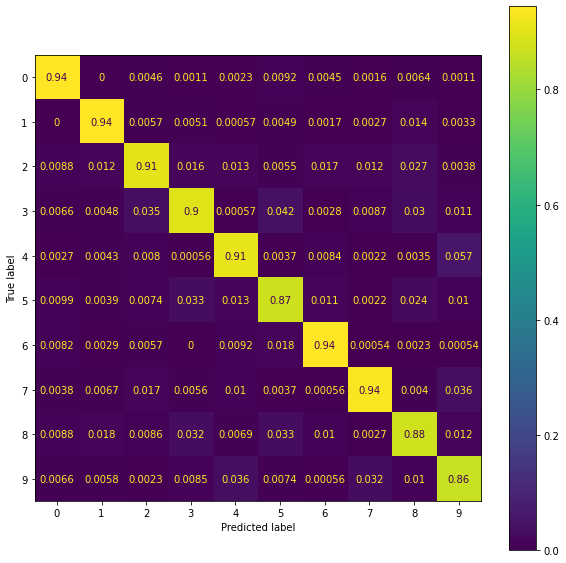

In [31]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(logistic_regression_model, D_X_val, D_y_val, normalize='pred', ax=ax)
plt.plot()

### 3.2 Neural Network Model

In [16]:
from sklearn.neural_network import MLPClassifier

neural_network_model = MLPClassifier(
    activation='relu',
    alpha=0.001,
    early_stopping=True,
    hidden_layer_sizes=(196,),
    learning_rate_init=0.01,
    random_state=42,
    verbose=True).fit(D_X_train, D_y_train)

Iteration 1, loss = 0.33195784
Validation score: 0.947381
Iteration 2, loss = 0.14188366
Validation score: 0.958571
Iteration 3, loss = 0.09811647
Validation score: 0.966667
Iteration 4, loss = 0.08020476
Validation score: 0.966905
Iteration 5, loss = 0.06685133
Validation score: 0.969524
Iteration 6, loss = 0.05833298
Validation score: 0.968810
Iteration 7, loss = 0.04690465
Validation score: 0.971429
Iteration 8, loss = 0.04023095
Validation score: 0.970000
Iteration 9, loss = 0.04016678
Validation score: 0.969524
Iteration 10, loss = 0.03374124
Validation score: 0.969524
Iteration 11, loss = 0.03134140
Validation score: 0.964762
Iteration 12, loss = 0.03032640
Validation score: 0.967143
Iteration 13, loss = 0.03207072
Validation score: 0.967381
Iteration 14, loss = 0.03386290
Validation score: 0.966190
Iteration 15, loss = 0.03591948
Validation score: 0.972381
Iteration 16, loss = 0.03423327
Validation score: 0.966667
Iteration 17, loss = 0.03253666
Validation score: 0.966190
Iterat

In [17]:
from sklearn.metrics import classification_report

predictions_neural_network = neural_network_model.predict(D_X_val)

print(classification_report(D_y_val, predictions_neural_network, digits=4))

              precision    recall  f1-score   support

           0     0.9761    0.9865    0.9812      1777
           1     0.9837    0.9847    0.9842      2023
           2     0.9588    0.9765    0.9676      1787
           3     0.9486    0.9636    0.9560      1839
           4     0.9725    0.9698    0.9712      1753
           5     0.9675    0.9508    0.9591      1626
           6     0.9743    0.9831    0.9787      1775
           7     0.9773    0.9601    0.9686      1880
           8     0.9729    0.9413    0.9568      1755
           9     0.9497    0.9625    0.9560      1785

    accuracy                         0.9682     18000
   macro avg     0.9681    0.9679    0.9679     18000
weighted avg     0.9683    0.9682    0.9682     18000



In [34]:
from sklearn.metrics import r2_score

r2_score(D_y_val, predictions_neural_network)

0.9325870302520848

[]

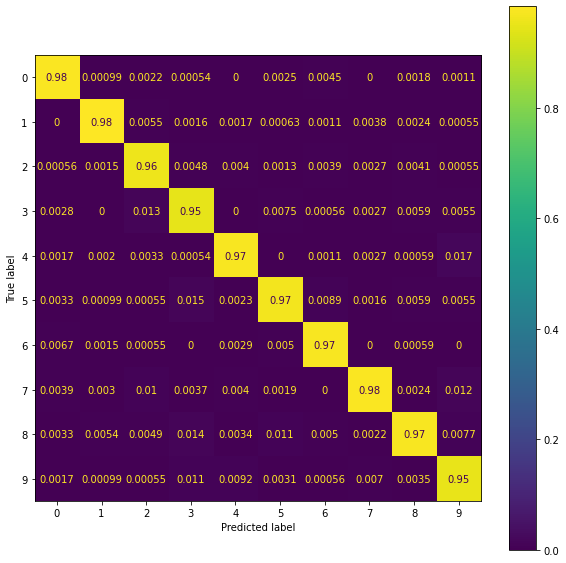

In [30]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(neural_network_model, D_X_val, D_y_val, normalize='pred', ax=ax)
plt.plot()

### 3.3 Training the SVM Model

In [18]:
from sklearn.svm import SVC

svm_model = SVC(
    C=10,
    decision_function_shape='ovo',
    random_state=42,
    verbose=3).fit(D_X_train, D_y_train)

[LibSVM]

In [19]:
from sklearn.metrics import classification_report

predictions_svm = svm_model.predict(D_X_val)

print(classification_report(D_y_val, predictions_svm, digits=4))

              precision    recall  f1-score   support

           0     0.9790    0.9949    0.9869      1777
           1     0.9795    0.9921    0.9858      2023
           2     0.9755    0.9810    0.9782      1787
           3     0.9867    0.9695    0.9781      1839
           4     0.9794    0.9778    0.9786      1753
           5     0.9820    0.9736    0.9778      1626
           6     0.9870    0.9842    0.9856      1775
           7     0.9802    0.9766    0.9784      1880
           8     0.9737    0.9721    0.9729      1755
           9     0.9697    0.9692    0.9695      1785

    accuracy                         0.9793     18000
   macro avg     0.9793    0.9791    0.9792     18000
weighted avg     0.9793    0.9793    0.9793     18000



In [35]:
from sklearn.metrics import r2_score

r2_score(D_y_val, predictions_svm)

0.9549870357971473

[]

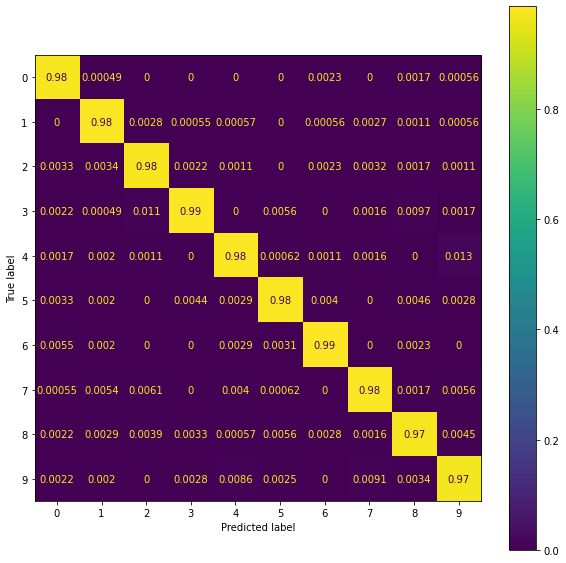

In [32]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(svm_model, D_X_val, D_y_val, normalize='pred', ax=ax)
plt.plot()

### 3.4 Choosing a model

Based on the shown results, the **SVM** is the chosen model.

The linear model - Logistic Regression - presents the lowest accuracy, with an average of about _91%_. Both the Neural Network and the SVM models' performances are better, with _96%_ and _97%_ average accuracy respectively. Therefore, the SVM model wins with a slight advantage over the Neural Network model.

Also, all the models performed similarly to their training scores, which shows that the regularization techniques had an impact on overfitting.

As a curiosity: all models had their lowest accuracy when trying to predict the digit nine.

## 4. Error estimation

### 4.1 With only $D_{train}$ data

In [43]:
from sklearn.svm import SVC

svm_model = SVC(
    C=10,
    decision_function_shape='ovo',
    random_state=42,
    verbose=3)

In [44]:
svm_model.fit(D_X_train, D_y_train)

[LibSVM]

SVC(C=10, decision_function_shape='ovo', random_state=42, verbose=3)

In [45]:
test_1_predictions = svm_model.predict(X_test)

In [46]:
from sklearn.metrics import classification_report

print(classification_report(y_test, test_1_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9749    0.9908    0.9828       980
           1     0.9878    0.9947    0.9912      1135
           2     0.9787    0.9787    0.9787      1032
           3     0.9802    0.9802    0.9802      1010
           4     0.9757    0.9817    0.9787       982
           5     0.9831    0.9787    0.9809       892
           6     0.9822    0.9770    0.9796       958
           7     0.9775    0.9708    0.9741      1028
           8     0.9793    0.9733    0.9763       974
           9     0.9710    0.9633    0.9672      1009

    accuracy                         0.9791     10000
   macro avg     0.9790    0.9789    0.9790     10000
weighted avg     0.9791    0.9791    0.9791     10000



In [52]:
from sklearn.metrics import r2_score

r2_score(y_test, test_1_predictions)

0.9462505138400789

[]

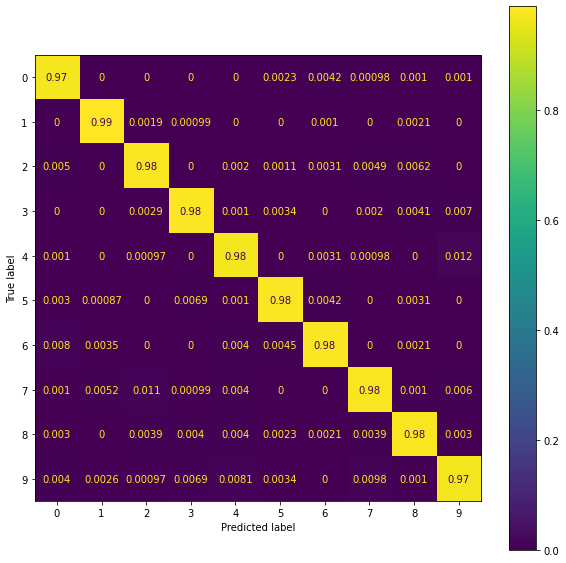

In [41]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(svm_model, X_test, y_test, normalize='pred', ax=ax)
plt.plot()

### 4.2 With all training data

In [47]:
svm_model.fit(X_train, y_train)
test_2_predictions = svm_model.predict(X_test)

[LibSVM]

In [49]:
from sklearn.metrics import classification_report

print(classification_report(y_test, test_2_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9809    0.9939    0.9873       980
           1     0.9895    0.9956    0.9925      1135
           2     0.9778    0.9826    0.9802      1032
           3     0.9793    0.9822    0.9807      1010
           4     0.9817    0.9847    0.9832       982
           5     0.9809    0.9776    0.9792       892
           6     0.9895    0.9833    0.9864       958
           7     0.9794    0.9728    0.9761      1028
           8     0.9774    0.9764    0.9769       974
           9     0.9779    0.9643    0.9711      1009

    accuracy                         0.9815     10000
   macro avg     0.9814    0.9813    0.9814     10000
weighted avg     0.9815    0.9815    0.9815     10000



In [51]:
from sklearn.metrics import r2_score

r2_score(y_test, test_2_predictions)

0.9561131331110473

[]

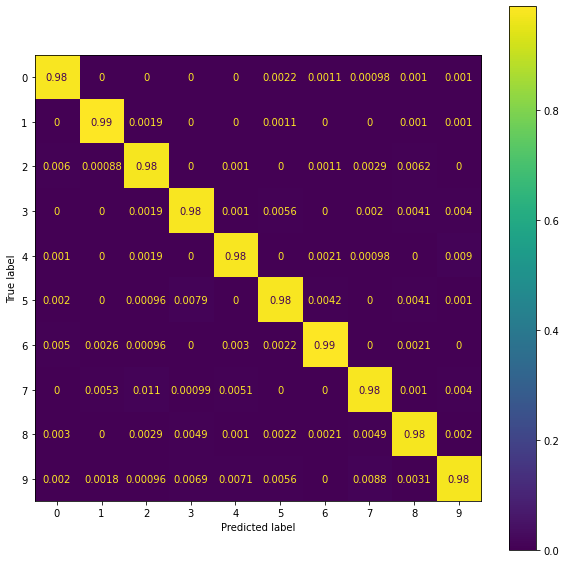

In [53]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(svm_model, X_test, y_test, normalize='pred', ax=ax)
plt.plot()

### 4.3 Conclusion